In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import catboost as cb
print("cb.__version__:", cb.__version__)

# local modules
import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

cb.__version__: 1.2.7


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

Id GameRulesetName                                        agent1  \
0            0             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
1            1             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
2            2             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
3            3             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
4            4             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
...        ...             ...                                           ...   
233229  233229     Zuz_Mel_7x7        MCTS-UCB1Tuned-1.41421356237-NST-false   
233230  233230     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233231  233231     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233232  233232     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233233  233233     Zuz_Mel_7x7   MCTS-UCB1Tuned-1.41421356237-Random200-true   

                                                   agent2  Properties  Format  \
0             MCTS-ProgressiveHistory-0.6-Random200-false           1       1   
1                             MCTS-UCB1GRAVE-0.6-NST-true           1       1   
2                                 MCTS-UCB1-0.1-NST-false           1       1   
3                                 MCTS-UCB1-0.6-NST-false           1       1   
4                  MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
...                                                   ...         ...     ...   
233229  MCTS-ProgressiveHistory-1.41421356237-Random20...           1       1   
233230                           MCTS-UCB1-0.6-MAST-false           1       1   
233231             MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
233232              MCTS-UCB1GRAVE-1.41421356237-NST-true           1       1   
233233                      MCTS-UCB1Tuned-0.6-MAST-false           1       1   

        Time  Discrete  Realtime  Turns  ...  DoLudeme  Trigger  \
0          1         1         0      1  ...         0        1   
1          1         1         0      1  ...         0        1   
2          1         1         0      1  ...         0        1   
3          1         1         0      1  ...         0        1   
4          1         1         0      1  ...         0        1   
...      ...       ...       ...    ...  ...       ...      ...   
233229     1         1         0      1  ...         0        0   
233230     1         1         0      1  ...         0        0   
233231     1         1         0      1  ...         0        0   
233232     1         1         0      1  ...         0        0   
233233     1         1         0      1  ...         0        0   

        PlayoutsPerSecond  MovesPerSecond  \
0                  298.07        18877.17   
1                  298.07        18877.17   
2                  298.07        18877.17   
3                  298.07        18877.17   
4                  298.07        18877.17   
...                   ...             ...   
233229             157.52       157174.58   
233230             157.52       157174.58   
233231             157.52       157174.58   
233232             157.52       157174.58   
233233             157.52       157174.58   

                                             EnglishRules  \
0       Goal: Connect all three edge colors with a sin...   
1       Goal: Connect all three edge colors with a sin...   
2       Goal: Connect all three edge colors with a sin...   
3       Goal: Connect all three edge colors with a sin...   
4       Goal: Connect all three edge colors with a sin...   
...                                                   ...   
233229  7x7 board. 24 pieces per player. Pieces begin ...   
233230  7x7 board. 24 pieces per player. Pieces begin ...   
233231  7x7 board. 24 pieces per player. Pieces begin ...   
233232  7x7 board. 24 pieces per player. Pieces begin ...   
233233  7x7 board. 24 pieces per player. Pieces begin ...   


In [3]:
# Load the feature selection results
fs_type = 'full'

In [4]:
# Parameters
fs_type = "full"


In [5]:
fs_mapping = {
    "full": None,
    "fsv2": '../feat_selection/select_optuna_lgbm_v2.json',
    "fsv3": '../feat_selection/select_optuna_catb.json',
    "fsv4": '../feat_selection/select_optuna_lgbm_v3.json',
    "fsv23": '../feat_selection/select_optuna_combined_v23.json',
    "fsv24": '../feat_selection/select_optuna_combined_v24.json',
    "fsv34": '../feat_selection/select_optuna_combined_v34.json',
    "int95": '../feat_selection/feat_selection_intersection_at_95.json',
    "int96": '../feat_selection/feat_selection_intersection_at_96.json',
    "int97": '../feat_selection/feat_selection_intersection_at_97.json',
    "int98": '../feat_selection/feat_selection_intersection_at_98.json',
    "int99": '../feat_selection/feat_selection_intersection_at_99.json',
    "uni80": '../feat_selection/feat_selection_union_at_80.json',
    "uni85": '../feat_selection/feat_selection_union_at_85.json',
    "uni90": '../feat_selection/feat_selection_union_at_90.json',
    "uni95": '../feat_selection/feat_selection_union_at_95.json',
}

fs_path = fs_mapping[fs_type]

if fs_path is None:
    feature_selection = dict()
else:
    with open(fs_path, 'r') as f:
        feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', None)
categorical_cols = feature_selection.get('categorical', None)

# text_cols = ["LudRules",]
text_cols = list()

print("Numerical features:", len(numerical_cols) if numerical_cols else 0)
print("Categorical features:", len(categorical_cols) if categorical_cols else 0)
print("Text features:", len(text_cols) if text_cols else 0)

Numerical features: 0
Categorical features: 0
Text features: 0


In [6]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=False if fs_type=="full" else True,
    include_text_features=False,
)

text_cols = list()

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  18


number of constant cols:  198


Numerical Columns: 588
Categorical Columns: 10


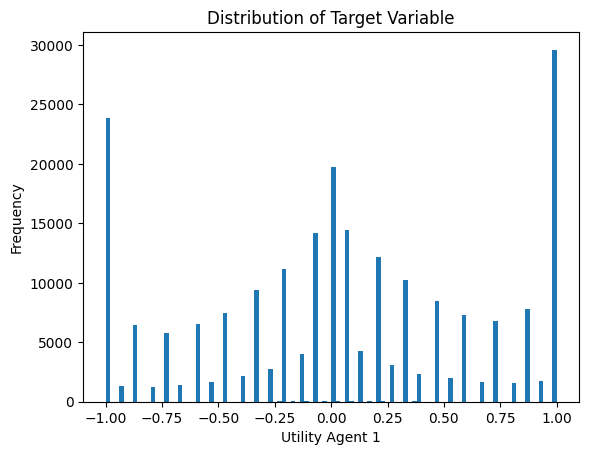

In [7]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [8]:
split1 = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))
split2 = pickle.load(open('../data/splits/cv2_Game.pkl', 'rb'))
split3 = pickle.load(open('../data/splits/cv3_Game.pkl', 'rb'))

# split1 = pickle.load(open('../data/splits/cv1_GameRulesetName.pkl', 'rb'))
# split2 = pickle.load(open('../data/splits/cv2_GameRulesetName.pkl', 'rb'))
# split3 = pickle.load(open('../data/splits/cv3_GameRulesetName.pkl', 'rb'))

***
### train model

In [9]:
def get_feature_importance(model, importance_type='PredictionValuesChange'):
    """
    Get feature importance from a trained CatBoost model
    
    Args:
        model: Trained CatBoost model
        importance_type: Type of feature importance to calculate
            Options: 'PredictionValuesChange', 'LossFunctionChange', 
            'ShapValues', 'Interaction', 'TopKitty'
        
    Returns:
        pandas.DataFrame: DataFrame containing feature names and their importance scores
    """
    # Get feature importance scores
    importance_scores = model.get_feature_importance(type=importance_type)
    feature_names = model.feature_names_
    
    # Create dataframe with feature names and importance scores
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance_scores
    }).sort_values('importance', ascending=False, ignore_index=True)
    
    return importance_df


def plot_feature_importance(importance_df, top_n=100):
    plot_df = importance_df.head(top_n)
    
    plt.figure(figsize=(15, 5))
    plt.bar(x=range(len(plot_df)), height=plot_df['importance'])
    plt.xticks(range(len(plot_df)), plot_df['feature'], rotation=45, ha='right', fontsize=8)
    plt.ylabel('Importance Score')
    plt.title(f'Top {top_n} Most Important Features')
    plt.tight_layout()
    plt.show()

In [10]:
def train_models(
        df_train,
        numerical_cols,
        categorical_cols,
        text_cols,
        target='utility_agent1',
        split_list=None,
    ):
    # Define the parameters for CatBoost
    params = {

        'objective': "RMSE",
        'learning_rate': 0.02,
        'depth': 10,
        'iterations': 10_000,
        'eval_metric': 'RMSE',
        'verbose': 0,
        'random_seed': 2112,
        'l2_leaf_reg': 1.,
        'random_strength': 0.2,
        'min_data_in_leaf': 50,
        'rsm': 0.8,
        'bagging_temperature' : 0.50,

        # 'text_processing': {
        #     'tokenizers': [{
        #         'tokenizer_id': 'Space',  # or 'GPT', 'Bert', etc.
        #         'separator_type': 'Space'
        #     }],
        #     'dictionaries': [{
        #         'dictionary_id': 'BiGram',
        #         'max_dictionary_size': '50000',
        #         'occurrence_lower_bound': '3',
        #         'gram_order': '2'
        #     }],
        #     'feature_calcers': [{
        #         'calcer_type': 'BoW',  # or 'NaiveBayes', 'BM25'
        #         'dictionary_id': 'BiGram'
        #     }]
        # }


        # # Text processing parameters to mimic TF-IDF
        # 'tokenizers': [{
        #     'tokenizer_id': 'Space',
        #     'separator_type': 'ByDelimiter',
        #     'delimiter': ' '
        # }],
        # 'dictionaries': [{
        #     'dictionary_id': 'NgramDict',
        #     'max_dictionary_size': '500',  # Match max_features=500
        #     'occurrence_lower_bound': '3',
        #     'gram_order': '3',  # Maximum n-gram size
        #     'min_gram_order': '2'  # Minimum n-gram size
        # }],
        # 'feature_calcers': [{
        #     'calcer_type': 'BoW',  # Most similar to TF-IDF
        #     'dictionary_id': 'NgramDict'
        # }],


        # 'tokenizers': [{
        #     'tokenizer_id': 'Space',
        #     'delimiter': ' ',
        #     'separator_type': 'ByDelimiter'
        # }],
        # 'dictionaries': [{
        #     'dictionary_id': 'Word',
        #     'max_dictionary_size': '50000',
        #     'occurrence_lower_bound': '3'
        # }],
        # 'feature_calcers': [{
        #     'calcer_type': 'BoW',
        #     'dictionary_id': 'Word',
        # }]
    }
    # Obtained with optuna
    # params = {
    #     'objective': 'RMSE',
    #     'verbose': False,
    #     'random_seed': 2112,
    #     'learning_rate': 0.1,
    #     'iterations': 3000,
    #     'bootstrap_type': 'Bayesian',
    #     'sampling_frequency': 'PerTreeLevel',
    #     'depth': 10,
    #     'l2_leaf_reg': 0.9359292512255313,
    #     'random_strength': 0.16693257025108216,
    #     'bagging_temperature': 0.15967219011745193,
    #     'rsm': 0.548125395769786,
    #     'min_data_in_leaf': 102,
    #     'max_ctr_complexity': 10
    # }

    trained_models = []
    oof = pd.DataFrame(
        index=df_train.index,
        columns=[f'{target}_true', f'{target}_pred', 'fold']
    )
    oof_scores = []
    feat_importance_dfs = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_valid = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_valid = X_train[target], X_valid[target]

        # Initialize CatBoost Pool
        train_pool = cb.Pool(
            # data=X_train[numerical_cols + categorical_cols + text_cols],
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            cat_features=categorical_cols,
            # text_features=text_cols
        )
        val_pool = cb.Pool(
            # data=X_valid[numerical_cols + categorical_cols + text_cols],
            data=X_valid[numerical_cols + categorical_cols],
            label=y_valid,
            cat_features=categorical_cols,
            # text_features=text_cols
        )
        
        # Initialize CatBoost Regressor
        model = cb.CatBoostRegressor(**params)
        
        # Train the model
        model.fit(
            train_pool,
            eval_set=val_pool,
            use_best_model=True,
            verbose=50
        )

        feat_importance = get_feature_importance(model)
        feat_importance = feat_importance.rename(columns={'importance': f'importance_f{fold}'})
        feat_importance_dfs.append(feat_importance)
        plot_feature_importance(feat_importance.rename(columns={f'importance_f{fold}': 'importance'}))
        
        # Save the trained model to the list
        trained_models.append(model)

        # Predict on validation set
        y_pred = model.predict(val_pool)

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_valid
        oof.loc[val_index, f'{target}_pred'] = y_pred
        oof.loc[val_index, 'fold'] = fold
        
        # Compute RMSE
        y_pred = np.clip(y_pred, -1, 1)
        rmse = np.sqrt(np.mean((y_pred - y_valid) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Combine feature importance dataframes
    importance_df = feat_importance_dfs[0]
    for df in feat_importance_dfs[1:]:
        importance_df = importance_df.merge(df, on='feature')
    
    # Calculate mean importance across folds
    importance_cols = [col for col in importance_df.columns if col.startswith('importance_f')]
    importance_df['importance_mean'] = importance_df[importance_cols].mean(axis=1)
    importance_df = importance_df.sort_values('importance_mean', ascending=False, ignore_index=True)
    importance_df['importance_relative'] = (
        importance_df['importance_mean'] / 
        importance_df['importance_mean'].sum()
    )

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))

    return trained_models, oof, oof_scores, importance_df

Fold 1


0:	learn: 0.6319988	test: 0.5540150	best: 0.5540150 (0)	total: 209ms	remaining: 34m 53s


50:	learn: 0.4911705	test: 0.5106045	best: 0.5106045 (50)	total: 6.44s	remaining: 20m 55s


100:	learn: 0.4417375	test: 0.4897806	best: 0.4897806 (100)	total: 12.8s	remaining: 20m 56s


150:	learn: 0.4142292	test: 0.4769740	best: 0.4769740 (150)	total: 19.3s	remaining: 20m 59s


200:	learn: 0.3966897	test: 0.4674172	best: 0.4674172 (200)	total: 25.8s	remaining: 20m 56s


250:	learn: 0.3833570	test: 0.4604230	best: 0.4604230 (250)	total: 32.6s	remaining: 21m 7s


300:	learn: 0.3727047	test: 0.4554031	best: 0.4554031 (300)	total: 39.6s	remaining: 21m 15s


350:	learn: 0.3635258	test: 0.4509363	best: 0.4509363 (350)	total: 46.5s	remaining: 21m 18s


400:	learn: 0.3560753	test: 0.4475781	best: 0.4475781 (400)	total: 53.5s	remaining: 21m 19s


450:	learn: 0.3492607	test: 0.4448597	best: 0.4448363 (449)	total: 1m	remaining: 21m 20s


500:	learn: 0.3435211	test: 0.4422664	best: 0.4422664 (500)	total: 1m 7s	remaining: 21m 21s


550:	learn: 0.3382158	test: 0.4402284	best: 0.4402284 (550)	total: 1m 14s	remaining: 21m 18s


600:	learn: 0.3335019	test: 0.4384428	best: 0.4384428 (600)	total: 1m 21s	remaining: 21m 15s


650:	learn: 0.3289424	test: 0.4366585	best: 0.4366585 (650)	total: 1m 28s	remaining: 21m 10s


700:	learn: 0.3247047	test: 0.4352398	best: 0.4352398 (700)	total: 1m 35s	remaining: 21m 3s


750:	learn: 0.3211057	test: 0.4340856	best: 0.4340507 (749)	total: 1m 42s	remaining: 20m 59s


800:	learn: 0.3173535	test: 0.4327769	best: 0.4327769 (800)	total: 1m 48s	remaining: 20m 51s


850:	learn: 0.3143723	test: 0.4315658	best: 0.4315658 (850)	total: 1m 55s	remaining: 20m 46s


900:	learn: 0.3112860	test: 0.4306189	best: 0.4306125 (899)	total: 2m 2s	remaining: 20m 41s


950:	learn: 0.3084273	test: 0.4299175	best: 0.4299175 (950)	total: 2m 10s	remaining: 20m 37s


1000:	learn: 0.3055779	test: 0.4292157	best: 0.4292157 (1000)	total: 2m 16s	remaining: 20m 31s


1050:	learn: 0.3029121	test: 0.4284844	best: 0.4284844 (1050)	total: 2m 23s	remaining: 20m 24s


1100:	learn: 0.3003452	test: 0.4278548	best: 0.4278548 (1100)	total: 2m 30s	remaining: 20m 18s


1150:	learn: 0.2981528	test: 0.4272008	best: 0.4272008 (1150)	total: 2m 37s	remaining: 20m 12s


1200:	learn: 0.2958248	test: 0.4266254	best: 0.4266061 (1199)	total: 2m 44s	remaining: 20m 6s


1250:	learn: 0.2936726	test: 0.4262071	best: 0.4262071 (1250)	total: 2m 51s	remaining: 20m


1300:	learn: 0.2917072	test: 0.4257352	best: 0.4257352 (1300)	total: 2m 58s	remaining: 19m 55s


1350:	learn: 0.2898562	test: 0.4254407	best: 0.4254349 (1348)	total: 3m 5s	remaining: 19m 49s


1400:	learn: 0.2879645	test: 0.4250438	best: 0.4250438 (1400)	total: 3m 12s	remaining: 19m 43s


1450:	learn: 0.2862135	test: 0.4247038	best: 0.4247038 (1450)	total: 3m 19s	remaining: 19m 37s


1500:	learn: 0.2845378	test: 0.4242901	best: 0.4242901 (1500)	total: 3m 26s	remaining: 19m 31s


1550:	learn: 0.2829919	test: 0.4239905	best: 0.4239905 (1550)	total: 3m 34s	remaining: 19m 26s


1600:	learn: 0.2813164	test: 0.4237428	best: 0.4237428 (1600)	total: 3m 41s	remaining: 19m 19s


1650:	learn: 0.2797219	test: 0.4233910	best: 0.4233910 (1650)	total: 3m 48s	remaining: 19m 13s


1700:	learn: 0.2782290	test: 0.4231781	best: 0.4231781 (1700)	total: 3m 55s	remaining: 19m 7s


1750:	learn: 0.2768755	test: 0.4228738	best: 0.4228738 (1750)	total: 4m 2s	remaining: 19m 1s


1800:	learn: 0.2755121	test: 0.4225142	best: 0.4225142 (1800)	total: 4m 9s	remaining: 18m 54s


1850:	learn: 0.2740935	test: 0.4222025	best: 0.4221988 (1848)	total: 4m 16s	remaining: 18m 47s


1900:	learn: 0.2727465	test: 0.4219593	best: 0.4219431 (1897)	total: 4m 23s	remaining: 18m 40s


1950:	learn: 0.2714932	test: 0.4217114	best: 0.4217114 (1950)	total: 4m 30s	remaining: 18m 34s


2000:	learn: 0.2701196	test: 0.4214252	best: 0.4214252 (2000)	total: 4m 37s	remaining: 18m 28s


2050:	learn: 0.2689297	test: 0.4211807	best: 0.4211696 (2048)	total: 4m 44s	remaining: 18m 21s


2100:	learn: 0.2676163	test: 0.4209396	best: 0.4209389 (2098)	total: 4m 51s	remaining: 18m 14s


2150:	learn: 0.2664002	test: 0.4205693	best: 0.4205679 (2149)	total: 4m 58s	remaining: 18m 8s


2200:	learn: 0.2651548	test: 0.4204002	best: 0.4204002 (2200)	total: 5m 5s	remaining: 18m 1s


2250:	learn: 0.2639422	test: 0.4201708	best: 0.4201672 (2248)	total: 5m 12s	remaining: 17m 54s


2300:	learn: 0.2627884	test: 0.4200235	best: 0.4200026 (2298)	total: 5m 19s	remaining: 17m 48s


2350:	learn: 0.2616353	test: 0.4198466	best: 0.4198466 (2350)	total: 5m 26s	remaining: 17m 41s


2400:	learn: 0.2604327	test: 0.4196298	best: 0.4196234 (2393)	total: 5m 33s	remaining: 17m 34s


2450:	learn: 0.2594408	test: 0.4194337	best: 0.4194154 (2449)	total: 5m 40s	remaining: 17m 27s


2500:	learn: 0.2583235	test: 0.4192961	best: 0.4192892 (2490)	total: 5m 47s	remaining: 17m 20s


2550:	learn: 0.2573085	test: 0.4191452	best: 0.4191448 (2549)	total: 5m 54s	remaining: 17m 14s


2600:	learn: 0.2562772	test: 0.4189966	best: 0.4189904 (2593)	total: 6m 1s	remaining: 17m 7s


2650:	learn: 0.2552896	test: 0.4189120	best: 0.4189103 (2649)	total: 6m 8s	remaining: 17m 1s


2700:	learn: 0.2543535	test: 0.4187444	best: 0.4187444 (2700)	total: 6m 15s	remaining: 16m 54s


2750:	learn: 0.2533870	test: 0.4186139	best: 0.4186079 (2749)	total: 6m 22s	remaining: 16m 48s


2800:	learn: 0.2524077	test: 0.4184334	best: 0.4184334 (2800)	total: 6m 29s	remaining: 16m 41s


2850:	learn: 0.2514508	test: 0.4183158	best: 0.4183158 (2850)	total: 6m 36s	remaining: 16m 35s


2900:	learn: 0.2506250	test: 0.4182395	best: 0.4182376 (2897)	total: 6m 43s	remaining: 16m 28s


2950:	learn: 0.2496380	test: 0.4180931	best: 0.4180931 (2950)	total: 6m 50s	remaining: 16m 21s


3000:	learn: 0.2486800	test: 0.4179756	best: 0.4179756 (3000)	total: 6m 57s	remaining: 16m 14s


3050:	learn: 0.2477495	test: 0.4179042	best: 0.4179011 (3048)	total: 7m 4s	remaining: 16m 7s


3100:	learn: 0.2468771	test: 0.4178006	best: 0.4177947 (3095)	total: 7m 12s	remaining: 16m 1s


3150:	learn: 0.2461347	test: 0.4177261	best: 0.4177261 (3150)	total: 7m 19s	remaining: 15m 55s


3200:	learn: 0.2452010	test: 0.4175387	best: 0.4175387 (3200)	total: 7m 26s	remaining: 15m 48s


3250:	learn: 0.2444538	test: 0.4174037	best: 0.4174004 (3249)	total: 7m 33s	remaining: 15m 41s


3300:	learn: 0.2435856	test: 0.4172834	best: 0.4172621 (3290)	total: 7m 40s	remaining: 15m 34s


3350:	learn: 0.2427020	test: 0.4171716	best: 0.4171694 (3349)	total: 7m 47s	remaining: 15m 28s


3400:	learn: 0.2419094	test: 0.4170518	best: 0.4170500 (3399)	total: 7m 54s	remaining: 15m 21s


3450:	learn: 0.2411540	test: 0.4169583	best: 0.4169583 (3450)	total: 8m 2s	remaining: 15m 14s


3500:	learn: 0.2403848	test: 0.4168761	best: 0.4168631 (3494)	total: 8m 9s	remaining: 15m 8s


3550:	learn: 0.2397167	test: 0.4167571	best: 0.4167518 (3544)	total: 8m 16s	remaining: 15m 1s


3600:	learn: 0.2389069	test: 0.4166098	best: 0.4166088 (3599)	total: 8m 23s	remaining: 14m 54s


3650:	learn: 0.2381919	test: 0.4165887	best: 0.4165815 (3648)	total: 8m 30s	remaining: 14m 47s


3700:	learn: 0.2375325	test: 0.4164852	best: 0.4164852 (3700)	total: 8m 37s	remaining: 14m 41s


3750:	learn: 0.2368355	test: 0.4164005	best: 0.4163964 (3749)	total: 8m 44s	remaining: 14m 34s


3800:	learn: 0.2361526	test: 0.4163376	best: 0.4163253 (3799)	total: 8m 51s	remaining: 14m 27s


3850:	learn: 0.2354662	test: 0.4162648	best: 0.4162648 (3850)	total: 8m 58s	remaining: 14m 20s


3900:	learn: 0.2346040	test: 0.4161760	best: 0.4161760 (3900)	total: 9m 5s	remaining: 14m 13s


3950:	learn: 0.2339137	test: 0.4160920	best: 0.4160880 (3948)	total: 9m 13s	remaining: 14m 6s


4000:	learn: 0.2331918	test: 0.4159929	best: 0.4159913 (3999)	total: 9m 20s	remaining: 13m 59s


4050:	learn: 0.2325394	test: 0.4159865	best: 0.4159612 (4036)	total: 9m 27s	remaining: 13m 52s


4100:	learn: 0.2318049	test: 0.4159426	best: 0.4159426 (4100)	total: 9m 34s	remaining: 13m 45s


4150:	learn: 0.2311839	test: 0.4159227	best: 0.4159168 (4142)	total: 9m 41s	remaining: 13m 39s


4200:	learn: 0.2305778	test: 0.4158940	best: 0.4158841 (4166)	total: 9m 48s	remaining: 13m 32s


4250:	learn: 0.2299298	test: 0.4158066	best: 0.4158002 (4245)	total: 9m 55s	remaining: 13m 25s


4300:	learn: 0.2292819	test: 0.4157416	best: 0.4157401 (4299)	total: 10m 2s	remaining: 13m 18s


4350:	learn: 0.2286217	test: 0.4157116	best: 0.4157105 (4317)	total: 10m 9s	remaining: 13m 11s


4400:	learn: 0.2279926	test: 0.4156836	best: 0.4156836 (4400)	total: 10m 16s	remaining: 13m 4s


4450:	learn: 0.2273985	test: 0.4156610	best: 0.4156521 (4449)	total: 10m 23s	remaining: 12m 57s


4500:	learn: 0.2267507	test: 0.4156228	best: 0.4156169 (4486)	total: 10m 30s	remaining: 12m 50s


4550:	learn: 0.2262566	test: 0.4155942	best: 0.4155925 (4530)	total: 10m 37s	remaining: 12m 43s


4600:	learn: 0.2256847	test: 0.4155597	best: 0.4155581 (4592)	total: 10m 44s	remaining: 12m 36s


4650:	learn: 0.2250500	test: 0.4154665	best: 0.4154665 (4650)	total: 10m 51s	remaining: 12m 29s


4700:	learn: 0.2244966	test: 0.4154281	best: 0.4154263 (4696)	total: 10m 58s	remaining: 12m 22s


4750:	learn: 0.2239674	test: 0.4153978	best: 0.4153977 (4747)	total: 11m 6s	remaining: 12m 15s


4800:	learn: 0.2233937	test: 0.4153533	best: 0.4153533 (4800)	total: 11m 13s	remaining: 12m 8s


4850:	learn: 0.2228111	test: 0.4152980	best: 0.4152980 (4850)	total: 11m 20s	remaining: 12m 1s


4900:	learn: 0.2222003	test: 0.4152436	best: 0.4152432 (4899)	total: 11m 27s	remaining: 11m 54s


4950:	learn: 0.2215871	test: 0.4151963	best: 0.4151963 (4950)	total: 11m 34s	remaining: 11m 47s


5000:	learn: 0.2210907	test: 0.4151675	best: 0.4151672 (4998)	total: 11m 41s	remaining: 11m 41s


5050:	learn: 0.2206175	test: 0.4151499	best: 0.4151444 (5048)	total: 11m 48s	remaining: 11m 34s


5100:	learn: 0.2200303	test: 0.4150732	best: 0.4150709 (5099)	total: 11m 55s	remaining: 11m 27s


5150:	learn: 0.2194873	test: 0.4150471	best: 0.4150395 (5131)	total: 12m 2s	remaining: 11m 20s


5200:	learn: 0.2189067	test: 0.4150159	best: 0.4150096 (5196)	total: 12m 9s	remaining: 11m 13s


5250:	learn: 0.2183530	test: 0.4149295	best: 0.4149295 (5250)	total: 12m 16s	remaining: 11m 6s


5300:	learn: 0.2178819	test: 0.4148895	best: 0.4148895 (5300)	total: 12m 23s	remaining: 10m 59s


5350:	learn: 0.2173242	test: 0.4148617	best: 0.4148617 (5350)	total: 12m 30s	remaining: 10m 52s


5400:	learn: 0.2167740	test: 0.4148291	best: 0.4148215 (5386)	total: 12m 37s	remaining: 10m 45s


5450:	learn: 0.2162532	test: 0.4148128	best: 0.4148099 (5424)	total: 12m 44s	remaining: 10m 38s


5500:	learn: 0.2157807	test: 0.4147903	best: 0.4147903 (5500)	total: 12m 51s	remaining: 10m 31s


5550:	learn: 0.2153036	test: 0.4147786	best: 0.4147729 (5537)	total: 12m 58s	remaining: 10m 24s


5600:	learn: 0.2147833	test: 0.4147460	best: 0.4147398 (5596)	total: 13m 5s	remaining: 10m 17s


5650:	learn: 0.2143265	test: 0.4147122	best: 0.4147092 (5636)	total: 13m 12s	remaining: 10m 10s


5700:	learn: 0.2138250	test: 0.4147010	best: 0.4147006 (5696)	total: 13m 19s	remaining: 10m 3s


5750:	learn: 0.2133044	test: 0.4146386	best: 0.4146360 (5748)	total: 13m 26s	remaining: 9m 56s


5800:	learn: 0.2127996	test: 0.4146276	best: 0.4146276 (5800)	total: 13m 33s	remaining: 9m 49s


5850:	learn: 0.2123250	test: 0.4145688	best: 0.4145688 (5850)	total: 13m 40s	remaining: 9m 42s


5900:	learn: 0.2118865	test: 0.4145581	best: 0.4145552 (5882)	total: 13m 48s	remaining: 9m 35s


5950:	learn: 0.2114236	test: 0.4145104	best: 0.4145104 (5950)	total: 13m 55s	remaining: 9m 28s


6000:	learn: 0.2110034	test: 0.4144928	best: 0.4144928 (6000)	total: 14m 2s	remaining: 9m 21s


6050:	learn: 0.2105108	test: 0.4144872	best: 0.4144844 (6024)	total: 14m 9s	remaining: 9m 14s


6100:	learn: 0.2100437	test: 0.4144418	best: 0.4144384 (6095)	total: 14m 16s	remaining: 9m 7s


6150:	learn: 0.2095945	test: 0.4144287	best: 0.4144255 (6138)	total: 14m 23s	remaining: 9m


6200:	learn: 0.2090801	test: 0.4143948	best: 0.4143948 (6200)	total: 14m 30s	remaining: 8m 53s


6250:	learn: 0.2085957	test: 0.4143478	best: 0.4143471 (6249)	total: 14m 37s	remaining: 8m 46s


6300:	learn: 0.2080867	test: 0.4143189	best: 0.4143143 (6290)	total: 14m 44s	remaining: 8m 39s


6350:	learn: 0.2076386	test: 0.4143097	best: 0.4143097 (6350)	total: 14m 51s	remaining: 8m 32s


6400:	learn: 0.2071765	test: 0.4142820	best: 0.4142759 (6382)	total: 14m 58s	remaining: 8m 25s


6450:	learn: 0.2066447	test: 0.4142853	best: 0.4142656 (6431)	total: 15m 5s	remaining: 8m 18s


6500:	learn: 0.2062617	test: 0.4142587	best: 0.4142532 (6495)	total: 15m 12s	remaining: 8m 11s


6550:	learn: 0.2058660	test: 0.4142305	best: 0.4142305 (6550)	total: 15m 19s	remaining: 8m 4s


6600:	learn: 0.2054295	test: 0.4141869	best: 0.4141869 (6600)	total: 15m 26s	remaining: 7m 57s


6650:	learn: 0.2050299	test: 0.4141670	best: 0.4141659 (6634)	total: 15m 33s	remaining: 7m 50s


6700:	learn: 0.2046193	test: 0.4140965	best: 0.4140965 (6700)	total: 15m 40s	remaining: 7m 43s


6750:	learn: 0.2041964	test: 0.4141043	best: 0.4140892 (6716)	total: 15m 47s	remaining: 7m 36s


6800:	learn: 0.2037528	test: 0.4140953	best: 0.4140892 (6716)	total: 15m 55s	remaining: 7m 29s


6850:	learn: 0.2033104	test: 0.4140547	best: 0.4140539 (6848)	total: 16m 2s	remaining: 7m 22s


6900:	learn: 0.2028756	test: 0.4140246	best: 0.4140246 (6900)	total: 16m 9s	remaining: 7m 15s


6950:	learn: 0.2024520	test: 0.4140180	best: 0.4140052 (6917)	total: 16m 16s	remaining: 7m 8s


7000:	learn: 0.2020712	test: 0.4139971	best: 0.4139971 (7000)	total: 16m 23s	remaining: 7m 1s


7050:	learn: 0.2016460	test: 0.4139821	best: 0.4139784 (7045)	total: 16m 30s	remaining: 6m 54s


7100:	learn: 0.2012742	test: 0.4139542	best: 0.4139542 (7100)	total: 16m 37s	remaining: 6m 47s


7150:	learn: 0.2008848	test: 0.4139313	best: 0.4139312 (7146)	total: 16m 44s	remaining: 6m 40s


7200:	learn: 0.2005075	test: 0.4139319	best: 0.4139218 (7179)	total: 16m 51s	remaining: 6m 33s


7250:	learn: 0.2001295	test: 0.4139175	best: 0.4139074 (7238)	total: 16m 58s	remaining: 6m 26s


7300:	learn: 0.1997480	test: 0.4139197	best: 0.4139042 (7290)	total: 17m 5s	remaining: 6m 19s


7350:	learn: 0.1992890	test: 0.4138890	best: 0.4138877 (7349)	total: 17m 12s	remaining: 6m 12s


7400:	learn: 0.1988850	test: 0.4138732	best: 0.4138687 (7380)	total: 17m 19s	remaining: 6m 5s


7450:	learn: 0.1984789	test: 0.4138525	best: 0.4138521 (7449)	total: 17m 26s	remaining: 5m 58s


7500:	learn: 0.1980458	test: 0.4138368	best: 0.4138274 (7491)	total: 17m 33s	remaining: 5m 51s


7550:	learn: 0.1976606	test: 0.4138303	best: 0.4138274 (7491)	total: 17m 40s	remaining: 5m 44s


7600:	learn: 0.1972770	test: 0.4137822	best: 0.4137756 (7590)	total: 17m 47s	remaining: 5m 37s


7650:	learn: 0.1969032	test: 0.4137682	best: 0.4137670 (7645)	total: 17m 54s	remaining: 5m 30s


7700:	learn: 0.1965458	test: 0.4137401	best: 0.4137401 (7700)	total: 18m 1s	remaining: 5m 22s


7750:	learn: 0.1962087	test: 0.4137372	best: 0.4137308 (7744)	total: 18m 9s	remaining: 5m 16s


7800:	learn: 0.1958221	test: 0.4137165	best: 0.4137153 (7797)	total: 18m 16s	remaining: 5m 9s


7850:	learn: 0.1954967	test: 0.4136746	best: 0.4136746 (7850)	total: 18m 23s	remaining: 5m 1s


7900:	learn: 0.1950935	test: 0.4136627	best: 0.4136557 (7893)	total: 18m 30s	remaining: 4m 54s


7950:	learn: 0.1947394	test: 0.4136508	best: 0.4136507 (7949)	total: 18m 37s	remaining: 4m 47s


8000:	learn: 0.1943444	test: 0.4136391	best: 0.4136330 (7990)	total: 18m 44s	remaining: 4m 40s


8050:	learn: 0.1938920	test: 0.4135968	best: 0.4135954 (8043)	total: 18m 51s	remaining: 4m 33s


8100:	learn: 0.1934881	test: 0.4135830	best: 0.4135830 (8100)	total: 18m 58s	remaining: 4m 26s


8150:	learn: 0.1930926	test: 0.4135920	best: 0.4135747 (8109)	total: 19m 5s	remaining: 4m 19s


8200:	learn: 0.1927261	test: 0.4136011	best: 0.4135747 (8109)	total: 19m 12s	remaining: 4m 12s


8250:	learn: 0.1923790	test: 0.4135799	best: 0.4135747 (8109)	total: 19m 19s	remaining: 4m 5s


8300:	learn: 0.1919991	test: 0.4135845	best: 0.4135743 (8268)	total: 19m 26s	remaining: 3m 58s


8350:	learn: 0.1916739	test: 0.4135885	best: 0.4135743 (8268)	total: 19m 34s	remaining: 3m 51s


8400:	learn: 0.1913205	test: 0.4135816	best: 0.4135743 (8268)	total: 19m 41s	remaining: 3m 44s


8450:	learn: 0.1909791	test: 0.4135680	best: 0.4135671 (8449)	total: 19m 48s	remaining: 3m 37s


8500:	learn: 0.1906521	test: 0.4135561	best: 0.4135540 (8496)	total: 19m 55s	remaining: 3m 30s


8550:	learn: 0.1902862	test: 0.4135563	best: 0.4135474 (8537)	total: 20m 2s	remaining: 3m 23s


8600:	learn: 0.1899974	test: 0.4135538	best: 0.4135474 (8537)	total: 20m 9s	remaining: 3m 16s


8650:	learn: 0.1896482	test: 0.4135618	best: 0.4135470 (8622)	total: 20m 16s	remaining: 3m 9s


8700:	learn: 0.1893079	test: 0.4135444	best: 0.4135436 (8697)	total: 20m 23s	remaining: 3m 2s


8750:	learn: 0.1889960	test: 0.4135139	best: 0.4135139 (8750)	total: 20m 30s	remaining: 2m 55s


8800:	learn: 0.1886449	test: 0.4134776	best: 0.4134776 (8800)	total: 20m 37s	remaining: 2m 48s


8850:	learn: 0.1882834	test: 0.4134648	best: 0.4134648 (8850)	total: 20m 45s	remaining: 2m 41s


8900:	learn: 0.1878872	test: 0.4134395	best: 0.4134356 (8898)	total: 20m 51s	remaining: 2m 34s


8950:	learn: 0.1876009	test: 0.4134254	best: 0.4134193 (8938)	total: 20m 59s	remaining: 2m 27s


9000:	learn: 0.1872077	test: 0.4133855	best: 0.4133855 (9000)	total: 21m 6s	remaining: 2m 20s


9050:	learn: 0.1868469	test: 0.4133670	best: 0.4133670 (9050)	total: 21m 13s	remaining: 2m 13s


9100:	learn: 0.1865256	test: 0.4133492	best: 0.4133492 (9100)	total: 21m 20s	remaining: 2m 6s


9150:	learn: 0.1861327	test: 0.4133241	best: 0.4133238 (9142)	total: 21m 27s	remaining: 1m 59s


9200:	learn: 0.1858434	test: 0.4133210	best: 0.4133090 (9184)	total: 21m 34s	remaining: 1m 52s


9250:	learn: 0.1855062	test: 0.4133093	best: 0.4133050 (9243)	total: 21m 41s	remaining: 1m 45s


9300:	learn: 0.1851833	test: 0.4132960	best: 0.4132941 (9298)	total: 21m 48s	remaining: 1m 38s


9350:	learn: 0.1848565	test: 0.4132976	best: 0.4132919 (9307)	total: 21m 55s	remaining: 1m 31s


9400:	learn: 0.1845465	test: 0.4133011	best: 0.4132919 (9307)	total: 22m 2s	remaining: 1m 24s


9450:	learn: 0.1842067	test: 0.4132914	best: 0.4132914 (9450)	total: 22m 9s	remaining: 1m 17s


9500:	learn: 0.1838747	test: 0.4132921	best: 0.4132836 (9464)	total: 22m 16s	remaining: 1m 10s


9550:	learn: 0.1835352	test: 0.4132668	best: 0.4132668 (9550)	total: 22m 23s	remaining: 1m 3s


9600:	learn: 0.1832194	test: 0.4132558	best: 0.4132549 (9589)	total: 22m 30s	remaining: 56.1s


9650:	learn: 0.1829258	test: 0.4132358	best: 0.4132352 (9649)	total: 22m 38s	remaining: 49.1s


9700:	learn: 0.1826004	test: 0.4132314	best: 0.4132263 (9691)	total: 22m 45s	remaining: 42.1s


9750:	learn: 0.1822863	test: 0.4132341	best: 0.4132189 (9733)	total: 22m 52s	remaining: 35s


9800:	learn: 0.1819688	test: 0.4132354	best: 0.4132189 (9733)	total: 22m 59s	remaining: 28s


9850:	learn: 0.1816729	test: 0.4132393	best: 0.4132189 (9733)	total: 23m 6s	remaining: 21s


9900:	learn: 0.1813629	test: 0.4132366	best: 0.4132189 (9733)	total: 23m 13s	remaining: 13.9s


9950:	learn: 0.1810232	test: 0.4132210	best: 0.4132189 (9733)	total: 23m 20s	remaining: 6.9s


9999:	learn: 0.1806794	test: 0.4132013	best: 0.4132012 (9993)	total: 23m 27s	remaining: 0us

bestTest = 0.4132012088
bestIteration = 9993

Shrink model to first 9994 iterations.


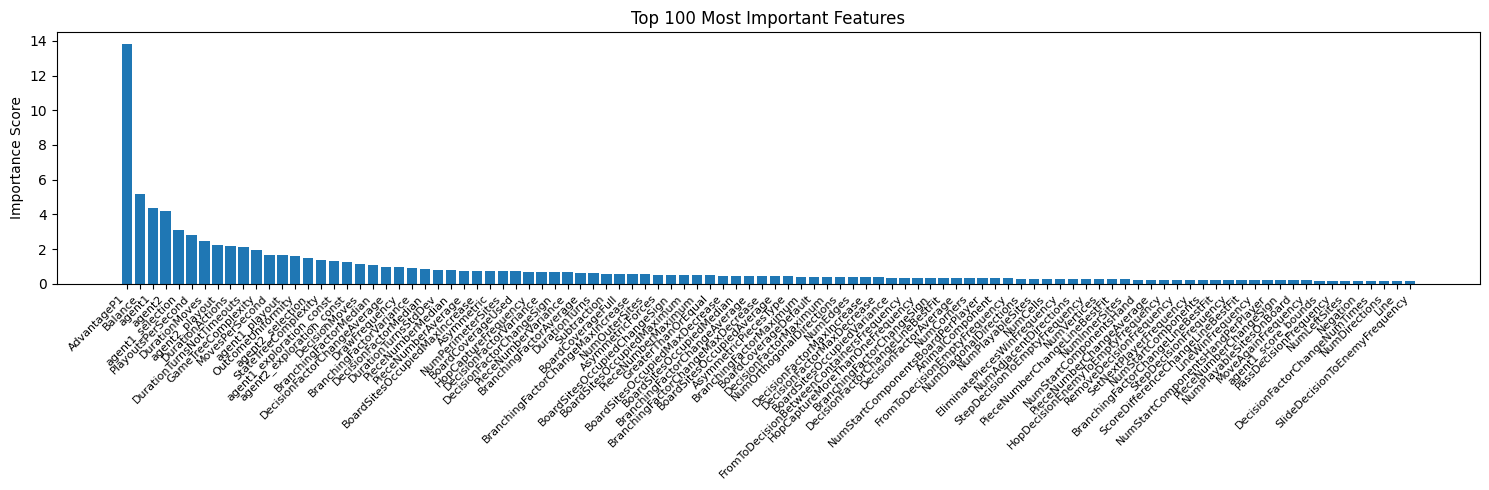

Fold 1 - RMSE: 0.4129550298106016
Fold 2


0:	learn: 0.6239399	test: 0.5884009	best: 0.5884009 (0)	total: 138ms	remaining: 22m 58s


50:	learn: 0.4932349	test: 0.5287159	best: 0.5287159 (50)	total: 6.46s	remaining: 20m 59s


100:	learn: 0.4477446	test: 0.5043786	best: 0.5043786 (100)	total: 12.9s	remaining: 21m 4s


150:	learn: 0.4213442	test: 0.4892549	best: 0.4892549 (150)	total: 19.9s	remaining: 21m 36s


200:	learn: 0.4036865	test: 0.4789931	best: 0.4789931 (200)	total: 27s	remaining: 21m 56s


250:	learn: 0.3906454	test: 0.4725965	best: 0.4725965 (250)	total: 34.3s	remaining: 22m 10s


300:	learn: 0.3803103	test: 0.4683249	best: 0.4683249 (300)	total: 41.4s	remaining: 22m 13s


350:	learn: 0.3716250	test: 0.4646622	best: 0.4646622 (350)	total: 48.5s	remaining: 22m 12s


400:	learn: 0.3643628	test: 0.4615004	best: 0.4615004 (400)	total: 55.8s	remaining: 22m 15s


450:	learn: 0.3579157	test: 0.4591833	best: 0.4591833 (450)	total: 1m 3s	remaining: 22m 15s


500:	learn: 0.3515324	test: 0.4563831	best: 0.4563743 (499)	total: 1m 10s	remaining: 22m 7s


550:	learn: 0.3460088	test: 0.4543372	best: 0.4543372 (550)	total: 1m 16s	remaining: 21m 59s


600:	learn: 0.3412111	test: 0.4527207	best: 0.4527207 (600)	total: 1m 23s	remaining: 21m 53s


650:	learn: 0.3368289	test: 0.4513112	best: 0.4513112 (650)	total: 1m 30s	remaining: 21m 45s


700:	learn: 0.3329636	test: 0.4503567	best: 0.4503393 (698)	total: 1m 38s	remaining: 21m 40s


750:	learn: 0.3292463	test: 0.4492807	best: 0.4492807 (750)	total: 1m 45s	remaining: 21m 34s


800:	learn: 0.3258811	test: 0.4484654	best: 0.4484654 (800)	total: 1m 52s	remaining: 21m 29s


850:	learn: 0.3226874	test: 0.4477292	best: 0.4477165 (846)	total: 1m 59s	remaining: 21m 23s


900:	learn: 0.3196379	test: 0.4467911	best: 0.4467911 (900)	total: 2m 6s	remaining: 21m 18s


950:	learn: 0.3167564	test: 0.4462886	best: 0.4462886 (950)	total: 2m 13s	remaining: 21m 11s


1000:	learn: 0.3139771	test: 0.4454418	best: 0.4454418 (1000)	total: 2m 20s	remaining: 21m 4s


1050:	learn: 0.3113170	test: 0.4446908	best: 0.4446774 (1048)	total: 2m 27s	remaining: 20m 58s


1100:	learn: 0.3088523	test: 0.4441479	best: 0.4441479 (1100)	total: 2m 34s	remaining: 20m 51s


1150:	learn: 0.3066261	test: 0.4437572	best: 0.4437572 (1150)	total: 2m 41s	remaining: 20m 43s


1200:	learn: 0.3044770	test: 0.4432812	best: 0.4432812 (1200)	total: 2m 49s	remaining: 20m 38s


1250:	learn: 0.3023986	test: 0.4427528	best: 0.4427528 (1250)	total: 2m 56s	remaining: 20m 32s


1300:	learn: 0.3002759	test: 0.4420753	best: 0.4420753 (1300)	total: 3m 3s	remaining: 20m 25s


1350:	learn: 0.2980456	test: 0.4415700	best: 0.4415490 (1349)	total: 3m 10s	remaining: 20m 18s


1400:	learn: 0.2959789	test: 0.4410096	best: 0.4410068 (1398)	total: 3m 17s	remaining: 20m 10s


1450:	learn: 0.2940118	test: 0.4406472	best: 0.4406472 (1450)	total: 3m 24s	remaining: 20m 4s


1500:	learn: 0.2923052	test: 0.4403178	best: 0.4403178 (1500)	total: 3m 31s	remaining: 19m 57s


1550:	learn: 0.2906099	test: 0.4399881	best: 0.4399813 (1547)	total: 3m 38s	remaining: 19m 51s


1600:	learn: 0.2887615	test: 0.4397465	best: 0.4397465 (1600)	total: 3m 45s	remaining: 19m 44s


1650:	learn: 0.2870886	test: 0.4394975	best: 0.4394975 (1650)	total: 3m 52s	remaining: 19m 37s


1700:	learn: 0.2856892	test: 0.4392690	best: 0.4392690 (1700)	total: 4m	remaining: 19m 31s


1750:	learn: 0.2840599	test: 0.4389467	best: 0.4389467 (1750)	total: 4m 7s	remaining: 19m 25s


1800:	learn: 0.2823966	test: 0.4387673	best: 0.4387390 (1796)	total: 4m 14s	remaining: 19m 18s


1850:	learn: 0.2810736	test: 0.4385228	best: 0.4385134 (1849)	total: 4m 21s	remaining: 19m 11s


1900:	learn: 0.2795462	test: 0.4382841	best: 0.4382841 (1900)	total: 4m 28s	remaining: 19m 5s


1950:	learn: 0.2781739	test: 0.4380482	best: 0.4380443 (1944)	total: 4m 36s	remaining: 18m 59s


2000:	learn: 0.2768832	test: 0.4378487	best: 0.4378487 (2000)	total: 4m 43s	remaining: 18m 51s


2050:	learn: 0.2754968	test: 0.4376949	best: 0.4376949 (2050)	total: 4m 50s	remaining: 18m 44s


2100:	learn: 0.2741478	test: 0.4374432	best: 0.4374432 (2100)	total: 4m 57s	remaining: 18m 37s


2150:	learn: 0.2729033	test: 0.4373762	best: 0.4373762 (2150)	total: 5m 4s	remaining: 18m 30s


2200:	learn: 0.2714697	test: 0.4371011	best: 0.4370993 (2199)	total: 5m 11s	remaining: 18m 23s


2250:	learn: 0.2702763	test: 0.4369453	best: 0.4369404 (2247)	total: 5m 18s	remaining: 18m 17s


2300:	learn: 0.2690932	test: 0.4367922	best: 0.4367758 (2295)	total: 5m 25s	remaining: 18m 9s


2350:	learn: 0.2679338	test: 0.4365898	best: 0.4365898 (2350)	total: 5m 32s	remaining: 18m 2s


2400:	learn: 0.2668434	test: 0.4365260	best: 0.4365243 (2398)	total: 5m 39s	remaining: 17m 55s


2450:	learn: 0.2657429	test: 0.4364604	best: 0.4364435 (2446)	total: 5m 47s	remaining: 17m 49s


2500:	learn: 0.2645873	test: 0.4363460	best: 0.4363460 (2500)	total: 5m 54s	remaining: 17m 41s


2550:	learn: 0.2633986	test: 0.4361477	best: 0.4361416 (2549)	total: 6m 1s	remaining: 17m 35s


2600:	learn: 0.2623633	test: 0.4359735	best: 0.4359735 (2600)	total: 6m 8s	remaining: 17m 28s


2650:	learn: 0.2612985	test: 0.4357619	best: 0.4357619 (2650)	total: 6m 15s	remaining: 17m 20s


2700:	learn: 0.2602613	test: 0.4355442	best: 0.4355442 (2700)	total: 6m 22s	remaining: 17m 13s


2750:	learn: 0.2592269	test: 0.4353048	best: 0.4353048 (2750)	total: 6m 29s	remaining: 17m 6s


2800:	learn: 0.2582522	test: 0.4351600	best: 0.4351600 (2800)	total: 6m 36s	remaining: 16m 59s


2850:	learn: 0.2573098	test: 0.4349820	best: 0.4349820 (2850)	total: 6m 43s	remaining: 16m 53s


2900:	learn: 0.2563788	test: 0.4349203	best: 0.4349201 (2899)	total: 6m 51s	remaining: 16m 46s


2950:	learn: 0.2553780	test: 0.4348079	best: 0.4347988 (2949)	total: 6m 58s	remaining: 16m 38s


3000:	learn: 0.2545144	test: 0.4347327	best: 0.4347218 (2999)	total: 7m 5s	remaining: 16m 32s


3050:	learn: 0.2536188	test: 0.4346204	best: 0.4346183 (3044)	total: 7m 12s	remaining: 16m 25s


3100:	learn: 0.2527159	test: 0.4344927	best: 0.4344909 (3095)	total: 7m 19s	remaining: 16m 18s


3150:	learn: 0.2519182	test: 0.4343771	best: 0.4343612 (3136)	total: 7m 26s	remaining: 16m 11s


3200:	learn: 0.2511887	test: 0.4342839	best: 0.4342829 (3199)	total: 7m 33s	remaining: 16m 4s


3250:	learn: 0.2502803	test: 0.4341944	best: 0.4341944 (3250)	total: 7m 40s	remaining: 15m 56s


3300:	learn: 0.2494617	test: 0.4340730	best: 0.4340690 (3293)	total: 7m 48s	remaining: 15m 50s


3350:	learn: 0.2487079	test: 0.4339787	best: 0.4339773 (3339)	total: 7m 55s	remaining: 15m 43s


3400:	learn: 0.2478294	test: 0.4337917	best: 0.4337907 (3399)	total: 8m 2s	remaining: 15m 36s


3450:	learn: 0.2470449	test: 0.4336895	best: 0.4336895 (3450)	total: 8m 9s	remaining: 15m 29s


3500:	learn: 0.2463406	test: 0.4335715	best: 0.4335409 (3497)	total: 8m 16s	remaining: 15m 22s


3550:	learn: 0.2455736	test: 0.4335532	best: 0.4335409 (3497)	total: 8m 24s	remaining: 15m 15s


3600:	learn: 0.2448144	test: 0.4335074	best: 0.4334909 (3598)	total: 8m 31s	remaining: 15m 8s


3650:	learn: 0.2440504	test: 0.4334485	best: 0.4334485 (3650)	total: 8m 38s	remaining: 15m 1s


3700:	learn: 0.2433862	test: 0.4333746	best: 0.4333746 (3700)	total: 8m 45s	remaining: 14m 54s


3750:	learn: 0.2425965	test: 0.4333508	best: 0.4333343 (3738)	total: 8m 52s	remaining: 14m 47s


3800:	learn: 0.2419729	test: 0.4332943	best: 0.4332943 (3800)	total: 8m 59s	remaining: 14m 40s


3850:	learn: 0.2412835	test: 0.4331946	best: 0.4331869 (3846)	total: 9m 6s	remaining: 14m 33s


3900:	learn: 0.2406216	test: 0.4331621	best: 0.4331516 (3894)	total: 9m 14s	remaining: 14m 26s


3950:	learn: 0.2399791	test: 0.4331076	best: 0.4331041 (3948)	total: 9m 21s	remaining: 14m 19s


4000:	learn: 0.2393558	test: 0.4330199	best: 0.4330183 (3994)	total: 9m 28s	remaining: 14m 12s


4050:	learn: 0.2387053	test: 0.4329238	best: 0.4329237 (4049)	total: 9m 35s	remaining: 14m 5s


4100:	learn: 0.2380607	test: 0.4329152	best: 0.4329002 (4070)	total: 9m 43s	remaining: 13m 58s


4150:	learn: 0.2374627	test: 0.4328486	best: 0.4328451 (4145)	total: 9m 50s	remaining: 13m 51s


4200:	learn: 0.2369295	test: 0.4328242	best: 0.4328153 (4169)	total: 9m 57s	remaining: 13m 45s


4250:	learn: 0.2363183	test: 0.4327444	best: 0.4327444 (4250)	total: 10m 4s	remaining: 13m 38s


4300:	learn: 0.2357405	test: 0.4326722	best: 0.4326722 (4300)	total: 10m 12s	remaining: 13m 31s


4350:	learn: 0.2350994	test: 0.4325737	best: 0.4325737 (4350)	total: 10m 19s	remaining: 13m 24s


4400:	learn: 0.2344777	test: 0.4324978	best: 0.4324975 (4399)	total: 10m 26s	remaining: 13m 17s


4450:	learn: 0.2339221	test: 0.4323939	best: 0.4323927 (4449)	total: 10m 33s	remaining: 13m 10s


4500:	learn: 0.2333351	test: 0.4323102	best: 0.4323102 (4500)	total: 10m 40s	remaining: 13m 2s


4550:	learn: 0.2327207	test: 0.4322070	best: 0.4322064 (4547)	total: 10m 48s	remaining: 12m 56s


4600:	learn: 0.2322241	test: 0.4321665	best: 0.4321665 (4600)	total: 10m 55s	remaining: 12m 49s


4650:	learn: 0.2316629	test: 0.4320867	best: 0.4320867 (4650)	total: 11m 2s	remaining: 12m 42s


4700:	learn: 0.2310740	test: 0.4319978	best: 0.4319948 (4699)	total: 11m 9s	remaining: 12m 35s


4750:	learn: 0.2305315	test: 0.4319037	best: 0.4319037 (4750)	total: 11m 16s	remaining: 12m 27s


4800:	learn: 0.2299506	test: 0.4318690	best: 0.4318690 (4800)	total: 11m 24s	remaining: 12m 20s


4850:	learn: 0.2294218	test: 0.4318060	best: 0.4318060 (4850)	total: 11m 31s	remaining: 12m 13s


4900:	learn: 0.2288539	test: 0.4316998	best: 0.4316998 (4900)	total: 11m 38s	remaining: 12m 6s


4950:	learn: 0.2283667	test: 0.4316544	best: 0.4316543 (4949)	total: 11m 46s	remaining: 11m 59s


5000:	learn: 0.2277845	test: 0.4315693	best: 0.4315693 (5000)	total: 11m 53s	remaining: 11m 52s


5050:	learn: 0.2272865	test: 0.4315235	best: 0.4315231 (5049)	total: 12m	remaining: 11m 45s


5100:	learn: 0.2267615	test: 0.4314877	best: 0.4314877 (5100)	total: 12m 7s	remaining: 11m 38s


5150:	learn: 0.2261886	test: 0.4314003	best: 0.4313999 (5149)	total: 12m 14s	remaining: 11m 31s


5200:	learn: 0.2257506	test: 0.4313451	best: 0.4313447 (5199)	total: 12m 21s	remaining: 11m 24s


5250:	learn: 0.2252687	test: 0.4312938	best: 0.4312898 (5232)	total: 12m 29s	remaining: 11m 17s


5300:	learn: 0.2247903	test: 0.4312522	best: 0.4312440 (5288)	total: 12m 36s	remaining: 11m 10s


5350:	learn: 0.2242795	test: 0.4311739	best: 0.4311721 (5336)	total: 12m 43s	remaining: 11m 3s


5400:	learn: 0.2238199	test: 0.4311522	best: 0.4311411 (5382)	total: 12m 50s	remaining: 10m 56s


5450:	learn: 0.2233148	test: 0.4311003	best: 0.4310962 (5448)	total: 12m 57s	remaining: 10m 49s


5500:	learn: 0.2228062	test: 0.4310810	best: 0.4310727 (5473)	total: 13m 5s	remaining: 10m 42s


5550:	learn: 0.2223856	test: 0.4310451	best: 0.4310451 (5550)	total: 13m 12s	remaining: 10m 35s


5600:	learn: 0.2219559	test: 0.4310022	best: 0.4310022 (5600)	total: 13m 19s	remaining: 10m 28s


5650:	learn: 0.2214746	test: 0.4309497	best: 0.4309497 (5650)	total: 13m 26s	remaining: 10m 20s


5700:	learn: 0.2210649	test: 0.4309226	best: 0.4309226 (5700)	total: 13m 34s	remaining: 10m 13s


5750:	learn: 0.2206107	test: 0.4308773	best: 0.4308773 (5750)	total: 13m 41s	remaining: 10m 6s


5800:	learn: 0.2201277	test: 0.4307928	best: 0.4307902 (5796)	total: 13m 48s	remaining: 9m 59s


5850:	learn: 0.2196403	test: 0.4307821	best: 0.4307695 (5828)	total: 13m 55s	remaining: 9m 52s


5900:	learn: 0.2191576	test: 0.4306947	best: 0.4306944 (5899)	total: 14m 2s	remaining: 9m 45s


5950:	learn: 0.2186464	test: 0.4306568	best: 0.4306568 (5950)	total: 14m 9s	remaining: 9m 37s


6000:	learn: 0.2182269	test: 0.4306089	best: 0.4306089 (6000)	total: 14m 16s	remaining: 9m 30s


6050:	learn: 0.2178292	test: 0.4305851	best: 0.4305832 (6047)	total: 14m 23s	remaining: 9m 23s


6100:	learn: 0.2174048	test: 0.4305192	best: 0.4305192 (6100)	total: 14m 31s	remaining: 9m 16s


6150:	learn: 0.2169569	test: 0.4305166	best: 0.4305078 (6110)	total: 14m 38s	remaining: 9m 9s


6200:	learn: 0.2165373	test: 0.4305045	best: 0.4305045 (6200)	total: 14m 45s	remaining: 9m 2s


6250:	learn: 0.2160676	test: 0.4304829	best: 0.4304785 (6216)	total: 14m 52s	remaining: 8m 55s


6300:	learn: 0.2156115	test: 0.4304447	best: 0.4304400 (6295)	total: 14m 59s	remaining: 8m 48s


6350:	learn: 0.2151504	test: 0.4304079	best: 0.4304079 (6350)	total: 15m 7s	remaining: 8m 41s


6400:	learn: 0.2147089	test: 0.4303791	best: 0.4303758 (6399)	total: 15m 14s	remaining: 8m 34s


6450:	learn: 0.2142581	test: 0.4303513	best: 0.4303491 (6446)	total: 15m 21s	remaining: 8m 26s


6500:	learn: 0.2138988	test: 0.4303666	best: 0.4303465 (6454)	total: 15m 28s	remaining: 8m 19s


6550:	learn: 0.2134688	test: 0.4303228	best: 0.4303118 (6544)	total: 15m 36s	remaining: 8m 12s


6600:	learn: 0.2130427	test: 0.4303196	best: 0.4303118 (6544)	total: 15m 43s	remaining: 8m 5s


6650:	learn: 0.2126058	test: 0.4302812	best: 0.4302812 (6650)	total: 15m 50s	remaining: 7m 58s


6700:	learn: 0.2122364	test: 0.4302727	best: 0.4302717 (6699)	total: 15m 57s	remaining: 7m 51s


6750:	learn: 0.2118686	test: 0.4302484	best: 0.4302465 (6748)	total: 16m 4s	remaining: 7m 44s


6800:	learn: 0.2114833	test: 0.4302539	best: 0.4302379 (6779)	total: 16m 12s	remaining: 7m 37s


6850:	learn: 0.2110180	test: 0.4302192	best: 0.4302192 (6850)	total: 16m 19s	remaining: 7m 30s


6900:	learn: 0.2106210	test: 0.4301853	best: 0.4301853 (6900)	total: 16m 26s	remaining: 7m 23s


6950:	learn: 0.2101377	test: 0.4301525	best: 0.4301525 (6950)	total: 16m 33s	remaining: 7m 15s


7000:	learn: 0.2097546	test: 0.4301342	best: 0.4301342 (7000)	total: 16m 41s	remaining: 7m 8s


7050:	learn: 0.2093417	test: 0.4301295	best: 0.4301234 (7012)	total: 16m 48s	remaining: 7m 1s


7100:	learn: 0.2089177	test: 0.4300952	best: 0.4300952 (7100)	total: 16m 55s	remaining: 6m 54s


7150:	learn: 0.2084545	test: 0.4300484	best: 0.4300463 (7146)	total: 17m 2s	remaining: 6m 47s


7200:	learn: 0.2080973	test: 0.4300374	best: 0.4300357 (7199)	total: 17m 9s	remaining: 6m 40s


7250:	learn: 0.2077461	test: 0.4300235	best: 0.4300235 (7250)	total: 17m 17s	remaining: 6m 33s


7300:	learn: 0.2073314	test: 0.4299858	best: 0.4299858 (7300)	total: 17m 24s	remaining: 6m 26s


7350:	learn: 0.2069718	test: 0.4299817	best: 0.4299759 (7321)	total: 17m 31s	remaining: 6m 18s


7400:	learn: 0.2066262	test: 0.4299193	best: 0.4299193 (7400)	total: 17m 38s	remaining: 6m 11s


7450:	learn: 0.2062190	test: 0.4299062	best: 0.4299062 (7450)	total: 17m 45s	remaining: 6m 4s


7500:	learn: 0.2058026	test: 0.4299293	best: 0.4299022 (7453)	total: 17m 52s	remaining: 5m 57s


7550:	learn: 0.2054569	test: 0.4298964	best: 0.4298964 (7550)	total: 18m	remaining: 5m 50s


7600:	learn: 0.2051492	test: 0.4298681	best: 0.4298653 (7591)	total: 18m 7s	remaining: 5m 43s


7650:	learn: 0.2047281	test: 0.4298757	best: 0.4298653 (7591)	total: 18m 14s	remaining: 5m 36s


7700:	learn: 0.2043657	test: 0.4298358	best: 0.4298357 (7699)	total: 18m 21s	remaining: 5m 28s


7750:	learn: 0.2040400	test: 0.4298191	best: 0.4298122 (7731)	total: 18m 29s	remaining: 5m 21s


7800:	learn: 0.2037041	test: 0.4298196	best: 0.4298122 (7731)	total: 18m 36s	remaining: 5m 14s


7850:	learn: 0.2033031	test: 0.4297937	best: 0.4297932 (7848)	total: 18m 43s	remaining: 5m 7s


7900:	learn: 0.2029885	test: 0.4297907	best: 0.4297798 (7875)	total: 18m 51s	remaining: 5m


7950:	learn: 0.2026585	test: 0.4297724	best: 0.4297724 (7950)	total: 18m 58s	remaining: 4m 53s


8000:	learn: 0.2022485	test: 0.4297518	best: 0.4297490 (7991)	total: 19m 5s	remaining: 4m 46s


8050:	learn: 0.2019175	test: 0.4297635	best: 0.4297490 (7991)	total: 19m 13s	remaining: 4m 39s


8100:	learn: 0.2015626	test: 0.4297534	best: 0.4297490 (7991)	total: 19m 20s	remaining: 4m 32s


8150:	learn: 0.2012091	test: 0.4297384	best: 0.4297346 (8141)	total: 19m 27s	remaining: 4m 24s


8200:	learn: 0.2008506	test: 0.4297309	best: 0.4297239 (8182)	total: 19m 34s	remaining: 4m 17s


8250:	learn: 0.2004665	test: 0.4297067	best: 0.4297067 (8250)	total: 19m 41s	remaining: 4m 10s


8300:	learn: 0.2001358	test: 0.4297080	best: 0.4297033 (8277)	total: 19m 49s	remaining: 4m 3s


8350:	learn: 0.1997818	test: 0.4297003	best: 0.4296961 (8322)	total: 19m 56s	remaining: 3m 56s


8400:	learn: 0.1994530	test: 0.4296890	best: 0.4296890 (8400)	total: 20m 3s	remaining: 3m 49s


8450:	learn: 0.1990739	test: 0.4296588	best: 0.4296581 (8449)	total: 20m 10s	remaining: 3m 41s


8500:	learn: 0.1987458	test: 0.4296443	best: 0.4296416 (8498)	total: 20m 18s	remaining: 3m 34s


8550:	learn: 0.1983898	test: 0.4296174	best: 0.4296166 (8547)	total: 20m 25s	remaining: 3m 27s


8600:	learn: 0.1981090	test: 0.4296039	best: 0.4295985 (8595)	total: 20m 32s	remaining: 3m 20s


8650:	learn: 0.1977900	test: 0.4295881	best: 0.4295799 (8642)	total: 20m 39s	remaining: 3m 13s


8700:	learn: 0.1974493	test: 0.4295916	best: 0.4295799 (8642)	total: 20m 46s	remaining: 3m 6s


8750:	learn: 0.1971846	test: 0.4295858	best: 0.4295786 (8741)	total: 20m 54s	remaining: 2m 59s


8800:	learn: 0.1969067	test: 0.4295749	best: 0.4295736 (8799)	total: 21m 1s	remaining: 2m 51s


8850:	learn: 0.1965526	test: 0.4295648	best: 0.4295605 (8838)	total: 21m 8s	remaining: 2m 44s


8900:	learn: 0.1962175	test: 0.4295521	best: 0.4295439 (8862)	total: 21m 15s	remaining: 2m 37s


8950:	learn: 0.1959313	test: 0.4295290	best: 0.4295250 (8943)	total: 21m 23s	remaining: 2m 30s


9000:	learn: 0.1956170	test: 0.4295209	best: 0.4295155 (8982)	total: 21m 30s	remaining: 2m 23s


9050:	learn: 0.1952675	test: 0.4294872	best: 0.4294866 (9048)	total: 21m 37s	remaining: 2m 16s


9100:	learn: 0.1949604	test: 0.4294778	best: 0.4294717 (9097)	total: 21m 44s	remaining: 2m 8s


9150:	learn: 0.1946182	test: 0.4294760	best: 0.4294717 (9097)	total: 21m 52s	remaining: 2m 1s


9200:	learn: 0.1942528	test: 0.4294769	best: 0.4294604 (9172)	total: 21m 59s	remaining: 1m 54s


9250:	learn: 0.1939566	test: 0.4294519	best: 0.4294519 (9250)	total: 22m 6s	remaining: 1m 47s


9300:	learn: 0.1936125	test: 0.4294423	best: 0.4294357 (9292)	total: 22m 13s	remaining: 1m 40s


9350:	learn: 0.1932875	test: 0.4294444	best: 0.4294357 (9292)	total: 22m 20s	remaining: 1m 33s


9400:	learn: 0.1929747	test: 0.4294498	best: 0.4294357 (9292)	total: 22m 28s	remaining: 1m 25s


9450:	learn: 0.1926997	test: 0.4294402	best: 0.4294357 (9292)	total: 22m 35s	remaining: 1m 18s


9500:	learn: 0.1924017	test: 0.4294315	best: 0.4294305 (9469)	total: 22m 42s	remaining: 1m 11s


9550:	learn: 0.1920489	test: 0.4294213	best: 0.4294125 (9527)	total: 22m 49s	remaining: 1m 4s


9600:	learn: 0.1917225	test: 0.4294047	best: 0.4294020 (9590)	total: 22m 56s	remaining: 57.2s


9650:	learn: 0.1913856	test: 0.4293969	best: 0.4293869 (9634)	total: 23m 4s	remaining: 50.1s


9700:	learn: 0.1910824	test: 0.4293860	best: 0.4293808 (9675)	total: 23m 11s	remaining: 42.9s


9750:	learn: 0.1907912	test: 0.4293799	best: 0.4293785 (9714)	total: 23m 18s	remaining: 35.7s


9800:	learn: 0.1904612	test: 0.4293685	best: 0.4293685 (9800)	total: 23m 26s	remaining: 28.6s


9850:	learn: 0.1901320	test: 0.4293541	best: 0.4293527 (9839)	total: 23m 33s	remaining: 21.4s


9900:	learn: 0.1898040	test: 0.4293385	best: 0.4293385 (9900)	total: 23m 40s	remaining: 14.2s


9950:	learn: 0.1894767	test: 0.4293336	best: 0.4293311 (9922)	total: 23m 47s	remaining: 7.03s


9999:	learn: 0.1892196	test: 0.4293275	best: 0.4293211 (9996)	total: 23m 54s	remaining: 0us

bestTest = 0.4293210584
bestIteration = 9996

Shrink model to first 9997 iterations.


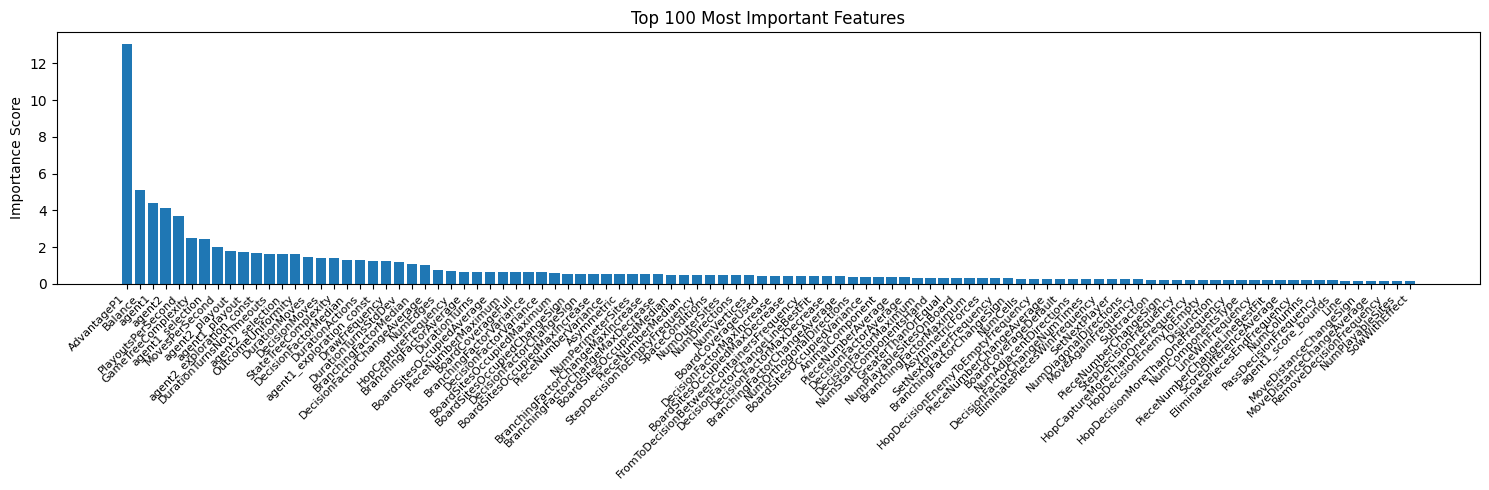

Fold 2 - RMSE: 0.4290280153961056
Fold 3


0:	learn: 0.6208229	test: 0.6067045	best: 0.6067045 (0)	total: 133ms	remaining: 22m 14s


50:	learn: 0.4899121	test: 0.5300057	best: 0.5300057 (50)	total: 6.38s	remaining: 20m 44s


100:	learn: 0.4449182	test: 0.4992013	best: 0.4992013 (100)	total: 12.9s	remaining: 21m 3s


150:	learn: 0.4177790	test: 0.4829181	best: 0.4829181 (150)	total: 19.6s	remaining: 21m 19s


200:	learn: 0.4007240	test: 0.4735310	best: 0.4735310 (200)	total: 26.5s	remaining: 21m 31s


250:	learn: 0.3887420	test: 0.4662180	best: 0.4662180 (250)	total: 33.6s	remaining: 21m 46s


300:	learn: 0.3796389	test: 0.4619235	best: 0.4619218 (299)	total: 40.8s	remaining: 21m 54s


350:	learn: 0.3717863	test: 0.4588577	best: 0.4588577 (350)	total: 48.1s	remaining: 22m 2s


400:	learn: 0.3648335	test: 0.4560578	best: 0.4560578 (400)	total: 55.4s	remaining: 22m 5s


450:	learn: 0.3588219	test: 0.4537273	best: 0.4537273 (450)	total: 1m 2s	remaining: 22m 9s


500:	learn: 0.3534159	test: 0.4515139	best: 0.4515139 (500)	total: 1m 10s	remaining: 22m 8s


550:	learn: 0.3484073	test: 0.4494915	best: 0.4494915 (550)	total: 1m 17s	remaining: 22m 3s


600:	learn: 0.3436567	test: 0.4475276	best: 0.4475209 (599)	total: 1m 24s	remaining: 21m 58s


650:	learn: 0.3395312	test: 0.4457808	best: 0.4457808 (650)	total: 1m 31s	remaining: 21m 54s


700:	learn: 0.3351139	test: 0.4439609	best: 0.4439609 (700)	total: 1m 38s	remaining: 21m 45s


750:	learn: 0.3311376	test: 0.4425903	best: 0.4425903 (750)	total: 1m 45s	remaining: 21m 38s


800:	learn: 0.3276067	test: 0.4416725	best: 0.4416725 (800)	total: 1m 52s	remaining: 21m 32s


850:	learn: 0.3243129	test: 0.4407333	best: 0.4407333 (850)	total: 1m 59s	remaining: 21m 26s


900:	learn: 0.3212092	test: 0.4398535	best: 0.4398469 (898)	total: 2m 6s	remaining: 21m 19s


950:	learn: 0.3185973	test: 0.4392037	best: 0.4391946 (949)	total: 2m 13s	remaining: 21m 13s


1000:	learn: 0.3157999	test: 0.4384729	best: 0.4384703 (998)	total: 2m 20s	remaining: 21m 7s


1050:	learn: 0.3136005	test: 0.4379249	best: 0.4379249 (1050)	total: 2m 28s	remaining: 21m 4s


1100:	learn: 0.3111913	test: 0.4373373	best: 0.4373373 (1100)	total: 2m 35s	remaining: 20m 59s


1150:	learn: 0.3088274	test: 0.4366259	best: 0.4366259 (1150)	total: 2m 43s	remaining: 20m 53s


1200:	learn: 0.3065113	test: 0.4360390	best: 0.4360390 (1200)	total: 2m 50s	remaining: 20m 46s


1250:	learn: 0.3043403	test: 0.4354134	best: 0.4354134 (1250)	total: 2m 57s	remaining: 20m 39s


1300:	learn: 0.3023049	test: 0.4350284	best: 0.4350071 (1299)	total: 3m 4s	remaining: 20m 33s


1350:	learn: 0.3002769	test: 0.4347376	best: 0.4347376 (1350)	total: 3m 11s	remaining: 20m 27s


1400:	learn: 0.2983535	test: 0.4342494	best: 0.4342494 (1400)	total: 3m 18s	remaining: 20m 20s


1450:	learn: 0.2962664	test: 0.4337598	best: 0.4337598 (1450)	total: 3m 25s	remaining: 20m 11s


1500:	learn: 0.2944595	test: 0.4331938	best: 0.4331938 (1500)	total: 3m 32s	remaining: 20m 5s


1550:	learn: 0.2926022	test: 0.4328668	best: 0.4328668 (1550)	total: 3m 39s	remaining: 19m 58s


1600:	learn: 0.2907108	test: 0.4324316	best: 0.4324261 (1597)	total: 3m 47s	remaining: 19m 51s


1650:	learn: 0.2889132	test: 0.4321019	best: 0.4321019 (1650)	total: 3m 54s	remaining: 19m 44s


1700:	learn: 0.2874456	test: 0.4318034	best: 0.4318034 (1700)	total: 4m 1s	remaining: 19m 37s


1750:	learn: 0.2859526	test: 0.4315944	best: 0.4315937 (1749)	total: 4m 8s	remaining: 19m 30s


1800:	learn: 0.2844465	test: 0.4313584	best: 0.4313584 (1800)	total: 4m 15s	remaining: 19m 23s


1850:	learn: 0.2828743	test: 0.4310441	best: 0.4310422 (1849)	total: 4m 22s	remaining: 19m 17s


1900:	learn: 0.2813255	test: 0.4308558	best: 0.4308219 (1878)	total: 4m 30s	remaining: 19m 10s


1950:	learn: 0.2798433	test: 0.4306356	best: 0.4306184 (1948)	total: 4m 37s	remaining: 19m 3s


2000:	learn: 0.2784867	test: 0.4304276	best: 0.4304276 (2000)	total: 4m 44s	remaining: 18m 56s


2050:	learn: 0.2769588	test: 0.4301349	best: 0.4301349 (2050)	total: 4m 51s	remaining: 18m 49s


2100:	learn: 0.2754626	test: 0.4299038	best: 0.4299038 (2100)	total: 4m 58s	remaining: 18m 42s


2150:	learn: 0.2741368	test: 0.4297105	best: 0.4297105 (2150)	total: 5m 5s	remaining: 18m 35s


2200:	learn: 0.2727476	test: 0.4295415	best: 0.4295170 (2195)	total: 5m 12s	remaining: 18m 28s


2250:	learn: 0.2714888	test: 0.4294256	best: 0.4294256 (2250)	total: 5m 19s	remaining: 18m 21s


2300:	learn: 0.2702886	test: 0.4292080	best: 0.4292080 (2300)	total: 5m 26s	remaining: 18m 13s


2350:	learn: 0.2690919	test: 0.4291238	best: 0.4291179 (2348)	total: 5m 34s	remaining: 18m 6s


2400:	learn: 0.2680257	test: 0.4289676	best: 0.4289676 (2400)	total: 5m 41s	remaining: 17m 59s


2450:	learn: 0.2669979	test: 0.4288336	best: 0.4288336 (2450)	total: 5m 48s	remaining: 17m 53s


2500:	learn: 0.2658299	test: 0.4286909	best: 0.4286848 (2498)	total: 5m 55s	remaining: 17m 45s


2550:	learn: 0.2646613	test: 0.4285996	best: 0.4285844 (2547)	total: 6m 2s	remaining: 17m 38s


2600:	learn: 0.2635813	test: 0.4284272	best: 0.4284136 (2597)	total: 6m 9s	remaining: 17m 31s


2650:	learn: 0.2624934	test: 0.4282112	best: 0.4282112 (2650)	total: 6m 16s	remaining: 17m 23s


2700:	learn: 0.2615006	test: 0.4280642	best: 0.4280642 (2700)	total: 6m 23s	remaining: 17m 16s


2750:	learn: 0.2604766	test: 0.4279505	best: 0.4279505 (2750)	total: 6m 30s	remaining: 17m 9s


2800:	learn: 0.2594147	test: 0.4278271	best: 0.4278230 (2799)	total: 6m 37s	remaining: 17m 2s


2850:	learn: 0.2584016	test: 0.4276488	best: 0.4276488 (2850)	total: 6m 44s	remaining: 16m 55s


2900:	learn: 0.2573881	test: 0.4275654	best: 0.4275628 (2897)	total: 6m 51s	remaining: 16m 47s


2950:	learn: 0.2564532	test: 0.4274440	best: 0.4274440 (2950)	total: 6m 58s	remaining: 16m 40s


3000:	learn: 0.2555974	test: 0.4273808	best: 0.4273680 (2989)	total: 7m 6s	remaining: 16m 33s


3050:	learn: 0.2546039	test: 0.4272643	best: 0.4272471 (3049)	total: 7m 13s	remaining: 16m 26s


3100:	learn: 0.2537023	test: 0.4271154	best: 0.4271154 (3100)	total: 7m 20s	remaining: 16m 19s


3150:	learn: 0.2528386	test: 0.4270101	best: 0.4270101 (3150)	total: 7m 27s	remaining: 16m 12s


3200:	learn: 0.2520085	test: 0.4269371	best: 0.4269342 (3189)	total: 7m 34s	remaining: 16m 5s


3250:	learn: 0.2510615	test: 0.4268940	best: 0.4268917 (3239)	total: 7m 41s	remaining: 15m 58s


3300:	learn: 0.2502173	test: 0.4268612	best: 0.4268232 (3264)	total: 7m 48s	remaining: 15m 51s


3350:	learn: 0.2493924	test: 0.4267491	best: 0.4267460 (3343)	total: 7m 55s	remaining: 15m 44s


3400:	learn: 0.2485336	test: 0.4266687	best: 0.4266575 (3397)	total: 8m 2s	remaining: 15m 36s


3450:	learn: 0.2478112	test: 0.4265690	best: 0.4265690 (3450)	total: 8m 9s	remaining: 15m 29s


3500:	learn: 0.2470679	test: 0.4265040	best: 0.4264986 (3498)	total: 8m 17s	remaining: 15m 22s


3550:	learn: 0.2463328	test: 0.4263849	best: 0.4263845 (3549)	total: 8m 24s	remaining: 15m 15s


3600:	learn: 0.2456134	test: 0.4263258	best: 0.4263258 (3600)	total: 8m 31s	remaining: 15m 8s


3650:	learn: 0.2448940	test: 0.4262869	best: 0.4262763 (3631)	total: 8m 38s	remaining: 15m 2s


3700:	learn: 0.2441884	test: 0.4262246	best: 0.4262246 (3700)	total: 8m 45s	remaining: 14m 54s


3750:	learn: 0.2434542	test: 0.4261268	best: 0.4261256 (3747)	total: 8m 52s	remaining: 14m 47s


3800:	learn: 0.2427112	test: 0.4260544	best: 0.4260544 (3800)	total: 9m	remaining: 14m 40s


3850:	learn: 0.2420234	test: 0.4260191	best: 0.4260191 (3850)	total: 9m 7s	remaining: 14m 34s


3900:	learn: 0.2413459	test: 0.4259416	best: 0.4259416 (3900)	total: 9m 14s	remaining: 14m 26s


3950:	learn: 0.2406526	test: 0.4258399	best: 0.4258357 (3949)	total: 9m 21s	remaining: 14m 19s


4000:	learn: 0.2399742	test: 0.4257981	best: 0.4257978 (3999)	total: 9m 28s	remaining: 14m 12s


4050:	learn: 0.2392772	test: 0.4256767	best: 0.4256767 (4050)	total: 9m 35s	remaining: 14m 5s


4100:	learn: 0.2387406	test: 0.4256269	best: 0.4256269 (4100)	total: 9m 43s	remaining: 13m 58s


4150:	learn: 0.2380953	test: 0.4255507	best: 0.4255507 (4150)	total: 9m 50s	remaining: 13m 51s


4200:	learn: 0.2374478	test: 0.4255546	best: 0.4255380 (4190)	total: 9m 57s	remaining: 13m 44s


4250:	learn: 0.2367955	test: 0.4254603	best: 0.4254587 (4248)	total: 10m 4s	remaining: 13m 37s


4300:	learn: 0.2361972	test: 0.4253717	best: 0.4253697 (4299)	total: 10m 11s	remaining: 13m 30s


4350:	learn: 0.2356373	test: 0.4253204	best: 0.4253100 (4349)	total: 10m 18s	remaining: 13m 23s


4400:	learn: 0.2349963	test: 0.4252552	best: 0.4252552 (4400)	total: 10m 26s	remaining: 13m 16s


4450:	learn: 0.2344128	test: 0.4251505	best: 0.4251505 (4450)	total: 10m 33s	remaining: 13m 9s


4500:	learn: 0.2338719	test: 0.4250951	best: 0.4250951 (4500)	total: 10m 40s	remaining: 13m 2s


4550:	learn: 0.2332878	test: 0.4250738	best: 0.4250712 (4548)	total: 10m 47s	remaining: 12m 55s


4600:	learn: 0.2327123	test: 0.4250150	best: 0.4250136 (4599)	total: 10m 55s	remaining: 12m 48s


4650:	learn: 0.2321775	test: 0.4249416	best: 0.4249416 (4650)	total: 11m 2s	remaining: 12m 41s


4700:	learn: 0.2315924	test: 0.4248999	best: 0.4248793 (4694)	total: 11m 9s	remaining: 12m 34s


4750:	learn: 0.2310193	test: 0.4248701	best: 0.4248588 (4742)	total: 11m 16s	remaining: 12m 27s


4800:	learn: 0.2303860	test: 0.4247932	best: 0.4247855 (4795)	total: 11m 23s	remaining: 12m 20s


4850:	learn: 0.2298425	test: 0.4247465	best: 0.4247420 (4825)	total: 11m 31s	remaining: 12m 13s


4900:	learn: 0.2293454	test: 0.4246676	best: 0.4246631 (4893)	total: 11m 38s	remaining: 12m 6s


4950:	learn: 0.2288197	test: 0.4246137	best: 0.4246098 (4948)	total: 11m 45s	remaining: 11m 59s


5000:	learn: 0.2283287	test: 0.4245803	best: 0.4245803 (5000)	total: 11m 52s	remaining: 11m 52s


5050:	learn: 0.2277721	test: 0.4245138	best: 0.4245138 (5049)	total: 11m 59s	remaining: 11m 45s


5100:	learn: 0.2272529	test: 0.4244960	best: 0.4244938 (5098)	total: 12m 6s	remaining: 11m 37s


5150:	learn: 0.2265969	test: 0.4244101	best: 0.4244078 (5148)	total: 12m 13s	remaining: 11m 30s


5200:	learn: 0.2260953	test: 0.4243628	best: 0.4243594 (5198)	total: 12m 20s	remaining: 11m 23s


5250:	learn: 0.2255300	test: 0.4242957	best: 0.4242948 (5249)	total: 12m 28s	remaining: 11m 16s


5300:	learn: 0.2249732	test: 0.4242428	best: 0.4242428 (5300)	total: 12m 35s	remaining: 11m 9s


5350:	learn: 0.2244990	test: 0.4242320	best: 0.4242320 (5350)	total: 12m 42s	remaining: 11m 2s


5400:	learn: 0.2240319	test: 0.4242071	best: 0.4242037 (5385)	total: 12m 49s	remaining: 10m 55s


5450:	learn: 0.2235985	test: 0.4241897	best: 0.4241897 (5450)	total: 12m 56s	remaining: 10m 48s


5500:	learn: 0.2231046	test: 0.4241746	best: 0.4241607 (5468)	total: 13m 4s	remaining: 10m 41s


5550:	learn: 0.2225597	test: 0.4241273	best: 0.4241273 (5550)	total: 13m 11s	remaining: 10m 34s


5600:	learn: 0.2220524	test: 0.4241081	best: 0.4241081 (5600)	total: 13m 18s	remaining: 10m 27s


5650:	learn: 0.2215850	test: 0.4240376	best: 0.4240376 (5650)	total: 13m 25s	remaining: 10m 19s


5700:	learn: 0.2211024	test: 0.4239949	best: 0.4239948 (5699)	total: 13m 32s	remaining: 10m 12s


5750:	learn: 0.2206926	test: 0.4239335	best: 0.4239335 (5750)	total: 13m 40s	remaining: 10m 5s


5800:	learn: 0.2202700	test: 0.4239204	best: 0.4239116 (5797)	total: 13m 47s	remaining: 9m 58s


5850:	learn: 0.2198947	test: 0.4238989	best: 0.4238979 (5848)	total: 13m 54s	remaining: 9m 52s


5900:	learn: 0.2193997	test: 0.4238581	best: 0.4238509 (5887)	total: 14m 2s	remaining: 9m 45s


5950:	learn: 0.2188913	test: 0.4238392	best: 0.4238359 (5942)	total: 14m 9s	remaining: 9m 37s


6000:	learn: 0.2184492	test: 0.4238216	best: 0.4238213 (5982)	total: 14m 16s	remaining: 9m 30s


6050:	learn: 0.2179593	test: 0.4237811	best: 0.4237806 (6049)	total: 14m 23s	remaining: 9m 23s


6100:	learn: 0.2174920	test: 0.4237439	best: 0.4237368 (6095)	total: 14m 30s	remaining: 9m 16s


6150:	learn: 0.2169995	test: 0.4237029	best: 0.4237029 (6150)	total: 14m 37s	remaining: 9m 9s


6200:	learn: 0.2165752	test: 0.4237213	best: 0.4236941 (6170)	total: 14m 44s	remaining: 9m 2s


6250:	learn: 0.2161052	test: 0.4236979	best: 0.4236926 (6243)	total: 14m 51s	remaining: 8m 54s


6300:	learn: 0.2156091	test: 0.4236548	best: 0.4236548 (6300)	total: 14m 59s	remaining: 8m 47s


6350:	learn: 0.2152162	test: 0.4236314	best: 0.4236314 (6350)	total: 15m 6s	remaining: 8m 40s


6400:	learn: 0.2147921	test: 0.4236193	best: 0.4236172 (6389)	total: 15m 13s	remaining: 8m 33s


6450:	learn: 0.2144183	test: 0.4235808	best: 0.4235808 (6450)	total: 15m 21s	remaining: 8m 26s


6500:	learn: 0.2139952	test: 0.4235366	best: 0.4235366 (6500)	total: 15m 28s	remaining: 8m 19s


6550:	learn: 0.2136291	test: 0.4235154	best: 0.4235154 (6550)	total: 15m 35s	remaining: 8m 12s


6600:	learn: 0.2132861	test: 0.4235231	best: 0.4235118 (6557)	total: 15m 43s	remaining: 8m 5s


6650:	learn: 0.2127918	test: 0.4235214	best: 0.4235118 (6557)	total: 15m 50s	remaining: 7m 58s


6700:	learn: 0.2123764	test: 0.4234990	best: 0.4234978 (6680)	total: 15m 57s	remaining: 7m 51s


6750:	learn: 0.2120186	test: 0.4234872	best: 0.4234871 (6749)	total: 16m 4s	remaining: 7m 44s


6800:	learn: 0.2116032	test: 0.4234702	best: 0.4234612 (6794)	total: 16m 11s	remaining: 7m 36s


6850:	learn: 0.2112037	test: 0.4234328	best: 0.4234328 (6850)	total: 16m 18s	remaining: 7m 29s


6900:	learn: 0.2107680	test: 0.4234052	best: 0.4234024 (6898)	total: 16m 25s	remaining: 7m 22s


6950:	learn: 0.2103319	test: 0.4234083	best: 0.4234024 (6898)	total: 16m 33s	remaining: 7m 15s


7000:	learn: 0.2099299	test: 0.4233381	best: 0.4233381 (7000)	total: 16m 40s	remaining: 7m 8s


7050:	learn: 0.2095354	test: 0.4233140	best: 0.4233140 (7050)	total: 16m 47s	remaining: 7m 1s


7100:	learn: 0.2091447	test: 0.4233067	best: 0.4232985 (7094)	total: 16m 54s	remaining: 6m 54s


7150:	learn: 0.2087078	test: 0.4233038	best: 0.4232985 (7094)	total: 17m 1s	remaining: 6m 47s


7200:	learn: 0.2083593	test: 0.4233047	best: 0.4232878 (7175)	total: 17m 9s	remaining: 6m 39s


7250:	learn: 0.2079462	test: 0.4232796	best: 0.4232772 (7248)	total: 17m 16s	remaining: 6m 32s


7300:	learn: 0.2075661	test: 0.4232801	best: 0.4232728 (7275)	total: 17m 23s	remaining: 6m 25s


7350:	learn: 0.2071709	test: 0.4232604	best: 0.4232598 (7344)	total: 17m 30s	remaining: 6m 18s


7400:	learn: 0.2067703	test: 0.4232351	best: 0.4232305 (7393)	total: 17m 37s	remaining: 6m 11s


7450:	learn: 0.2063387	test: 0.4232111	best: 0.4232111 (7450)	total: 17m 44s	remaining: 6m 4s


7500:	learn: 0.2059620	test: 0.4231906	best: 0.4231906 (7500)	total: 17m 51s	remaining: 5m 57s


7550:	learn: 0.2055364	test: 0.4231883	best: 0.4231756 (7534)	total: 17m 59s	remaining: 5m 49s


7600:	learn: 0.2051995	test: 0.4231675	best: 0.4231673 (7599)	total: 18m 6s	remaining: 5m 42s


7650:	learn: 0.2048246	test: 0.4231785	best: 0.4231572 (7605)	total: 18m 13s	remaining: 5m 35s


7700:	learn: 0.2044252	test: 0.4231553	best: 0.4231506 (7698)	total: 18m 20s	remaining: 5m 28s


7750:	learn: 0.2039626	test: 0.4231390	best: 0.4231390 (7750)	total: 18m 27s	remaining: 5m 21s


7800:	learn: 0.2036411	test: 0.4231315	best: 0.4231265 (7777)	total: 18m 34s	remaining: 5m 14s


7850:	learn: 0.2032520	test: 0.4231281	best: 0.4231219 (7823)	total: 18m 42s	remaining: 5m 7s


7900:	learn: 0.2029051	test: 0.4231268	best: 0.4231219 (7823)	total: 18m 49s	remaining: 5m


7950:	learn: 0.2024766	test: 0.4230922	best: 0.4230918 (7944)	total: 18m 56s	remaining: 4m 52s


8000:	learn: 0.2020862	test: 0.4231212	best: 0.4230918 (7944)	total: 19m 3s	remaining: 4m 45s


8050:	learn: 0.2016706	test: 0.4231184	best: 0.4230918 (7944)	total: 19m 10s	remaining: 4m 38s


8100:	learn: 0.2012988	test: 0.4231043	best: 0.4230918 (7944)	total: 19m 17s	remaining: 4m 31s


8150:	learn: 0.2009426	test: 0.4230916	best: 0.4230854 (8147)	total: 19m 25s	remaining: 4m 24s


8200:	learn: 0.2005746	test: 0.4230582	best: 0.4230549 (8193)	total: 19m 32s	remaining: 4m 17s


8250:	learn: 0.2002390	test: 0.4230551	best: 0.4230494 (8229)	total: 19m 40s	remaining: 4m 10s


8300:	learn: 0.1998944	test: 0.4230091	best: 0.4230091 (8299)	total: 19m 47s	remaining: 4m 3s


8350:	learn: 0.1995411	test: 0.4229933	best: 0.4229933 (8350)	total: 19m 54s	remaining: 3m 55s


8400:	learn: 0.1991767	test: 0.4229653	best: 0.4229653 (8400)	total: 20m 1s	remaining: 3m 48s


8450:	learn: 0.1987881	test: 0.4229638	best: 0.4229633 (8447)	total: 20m 9s	remaining: 3m 41s


8500:	learn: 0.1984211	test: 0.4229516	best: 0.4229502 (8498)	total: 20m 16s	remaining: 3m 34s


8550:	learn: 0.1980730	test: 0.4229238	best: 0.4229236 (8549)	total: 20m 23s	remaining: 3m 27s


8600:	learn: 0.1977343	test: 0.4228888	best: 0.4228888 (8600)	total: 20m 30s	remaining: 3m 20s


8650:	learn: 0.1974035	test: 0.4228889	best: 0.4228831 (8622)	total: 20m 37s	remaining: 3m 12s


8700:	learn: 0.1970085	test: 0.4228580	best: 0.4228551 (8696)	total: 20m 44s	remaining: 3m 5s


8750:	learn: 0.1966577	test: 0.4228285	best: 0.4228285 (8750)	total: 20m 51s	remaining: 2m 58s


8800:	learn: 0.1963020	test: 0.4227988	best: 0.4227988 (8800)	total: 20m 58s	remaining: 2m 51s


8850:	learn: 0.1959371	test: 0.4227908	best: 0.4227857 (8836)	total: 21m 6s	remaining: 2m 44s


8900:	learn: 0.1956037	test: 0.4227697	best: 0.4227697 (8900)	total: 21m 14s	remaining: 2m 37s


8950:	learn: 0.1953134	test: 0.4227676	best: 0.4227629 (8934)	total: 21m 21s	remaining: 2m 30s


9000:	learn: 0.1949556	test: 0.4227553	best: 0.4227337 (8985)	total: 21m 28s	remaining: 2m 23s


9050:	learn: 0.1946354	test: 0.4227457	best: 0.4227337 (8985)	total: 21m 35s	remaining: 2m 15s


9100:	learn: 0.1943318	test: 0.4227468	best: 0.4227333 (9063)	total: 21m 43s	remaining: 2m 8s


9150:	learn: 0.1939787	test: 0.4227275	best: 0.4227275 (9150)	total: 21m 50s	remaining: 2m 1s


9200:	learn: 0.1936291	test: 0.4227215	best: 0.4227200 (9198)	total: 21m 57s	remaining: 1m 54s


9250:	learn: 0.1933140	test: 0.4227001	best: 0.4227001 (9250)	total: 22m 3s	remaining: 1m 47s


9300:	learn: 0.1930170	test: 0.4226946	best: 0.4226876 (9295)	total: 22m 10s	remaining: 1m 40s


9350:	learn: 0.1926910	test: 0.4226570	best: 0.4226554 (9348)	total: 22m 17s	remaining: 1m 32s


9400:	learn: 0.1923474	test: 0.4226377	best: 0.4226359 (9393)	total: 22m 23s	remaining: 1m 25s


9450:	learn: 0.1920291	test: 0.4226525	best: 0.4226359 (9393)	total: 22m 30s	remaining: 1m 18s


9500:	learn: 0.1917040	test: 0.4226216	best: 0.4226212 (9499)	total: 22m 37s	remaining: 1m 11s


9550:	learn: 0.1913811	test: 0.4225963	best: 0.4225949 (9548)	total: 22m 43s	remaining: 1m 4s


9600:	learn: 0.1910952	test: 0.4225793	best: 0.4225793 (9600)	total: 22m 50s	remaining: 57s


9650:	learn: 0.1907881	test: 0.4225515	best: 0.4225515 (9650)	total: 22m 59s	remaining: 49.9s


9700:	learn: 0.1904637	test: 0.4225510	best: 0.4225480 (9680)	total: 23m 8s	remaining: 42.8s


9750:	learn: 0.1900959	test: 0.4225309	best: 0.4225301 (9731)	total: 23m 15s	remaining: 35.6s


9800:	learn: 0.1898041	test: 0.4225266	best: 0.4225258 (9794)	total: 23m 22s	remaining: 28.5s


9850:	learn: 0.1894620	test: 0.4225270	best: 0.4225227 (9845)	total: 23m 29s	remaining: 21.3s


9900:	learn: 0.1891390	test: 0.4224975	best: 0.4224971 (9899)	total: 23m 36s	remaining: 14.2s


9950:	learn: 0.1888182	test: 0.4224663	best: 0.4224663 (9950)	total: 23m 43s	remaining: 7.01s


9999:	learn: 0.1885129	test: 0.4224537	best: 0.4224524 (9998)	total: 23m 50s	remaining: 0us

bestTest = 0.4224524062
bestIteration = 9998

Shrink model to first 9999 iterations.


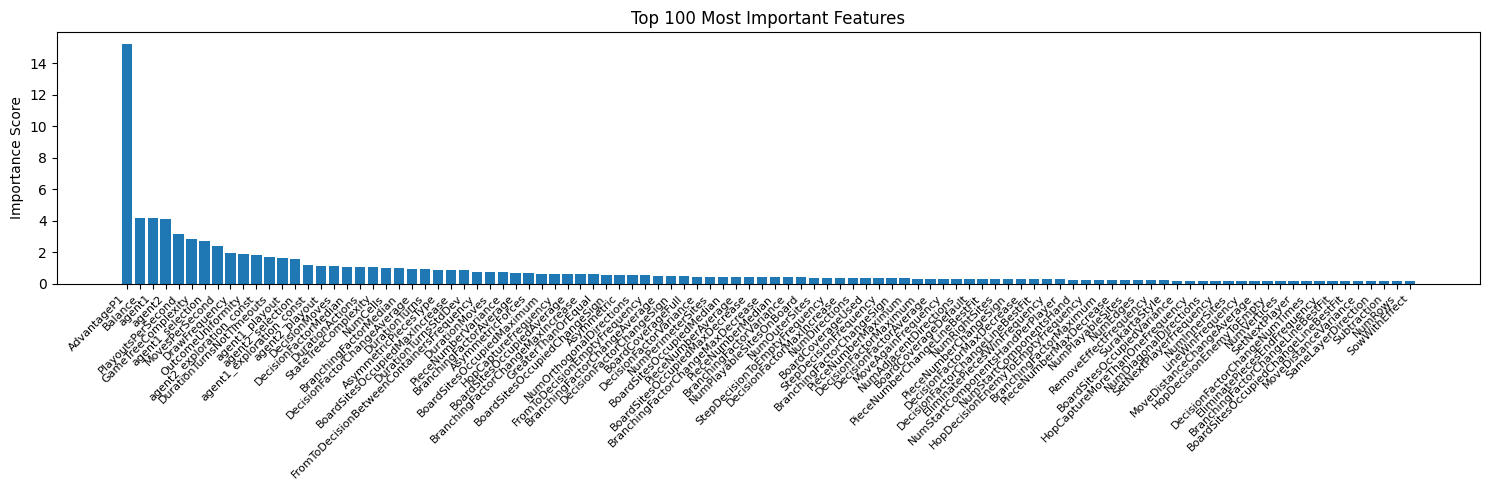

Fold 3 - RMSE: 0.4220362409580513
Fold 4


0:	learn: 0.6232567	test: 0.5971610	best: 0.5971610 (0)	total: 147ms	remaining: 24m 25s


50:	learn: 0.4849149	test: 0.5351724	best: 0.5351724 (50)	total: 5.91s	remaining: 19m 12s


100:	learn: 0.4408402	test: 0.5122143	best: 0.5122143 (100)	total: 11.8s	remaining: 19m 12s


150:	learn: 0.4169757	test: 0.4987247	best: 0.4987247 (150)	total: 17.9s	remaining: 19m 27s


200:	learn: 0.4011525	test: 0.4880041	best: 0.4880041 (200)	total: 24.2s	remaining: 19m 41s


250:	learn: 0.3876298	test: 0.4785254	best: 0.4785254 (250)	total: 30.7s	remaining: 19m 54s


300:	learn: 0.3778171	test: 0.4722105	best: 0.4722105 (300)	total: 37.4s	remaining: 20m 4s


350:	learn: 0.3691670	test: 0.4669454	best: 0.4669454 (350)	total: 44s	remaining: 20m 9s


400:	learn: 0.3616997	test: 0.4633234	best: 0.4633234 (400)	total: 50.7s	remaining: 20m 12s


450:	learn: 0.3557438	test: 0.4608930	best: 0.4608930 (450)	total: 57.3s	remaining: 20m 13s


500:	learn: 0.3499120	test: 0.4582034	best: 0.4582034 (500)	total: 1m 3s	remaining: 20m 11s


550:	learn: 0.3442677	test: 0.4556933	best: 0.4556933 (550)	total: 1m 10s	remaining: 20m 7s


600:	learn: 0.3395785	test: 0.4537989	best: 0.4537989 (600)	total: 1m 16s	remaining: 20m 1s


650:	learn: 0.3351665	test: 0.4518700	best: 0.4518700 (650)	total: 1m 23s	remaining: 19m 54s


700:	learn: 0.3307081	test: 0.4500117	best: 0.4500085 (698)	total: 1m 29s	remaining: 19m 46s


750:	learn: 0.3263610	test: 0.4484401	best: 0.4484401 (750)	total: 1m 35s	remaining: 19m 38s


800:	learn: 0.3227057	test: 0.4473528	best: 0.4473528 (800)	total: 1m 41s	remaining: 19m 31s


850:	learn: 0.3193360	test: 0.4462828	best: 0.4462828 (850)	total: 1m 48s	remaining: 19m 24s


900:	learn: 0.3161516	test: 0.4454046	best: 0.4454046 (900)	total: 1m 54s	remaining: 19m 18s


950:	learn: 0.3131759	test: 0.4445434	best: 0.4445434 (950)	total: 2m 1s	remaining: 19m 12s


1000:	learn: 0.3103149	test: 0.4436169	best: 0.4436169 (1000)	total: 2m 7s	remaining: 19m 5s


1050:	learn: 0.3075229	test: 0.4432047	best: 0.4432019 (1049)	total: 2m 13s	remaining: 19m


1100:	learn: 0.3049731	test: 0.4425679	best: 0.4425679 (1100)	total: 2m 20s	remaining: 18m 55s


1150:	learn: 0.3025520	test: 0.4420409	best: 0.4420409 (1150)	total: 2m 26s	remaining: 18m 49s


1200:	learn: 0.3002353	test: 0.4415411	best: 0.4415411 (1200)	total: 2m 33s	remaining: 18m 43s


1250:	learn: 0.2982646	test: 0.4411901	best: 0.4411837 (1249)	total: 2m 39s	remaining: 18m 38s


1300:	learn: 0.2962511	test: 0.4408445	best: 0.4408445 (1300)	total: 2m 46s	remaining: 18m 33s


1350:	learn: 0.2942478	test: 0.4403834	best: 0.4403832 (1349)	total: 2m 53s	remaining: 18m 29s


1400:	learn: 0.2922247	test: 0.4396699	best: 0.4396699 (1400)	total: 2m 59s	remaining: 18m 23s


1450:	learn: 0.2903682	test: 0.4392523	best: 0.4392523 (1450)	total: 3m 6s	remaining: 18m 19s


1500:	learn: 0.2886200	test: 0.4387135	best: 0.4387123 (1499)	total: 3m 13s	remaining: 18m 13s


1550:	learn: 0.2867710	test: 0.4382855	best: 0.4382855 (1550)	total: 3m 19s	remaining: 18m 7s


1600:	learn: 0.2851028	test: 0.4378789	best: 0.4378647 (1596)	total: 3m 26s	remaining: 18m 1s


1650:	learn: 0.2834813	test: 0.4374917	best: 0.4374906 (1649)	total: 3m 32s	remaining: 17m 55s


1700:	learn: 0.2816981	test: 0.4372338	best: 0.4372338 (1700)	total: 3m 39s	remaining: 17m 49s


1750:	learn: 0.2802214	test: 0.4369749	best: 0.4369749 (1750)	total: 3m 45s	remaining: 17m 43s


1800:	learn: 0.2787976	test: 0.4366425	best: 0.4366425 (1800)	total: 3m 52s	remaining: 17m 38s


1850:	learn: 0.2772732	test: 0.4363159	best: 0.4363159 (1850)	total: 3m 58s	remaining: 17m 31s


1900:	learn: 0.2759284	test: 0.4360482	best: 0.4360482 (1900)	total: 4m 5s	remaining: 17m 25s


1950:	learn: 0.2746163	test: 0.4357777	best: 0.4357777 (1950)	total: 4m 11s	remaining: 17m 19s


2000:	learn: 0.2732776	test: 0.4355777	best: 0.4355777 (2000)	total: 4m 18s	remaining: 17m 13s


2050:	learn: 0.2719666	test: 0.4353565	best: 0.4353565 (2050)	total: 4m 25s	remaining: 17m 7s


2100:	learn: 0.2705667	test: 0.4350744	best: 0.4350744 (2100)	total: 4m 31s	remaining: 17m


2150:	learn: 0.2693467	test: 0.4348552	best: 0.4348508 (2148)	total: 4m 38s	remaining: 16m 55s


2200:	learn: 0.2681388	test: 0.4347250	best: 0.4346789 (2180)	total: 4m 44s	remaining: 16m 49s


2250:	learn: 0.2669684	test: 0.4346329	best: 0.4346294 (2248)	total: 4m 51s	remaining: 16m 43s


2300:	learn: 0.2657920	test: 0.4342347	best: 0.4342347 (2300)	total: 4m 58s	remaining: 16m 38s


2350:	learn: 0.2645691	test: 0.4340614	best: 0.4340614 (2350)	total: 5m 4s	remaining: 16m 32s


2400:	learn: 0.2632851	test: 0.4337647	best: 0.4337647 (2400)	total: 5m 11s	remaining: 16m 25s


2450:	learn: 0.2621357	test: 0.4335683	best: 0.4335683 (2450)	total: 5m 18s	remaining: 16m 19s


2500:	learn: 0.2608471	test: 0.4333860	best: 0.4333856 (2498)	total: 5m 24s	remaining: 16m 13s


2550:	learn: 0.2596909	test: 0.4331687	best: 0.4331687 (2550)	total: 5m 31s	remaining: 16m 6s


2600:	learn: 0.2586560	test: 0.4330466	best: 0.4330466 (2600)	total: 5m 37s	remaining: 16m


2650:	learn: 0.2576404	test: 0.4328473	best: 0.4328473 (2649)	total: 5m 44s	remaining: 15m 53s


2700:	learn: 0.2566186	test: 0.4327055	best: 0.4327055 (2700)	total: 5m 50s	remaining: 15m 47s


2750:	learn: 0.2555349	test: 0.4325499	best: 0.4325475 (2748)	total: 5m 57s	remaining: 15m 41s


2800:	learn: 0.2545434	test: 0.4324045	best: 0.4324033 (2799)	total: 6m 3s	remaining: 15m 34s


2850:	learn: 0.2536327	test: 0.4322743	best: 0.4322700 (2848)	total: 6m 10s	remaining: 15m 28s


2900:	learn: 0.2525922	test: 0.4321233	best: 0.4321036 (2887)	total: 6m 16s	remaining: 15m 21s


2950:	learn: 0.2517089	test: 0.4319736	best: 0.4319735 (2949)	total: 6m 23s	remaining: 15m 15s


3000:	learn: 0.2508392	test: 0.4318417	best: 0.4318417 (3000)	total: 6m 29s	remaining: 15m 9s


3050:	learn: 0.2498920	test: 0.4316911	best: 0.4316902 (3047)	total: 6m 36s	remaining: 15m 2s


3100:	learn: 0.2489664	test: 0.4315669	best: 0.4315669 (3100)	total: 6m 42s	remaining: 14m 56s


3150:	learn: 0.2481181	test: 0.4313741	best: 0.4313741 (3150)	total: 6m 49s	remaining: 14m 50s


3200:	learn: 0.2472095	test: 0.4312330	best: 0.4312161 (3198)	total: 6m 56s	remaining: 14m 43s


3250:	learn: 0.2463394	test: 0.4311203	best: 0.4311060 (3239)	total: 7m 2s	remaining: 14m 37s


3300:	learn: 0.2454215	test: 0.4309677	best: 0.4309677 (3300)	total: 7m 9s	remaining: 14m 30s


3350:	learn: 0.2445820	test: 0.4308413	best: 0.4308413 (3350)	total: 7m 15s	remaining: 14m 24s


3400:	learn: 0.2437769	test: 0.4307196	best: 0.4307196 (3400)	total: 7m 22s	remaining: 14m 18s


3450:	learn: 0.2429857	test: 0.4306203	best: 0.4306203 (3450)	total: 7m 28s	remaining: 14m 11s


3500:	learn: 0.2421959	test: 0.4305250	best: 0.4305250 (3500)	total: 7m 35s	remaining: 14m 5s


3550:	learn: 0.2415612	test: 0.4304921	best: 0.4304850 (3533)	total: 7m 41s	remaining: 13m 58s


3600:	learn: 0.2408300	test: 0.4303216	best: 0.4303159 (3596)	total: 7m 48s	remaining: 13m 52s


3650:	learn: 0.2402397	test: 0.4302526	best: 0.4302512 (3646)	total: 7m 55s	remaining: 13m 46s


3700:	learn: 0.2395485	test: 0.4301533	best: 0.4301510 (3698)	total: 8m 1s	remaining: 13m 39s


3750:	learn: 0.2389365	test: 0.4301010	best: 0.4301004 (3738)	total: 8m 8s	remaining: 13m 33s


3800:	learn: 0.2383161	test: 0.4299926	best: 0.4299842 (3792)	total: 8m 14s	remaining: 13m 27s


3850:	learn: 0.2376114	test: 0.4298434	best: 0.4298371 (3848)	total: 8m 21s	remaining: 13m 20s


3900:	learn: 0.2368903	test: 0.4297771	best: 0.4297720 (3894)	total: 8m 27s	remaining: 13m 14s


3950:	learn: 0.2362169	test: 0.4296448	best: 0.4296432 (3949)	total: 8m 34s	remaining: 13m 7s


4000:	learn: 0.2355480	test: 0.4295758	best: 0.4295596 (3983)	total: 8m 40s	remaining: 13m


4050:	learn: 0.2348763	test: 0.4294567	best: 0.4294567 (4050)	total: 8m 47s	remaining: 12m 54s


4100:	learn: 0.2342321	test: 0.4293966	best: 0.4293966 (4100)	total: 8m 53s	remaining: 12m 47s


4150:	learn: 0.2336352	test: 0.4293261	best: 0.4293204 (4141)	total: 9m	remaining: 12m 41s


4200:	learn: 0.2329703	test: 0.4292165	best: 0.4292165 (4200)	total: 9m 6s	remaining: 12m 34s


4250:	learn: 0.2323293	test: 0.4291307	best: 0.4291281 (4249)	total: 9m 13s	remaining: 12m 28s


4300:	learn: 0.2317465	test: 0.4290863	best: 0.4290863 (4300)	total: 9m 19s	remaining: 12m 21s


4350:	learn: 0.2311959	test: 0.4290273	best: 0.4290273 (4350)	total: 9m 26s	remaining: 12m 15s


4400:	learn: 0.2306396	test: 0.4289829	best: 0.4289829 (4400)	total: 9m 33s	remaining: 12m 9s


4450:	learn: 0.2300454	test: 0.4288539	best: 0.4288530 (4446)	total: 9m 39s	remaining: 12m 2s


4500:	learn: 0.2294474	test: 0.4287642	best: 0.4287642 (4500)	total: 9m 46s	remaining: 11m 56s


4550:	learn: 0.2288578	test: 0.4287200	best: 0.4287200 (4550)	total: 9m 52s	remaining: 11m 49s


4600:	learn: 0.2282503	test: 0.4286144	best: 0.4286086 (4596)	total: 9m 59s	remaining: 11m 43s


4650:	learn: 0.2276550	test: 0.4285145	best: 0.4285098 (4647)	total: 10m 5s	remaining: 11m 36s


4700:	learn: 0.2271869	test: 0.4284556	best: 0.4284546 (4698)	total: 10m 12s	remaining: 11m 30s


4750:	learn: 0.2265511	test: 0.4284358	best: 0.4284326 (4747)	total: 10m 19s	remaining: 11m 24s


4800:	learn: 0.2260527	test: 0.4283591	best: 0.4283591 (4800)	total: 10m 25s	remaining: 11m 17s


4850:	learn: 0.2255433	test: 0.4283196	best: 0.4283196 (4850)	total: 10m 32s	remaining: 11m 11s


4900:	learn: 0.2249881	test: 0.4282565	best: 0.4282552 (4890)	total: 10m 39s	remaining: 11m 4s


4950:	learn: 0.2244310	test: 0.4282122	best: 0.4282060 (4948)	total: 10m 45s	remaining: 10m 58s


5000:	learn: 0.2239261	test: 0.4281557	best: 0.4281554 (4999)	total: 10m 52s	remaining: 10m 52s


5050:	learn: 0.2234326	test: 0.4281085	best: 0.4281085 (5050)	total: 10m 58s	remaining: 10m 45s


5100:	learn: 0.2228132	test: 0.4280673	best: 0.4280659 (5098)	total: 11m 5s	remaining: 10m 39s


5150:	learn: 0.2222500	test: 0.4280122	best: 0.4280109 (5149)	total: 11m 12s	remaining: 10m 32s


5200:	learn: 0.2217506	test: 0.4279390	best: 0.4279381 (5197)	total: 11m 19s	remaining: 10m 26s


5250:	learn: 0.2212402	test: 0.4278816	best: 0.4278816 (5250)	total: 11m 26s	remaining: 10m 20s


5300:	learn: 0.2207931	test: 0.4277987	best: 0.4277965 (5297)	total: 11m 33s	remaining: 10m 14s


5350:	learn: 0.2203614	test: 0.4277631	best: 0.4277631 (5350)	total: 11m 40s	remaining: 10m 8s


5400:	learn: 0.2198942	test: 0.4277488	best: 0.4277482 (5399)	total: 11m 47s	remaining: 10m 2s


5450:	learn: 0.2193448	test: 0.4277172	best: 0.4277091 (5439)	total: 11m 53s	remaining: 9m 55s


5500:	learn: 0.2188121	test: 0.4276599	best: 0.4276575 (5490)	total: 12m	remaining: 9m 49s


5550:	learn: 0.2182926	test: 0.4276346	best: 0.4276346 (5550)	total: 12m 7s	remaining: 9m 43s


5600:	learn: 0.2178460	test: 0.4275642	best: 0.4275604 (5599)	total: 12m 14s	remaining: 9m 37s


5650:	learn: 0.2173396	test: 0.4275062	best: 0.4275062 (5650)	total: 12m 21s	remaining: 9m 30s


5700:	learn: 0.2169075	test: 0.4274773	best: 0.4274727 (5692)	total: 12m 28s	remaining: 9m 24s


5750:	learn: 0.2164136	test: 0.4274158	best: 0.4274128 (5738)	total: 12m 35s	remaining: 9m 18s


5800:	learn: 0.2159475	test: 0.4273710	best: 0.4273710 (5800)	total: 12m 41s	remaining: 9m 11s


5850:	learn: 0.2155030	test: 0.4273580	best: 0.4273513 (5848)	total: 12m 48s	remaining: 9m 4s


5900:	learn: 0.2150340	test: 0.4272916	best: 0.4272916 (5900)	total: 12m 54s	remaining: 8m 58s


5950:	learn: 0.2145928	test: 0.4272630	best: 0.4272630 (5950)	total: 13m 1s	remaining: 8m 51s


6000:	learn: 0.2141323	test: 0.4271945	best: 0.4271945 (6000)	total: 13m 8s	remaining: 8m 45s


6050:	learn: 0.2136887	test: 0.4271583	best: 0.4271583 (6050)	total: 13m 14s	remaining: 8m 38s


6100:	learn: 0.2132678	test: 0.4271542	best: 0.4271512 (6098)	total: 13m 21s	remaining: 8m 32s


6150:	learn: 0.2127833	test: 0.4271120	best: 0.4271120 (6150)	total: 13m 27s	remaining: 8m 25s


6200:	learn: 0.2123876	test: 0.4270821	best: 0.4270806 (6197)	total: 13m 34s	remaining: 8m 19s


6250:	learn: 0.2119528	test: 0.4270740	best: 0.4270730 (6249)	total: 13m 41s	remaining: 8m 12s


6300:	learn: 0.2115497	test: 0.4270324	best: 0.4270313 (6286)	total: 13m 47s	remaining: 8m 5s


6350:	learn: 0.2111388	test: 0.4269705	best: 0.4269705 (6350)	total: 13m 54s	remaining: 7m 59s


6400:	learn: 0.2107077	test: 0.4269361	best: 0.4269361 (6400)	total: 14m	remaining: 7m 52s


6450:	learn: 0.2102263	test: 0.4269128	best: 0.4269070 (6446)	total: 14m 7s	remaining: 7m 46s


6500:	learn: 0.2098246	test: 0.4269074	best: 0.4269068 (6499)	total: 14m 13s	remaining: 7m 39s


6550:	learn: 0.2094297	test: 0.4268999	best: 0.4268999 (6550)	total: 14m 20s	remaining: 7m 33s


6600:	learn: 0.2089139	test: 0.4268989	best: 0.4268946 (6583)	total: 14m 26s	remaining: 7m 26s


6650:	learn: 0.2084702	test: 0.4268691	best: 0.4268626 (6645)	total: 14m 33s	remaining: 7m 19s


6700:	learn: 0.2080166	test: 0.4268380	best: 0.4268369 (6697)	total: 14m 40s	remaining: 7m 13s


6750:	learn: 0.2076352	test: 0.4268104	best: 0.4268104 (6750)	total: 14m 46s	remaining: 7m 6s


6800:	learn: 0.2072307	test: 0.4267828	best: 0.4267725 (6782)	total: 14m 53s	remaining: 7m


6850:	learn: 0.2068590	test: 0.4267466	best: 0.4267466 (6850)	total: 15m	remaining: 6m 53s


6900:	learn: 0.2064425	test: 0.4266903	best: 0.4266827 (6896)	total: 15m 6s	remaining: 6m 47s


6950:	learn: 0.2060168	test: 0.4266661	best: 0.4266627 (6948)	total: 15m 13s	remaining: 6m 40s


7000:	learn: 0.2056418	test: 0.4266507	best: 0.4266490 (6998)	total: 15m 19s	remaining: 6m 33s


7050:	learn: 0.2052730	test: 0.4266263	best: 0.4266258 (7036)	total: 15m 26s	remaining: 6m 27s


7100:	learn: 0.2048982	test: 0.4265966	best: 0.4265964 (7098)	total: 15m 32s	remaining: 6m 20s


7150:	learn: 0.2044679	test: 0.4265877	best: 0.4265790 (7139)	total: 15m 39s	remaining: 6m 14s


7200:	learn: 0.2041251	test: 0.4265575	best: 0.4265575 (7200)	total: 15m 45s	remaining: 6m 7s


7250:	learn: 0.2037557	test: 0.4265229	best: 0.4265229 (7250)	total: 15m 52s	remaining: 6m 1s


7300:	learn: 0.2033960	test: 0.4265101	best: 0.4265055 (7296)	total: 15m 59s	remaining: 5m 54s


7350:	learn: 0.2029902	test: 0.4264655	best: 0.4264637 (7349)	total: 16m 5s	remaining: 5m 48s


7400:	learn: 0.2025887	test: 0.4264473	best: 0.4264461 (7389)	total: 16m 12s	remaining: 5m 41s


7450:	learn: 0.2022109	test: 0.4264319	best: 0.4264304 (7448)	total: 16m 18s	remaining: 5m 34s


7500:	learn: 0.2018493	test: 0.4264044	best: 0.4264044 (7500)	total: 16m 25s	remaining: 5m 28s


7550:	learn: 0.2014544	test: 0.4263786	best: 0.4263756 (7540)	total: 16m 31s	remaining: 5m 21s


7600:	learn: 0.2010013	test: 0.4263609	best: 0.4263567 (7597)	total: 16m 38s	remaining: 5m 15s


7650:	learn: 0.2005942	test: 0.4263482	best: 0.4263389 (7642)	total: 16m 45s	remaining: 5m 8s


7700:	learn: 0.2002426	test: 0.4263403	best: 0.4263336 (7688)	total: 16m 51s	remaining: 5m 2s


7750:	learn: 0.1999088	test: 0.4263374	best: 0.4263238 (7729)	total: 16m 58s	remaining: 4m 55s


7800:	learn: 0.1995647	test: 0.4263075	best: 0.4263074 (7795)	total: 17m 5s	remaining: 4m 49s


7850:	learn: 0.1991744	test: 0.4262941	best: 0.4262928 (7836)	total: 17m 12s	remaining: 4m 42s


7900:	learn: 0.1988636	test: 0.4262855	best: 0.4262855 (7898)	total: 17m 19s	remaining: 4m 36s


7950:	learn: 0.1985423	test: 0.4262619	best: 0.4262608 (7941)	total: 17m 25s	remaining: 4m 29s


8000:	learn: 0.1981573	test: 0.4262457	best: 0.4262428 (7990)	total: 17m 32s	remaining: 4m 22s


8050:	learn: 0.1978442	test: 0.4262308	best: 0.4262238 (8047)	total: 17m 38s	remaining: 4m 16s


8100:	learn: 0.1974533	test: 0.4261987	best: 0.4261978 (8099)	total: 17m 45s	remaining: 4m 9s


8150:	learn: 0.1971342	test: 0.4261960	best: 0.4261960 (8147)	total: 17m 52s	remaining: 4m 3s


8200:	learn: 0.1967882	test: 0.4261745	best: 0.4261693 (8197)	total: 17m 58s	remaining: 3m 56s


8250:	learn: 0.1964215	test: 0.4261542	best: 0.4261463 (8233)	total: 18m 5s	remaining: 3m 50s


8300:	learn: 0.1960330	test: 0.4261303	best: 0.4261272 (8291)	total: 18m 12s	remaining: 3m 43s


8350:	learn: 0.1957160	test: 0.4261309	best: 0.4261201 (8329)	total: 18m 19s	remaining: 3m 37s


8400:	learn: 0.1952969	test: 0.4261029	best: 0.4261013 (8399)	total: 18m 25s	remaining: 3m 30s


8450:	learn: 0.1949403	test: 0.4261114	best: 0.4261013 (8399)	total: 18m 32s	remaining: 3m 23s


8500:	learn: 0.1946539	test: 0.4261026	best: 0.4260995 (8495)	total: 18m 39s	remaining: 3m 17s


8550:	learn: 0.1942812	test: 0.4260805	best: 0.4260768 (8529)	total: 18m 45s	remaining: 3m 10s


8600:	learn: 0.1939682	test: 0.4260525	best: 0.4260525 (8600)	total: 18m 52s	remaining: 3m 4s


8650:	learn: 0.1936350	test: 0.4260135	best: 0.4260135 (8650)	total: 18m 59s	remaining: 2m 57s


8700:	learn: 0.1933146	test: 0.4260053	best: 0.4260038 (8683)	total: 19m 5s	remaining: 2m 51s


8750:	learn: 0.1929526	test: 0.4259677	best: 0.4259667 (8748)	total: 19m 12s	remaining: 2m 44s


8800:	learn: 0.1925736	test: 0.4259407	best: 0.4259397 (8799)	total: 19m 19s	remaining: 2m 37s


8850:	learn: 0.1922495	test: 0.4259134	best: 0.4259134 (8850)	total: 19m 25s	remaining: 2m 31s


8900:	learn: 0.1919187	test: 0.4259057	best: 0.4259057 (8896)	total: 19m 32s	remaining: 2m 24s


8950:	learn: 0.1915716	test: 0.4258877	best: 0.4258841 (8945)	total: 19m 38s	remaining: 2m 18s


9000:	learn: 0.1912143	test: 0.4258873	best: 0.4258735 (8987)	total: 19m 45s	remaining: 2m 11s


9050:	learn: 0.1909358	test: 0.4258877	best: 0.4258710 (9028)	total: 19m 51s	remaining: 2m 4s


9100:	learn: 0.1906306	test: 0.4258945	best: 0.4258710 (9028)	total: 19m 58s	remaining: 1m 58s


9150:	learn: 0.1903018	test: 0.4258726	best: 0.4258710 (9028)	total: 20m 5s	remaining: 1m 51s


9200:	learn: 0.1899959	test: 0.4258474	best: 0.4258472 (9195)	total: 20m 11s	remaining: 1m 45s


9250:	learn: 0.1896729	test: 0.4258370	best: 0.4258366 (9249)	total: 20m 18s	remaining: 1m 38s


9300:	learn: 0.1893211	test: 0.4258284	best: 0.4258244 (9295)	total: 20m 25s	remaining: 1m 32s


9350:	learn: 0.1890046	test: 0.4258228	best: 0.4258112 (9334)	total: 20m 31s	remaining: 1m 25s


9400:	learn: 0.1886483	test: 0.4258256	best: 0.4258099 (9379)	total: 20m 38s	remaining: 1m 18s


9450:	learn: 0.1883238	test: 0.4257934	best: 0.4257934 (9450)	total: 20m 45s	remaining: 1m 12s


9500:	learn: 0.1879737	test: 0.4257677	best: 0.4257665 (9498)	total: 20m 51s	remaining: 1m 5s


9550:	learn: 0.1876656	test: 0.4257596	best: 0.4257512 (9549)	total: 20m 58s	remaining: 59.2s


9600:	learn: 0.1873382	test: 0.4257426	best: 0.4257395 (9585)	total: 21m 5s	remaining: 52.6s


9650:	learn: 0.1870253	test: 0.4257113	best: 0.4257113 (9650)	total: 21m 12s	remaining: 46s


9700:	learn: 0.1867345	test: 0.4256807	best: 0.4256807 (9700)	total: 21m 19s	remaining: 39.4s


9750:	learn: 0.1864026	test: 0.4256499	best: 0.4256499 (9750)	total: 21m 25s	remaining: 32.8s


9800:	learn: 0.1860435	test: 0.4256337	best: 0.4256337 (9800)	total: 21m 32s	remaining: 26.2s


9850:	learn: 0.1857579	test: 0.4256046	best: 0.4256046 (9850)	total: 21m 39s	remaining: 19.7s


9900:	learn: 0.1854558	test: 0.4256069	best: 0.4256042 (9851)	total: 21m 46s	remaining: 13.1s


9950:	learn: 0.1851278	test: 0.4256025	best: 0.4256006 (9915)	total: 21m 52s	remaining: 6.46s


9999:	learn: 0.1848613	test: 0.4255984	best: 0.4255984 (9999)	total: 21m 59s	remaining: 0us

bestTest = 0.4255983807
bestIteration = 9999



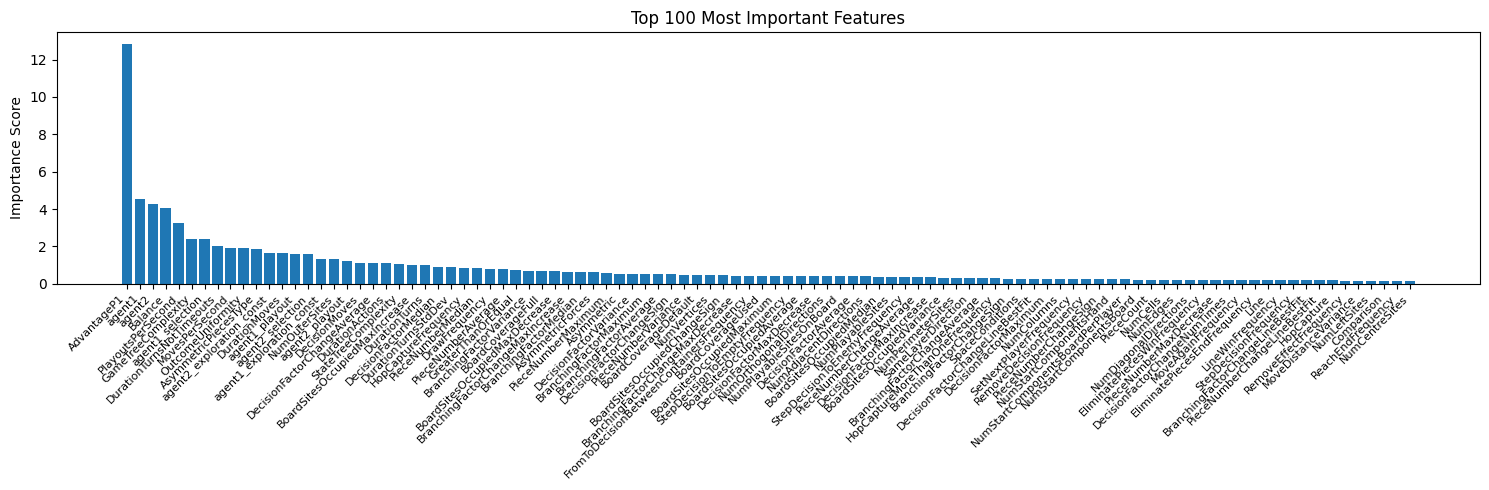

Fold 4 - RMSE: 0.42519154477166426
Fold 5


0:	learn: 0.6350734	test: 0.5477611	best: 0.5477611 (0)	total: 110ms	remaining: 18m 22s


50:	learn: 0.4972732	test: 0.5075430	best: 0.5075430 (50)	total: 6.17s	remaining: 20m 3s


100:	learn: 0.4498601	test: 0.4843041	best: 0.4843041 (100)	total: 12.3s	remaining: 20m 7s


150:	learn: 0.4242250	test: 0.4665761	best: 0.4665761 (150)	total: 18.7s	remaining: 20m 21s


200:	learn: 0.4085972	test: 0.4548321	best: 0.4548321 (200)	total: 25.4s	remaining: 20m 40s


250:	learn: 0.3959608	test: 0.4466566	best: 0.4466566 (250)	total: 32.4s	remaining: 20m 58s


300:	learn: 0.3854770	test: 0.4407384	best: 0.4407384 (300)	total: 39.5s	remaining: 21m 13s


350:	learn: 0.3767811	test: 0.4360760	best: 0.4360760 (350)	total: 46.6s	remaining: 21m 22s


400:	learn: 0.3697677	test: 0.4324508	best: 0.4324508 (400)	total: 53.6s	remaining: 21m 23s


450:	learn: 0.3634219	test: 0.4296816	best: 0.4296816 (450)	total: 1m	remaining: 21m 24s


500:	learn: 0.3578587	test: 0.4273233	best: 0.4273233 (500)	total: 1m 7s	remaining: 21m 19s


550:	learn: 0.3520927	test: 0.4243826	best: 0.4243826 (550)	total: 1m 14s	remaining: 21m 14s


600:	learn: 0.3466278	test: 0.4214505	best: 0.4214505 (600)	total: 1m 20s	remaining: 21m 5s


650:	learn: 0.3421515	test: 0.4196354	best: 0.4196354 (650)	total: 1m 27s	remaining: 20m 59s


700:	learn: 0.3383542	test: 0.4182087	best: 0.4182087 (700)	total: 1m 34s	remaining: 20m 55s


750:	learn: 0.3343603	test: 0.4170090	best: 0.4170003 (749)	total: 1m 41s	remaining: 20m 53s


800:	learn: 0.3310834	test: 0.4159415	best: 0.4159415 (800)	total: 1m 49s	remaining: 20m 52s


850:	learn: 0.3276608	test: 0.4148700	best: 0.4148700 (850)	total: 1m 55s	remaining: 20m 46s


900:	learn: 0.3246514	test: 0.4138469	best: 0.4138352 (898)	total: 2m 3s	remaining: 20m 42s


950:	learn: 0.3218651	test: 0.4131250	best: 0.4131250 (950)	total: 2m 10s	remaining: 20m 38s


1000:	learn: 0.3191463	test: 0.4123692	best: 0.4123692 (1000)	total: 2m 17s	remaining: 20m 35s


1050:	learn: 0.3166180	test: 0.4115990	best: 0.4115990 (1050)	total: 2m 24s	remaining: 20m 29s


1100:	learn: 0.3140970	test: 0.4110584	best: 0.4110584 (1100)	total: 2m 31s	remaining: 20m 23s


1150:	learn: 0.3116388	test: 0.4104561	best: 0.4104561 (1150)	total: 2m 38s	remaining: 20m 15s


1200:	learn: 0.3093406	test: 0.4100756	best: 0.4100756 (1200)	total: 2m 44s	remaining: 20m 7s


1250:	learn: 0.3072955	test: 0.4095907	best: 0.4095907 (1250)	total: 2m 51s	remaining: 20m


1300:	learn: 0.3051296	test: 0.4091323	best: 0.4091323 (1300)	total: 2m 58s	remaining: 19m 53s


1350:	learn: 0.3029757	test: 0.4087423	best: 0.4087417 (1348)	total: 3m 5s	remaining: 19m 45s


1400:	learn: 0.3011505	test: 0.4083529	best: 0.4083529 (1400)	total: 3m 12s	remaining: 19m 38s


1450:	learn: 0.2994347	test: 0.4080243	best: 0.4080202 (1449)	total: 3m 18s	remaining: 19m 31s


1500:	learn: 0.2976773	test: 0.4075461	best: 0.4075461 (1500)	total: 3m 25s	remaining: 19m 25s


1550:	learn: 0.2958658	test: 0.4073162	best: 0.4073150 (1549)	total: 3m 32s	remaining: 19m 17s


1600:	learn: 0.2940469	test: 0.4070863	best: 0.4070802 (1599)	total: 3m 39s	remaining: 19m 10s


1650:	learn: 0.2923991	test: 0.4068517	best: 0.4068517 (1650)	total: 3m 46s	remaining: 19m 3s


1700:	learn: 0.2904919	test: 0.4065546	best: 0.4065546 (1700)	total: 3m 52s	remaining: 18m 55s


1750:	learn: 0.2889191	test: 0.4063277	best: 0.4063277 (1750)	total: 3m 59s	remaining: 18m 47s


1800:	learn: 0.2873786	test: 0.4061228	best: 0.4061166 (1799)	total: 4m 6s	remaining: 18m 40s


1850:	learn: 0.2858525	test: 0.4057702	best: 0.4057702 (1850)	total: 4m 12s	remaining: 18m 33s


1900:	learn: 0.2844548	test: 0.4054157	best: 0.4054157 (1900)	total: 4m 19s	remaining: 18m 26s


1950:	learn: 0.2829314	test: 0.4051280	best: 0.4051248 (1949)	total: 4m 26s	remaining: 18m 19s


2000:	learn: 0.2815578	test: 0.4048053	best: 0.4048018 (1993)	total: 4m 33s	remaining: 18m 13s


2050:	learn: 0.2802083	test: 0.4045900	best: 0.4045900 (2050)	total: 4m 40s	remaining: 18m 6s


2100:	learn: 0.2788644	test: 0.4043130	best: 0.4043017 (2098)	total: 4m 47s	remaining: 17m 59s


2150:	learn: 0.2775824	test: 0.4041050	best: 0.4041013 (2149)	total: 4m 53s	remaining: 17m 52s


2200:	learn: 0.2761628	test: 0.4038625	best: 0.4038625 (2200)	total: 5m	remaining: 17m 45s


2250:	learn: 0.2748486	test: 0.4036551	best: 0.4036516 (2249)	total: 5m 7s	remaining: 17m 38s


2300:	learn: 0.2735527	test: 0.4034938	best: 0.4034905 (2299)	total: 5m 14s	remaining: 17m 31s


2350:	learn: 0.2724067	test: 0.4033064	best: 0.4033064 (2350)	total: 5m 21s	remaining: 17m 24s


2400:	learn: 0.2712321	test: 0.4031174	best: 0.4031159 (2399)	total: 5m 27s	remaining: 17m 17s


2450:	learn: 0.2700956	test: 0.4029588	best: 0.4029588 (2450)	total: 5m 34s	remaining: 17m 10s


2500:	learn: 0.2688033	test: 0.4027312	best: 0.4027278 (2499)	total: 5m 41s	remaining: 17m 3s


2550:	learn: 0.2678072	test: 0.4025444	best: 0.4025438 (2543)	total: 5m 48s	remaining: 16m 57s


2600:	learn: 0.2668187	test: 0.4023501	best: 0.4023340 (2593)	total: 5m 55s	remaining: 16m 51s


2650:	learn: 0.2657062	test: 0.4022338	best: 0.4022338 (2650)	total: 6m 2s	remaining: 16m 44s


2700:	learn: 0.2645936	test: 0.4021214	best: 0.4021192 (2698)	total: 6m 9s	remaining: 16m 37s


2750:	learn: 0.2634836	test: 0.4019812	best: 0.4019812 (2749)	total: 6m 15s	remaining: 16m 30s


2800:	learn: 0.2624142	test: 0.4018543	best: 0.4018334 (2796)	total: 6m 22s	remaining: 16m 23s


2850:	learn: 0.2613942	test: 0.4016505	best: 0.4016505 (2850)	total: 6m 29s	remaining: 16m 16s


2900:	learn: 0.2604097	test: 0.4015379	best: 0.4015214 (2887)	total: 6m 36s	remaining: 16m 10s


2950:	learn: 0.2593789	test: 0.4014061	best: 0.4014061 (2950)	total: 6m 43s	remaining: 16m 3s


3000:	learn: 0.2583308	test: 0.4012783	best: 0.4012525 (2989)	total: 6m 50s	remaining: 15m 56s


3050:	learn: 0.2574110	test: 0.4012256	best: 0.4012055 (3044)	total: 6m 57s	remaining: 15m 49s


3100:	learn: 0.2565435	test: 0.4011783	best: 0.4011783 (3100)	total: 7m 3s	remaining: 15m 42s


3150:	learn: 0.2555896	test: 0.4010757	best: 0.4010757 (3150)	total: 7m 10s	remaining: 15m 35s


3200:	learn: 0.2547522	test: 0.4009910	best: 0.4009910 (3200)	total: 7m 17s	remaining: 15m 29s


3250:	learn: 0.2538573	test: 0.4008751	best: 0.4008751 (3250)	total: 7m 24s	remaining: 15m 23s


3300:	learn: 0.2530037	test: 0.4008350	best: 0.4008350 (3300)	total: 7m 31s	remaining: 15m 16s


3350:	learn: 0.2521350	test: 0.4006980	best: 0.4006951 (3349)	total: 7m 38s	remaining: 15m 9s


3400:	learn: 0.2514010	test: 0.4006258	best: 0.4006244 (3398)	total: 7m 45s	remaining: 15m 3s


3450:	learn: 0.2506661	test: 0.4005837	best: 0.4005812 (3449)	total: 7m 52s	remaining: 14m 57s


3500:	learn: 0.2498731	test: 0.4005072	best: 0.4005042 (3499)	total: 7m 59s	remaining: 14m 50s


3550:	learn: 0.2491204	test: 0.4004314	best: 0.4004207 (3544)	total: 8m 6s	remaining: 14m 44s


3600:	learn: 0.2483175	test: 0.4003465	best: 0.4003270 (3593)	total: 8m 14s	remaining: 14m 38s


3650:	learn: 0.2475888	test: 0.4002383	best: 0.4002383 (3650)	total: 8m 21s	remaining: 14m 32s


3700:	learn: 0.2468419	test: 0.4001617	best: 0.4001617 (3700)	total: 8m 28s	remaining: 14m 25s


3750:	learn: 0.2460939	test: 0.4001044	best: 0.4000791 (3744)	total: 8m 35s	remaining: 14m 19s


3800:	learn: 0.2452949	test: 0.4000577	best: 0.4000288 (3792)	total: 8m 42s	remaining: 14m 12s


3850:	learn: 0.2446064	test: 0.3999819	best: 0.3999819 (3850)	total: 8m 50s	remaining: 14m 6s


3900:	learn: 0.2439068	test: 0.3999462	best: 0.3999123 (3892)	total: 8m 57s	remaining: 13m 59s


3950:	learn: 0.2432060	test: 0.3998291	best: 0.3998291 (3950)	total: 9m 4s	remaining: 13m 53s


4000:	learn: 0.2424547	test: 0.3997440	best: 0.3997416 (3998)	total: 9m 11s	remaining: 13m 46s


4050:	learn: 0.2417553	test: 0.3996283	best: 0.3996249 (4047)	total: 9m 18s	remaining: 13m 39s


4100:	learn: 0.2410549	test: 0.3995187	best: 0.3995187 (4100)	total: 9m 25s	remaining: 13m 33s


4150:	learn: 0.2403847	test: 0.3994848	best: 0.3994836 (4149)	total: 9m 32s	remaining: 13m 27s


4200:	learn: 0.2397548	test: 0.3993985	best: 0.3993985 (4200)	total: 9m 40s	remaining: 13m 20s


4250:	learn: 0.2390677	test: 0.3993097	best: 0.3993017 (4230)	total: 9m 46s	remaining: 13m 13s


4300:	learn: 0.2384863	test: 0.3992442	best: 0.3992438 (4299)	total: 9m 54s	remaining: 13m 7s


4350:	learn: 0.2378893	test: 0.3992033	best: 0.3992033 (4350)	total: 10m 1s	remaining: 13m


4400:	learn: 0.2373359	test: 0.3991141	best: 0.3991141 (4400)	total: 10m 8s	remaining: 12m 53s


4450:	learn: 0.2366695	test: 0.3990668	best: 0.3990514 (4445)	total: 10m 15s	remaining: 12m 46s


4500:	learn: 0.2360727	test: 0.3990118	best: 0.3990118 (4500)	total: 10m 22s	remaining: 12m 40s


4550:	learn: 0.2355030	test: 0.3989426	best: 0.3989426 (4550)	total: 10m 29s	remaining: 12m 33s


4600:	learn: 0.2348732	test: 0.3988842	best: 0.3988842 (4600)	total: 10m 36s	remaining: 12m 26s


4650:	learn: 0.2343203	test: 0.3987987	best: 0.3987957 (4649)	total: 10m 43s	remaining: 12m 20s


4700:	learn: 0.2337891	test: 0.3987401	best: 0.3987335 (4691)	total: 10m 50s	remaining: 12m 13s


4750:	learn: 0.2331834	test: 0.3986918	best: 0.3986918 (4750)	total: 10m 57s	remaining: 12m 6s


4800:	learn: 0.2326024	test: 0.3986465	best: 0.3986393 (4784)	total: 11m 4s	remaining: 11m 59s


4850:	learn: 0.2320219	test: 0.3985896	best: 0.3985896 (4850)	total: 11m 11s	remaining: 11m 52s


4900:	learn: 0.2314808	test: 0.3985610	best: 0.3985373 (4886)	total: 11m 18s	remaining: 11m 45s


4950:	learn: 0.2309488	test: 0.3985967	best: 0.3985373 (4886)	total: 11m 25s	remaining: 11m 38s


5000:	learn: 0.2304156	test: 0.3984993	best: 0.3984993 (5000)	total: 11m 32s	remaining: 11m 32s


5050:	learn: 0.2298248	test: 0.3984616	best: 0.3984513 (5036)	total: 11m 39s	remaining: 11m 25s


5100:	learn: 0.2292153	test: 0.3984148	best: 0.3984127 (5098)	total: 11m 46s	remaining: 11m 18s


5150:	learn: 0.2287011	test: 0.3983760	best: 0.3983675 (5140)	total: 11m 53s	remaining: 11m 11s


5200:	learn: 0.2280906	test: 0.3983873	best: 0.3983673 (5158)	total: 11m 59s	remaining: 11m 4s


5250:	learn: 0.2275529	test: 0.3983210	best: 0.3983210 (5250)	total: 12m 6s	remaining: 10m 57s


5300:	learn: 0.2269924	test: 0.3982639	best: 0.3982639 (5300)	total: 12m 13s	remaining: 10m 50s


5350:	learn: 0.2265070	test: 0.3982420	best: 0.3982385 (5341)	total: 12m 20s	remaining: 10m 43s


5400:	learn: 0.2259757	test: 0.3982024	best: 0.3981927 (5396)	total: 12m 27s	remaining: 10m 36s


5450:	learn: 0.2254421	test: 0.3981788	best: 0.3981733 (5446)	total: 12m 33s	remaining: 10m 29s


5500:	learn: 0.2249304	test: 0.3981492	best: 0.3981492 (5500)	total: 12m 40s	remaining: 10m 22s


5550:	learn: 0.2244318	test: 0.3981252	best: 0.3981190 (5543)	total: 12m 47s	remaining: 10m 15s


5600:	learn: 0.2239545	test: 0.3981143	best: 0.3980941 (5575)	total: 12m 54s	remaining: 10m 8s


5650:	learn: 0.2234102	test: 0.3980898	best: 0.3980865 (5631)	total: 13m 1s	remaining: 10m 1s


5700:	learn: 0.2229681	test: 0.3981051	best: 0.3980865 (5631)	total: 13m 8s	remaining: 9m 54s


5750:	learn: 0.2224129	test: 0.3980373	best: 0.3980373 (5750)	total: 13m 15s	remaining: 9m 47s


5800:	learn: 0.2219484	test: 0.3980138	best: 0.3980138 (5800)	total: 13m 22s	remaining: 9m 40s


5850:	learn: 0.2214576	test: 0.3979611	best: 0.3979611 (5850)	total: 13m 29s	remaining: 9m 34s


5900:	learn: 0.2209672	test: 0.3979549	best: 0.3979481 (5871)	total: 13m 36s	remaining: 9m 27s


5950:	learn: 0.2204336	test: 0.3979122	best: 0.3979122 (5950)	total: 13m 43s	remaining: 9m 20s


6000:	learn: 0.2199784	test: 0.3979356	best: 0.3979064 (5961)	total: 13m 50s	remaining: 9m 13s


6050:	learn: 0.2194607	test: 0.3978685	best: 0.3978650 (6048)	total: 13m 57s	remaining: 9m 6s


6100:	learn: 0.2189849	test: 0.3978694	best: 0.3978650 (6048)	total: 14m 4s	remaining: 8m 59s


6150:	learn: 0.2185432	test: 0.3978345	best: 0.3978280 (6138)	total: 14m 11s	remaining: 8m 52s


6200:	learn: 0.2180906	test: 0.3978505	best: 0.3978280 (6138)	total: 14m 18s	remaining: 8m 45s


6250:	learn: 0.2176176	test: 0.3978458	best: 0.3978280 (6138)	total: 14m 25s	remaining: 8m 39s


6300:	learn: 0.2171605	test: 0.3978142	best: 0.3978142 (6300)	total: 14m 32s	remaining: 8m 32s


6350:	learn: 0.2166811	test: 0.3977825	best: 0.3977623 (6338)	total: 14m 39s	remaining: 8m 25s


6400:	learn: 0.2162696	test: 0.3977659	best: 0.3977623 (6338)	total: 14m 46s	remaining: 8m 18s


6450:	learn: 0.2158426	test: 0.3977562	best: 0.3977539 (6446)	total: 14m 53s	remaining: 8m 11s


6500:	learn: 0.2154316	test: 0.3977607	best: 0.3977501 (6465)	total: 15m	remaining: 8m 4s


6550:	learn: 0.2149864	test: 0.3977267	best: 0.3977267 (6550)	total: 15m 8s	remaining: 7m 58s


6600:	learn: 0.2145308	test: 0.3977261	best: 0.3977219 (6585)	total: 15m 15s	remaining: 7m 51s


6650:	learn: 0.2141280	test: 0.3977286	best: 0.3977219 (6585)	total: 15m 22s	remaining: 7m 44s


6700:	learn: 0.2136663	test: 0.3977045	best: 0.3977002 (6695)	total: 15m 28s	remaining: 7m 37s


6750:	learn: 0.2132180	test: 0.3976972	best: 0.3976813 (6728)	total: 15m 35s	remaining: 7m 30s


6800:	learn: 0.2128082	test: 0.3976368	best: 0.3976362 (6799)	total: 15m 42s	remaining: 7m 23s


6850:	learn: 0.2124077	test: 0.3976319	best: 0.3976244 (6806)	total: 15m 49s	remaining: 7m 16s


6900:	learn: 0.2119810	test: 0.3976347	best: 0.3976175 (6867)	total: 15m 56s	remaining: 7m 9s


6950:	learn: 0.2116283	test: 0.3976345	best: 0.3976175 (6867)	total: 16m 3s	remaining: 7m 2s


7000:	learn: 0.2111665	test: 0.3976239	best: 0.3976062 (6982)	total: 16m 10s	remaining: 6m 55s


7050:	learn: 0.2107475	test: 0.3976327	best: 0.3976062 (6982)	total: 16m 17s	remaining: 6m 48s


7100:	learn: 0.2103588	test: 0.3976048	best: 0.3976048 (7100)	total: 16m 24s	remaining: 6m 41s


7150:	learn: 0.2099588	test: 0.3975919	best: 0.3975875 (7132)	total: 16m 31s	remaining: 6m 34s


7200:	learn: 0.2095040	test: 0.3975675	best: 0.3975660 (7198)	total: 16m 38s	remaining: 6m 28s


7250:	learn: 0.2091001	test: 0.3975503	best: 0.3975502 (7249)	total: 16m 45s	remaining: 6m 21s


7300:	learn: 0.2086601	test: 0.3975511	best: 0.3975438 (7274)	total: 16m 52s	remaining: 6m 14s


7350:	learn: 0.2082134	test: 0.3975488	best: 0.3975388 (7327)	total: 16m 59s	remaining: 6m 7s


7400:	learn: 0.2078486	test: 0.3975241	best: 0.3975239 (7399)	total: 17m 6s	remaining: 6m


7450:	learn: 0.2074401	test: 0.3974910	best: 0.3974876 (7444)	total: 17m 13s	remaining: 5m 53s


7500:	learn: 0.2069888	test: 0.3974364	best: 0.3974354 (7499)	total: 17m 20s	remaining: 5m 46s


7550:	learn: 0.2066367	test: 0.3974218	best: 0.3974210 (7534)	total: 17m 27s	remaining: 5m 39s


7600:	learn: 0.2062599	test: 0.3974058	best: 0.3973988 (7572)	total: 17m 34s	remaining: 5m 32s


7650:	learn: 0.2058459	test: 0.3973800	best: 0.3973756 (7631)	total: 17m 41s	remaining: 5m 25s


7700:	learn: 0.2054835	test: 0.3973782	best: 0.3973707 (7695)	total: 17m 48s	remaining: 5m 18s


7750:	learn: 0.2050776	test: 0.3973519	best: 0.3973430 (7743)	total: 17m 55s	remaining: 5m 12s


7800:	learn: 0.2047156	test: 0.3973295	best: 0.3973259 (7797)	total: 18m 2s	remaining: 5m 5s


7850:	learn: 0.2043247	test: 0.3973174	best: 0.3973155 (7816)	total: 18m 9s	remaining: 4m 58s


7900:	learn: 0.2039643	test: 0.3973040	best: 0.3972966 (7873)	total: 18m 15s	remaining: 4m 51s


7950:	learn: 0.2035360	test: 0.3972793	best: 0.3972793 (7950)	total: 18m 22s	remaining: 4m 44s


8000:	learn: 0.2032153	test: 0.3972634	best: 0.3972634 (8000)	total: 18m 29s	remaining: 4m 37s


8050:	learn: 0.2028371	test: 0.3972682	best: 0.3972542 (8033)	total: 18m 36s	remaining: 4m 30s


8100:	learn: 0.2024643	test: 0.3972568	best: 0.3972451 (8092)	total: 18m 42s	remaining: 4m 23s


8150:	learn: 0.2020257	test: 0.3972357	best: 0.3972222 (8142)	total: 18m 49s	remaining: 4m 16s


8200:	learn: 0.2016648	test: 0.3972131	best: 0.3972091 (8197)	total: 18m 56s	remaining: 4m 9s


8250:	learn: 0.2012714	test: 0.3972118	best: 0.3972091 (8197)	total: 19m 3s	remaining: 4m 2s


8300:	learn: 0.2008975	test: 0.3971676	best: 0.3971676 (8300)	total: 19m 9s	remaining: 3m 55s


8350:	learn: 0.2005323	test: 0.3971634	best: 0.3971535 (8320)	total: 19m 16s	remaining: 3m 48s


8400:	learn: 0.2001809	test: 0.3971468	best: 0.3971456 (8393)	total: 19m 23s	remaining: 3m 41s


8450:	learn: 0.1998278	test: 0.3971354	best: 0.3971354 (8450)	total: 19m 30s	remaining: 3m 34s


8500:	learn: 0.1995034	test: 0.3971411	best: 0.3971349 (8453)	total: 19m 37s	remaining: 3m 27s


8550:	learn: 0.1992109	test: 0.3971334	best: 0.3971253 (8527)	total: 19m 44s	remaining: 3m 20s


8600:	learn: 0.1988628	test: 0.3971104	best: 0.3971083 (8588)	total: 19m 50s	remaining: 3m 13s


8650:	learn: 0.1984456	test: 0.3971136	best: 0.3971038 (8616)	total: 19m 57s	remaining: 3m 6s


8700:	learn: 0.1981059	test: 0.3971057	best: 0.3971013 (8668)	total: 20m 4s	remaining: 2m 59s


8750:	learn: 0.1977689	test: 0.3970624	best: 0.3970624 (8750)	total: 20m 11s	remaining: 2m 52s


8800:	learn: 0.1974664	test: 0.3970490	best: 0.3970490 (8800)	total: 20m 17s	remaining: 2m 45s


8850:	learn: 0.1971282	test: 0.3970415	best: 0.3970338 (8836)	total: 20m 24s	remaining: 2m 38s


8900:	learn: 0.1967722	test: 0.3970408	best: 0.3970337 (8865)	total: 20m 31s	remaining: 2m 32s


8950:	learn: 0.1964304	test: 0.3970140	best: 0.3970099 (8942)	total: 20m 38s	remaining: 2m 25s


9000:	learn: 0.1960467	test: 0.3970185	best: 0.3970037 (8968)	total: 20m 44s	remaining: 2m 18s


9050:	learn: 0.1957422	test: 0.3970103	best: 0.3970037 (8968)	total: 20m 51s	remaining: 2m 11s


9100:	learn: 0.1954241	test: 0.3970124	best: 0.3969993 (9086)	total: 20m 58s	remaining: 2m 4s


9150:	learn: 0.1950712	test: 0.3969907	best: 0.3969907 (9150)	total: 21m 4s	remaining: 1m 57s


9200:	learn: 0.1947725	test: 0.3969796	best: 0.3969754 (9189)	total: 21m 11s	remaining: 1m 50s


9250:	learn: 0.1944484	test: 0.3969768	best: 0.3969754 (9189)	total: 21m 18s	remaining: 1m 43s


9300:	learn: 0.1941262	test: 0.3969498	best: 0.3969447 (9297)	total: 21m 25s	remaining: 1m 36s


9350:	learn: 0.1938117	test: 0.3969342	best: 0.3969330 (9346)	total: 21m 31s	remaining: 1m 29s


9400:	learn: 0.1934553	test: 0.3969217	best: 0.3969173 (9384)	total: 21m 38s	remaining: 1m 22s


9450:	learn: 0.1930945	test: 0.3969369	best: 0.3969173 (9384)	total: 21m 45s	remaining: 1m 15s


9500:	learn: 0.1927550	test: 0.3969268	best: 0.3969173 (9384)	total: 21m 52s	remaining: 1m 8s


9550:	learn: 0.1924314	test: 0.3969192	best: 0.3969173 (9384)	total: 21m 59s	remaining: 1m 2s


9600:	learn: 0.1920830	test: 0.3969130	best: 0.3969067 (9593)	total: 22m 5s	remaining: 55.1s


9650:	learn: 0.1917437	test: 0.3969110	best: 0.3969067 (9593)	total: 22m 12s	remaining: 48.2s


9700:	learn: 0.1913942	test: 0.3969029	best: 0.3969029 (9700)	total: 22m 19s	remaining: 41.3s


9750:	learn: 0.1910402	test: 0.3969029	best: 0.3968944 (9732)	total: 22m 26s	remaining: 34.4s


9800:	learn: 0.1907225	test: 0.3968675	best: 0.3968632 (9792)	total: 22m 32s	remaining: 27.5s


9850:	learn: 0.1903892	test: 0.3968631	best: 0.3968554 (9832)	total: 22m 39s	remaining: 20.6s


9900:	learn: 0.1900814	test: 0.3968617	best: 0.3968554 (9832)	total: 22m 46s	remaining: 13.7s


9950:	learn: 0.1897508	test: 0.3968425	best: 0.3968415 (9949)	total: 22m 53s	remaining: 6.76s


9999:	learn: 0.1893895	test: 0.3968371	best: 0.3968280 (9981)	total: 22m 59s	remaining: 0us

bestTest = 0.3968280251
bestIteration = 9981

Shrink model to first 9982 iterations.


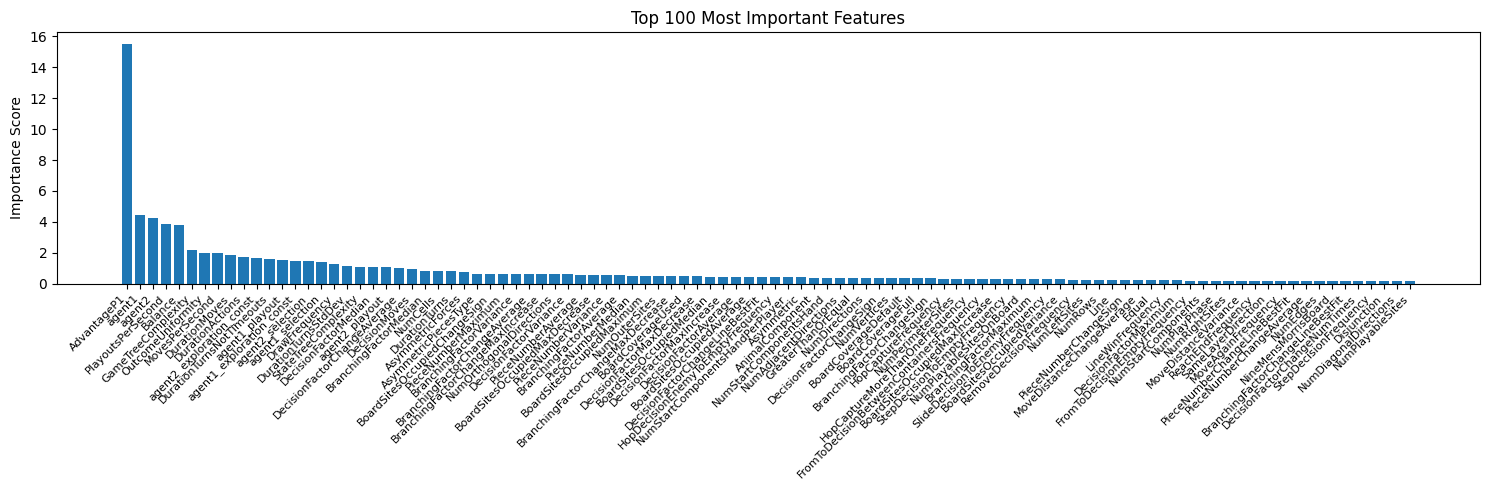

Fold 5 - RMSE: 0.39650007014533684
List of oof scores: [0.4129550298106016, 0.4290280153961056, 0.4220362409580513, 0.42519154477166426, 0.39650007014533684]
Average oof score: 0.4171421802163519


In [11]:
# call the function
trained_models1, oof1, oof_scores1, importance_df1 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    split_list=split1,
)
# save oof predictions
oof1.to_parquet(path_results / f'oof_catboost_{fs_type}_cv1.parquet', index=False)

# save feature importance
# importance_df1.to_csv(path_results / 'feat_importance_catboost_cv1.csv', index=False)

Fold 1


0:	learn: 0.6366680	test: 0.5358185	best: 0.5358185 (0)	total: 119ms	remaining: 19m 49s


50:	learn: 0.4959139	test: 0.4927303	best: 0.4927303 (50)	total: 5.75s	remaining: 18m 41s


100:	learn: 0.4487834	test: 0.4744699	best: 0.4744699 (100)	total: 11.6s	remaining: 18m 54s


150:	learn: 0.4226367	test: 0.4629521	best: 0.4629521 (150)	total: 17.5s	remaining: 19m 2s


200:	learn: 0.4066801	test: 0.4546256	best: 0.4546256 (200)	total: 24s	remaining: 19m 30s


250:	learn: 0.3943288	test: 0.4479197	best: 0.4479197 (250)	total: 30.6s	remaining: 19m 48s


300:	learn: 0.3842665	test: 0.4436029	best: 0.4436029 (300)	total: 37.1s	remaining: 19m 54s


350:	learn: 0.3749607	test: 0.4390015	best: 0.4390015 (350)	total: 43.6s	remaining: 19m 59s


400:	learn: 0.3678269	test: 0.4364765	best: 0.4364765 (400)	total: 50.3s	remaining: 20m 3s


450:	learn: 0.3613155	test: 0.4343161	best: 0.4343161 (450)	total: 56.9s	remaining: 20m 5s


500:	learn: 0.3554647	test: 0.4323701	best: 0.4323701 (500)	total: 1m 3s	remaining: 20m 2s


550:	learn: 0.3498418	test: 0.4306548	best: 0.4306548 (550)	total: 1m 9s	remaining: 19m 56s


600:	learn: 0.3441243	test: 0.4284626	best: 0.4284626 (600)	total: 1m 15s	remaining: 19m 48s


650:	learn: 0.3395890	test: 0.4269035	best: 0.4269035 (650)	total: 1m 22s	remaining: 19m 42s


700:	learn: 0.3349866	test: 0.4253700	best: 0.4253700 (700)	total: 1m 28s	remaining: 19m 34s


750:	learn: 0.3309843	test: 0.4242869	best: 0.4242869 (750)	total: 1m 34s	remaining: 19m 27s


800:	learn: 0.3266959	test: 0.4233089	best: 0.4233089 (800)	total: 1m 40s	remaining: 19m 19s


850:	learn: 0.3228464	test: 0.4223355	best: 0.4223355 (850)	total: 1m 47s	remaining: 19m 12s


900:	learn: 0.3194612	test: 0.4216070	best: 0.4215995 (899)	total: 1m 53s	remaining: 19m 5s


950:	learn: 0.3162366	test: 0.4209332	best: 0.4209125 (948)	total: 1m 59s	remaining: 18m 59s


1000:	learn: 0.3132622	test: 0.4203728	best: 0.4203728 (1000)	total: 2m 6s	remaining: 18m 53s


1050:	learn: 0.3104268	test: 0.4199890	best: 0.4199697 (1044)	total: 2m 12s	remaining: 18m 48s


1100:	learn: 0.3078841	test: 0.4195723	best: 0.4195723 (1100)	total: 2m 19s	remaining: 18m 43s


1150:	learn: 0.3053796	test: 0.4190952	best: 0.4190952 (1150)	total: 2m 25s	remaining: 18m 38s


1200:	learn: 0.3029147	test: 0.4185000	best: 0.4184943 (1198)	total: 2m 31s	remaining: 18m 32s


1250:	learn: 0.3004379	test: 0.4181099	best: 0.4181024 (1249)	total: 2m 38s	remaining: 18m 26s


1300:	learn: 0.2980457	test: 0.4177035	best: 0.4177035 (1300)	total: 2m 44s	remaining: 18m 19s


1350:	learn: 0.2957947	test: 0.4174096	best: 0.4174096 (1350)	total: 2m 50s	remaining: 18m 12s


1400:	learn: 0.2938548	test: 0.4169583	best: 0.4169583 (1400)	total: 2m 57s	remaining: 18m 6s


1450:	learn: 0.2921386	test: 0.4165658	best: 0.4165652 (1449)	total: 3m 3s	remaining: 18m 1s


1500:	learn: 0.2902794	test: 0.4162344	best: 0.4162314 (1495)	total: 3m 9s	remaining: 17m 55s


1550:	learn: 0.2883862	test: 0.4159689	best: 0.4159689 (1550)	total: 3m 16s	remaining: 17m 49s


1600:	learn: 0.2866002	test: 0.4156269	best: 0.4156269 (1600)	total: 3m 22s	remaining: 17m 43s


1650:	learn: 0.2848586	test: 0.4152259	best: 0.4152259 (1650)	total: 3m 29s	remaining: 17m 37s


1700:	learn: 0.2833023	test: 0.4150373	best: 0.4150173 (1691)	total: 3m 35s	remaining: 17m 31s


1750:	learn: 0.2817738	test: 0.4147393	best: 0.4147393 (1750)	total: 3m 42s	remaining: 17m 25s


1800:	learn: 0.2802692	test: 0.4143763	best: 0.4143763 (1800)	total: 3m 48s	remaining: 17m 20s


1850:	learn: 0.2786617	test: 0.4140380	best: 0.4140370 (1849)	total: 3m 54s	remaining: 17m 13s


1900:	learn: 0.2772815	test: 0.4139122	best: 0.4139122 (1900)	total: 4m 1s	remaining: 17m 7s


1950:	learn: 0.2759168	test: 0.4137160	best: 0.4137160 (1950)	total: 4m 7s	remaining: 17m 1s


2000:	learn: 0.2744164	test: 0.4134556	best: 0.4134556 (2000)	total: 4m 14s	remaining: 16m 55s


2050:	learn: 0.2729064	test: 0.4132217	best: 0.4132136 (2049)	total: 4m 20s	remaining: 16m 48s


2100:	learn: 0.2714907	test: 0.4129685	best: 0.4129685 (2100)	total: 4m 26s	remaining: 16m 42s


2150:	learn: 0.2701753	test: 0.4128211	best: 0.4128145 (2147)	total: 4m 33s	remaining: 16m 37s


2200:	learn: 0.2688791	test: 0.4126798	best: 0.4126798 (2200)	total: 4m 39s	remaining: 16m 31s


2250:	learn: 0.2676752	test: 0.4125736	best: 0.4125736 (2250)	total: 4m 46s	remaining: 16m 26s


2300:	learn: 0.2664548	test: 0.4123231	best: 0.4123231 (2300)	total: 4m 52s	remaining: 16m 20s


2350:	learn: 0.2652462	test: 0.4122376	best: 0.4122365 (2349)	total: 4m 59s	remaining: 16m 13s


2400:	learn: 0.2639891	test: 0.4121344	best: 0.4121207 (2388)	total: 5m 5s	remaining: 16m 7s


2450:	learn: 0.2629247	test: 0.4119552	best: 0.4119472 (2440)	total: 5m 12s	remaining: 16m 1s


2500:	learn: 0.2618039	test: 0.4117228	best: 0.4117228 (2500)	total: 5m 18s	remaining: 15m 55s


2550:	learn: 0.2606806	test: 0.4115101	best: 0.4115030 (2539)	total: 5m 24s	remaining: 15m 48s


2600:	learn: 0.2597003	test: 0.4114218	best: 0.4114189 (2596)	total: 5m 31s	remaining: 15m 43s


2650:	learn: 0.2586594	test: 0.4112407	best: 0.4112281 (2638)	total: 5m 37s	remaining: 15m 36s


2700:	learn: 0.2575634	test: 0.4110939	best: 0.4110939 (2700)	total: 5m 44s	remaining: 15m 30s


2750:	learn: 0.2565301	test: 0.4109895	best: 0.4109895 (2750)	total: 5m 50s	remaining: 15m 24s


2800:	learn: 0.2556107	test: 0.4108871	best: 0.4108837 (2797)	total: 5m 57s	remaining: 15m 18s


2850:	learn: 0.2546612	test: 0.4108078	best: 0.4107992 (2844)	total: 6m 3s	remaining: 15m 12s


2900:	learn: 0.2536998	test: 0.4106937	best: 0.4106937 (2900)	total: 6m 10s	remaining: 15m 6s


2950:	learn: 0.2527460	test: 0.4105578	best: 0.4105288 (2941)	total: 6m 16s	remaining: 14m 59s


3000:	learn: 0.2518147	test: 0.4104050	best: 0.4104048 (2999)	total: 6m 23s	remaining: 14m 53s


3050:	learn: 0.2510228	test: 0.4103344	best: 0.4103324 (3049)	total: 6m 29s	remaining: 14m 47s


3100:	learn: 0.2501871	test: 0.4102340	best: 0.4102247 (3092)	total: 6m 36s	remaining: 14m 41s


3150:	learn: 0.2492859	test: 0.4100850	best: 0.4100719 (3146)	total: 6m 42s	remaining: 14m 35s


3200:	learn: 0.2485032	test: 0.4100135	best: 0.4100127 (3192)	total: 6m 49s	remaining: 14m 28s


3250:	learn: 0.2476290	test: 0.4099048	best: 0.4099018 (3248)	total: 6m 55s	remaining: 14m 22s


3300:	learn: 0.2467685	test: 0.4098456	best: 0.4098198 (3295)	total: 7m 2s	remaining: 14m 16s


3350:	learn: 0.2459498	test: 0.4096926	best: 0.4096912 (3346)	total: 7m 8s	remaining: 14m 10s


3400:	learn: 0.2451342	test: 0.4095810	best: 0.4095806 (3396)	total: 7m 14s	remaining: 14m 3s


3450:	learn: 0.2443519	test: 0.4094502	best: 0.4094461 (3441)	total: 7m 21s	remaining: 13m 57s


3500:	learn: 0.2437121	test: 0.4094021	best: 0.4094021 (3500)	total: 7m 28s	remaining: 13m 51s


3550:	learn: 0.2429512	test: 0.4093682	best: 0.4093658 (3549)	total: 7m 34s	remaining: 13m 45s


3600:	learn: 0.2420698	test: 0.4092775	best: 0.4092775 (3600)	total: 7m 40s	remaining: 13m 39s


3650:	learn: 0.2413882	test: 0.4091887	best: 0.4091887 (3650)	total: 7m 47s	remaining: 13m 32s


3700:	learn: 0.2406537	test: 0.4091292	best: 0.4091291 (3698)	total: 7m 53s	remaining: 13m 26s


3750:	learn: 0.2399326	test: 0.4091003	best: 0.4090848 (3747)	total: 8m	remaining: 13m 20s


3800:	learn: 0.2391922	test: 0.4089526	best: 0.4089521 (3799)	total: 8m 6s	remaining: 13m 13s


3850:	learn: 0.2384711	test: 0.4088639	best: 0.4088639 (3850)	total: 8m 13s	remaining: 13m 7s


3900:	learn: 0.2377808	test: 0.4087921	best: 0.4087921 (3900)	total: 8m 19s	remaining: 13m 1s


3950:	learn: 0.2370887	test: 0.4087343	best: 0.4087213 (3947)	total: 8m 26s	remaining: 12m 55s


4000:	learn: 0.2363609	test: 0.4086537	best: 0.4086534 (3999)	total: 8m 32s	remaining: 12m 48s


4050:	learn: 0.2356890	test: 0.4086064	best: 0.4086064 (4050)	total: 8m 39s	remaining: 12m 42s


4100:	learn: 0.2350239	test: 0.4085834	best: 0.4085782 (4083)	total: 8m 45s	remaining: 12m 36s


4150:	learn: 0.2344475	test: 0.4085187	best: 0.4085180 (4149)	total: 8m 52s	remaining: 12m 30s


4200:	learn: 0.2338298	test: 0.4084953	best: 0.4084887 (4197)	total: 8m 58s	remaining: 12m 23s


4250:	learn: 0.2331670	test: 0.4084381	best: 0.4084356 (4249)	total: 9m 5s	remaining: 12m 17s


4300:	learn: 0.2325563	test: 0.4083878	best: 0.4083878 (4300)	total: 9m 11s	remaining: 12m 11s


4350:	learn: 0.2318827	test: 0.4083737	best: 0.4083660 (4321)	total: 9m 18s	remaining: 12m 4s


4400:	learn: 0.2312143	test: 0.4083108	best: 0.4083108 (4400)	total: 9m 24s	remaining: 11m 58s


4450:	learn: 0.2306462	test: 0.4082808	best: 0.4082808 (4450)	total: 9m 31s	remaining: 11m 52s


4500:	learn: 0.2300925	test: 0.4082211	best: 0.4082211 (4500)	total: 9m 37s	remaining: 11m 45s


4550:	learn: 0.2294680	test: 0.4081690	best: 0.4081690 (4550)	total: 9m 44s	remaining: 11m 39s


4600:	learn: 0.2287762	test: 0.4080470	best: 0.4080470 (4599)	total: 9m 50s	remaining: 11m 32s


4650:	learn: 0.2282074	test: 0.4080275	best: 0.4080255 (4648)	total: 9m 56s	remaining: 11m 26s


4700:	learn: 0.2276441	test: 0.4080114	best: 0.4080091 (4694)	total: 10m 3s	remaining: 11m 20s


4750:	learn: 0.2271006	test: 0.4079792	best: 0.4079736 (4744)	total: 10m 9s	remaining: 11m 13s


4800:	learn: 0.2265377	test: 0.4079367	best: 0.4079367 (4800)	total: 10m 16s	remaining: 11m 7s


4850:	learn: 0.2259655	test: 0.4079072	best: 0.4079036 (4831)	total: 10m 22s	remaining: 11m


4900:	learn: 0.2252879	test: 0.4078294	best: 0.4078294 (4900)	total: 10m 29s	remaining: 10m 54s


4950:	learn: 0.2247140	test: 0.4077756	best: 0.4077733 (4945)	total: 10m 35s	remaining: 10m 48s


5000:	learn: 0.2241245	test: 0.4077470	best: 0.4077466 (4999)	total: 10m 41s	remaining: 10m 41s


5050:	learn: 0.2235930	test: 0.4077453	best: 0.4077357 (5030)	total: 10m 48s	remaining: 10m 35s


5100:	learn: 0.2230666	test: 0.4077165	best: 0.4077165 (5100)	total: 10m 54s	remaining: 10m 28s


5150:	learn: 0.2224952	test: 0.4076605	best: 0.4076575 (5148)	total: 11m 1s	remaining: 10m 22s


5200:	learn: 0.2219762	test: 0.4076114	best: 0.4076114 (5200)	total: 11m 7s	remaining: 10m 16s


5250:	learn: 0.2214875	test: 0.4075938	best: 0.4075790 (5231)	total: 11m 14s	remaining: 10m 9s


5300:	learn: 0.2210539	test: 0.4076321	best: 0.4075790 (5231)	total: 11m 20s	remaining: 10m 3s


5350:	learn: 0.2205247	test: 0.4075807	best: 0.4075770 (5347)	total: 11m 27s	remaining: 9m 57s


5400:	learn: 0.2200489	test: 0.4075321	best: 0.4075321 (5400)	total: 11m 33s	remaining: 9m 50s


5450:	learn: 0.2195528	test: 0.4074690	best: 0.4074680 (5449)	total: 11m 40s	remaining: 9m 44s


5500:	learn: 0.2190335	test: 0.4074193	best: 0.4074143 (5485)	total: 11m 47s	remaining: 9m 38s


5550:	learn: 0.2184911	test: 0.4074036	best: 0.4073896 (5538)	total: 11m 53s	remaining: 9m 31s


5600:	learn: 0.2180493	test: 0.4073804	best: 0.4073804 (5600)	total: 12m	remaining: 9m 25s


5650:	learn: 0.2175603	test: 0.4073613	best: 0.4073475 (5619)	total: 12m 6s	remaining: 9m 19s


5700:	learn: 0.2170861	test: 0.4073528	best: 0.4073448 (5690)	total: 12m 13s	remaining: 9m 12s


5750:	learn: 0.2165818	test: 0.4072807	best: 0.4072807 (5750)	total: 12m 19s	remaining: 9m 6s


5800:	learn: 0.2161208	test: 0.4072578	best: 0.4072578 (5800)	total: 12m 26s	remaining: 9m


5850:	learn: 0.2156238	test: 0.4072116	best: 0.4072116 (5850)	total: 12m 32s	remaining: 8m 53s


5900:	learn: 0.2151801	test: 0.4071827	best: 0.4071824 (5899)	total: 12m 39s	remaining: 8m 47s


5950:	learn: 0.2147063	test: 0.4071553	best: 0.4071553 (5950)	total: 12m 45s	remaining: 8m 41s


6000:	learn: 0.2142541	test: 0.4071169	best: 0.4071167 (5999)	total: 12m 52s	remaining: 8m 34s


6050:	learn: 0.2138528	test: 0.4070977	best: 0.4070928 (6035)	total: 12m 58s	remaining: 8m 28s


6100:	learn: 0.2133522	test: 0.4070553	best: 0.4070553 (6100)	total: 13m 5s	remaining: 8m 22s


6150:	learn: 0.2129388	test: 0.4070091	best: 0.4070091 (6150)	total: 13m 12s	remaining: 8m 15s


6200:	learn: 0.2124957	test: 0.4069637	best: 0.4069632 (6199)	total: 13m 18s	remaining: 8m 9s


6250:	learn: 0.2120261	test: 0.4069400	best: 0.4069393 (6242)	total: 13m 25s	remaining: 8m 2s


6300:	learn: 0.2115871	test: 0.4068901	best: 0.4068871 (6297)	total: 13m 31s	remaining: 7m 56s


6350:	learn: 0.2111556	test: 0.4068797	best: 0.4068759 (6332)	total: 13m 38s	remaining: 7m 50s


6400:	learn: 0.2106945	test: 0.4068323	best: 0.4068296 (6399)	total: 13m 44s	remaining: 7m 43s


6450:	learn: 0.2103034	test: 0.4067972	best: 0.4067972 (6450)	total: 13m 51s	remaining: 7m 37s


6500:	learn: 0.2098703	test: 0.4068010	best: 0.4067903 (6493)	total: 13m 57s	remaining: 7m 30s


6550:	learn: 0.2094711	test: 0.4067623	best: 0.4067569 (6548)	total: 14m 4s	remaining: 7m 24s


6600:	learn: 0.2090016	test: 0.4067323	best: 0.4067323 (6592)	total: 14m 10s	remaining: 7m 17s


6650:	learn: 0.2085775	test: 0.4067197	best: 0.4067168 (6648)	total: 14m 17s	remaining: 7m 11s


6700:	learn: 0.2081154	test: 0.4066402	best: 0.4066402 (6700)	total: 14m 23s	remaining: 7m 5s


6750:	learn: 0.2077158	test: 0.4066147	best: 0.4066138 (6746)	total: 14m 30s	remaining: 6m 58s


6800:	learn: 0.2072252	test: 0.4065732	best: 0.4065670 (6788)	total: 14m 36s	remaining: 6m 52s


6850:	learn: 0.2067570	test: 0.4065487	best: 0.4065483 (6848)	total: 14m 42s	remaining: 6m 45s


6900:	learn: 0.2063502	test: 0.4065329	best: 0.4065329 (6900)	total: 14m 49s	remaining: 6m 39s


6950:	learn: 0.2059566	test: 0.4065140	best: 0.4065140 (6950)	total: 14m 55s	remaining: 6m 32s


7000:	learn: 0.2055156	test: 0.4064818	best: 0.4064813 (6999)	total: 15m 2s	remaining: 6m 26s


7050:	learn: 0.2050901	test: 0.4064360	best: 0.4064345 (7048)	total: 15m 8s	remaining: 6m 20s


7100:	learn: 0.2046704	test: 0.4064432	best: 0.4064343 (7078)	total: 15m 15s	remaining: 6m 13s


7150:	learn: 0.2042851	test: 0.4064380	best: 0.4064334 (7130)	total: 15m 21s	remaining: 6m 7s


7200:	learn: 0.2038203	test: 0.4064069	best: 0.4064069 (7199)	total: 15m 28s	remaining: 6m


7250:	learn: 0.2034514	test: 0.4064002	best: 0.4063993 (7249)	total: 15m 34s	remaining: 5m 54s


7300:	learn: 0.2030920	test: 0.4063947	best: 0.4063904 (7297)	total: 15m 41s	remaining: 5m 47s


7350:	learn: 0.2027684	test: 0.4064097	best: 0.4063904 (7297)	total: 15m 47s	remaining: 5m 41s


7400:	learn: 0.2024065	test: 0.4064022	best: 0.4063904 (7297)	total: 15m 54s	remaining: 5m 35s


7450:	learn: 0.2019944	test: 0.4063725	best: 0.4063725 (7450)	total: 16m 1s	remaining: 5m 28s


7500:	learn: 0.2016002	test: 0.4063526	best: 0.4063510 (7495)	total: 16m 7s	remaining: 5m 22s


7550:	learn: 0.2012026	test: 0.4063376	best: 0.4063376 (7550)	total: 16m 14s	remaining: 5m 15s


7600:	learn: 0.2008461	test: 0.4063236	best: 0.4063236 (7599)	total: 16m 20s	remaining: 5m 9s


7650:	learn: 0.2004947	test: 0.4062761	best: 0.4062760 (7649)	total: 16m 27s	remaining: 5m 3s


7700:	learn: 0.2001155	test: 0.4062357	best: 0.4062357 (7700)	total: 16m 33s	remaining: 4m 56s


7750:	learn: 0.1996829	test: 0.4062000	best: 0.4061931 (7745)	total: 16m 40s	remaining: 4m 50s


7800:	learn: 0.1992958	test: 0.4061842	best: 0.4061842 (7800)	total: 16m 46s	remaining: 4m 43s


7850:	learn: 0.1989186	test: 0.4061679	best: 0.4061629 (7848)	total: 16m 53s	remaining: 4m 37s


7900:	learn: 0.1985380	test: 0.4061680	best: 0.4061626 (7896)	total: 16m 59s	remaining: 4m 30s


7950:	learn: 0.1981690	test: 0.4061590	best: 0.4061526 (7949)	total: 17m 5s	remaining: 4m 24s


8000:	learn: 0.1977983	test: 0.4061196	best: 0.4061179 (7984)	total: 17m 12s	remaining: 4m 17s


8050:	learn: 0.1974383	test: 0.4060984	best: 0.4060972 (8049)	total: 17m 19s	remaining: 4m 11s


8100:	learn: 0.1970453	test: 0.4061024	best: 0.4060938 (8053)	total: 17m 25s	remaining: 4m 5s


8150:	learn: 0.1966739	test: 0.4060846	best: 0.4060811 (8138)	total: 17m 32s	remaining: 3m 58s


8200:	learn: 0.1963132	test: 0.4060683	best: 0.4060647 (8195)	total: 17m 38s	remaining: 3m 52s


8250:	learn: 0.1959700	test: 0.4060522	best: 0.4060522 (8250)	total: 17m 45s	remaining: 3m 45s


8300:	learn: 0.1956104	test: 0.4060441	best: 0.4060348 (8287)	total: 17m 51s	remaining: 3m 39s


8350:	learn: 0.1952844	test: 0.4060142	best: 0.4060142 (8350)	total: 17m 58s	remaining: 3m 32s


8400:	learn: 0.1949215	test: 0.4060097	best: 0.4060016 (8372)	total: 18m 4s	remaining: 3m 26s


8450:	learn: 0.1945782	test: 0.4059839	best: 0.4059822 (8448)	total: 18m 11s	remaining: 3m 20s


8500:	learn: 0.1942019	test: 0.4059958	best: 0.4059822 (8448)	total: 18m 17s	remaining: 3m 13s


8550:	learn: 0.1938798	test: 0.4059668	best: 0.4059668 (8550)	total: 18m 24s	remaining: 3m 7s


8600:	learn: 0.1935032	test: 0.4059402	best: 0.4059400 (8599)	total: 18m 31s	remaining: 3m


8650:	learn: 0.1931426	test: 0.4059382	best: 0.4059244 (8620)	total: 18m 37s	remaining: 2m 54s


8700:	learn: 0.1927917	test: 0.4059191	best: 0.4059191 (8700)	total: 18m 44s	remaining: 2m 47s


8750:	learn: 0.1924243	test: 0.4058962	best: 0.4058903 (8739)	total: 18m 50s	remaining: 2m 41s


8800:	learn: 0.1920622	test: 0.4059030	best: 0.4058903 (8739)	total: 18m 57s	remaining: 2m 34s


8850:	learn: 0.1917346	test: 0.4058928	best: 0.4058903 (8739)	total: 19m 3s	remaining: 2m 28s


8900:	learn: 0.1914040	test: 0.4059054	best: 0.4058903 (8739)	total: 19m 10s	remaining: 2m 21s


8950:	learn: 0.1910487	test: 0.4058972	best: 0.4058903 (8739)	total: 19m 16s	remaining: 2m 15s


9000:	learn: 0.1907413	test: 0.4058807	best: 0.4058794 (8994)	total: 19m 23s	remaining: 2m 9s


9050:	learn: 0.1904109	test: 0.4058483	best: 0.4058413 (9037)	total: 19m 29s	remaining: 2m 2s


9100:	learn: 0.1900345	test: 0.4058219	best: 0.4058219 (9100)	total: 19m 36s	remaining: 1m 56s


9150:	learn: 0.1897010	test: 0.4058289	best: 0.4058149 (9119)	total: 19m 42s	remaining: 1m 49s


9200:	learn: 0.1893527	test: 0.4058030	best: 0.4058022 (9197)	total: 19m 49s	remaining: 1m 43s


9250:	learn: 0.1890792	test: 0.4057992	best: 0.4057922 (9239)	total: 19m 56s	remaining: 1m 36s


9300:	learn: 0.1887347	test: 0.4057899	best: 0.4057885 (9266)	total: 20m 2s	remaining: 1m 30s


9350:	learn: 0.1884507	test: 0.4057815	best: 0.4057795 (9348)	total: 20m 9s	remaining: 1m 23s


9400:	learn: 0.1880853	test: 0.4057606	best: 0.4057555 (9395)	total: 20m 15s	remaining: 1m 17s


9450:	learn: 0.1877480	test: 0.4057353	best: 0.4057353 (9450)	total: 20m 22s	remaining: 1m 10s


9500:	learn: 0.1874311	test: 0.4057370	best: 0.4057303 (9464)	total: 20m 28s	remaining: 1m 4s


9550:	learn: 0.1871260	test: 0.4057238	best: 0.4057238 (9550)	total: 20m 35s	remaining: 58.1s


9600:	learn: 0.1868178	test: 0.4057048	best: 0.4057033 (9575)	total: 20m 41s	remaining: 51.6s


9650:	learn: 0.1864939	test: 0.4057094	best: 0.4057021 (9618)	total: 20m 48s	remaining: 45.1s


9700:	learn: 0.1861973	test: 0.4056928	best: 0.4056873 (9691)	total: 20m 54s	remaining: 38.7s


9750:	learn: 0.1858873	test: 0.4056807	best: 0.4056754 (9737)	total: 21m 1s	remaining: 32.2s


9800:	learn: 0.1855649	test: 0.4056575	best: 0.4056575 (9800)	total: 21m 7s	remaining: 25.7s


9850:	learn: 0.1852566	test: 0.4056396	best: 0.4056383 (9845)	total: 21m 14s	remaining: 19.3s


9900:	learn: 0.1848884	test: 0.4056105	best: 0.4056100 (9899)	total: 21m 20s	remaining: 12.8s


9950:	learn: 0.1845935	test: 0.4055900	best: 0.4055898 (9949)	total: 21m 27s	remaining: 6.34s


9999:	learn: 0.1842342	test: 0.4055765	best: 0.4055691 (9978)	total: 21m 33s	remaining: 0us

bestTest = 0.4055691361
bestIteration = 9978

Shrink model to first 9979 iterations.


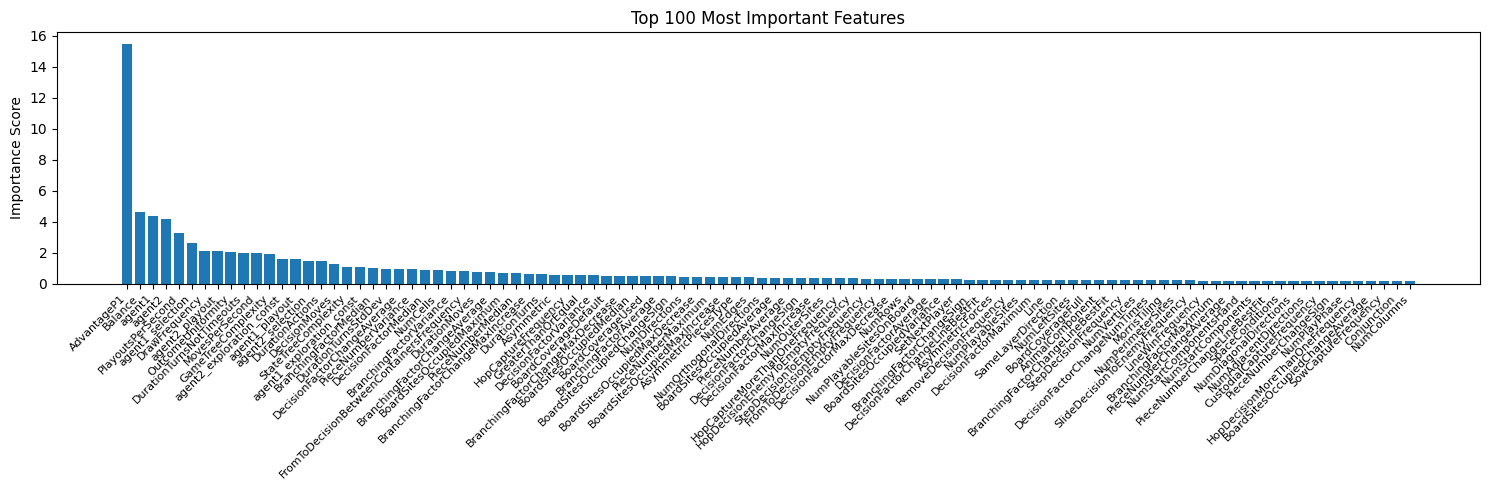

Fold 1 - RMSE: 0.4054369956639162
Fold 2


0:	learn: 0.6330885	test: 0.5466328	best: 0.5466328 (0)	total: 119ms	remaining: 19m 52s


50:	learn: 0.4991514	test: 0.4748727	best: 0.4748727 (50)	total: 5.89s	remaining: 19m 9s


100:	learn: 0.4511518	test: 0.4503201	best: 0.4503201 (100)	total: 11.7s	remaining: 19m 3s


150:	learn: 0.4238717	test: 0.4360349	best: 0.4360349 (150)	total: 17.8s	remaining: 19m 23s


200:	learn: 0.4050622	test: 0.4276095	best: 0.4276095 (200)	total: 24.4s	remaining: 19m 47s


250:	learn: 0.3909265	test: 0.4222675	best: 0.4222675 (250)	total: 31s	remaining: 20m 3s


300:	learn: 0.3794671	test: 0.4184620	best: 0.4184620 (300)	total: 37.5s	remaining: 20m 9s


350:	learn: 0.3708667	test: 0.4158822	best: 0.4158822 (350)	total: 44.2s	remaining: 20m 14s


400:	learn: 0.3632206	test: 0.4133295	best: 0.4133295 (400)	total: 50.7s	remaining: 20m 14s


450:	learn: 0.3565857	test: 0.4111317	best: 0.4111317 (450)	total: 57.3s	remaining: 20m 12s


500:	learn: 0.3505456	test: 0.4089201	best: 0.4089201 (500)	total: 1m 3s	remaining: 20m 10s


550:	learn: 0.3454954	test: 0.4075108	best: 0.4075108 (550)	total: 1m 10s	remaining: 20m 7s


600:	learn: 0.3402487	test: 0.4061374	best: 0.4061374 (600)	total: 1m 17s	remaining: 20m 4s


650:	learn: 0.3353734	test: 0.4045526	best: 0.4045526 (650)	total: 1m 23s	remaining: 19m 57s


700:	learn: 0.3311240	test: 0.4036862	best: 0.4036771 (699)	total: 1m 29s	remaining: 19m 51s


750:	learn: 0.3270913	test: 0.4027166	best: 0.4027166 (750)	total: 1m 36s	remaining: 19m 45s


800:	learn: 0.3236088	test: 0.4019308	best: 0.4019039 (798)	total: 1m 42s	remaining: 19m 40s


850:	learn: 0.3202005	test: 0.4012254	best: 0.4012254 (850)	total: 1m 49s	remaining: 19m 34s


900:	learn: 0.3169115	test: 0.4005419	best: 0.4005179 (898)	total: 1m 55s	remaining: 19m 29s


950:	learn: 0.3139248	test: 0.3998725	best: 0.3998725 (950)	total: 2m 2s	remaining: 19m 24s


1000:	learn: 0.3111076	test: 0.3991679	best: 0.3991679 (1000)	total: 2m 8s	remaining: 19m 17s


1050:	learn: 0.3082676	test: 0.3988354	best: 0.3988287 (1047)	total: 2m 15s	remaining: 19m 12s


1100:	learn: 0.3055972	test: 0.3983601	best: 0.3983601 (1100)	total: 2m 21s	remaining: 19m 6s


1150:	learn: 0.3032113	test: 0.3979666	best: 0.3979666 (1150)	total: 2m 28s	remaining: 19m 1s


1200:	learn: 0.3008276	test: 0.3975134	best: 0.3975104 (1197)	total: 2m 34s	remaining: 18m 55s


1250:	learn: 0.2986776	test: 0.3971883	best: 0.3971883 (1250)	total: 2m 41s	remaining: 18m 49s


1300:	learn: 0.2964463	test: 0.3969919	best: 0.3969919 (1300)	total: 2m 48s	remaining: 18m 44s


1350:	learn: 0.2945060	test: 0.3966592	best: 0.3966439 (1349)	total: 2m 54s	remaining: 18m 39s


1400:	learn: 0.2925220	test: 0.3964052	best: 0.3963714 (1395)	total: 3m 1s	remaining: 18m 33s


1450:	learn: 0.2907672	test: 0.3962263	best: 0.3962185 (1448)	total: 3m 8s	remaining: 18m 29s


1500:	learn: 0.2890140	test: 0.3960076	best: 0.3960076 (1500)	total: 3m 14s	remaining: 18m 23s


1550:	learn: 0.2873726	test: 0.3958139	best: 0.3958139 (1550)	total: 3m 21s	remaining: 18m 18s


1600:	learn: 0.2855419	test: 0.3955347	best: 0.3955311 (1598)	total: 3m 28s	remaining: 18m 12s


1650:	learn: 0.2838631	test: 0.3953801	best: 0.3953775 (1649)	total: 3m 34s	remaining: 18m 6s


1700:	learn: 0.2819312	test: 0.3951350	best: 0.3951217 (1699)	total: 3m 41s	remaining: 17m 59s


1750:	learn: 0.2803973	test: 0.3949650	best: 0.3949650 (1750)	total: 3m 47s	remaining: 17m 53s


1800:	learn: 0.2787322	test: 0.3947282	best: 0.3947282 (1800)	total: 3m 54s	remaining: 17m 47s


1850:	learn: 0.2772526	test: 0.3945563	best: 0.3945482 (1849)	total: 4m 1s	remaining: 17m 41s


1900:	learn: 0.2758697	test: 0.3944184	best: 0.3944057 (1881)	total: 4m 7s	remaining: 17m 35s


1950:	learn: 0.2743631	test: 0.3942405	best: 0.3942405 (1950)	total: 4m 14s	remaining: 17m 28s


2000:	learn: 0.2730088	test: 0.3940850	best: 0.3940766 (1993)	total: 4m 20s	remaining: 17m 22s


2050:	learn: 0.2717169	test: 0.3938874	best: 0.3938874 (2050)	total: 4m 27s	remaining: 17m 16s


2100:	learn: 0.2702715	test: 0.3937948	best: 0.3937828 (2081)	total: 4m 34s	remaining: 17m 10s


2150:	learn: 0.2690482	test: 0.3936657	best: 0.3936654 (2146)	total: 4m 40s	remaining: 17m 4s


2200:	learn: 0.2679377	test: 0.3935276	best: 0.3935276 (2200)	total: 4m 47s	remaining: 16m 58s


2250:	learn: 0.2667287	test: 0.3933847	best: 0.3933847 (2250)	total: 4m 54s	remaining: 16m 52s


2300:	learn: 0.2655365	test: 0.3932611	best: 0.3932611 (2300)	total: 5m	remaining: 16m 46s


2350:	learn: 0.2644312	test: 0.3931903	best: 0.3931833 (2346)	total: 5m 7s	remaining: 16m 40s


2400:	learn: 0.2632693	test: 0.3931477	best: 0.3931257 (2382)	total: 5m 14s	remaining: 16m 34s


2450:	learn: 0.2622361	test: 0.3930563	best: 0.3930563 (2450)	total: 5m 20s	remaining: 16m 27s


2500:	learn: 0.2611362	test: 0.3929783	best: 0.3929783 (2500)	total: 5m 27s	remaining: 16m 21s


2550:	learn: 0.2600938	test: 0.3928643	best: 0.3928527 (2544)	total: 5m 34s	remaining: 16m 16s


2600:	learn: 0.2591694	test: 0.3928713	best: 0.3928191 (2592)	total: 5m 40s	remaining: 16m 9s


2650:	learn: 0.2581355	test: 0.3927989	best: 0.3927886 (2637)	total: 5m 47s	remaining: 16m 3s


2700:	learn: 0.2571200	test: 0.3927669	best: 0.3927593 (2695)	total: 5m 54s	remaining: 15m 57s


2750:	learn: 0.2560117	test: 0.3927137	best: 0.3927137 (2750)	total: 6m	remaining: 15m 51s


2800:	learn: 0.2549987	test: 0.3926539	best: 0.3926500 (2788)	total: 6m 7s	remaining: 15m 44s


2850:	learn: 0.2541998	test: 0.3926238	best: 0.3925996 (2817)	total: 6m 14s	remaining: 15m 38s


2900:	learn: 0.2532796	test: 0.3926014	best: 0.3925936 (2888)	total: 6m 20s	remaining: 15m 32s


2950:	learn: 0.2523749	test: 0.3925374	best: 0.3925374 (2950)	total: 6m 27s	remaining: 15m 25s


3000:	learn: 0.2514467	test: 0.3925134	best: 0.3924895 (2983)	total: 6m 34s	remaining: 15m 19s


3050:	learn: 0.2505384	test: 0.3924025	best: 0.3924025 (3050)	total: 6m 40s	remaining: 15m 12s


3100:	learn: 0.2496751	test: 0.3922755	best: 0.3922755 (3100)	total: 6m 47s	remaining: 15m 6s


3150:	learn: 0.2488472	test: 0.3922247	best: 0.3922242 (3149)	total: 6m 54s	remaining: 15m


3200:	learn: 0.2480253	test: 0.3922073	best: 0.3922053 (3191)	total: 7m	remaining: 14m 53s


3250:	learn: 0.2471272	test: 0.3920924	best: 0.3920904 (3249)	total: 7m 7s	remaining: 14m 47s


3300:	learn: 0.2462652	test: 0.3920236	best: 0.3920235 (3299)	total: 7m 13s	remaining: 14m 40s


3350:	learn: 0.2453518	test: 0.3920270	best: 0.3920002 (3317)	total: 7m 20s	remaining: 14m 34s


3400:	learn: 0.2445581	test: 0.3920429	best: 0.3920002 (3317)	total: 7m 27s	remaining: 14m 27s


3450:	learn: 0.2437237	test: 0.3919930	best: 0.3919689 (3441)	total: 7m 33s	remaining: 14m 21s


3500:	learn: 0.2429092	test: 0.3919517	best: 0.3919501 (3489)	total: 7m 40s	remaining: 14m 14s


3550:	learn: 0.2421055	test: 0.3919058	best: 0.3918970 (3538)	total: 7m 47s	remaining: 14m 8s


3600:	learn: 0.2414800	test: 0.3918912	best: 0.3918796 (3568)	total: 7m 53s	remaining: 14m 2s


3650:	learn: 0.2407789	test: 0.3918777	best: 0.3918633 (3636)	total: 8m	remaining: 13m 55s


3700:	learn: 0.2401239	test: 0.3918458	best: 0.3918223 (3688)	total: 8m 7s	remaining: 13m 49s


3750:	learn: 0.2393777	test: 0.3918733	best: 0.3918223 (3688)	total: 8m 13s	remaining: 13m 42s


3800:	learn: 0.2386898	test: 0.3918655	best: 0.3918223 (3688)	total: 8m 20s	remaining: 13m 36s


3850:	learn: 0.2379928	test: 0.3917667	best: 0.3917667 (3850)	total: 8m 27s	remaining: 13m 29s


3900:	learn: 0.2372893	test: 0.3917120	best: 0.3916925 (3878)	total: 8m 33s	remaining: 13m 23s


3950:	learn: 0.2365857	test: 0.3916931	best: 0.3916908 (3943)	total: 8m 40s	remaining: 13m 16s


4000:	learn: 0.2358238	test: 0.3916715	best: 0.3916501 (3982)	total: 8m 47s	remaining: 13m 10s


4050:	learn: 0.2351657	test: 0.3916385	best: 0.3916166 (4048)	total: 8m 53s	remaining: 13m 4s


4100:	learn: 0.2344766	test: 0.3916247	best: 0.3916056 (4076)	total: 9m	remaining: 12m 57s


4150:	learn: 0.2338356	test: 0.3916077	best: 0.3916056 (4076)	total: 9m 7s	remaining: 12m 51s


4200:	learn: 0.2331858	test: 0.3916049	best: 0.3915965 (4153)	total: 9m 13s	remaining: 12m 44s


4250:	learn: 0.2325280	test: 0.3915705	best: 0.3915646 (4248)	total: 9m 20s	remaining: 12m 38s


4300:	learn: 0.2319449	test: 0.3915264	best: 0.3915254 (4297)	total: 9m 27s	remaining: 12m 31s


4350:	learn: 0.2313628	test: 0.3915214	best: 0.3915086 (4328)	total: 9m 33s	remaining: 12m 25s


4400:	learn: 0.2307211	test: 0.3914809	best: 0.3914809 (4400)	total: 9m 40s	remaining: 12m 18s


4450:	learn: 0.2300819	test: 0.3914560	best: 0.3914543 (4442)	total: 9m 47s	remaining: 12m 11s


4500:	learn: 0.2295322	test: 0.3914356	best: 0.3914356 (4500)	total: 9m 53s	remaining: 12m 5s


4550:	learn: 0.2289576	test: 0.3914400	best: 0.3914219 (4517)	total: 10m	remaining: 11m 58s


4600:	learn: 0.2283309	test: 0.3914391	best: 0.3914219 (4517)	total: 10m 6s	remaining: 11m 52s


4650:	learn: 0.2277263	test: 0.3913989	best: 0.3913989 (4650)	total: 10m 13s	remaining: 11m 45s


4700:	learn: 0.2271333	test: 0.3913661	best: 0.3913661 (4700)	total: 10m 20s	remaining: 11m 38s


4750:	learn: 0.2265822	test: 0.3913509	best: 0.3913425 (4745)	total: 10m 26s	remaining: 11m 32s


4800:	learn: 0.2260429	test: 0.3913199	best: 0.3913187 (4793)	total: 10m 33s	remaining: 11m 25s


4850:	learn: 0.2254545	test: 0.3912739	best: 0.3912739 (4850)	total: 10m 39s	remaining: 11m 19s


4900:	learn: 0.2249396	test: 0.3912391	best: 0.3912385 (4899)	total: 10m 46s	remaining: 11m 12s


4950:	learn: 0.2243706	test: 0.3911819	best: 0.3911819 (4950)	total: 10m 53s	remaining: 11m 6s


5000:	learn: 0.2237599	test: 0.3911282	best: 0.3911282 (5000)	total: 10m 59s	remaining: 10m 59s


5050:	learn: 0.2231948	test: 0.3910905	best: 0.3910899 (5049)	total: 11m 6s	remaining: 10m 53s


5100:	learn: 0.2226522	test: 0.3910881	best: 0.3910767 (5080)	total: 11m 13s	remaining: 10m 46s


5150:	learn: 0.2220957	test: 0.3910592	best: 0.3910592 (5150)	total: 11m 19s	remaining: 10m 39s


5200:	learn: 0.2215675	test: 0.3910527	best: 0.3910438 (5170)	total: 11m 26s	remaining: 10m 33s


5250:	learn: 0.2209998	test: 0.3910292	best: 0.3910248 (5244)	total: 11m 32s	remaining: 10m 26s


5300:	learn: 0.2205031	test: 0.3909700	best: 0.3909691 (5299)	total: 11m 39s	remaining: 10m 20s


5350:	learn: 0.2200012	test: 0.3909781	best: 0.3909651 (5305)	total: 11m 46s	remaining: 10m 13s


5400:	learn: 0.2194454	test: 0.3909819	best: 0.3909584 (5368)	total: 11m 52s	remaining: 10m 6s


5450:	learn: 0.2189419	test: 0.3909717	best: 0.3909584 (5368)	total: 11m 59s	remaining: 10m


5500:	learn: 0.2184866	test: 0.3909401	best: 0.3909382 (5499)	total: 12m 6s	remaining: 9m 53s


5550:	learn: 0.2179960	test: 0.3909213	best: 0.3909194 (5528)	total: 12m 12s	remaining: 9m 47s


5600:	learn: 0.2175298	test: 0.3909022	best: 0.3908906 (5588)	total: 12m 19s	remaining: 9m 40s


5650:	learn: 0.2170056	test: 0.3909014	best: 0.3908906 (5588)	total: 12m 25s	remaining: 9m 34s


5700:	learn: 0.2165896	test: 0.3908644	best: 0.3908644 (5700)	total: 12m 32s	remaining: 9m 27s


5750:	learn: 0.2161016	test: 0.3908612	best: 0.3908460 (5722)	total: 12m 39s	remaining: 9m 21s


5800:	learn: 0.2155654	test: 0.3908405	best: 0.3908405 (5800)	total: 12m 46s	remaining: 9m 14s


5850:	learn: 0.2150834	test: 0.3908565	best: 0.3908398 (5801)	total: 12m 52s	remaining: 9m 7s


5900:	learn: 0.2146208	test: 0.3908741	best: 0.3908398 (5801)	total: 12m 59s	remaining: 9m 1s


5950:	learn: 0.2141407	test: 0.3908687	best: 0.3908398 (5801)	total: 13m 6s	remaining: 8m 54s


6000:	learn: 0.2136041	test: 0.3908455	best: 0.3908398 (5801)	total: 13m 12s	remaining: 8m 48s


6050:	learn: 0.2131462	test: 0.3908576	best: 0.3908379 (6027)	total: 13m 19s	remaining: 8m 41s


6100:	learn: 0.2127638	test: 0.3908540	best: 0.3908379 (6027)	total: 13m 26s	remaining: 8m 35s


6150:	learn: 0.2123154	test: 0.3908603	best: 0.3908379 (6027)	total: 13m 32s	remaining: 8m 28s


6200:	learn: 0.2118344	test: 0.3908504	best: 0.3908379 (6027)	total: 13m 39s	remaining: 8m 22s


6250:	learn: 0.2114292	test: 0.3908387	best: 0.3908311 (6223)	total: 13m 46s	remaining: 8m 15s


6300:	learn: 0.2109519	test: 0.3908319	best: 0.3908229 (6288)	total: 13m 52s	remaining: 8m 8s


6350:	learn: 0.2105150	test: 0.3908283	best: 0.3908229 (6288)	total: 13m 59s	remaining: 8m 2s


6400:	learn: 0.2100582	test: 0.3908073	best: 0.3907997 (6381)	total: 14m 6s	remaining: 7m 55s


6450:	learn: 0.2096265	test: 0.3908035	best: 0.3907997 (6381)	total: 14m 12s	remaining: 7m 49s


6500:	learn: 0.2092266	test: 0.3907729	best: 0.3907709 (6498)	total: 14m 19s	remaining: 7m 42s


6550:	learn: 0.2088282	test: 0.3907779	best: 0.3907709 (6498)	total: 14m 26s	remaining: 7m 36s


6600:	learn: 0.2084884	test: 0.3907792	best: 0.3907709 (6498)	total: 14m 33s	remaining: 7m 29s


6650:	learn: 0.2080710	test: 0.3907477	best: 0.3907477 (6650)	total: 14m 39s	remaining: 7m 23s


6700:	learn: 0.2076935	test: 0.3907401	best: 0.3907364 (6665)	total: 14m 46s	remaining: 7m 16s


6750:	learn: 0.2072694	test: 0.3907378	best: 0.3907301 (6747)	total: 14m 53s	remaining: 7m 9s


6800:	learn: 0.2068296	test: 0.3907391	best: 0.3907250 (6777)	total: 14m 59s	remaining: 7m 3s


6850:	learn: 0.2064720	test: 0.3907286	best: 0.3907225 (6831)	total: 15m 6s	remaining: 6m 56s


6900:	learn: 0.2059922	test: 0.3907375	best: 0.3907221 (6873)	total: 15m 12s	remaining: 6m 49s


6950:	learn: 0.2056193	test: 0.3907317	best: 0.3907221 (6873)	total: 15m 19s	remaining: 6m 43s


7000:	learn: 0.2051873	test: 0.3907170	best: 0.3907170 (7000)	total: 15m 26s	remaining: 6m 36s


7050:	learn: 0.2047130	test: 0.3907058	best: 0.3907011 (7035)	total: 15m 32s	remaining: 6m 30s


7100:	learn: 0.2042859	test: 0.3907457	best: 0.3907011 (7035)	total: 15m 39s	remaining: 6m 23s


7150:	learn: 0.2038807	test: 0.3907525	best: 0.3907011 (7035)	total: 15m 46s	remaining: 6m 16s


7200:	learn: 0.2034915	test: 0.3907657	best: 0.3907011 (7035)	total: 15m 52s	remaining: 6m 10s


7250:	learn: 0.2030756	test: 0.3907791	best: 0.3907011 (7035)	total: 15m 59s	remaining: 6m 3s


7300:	learn: 0.2026690	test: 0.3907913	best: 0.3907011 (7035)	total: 16m 6s	remaining: 5m 57s


7350:	learn: 0.2022655	test: 0.3907686	best: 0.3907011 (7035)	total: 16m 12s	remaining: 5m 50s


7400:	learn: 0.2018630	test: 0.3907541	best: 0.3907011 (7035)	total: 16m 19s	remaining: 5m 43s


7450:	learn: 0.2014423	test: 0.3907648	best: 0.3907011 (7035)	total: 16m 26s	remaining: 5m 37s


7500:	learn: 0.2010509	test: 0.3907643	best: 0.3907011 (7035)	total: 16m 32s	remaining: 5m 30s


7550:	learn: 0.2006574	test: 0.3907369	best: 0.3907011 (7035)	total: 16m 39s	remaining: 5m 24s


7600:	learn: 0.2002007	test: 0.3907401	best: 0.3907011 (7035)	total: 16m 46s	remaining: 5m 17s


7650:	learn: 0.1998358	test: 0.3907064	best: 0.3907011 (7035)	total: 16m 52s	remaining: 5m 10s


7700:	learn: 0.1993977	test: 0.3906946	best: 0.3906934 (7697)	total: 16m 59s	remaining: 5m 4s


7750:	learn: 0.1990047	test: 0.3906811	best: 0.3906799 (7715)	total: 17m 5s	remaining: 4m 57s


7800:	learn: 0.1986329	test: 0.3906870	best: 0.3906758 (7771)	total: 17m 12s	remaining: 4m 51s


7850:	learn: 0.1982151	test: 0.3906733	best: 0.3906697 (7844)	total: 17m 19s	remaining: 4m 44s


7900:	learn: 0.1978353	test: 0.3906685	best: 0.3906621 (7878)	total: 17m 26s	remaining: 4m 37s


7950:	learn: 0.1974431	test: 0.3906600	best: 0.3906594 (7948)	total: 17m 32s	remaining: 4m 31s


8000:	learn: 0.1971213	test: 0.3906555	best: 0.3906468 (7969)	total: 17m 39s	remaining: 4m 24s


8050:	learn: 0.1967295	test: 0.3906380	best: 0.3906367 (8049)	total: 17m 46s	remaining: 4m 18s


8100:	learn: 0.1963265	test: 0.3906367	best: 0.3906315 (8069)	total: 17m 52s	remaining: 4m 11s


8150:	learn: 0.1959714	test: 0.3906213	best: 0.3906213 (8150)	total: 17m 59s	remaining: 4m 4s


8200:	learn: 0.1955718	test: 0.3906263	best: 0.3906088 (8167)	total: 18m 5s	remaining: 3m 58s


8250:	learn: 0.1952148	test: 0.3906100	best: 0.3906088 (8167)	total: 18m 12s	remaining: 3m 51s


8300:	learn: 0.1948199	test: 0.3905842	best: 0.3905833 (8296)	total: 18m 19s	remaining: 3m 45s


8350:	learn: 0.1944660	test: 0.3905878	best: 0.3905833 (8296)	total: 18m 26s	remaining: 3m 38s


8400:	learn: 0.1940847	test: 0.3905653	best: 0.3905634 (8399)	total: 18m 32s	remaining: 3m 31s


8450:	learn: 0.1937007	test: 0.3905674	best: 0.3905612 (8420)	total: 18m 39s	remaining: 3m 25s


8500:	learn: 0.1933280	test: 0.3905831	best: 0.3905612 (8420)	total: 18m 45s	remaining: 3m 18s


8550:	learn: 0.1930091	test: 0.3905673	best: 0.3905612 (8420)	total: 18m 52s	remaining: 3m 11s


8600:	learn: 0.1926767	test: 0.3905393	best: 0.3905378 (8599)	total: 18m 59s	remaining: 3m 5s


8650:	learn: 0.1922686	test: 0.3905279	best: 0.3905174 (8630)	total: 19m 5s	remaining: 2m 58s


8700:	learn: 0.1919160	test: 0.3905307	best: 0.3905174 (8630)	total: 19m 12s	remaining: 2m 52s


8750:	learn: 0.1915952	test: 0.3905268	best: 0.3905174 (8630)	total: 19m 19s	remaining: 2m 45s


8800:	learn: 0.1912002	test: 0.3905358	best: 0.3905174 (8630)	total: 19m 25s	remaining: 2m 38s


8850:	learn: 0.1908514	test: 0.3905294	best: 0.3905174 (8630)	total: 19m 32s	remaining: 2m 32s


8900:	learn: 0.1905392	test: 0.3905139	best: 0.3905136 (8899)	total: 19m 39s	remaining: 2m 25s


8950:	learn: 0.1901784	test: 0.3905216	best: 0.3905136 (8899)	total: 19m 45s	remaining: 2m 18s


9000:	learn: 0.1898390	test: 0.3905079	best: 0.3905079 (9000)	total: 19m 52s	remaining: 2m 12s


9050:	learn: 0.1895083	test: 0.3905121	best: 0.3905079 (9000)	total: 19m 58s	remaining: 2m 5s


9100:	learn: 0.1891355	test: 0.3905162	best: 0.3905027 (9065)	total: 20m 5s	remaining: 1m 59s


9150:	learn: 0.1888304	test: 0.3905083	best: 0.3905027 (9065)	total: 20m 12s	remaining: 1m 52s


9200:	learn: 0.1885258	test: 0.3905142	best: 0.3905027 (9065)	total: 20m 18s	remaining: 1m 45s


9250:	learn: 0.1881596	test: 0.3905164	best: 0.3905027 (9065)	total: 20m 25s	remaining: 1m 39s


9300:	learn: 0.1877942	test: 0.3905174	best: 0.3905027 (9065)	total: 20m 32s	remaining: 1m 32s


9350:	learn: 0.1874498	test: 0.3905003	best: 0.3904987 (9342)	total: 20m 38s	remaining: 1m 25s


9400:	learn: 0.1871135	test: 0.3905085	best: 0.3904957 (9366)	total: 20m 45s	remaining: 1m 19s


9450:	learn: 0.1867464	test: 0.3904989	best: 0.3904943 (9432)	total: 20m 51s	remaining: 1m 12s


9500:	learn: 0.1863789	test: 0.3904900	best: 0.3904886 (9498)	total: 20m 58s	remaining: 1m 6s


9550:	learn: 0.1860567	test: 0.3904809	best: 0.3904780 (9543)	total: 21m 5s	remaining: 59.5s


9600:	learn: 0.1857319	test: 0.3904816	best: 0.3904774 (9585)	total: 21m 11s	remaining: 52.9s


9650:	learn: 0.1853334	test: 0.3904739	best: 0.3904648 (9644)	total: 21m 18s	remaining: 46.2s


9700:	learn: 0.1849990	test: 0.3904758	best: 0.3904648 (9644)	total: 21m 25s	remaining: 39.6s


9750:	learn: 0.1847013	test: 0.3904859	best: 0.3904648 (9644)	total: 21m 31s	remaining: 33s


9800:	learn: 0.1843879	test: 0.3904859	best: 0.3904648 (9644)	total: 21m 38s	remaining: 26.4s


9850:	learn: 0.1840556	test: 0.3904835	best: 0.3904648 (9644)	total: 21m 45s	remaining: 19.7s


9900:	learn: 0.1837375	test: 0.3904854	best: 0.3904648 (9644)	total: 21m 51s	remaining: 13.1s


9950:	learn: 0.1834034	test: 0.3904810	best: 0.3904648 (9644)	total: 21m 58s	remaining: 6.49s


9999:	learn: 0.1831142	test: 0.3904778	best: 0.3904648 (9644)	total: 22m 4s	remaining: 0us

bestTest = 0.3904648142
bestIteration = 9644

Shrink model to first 9645 iterations.


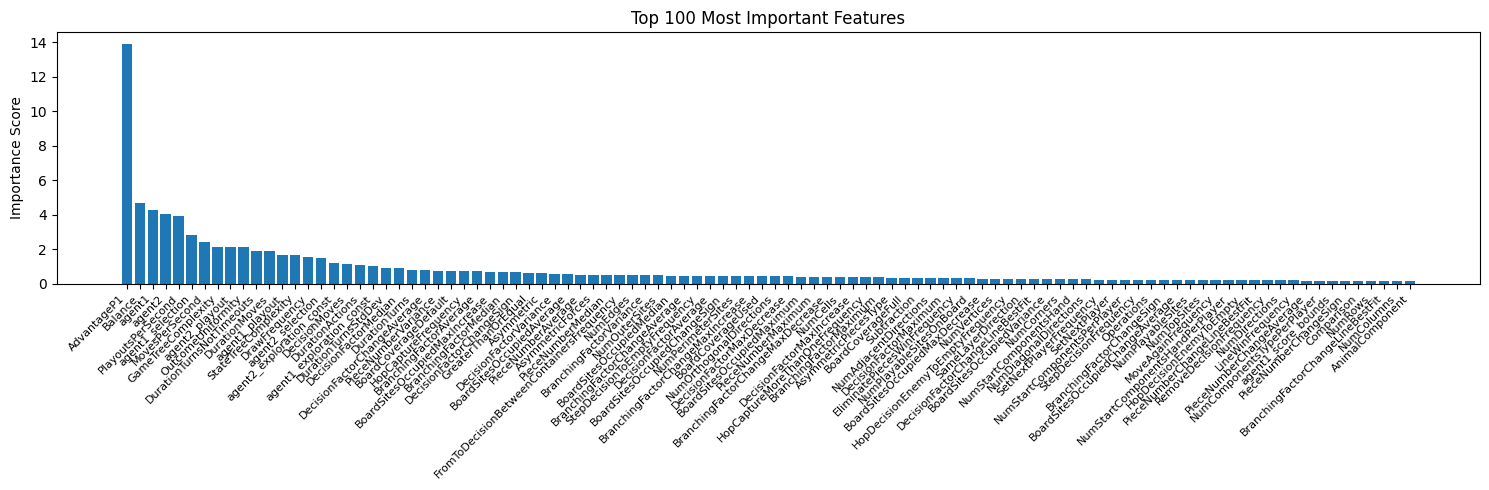

Fold 2 - RMSE: 0.3901070641430095
Fold 3


0:	learn: 0.6196805	test: 0.6143200	best: 0.6143200 (0)	total: 133ms	remaining: 22m 5s


50:	learn: 0.4838731	test: 0.5523557	best: 0.5523557 (50)	total: 6.05s	remaining: 19m 40s


100:	learn: 0.4385555	test: 0.5204294	best: 0.5204294 (100)	total: 12.2s	remaining: 19m 53s


150:	learn: 0.4132910	test: 0.5035679	best: 0.5035679 (150)	total: 18.4s	remaining: 20m 2s


200:	learn: 0.3970334	test: 0.4910162	best: 0.4910162 (200)	total: 25.1s	remaining: 20m 23s


250:	learn: 0.3840748	test: 0.4816290	best: 0.4816290 (250)	total: 31.8s	remaining: 20m 35s


300:	learn: 0.3734196	test: 0.4742156	best: 0.4742156 (300)	total: 38.6s	remaining: 20m 43s


350:	learn: 0.3649449	test: 0.4690590	best: 0.4690590 (350)	total: 45.5s	remaining: 20m 50s


400:	learn: 0.3585494	test: 0.4660445	best: 0.4660445 (400)	total: 52.4s	remaining: 20m 55s


450:	learn: 0.3522806	test: 0.4628808	best: 0.4628808 (450)	total: 59.4s	remaining: 20m 57s


500:	learn: 0.3467693	test: 0.4597648	best: 0.4597648 (500)	total: 1m 6s	remaining: 20m 58s


550:	learn: 0.3413202	test: 0.4569860	best: 0.4569860 (550)	total: 1m 13s	remaining: 20m 53s


600:	learn: 0.3368161	test: 0.4547965	best: 0.4547965 (600)	total: 1m 19s	remaining: 20m 50s


650:	learn: 0.3327111	test: 0.4530748	best: 0.4530584 (648)	total: 1m 26s	remaining: 20m 46s


700:	learn: 0.3283092	test: 0.4510873	best: 0.4510873 (700)	total: 1m 33s	remaining: 20m 40s


750:	learn: 0.3245149	test: 0.4495665	best: 0.4495665 (750)	total: 1m 40s	remaining: 20m 31s


800:	learn: 0.3208389	test: 0.4482474	best: 0.4482474 (800)	total: 1m 46s	remaining: 20m 24s


850:	learn: 0.3175233	test: 0.4469398	best: 0.4469398 (850)	total: 1m 53s	remaining: 20m 17s


900:	learn: 0.3142586	test: 0.4457586	best: 0.4457485 (899)	total: 2m	remaining: 20m 12s


950:	learn: 0.3112180	test: 0.4446643	best: 0.4446643 (950)	total: 2m 6s	remaining: 20m 4s


1000:	learn: 0.3085488	test: 0.4437132	best: 0.4437084 (999)	total: 2m 13s	remaining: 19m 58s


1050:	learn: 0.3055651	test: 0.4431924	best: 0.4431924 (1050)	total: 2m 20s	remaining: 19m 52s


1100:	learn: 0.3030020	test: 0.4424962	best: 0.4424962 (1100)	total: 2m 26s	remaining: 19m 46s


1150:	learn: 0.3006192	test: 0.4417888	best: 0.4417888 (1150)	total: 2m 33s	remaining: 19m 41s


1200:	learn: 0.2982764	test: 0.4410166	best: 0.4410166 (1200)	total: 2m 40s	remaining: 19m 35s


1250:	learn: 0.2959993	test: 0.4403565	best: 0.4403545 (1249)	total: 2m 47s	remaining: 19m 28s


1300:	learn: 0.2938883	test: 0.4397157	best: 0.4397148 (1298)	total: 2m 53s	remaining: 19m 22s


1350:	learn: 0.2919140	test: 0.4391553	best: 0.4391553 (1350)	total: 3m	remaining: 19m 15s


1400:	learn: 0.2899718	test: 0.4385998	best: 0.4385998 (1400)	total: 3m 7s	remaining: 19m 9s


1450:	learn: 0.2881110	test: 0.4381747	best: 0.4381590 (1448)	total: 3m 14s	remaining: 19m 3s


1500:	learn: 0.2863982	test: 0.4378539	best: 0.4378539 (1500)	total: 3m 20s	remaining: 18m 57s


1550:	learn: 0.2846729	test: 0.4374985	best: 0.4374955 (1549)	total: 3m 27s	remaining: 18m 51s


1600:	learn: 0.2830050	test: 0.4369978	best: 0.4369969 (1599)	total: 3m 34s	remaining: 18m 45s


1650:	learn: 0.2814835	test: 0.4366916	best: 0.4366909 (1649)	total: 3m 41s	remaining: 18m 39s


1700:	learn: 0.2797465	test: 0.4362537	best: 0.4362537 (1700)	total: 3m 48s	remaining: 18m 33s


1750:	learn: 0.2783621	test: 0.4359333	best: 0.4359244 (1744)	total: 3m 55s	remaining: 18m 27s


1800:	learn: 0.2768179	test: 0.4355934	best: 0.4355934 (1800)	total: 4m 1s	remaining: 18m 21s


1850:	learn: 0.2753193	test: 0.4352390	best: 0.4352390 (1850)	total: 4m 8s	remaining: 18m 15s


1900:	learn: 0.2740413	test: 0.4349184	best: 0.4349184 (1900)	total: 4m 15s	remaining: 18m 9s


1950:	learn: 0.2726366	test: 0.4345754	best: 0.4345754 (1950)	total: 4m 22s	remaining: 18m 3s


2000:	learn: 0.2714099	test: 0.4343440	best: 0.4343440 (2000)	total: 4m 29s	remaining: 17m 56s


2050:	learn: 0.2701172	test: 0.4341172	best: 0.4341172 (2050)	total: 4m 36s	remaining: 17m 50s


2100:	learn: 0.2688785	test: 0.4339761	best: 0.4339761 (2100)	total: 4m 43s	remaining: 17m 44s


2150:	learn: 0.2676766	test: 0.4338113	best: 0.4338113 (2150)	total: 4m 49s	remaining: 17m 38s


2200:	learn: 0.2665764	test: 0.4335508	best: 0.4335400 (2199)	total: 4m 56s	remaining: 17m 31s


2250:	learn: 0.2653714	test: 0.4333091	best: 0.4333091 (2250)	total: 5m 3s	remaining: 17m 25s


2300:	learn: 0.2641891	test: 0.4330235	best: 0.4330235 (2300)	total: 5m 10s	remaining: 17m 18s


2350:	learn: 0.2631059	test: 0.4328380	best: 0.4328362 (2349)	total: 5m 17s	remaining: 17m 12s


2400:	learn: 0.2620716	test: 0.4326285	best: 0.4326285 (2400)	total: 5m 24s	remaining: 17m 5s


2450:	learn: 0.2608780	test: 0.4324145	best: 0.4324145 (2450)	total: 5m 30s	remaining: 16m 59s


2500:	learn: 0.2597690	test: 0.4321579	best: 0.4321579 (2500)	total: 5m 37s	remaining: 16m 52s


2550:	learn: 0.2587469	test: 0.4319486	best: 0.4319350 (2546)	total: 5m 44s	remaining: 16m 45s


2600:	learn: 0.2577599	test: 0.4316971	best: 0.4316967 (2599)	total: 5m 51s	remaining: 16m 39s


2650:	learn: 0.2569078	test: 0.4315393	best: 0.4315393 (2650)	total: 5m 58s	remaining: 16m 32s


2700:	learn: 0.2558829	test: 0.4313833	best: 0.4313833 (2700)	total: 6m 5s	remaining: 16m 26s


2750:	learn: 0.2547801	test: 0.4311927	best: 0.4311923 (2749)	total: 6m 11s	remaining: 16m 19s


2800:	learn: 0.2538810	test: 0.4310679	best: 0.4310664 (2799)	total: 6m 18s	remaining: 16m 13s


2850:	learn: 0.2528832	test: 0.4309452	best: 0.4309452 (2850)	total: 6m 25s	remaining: 16m 6s


2900:	learn: 0.2519923	test: 0.4308192	best: 0.4308167 (2898)	total: 6m 32s	remaining: 16m


2950:	learn: 0.2509289	test: 0.4305736	best: 0.4305715 (2949)	total: 6m 39s	remaining: 15m 53s


3000:	learn: 0.2500106	test: 0.4303632	best: 0.4303630 (2999)	total: 6m 45s	remaining: 15m 46s


3050:	learn: 0.2491021	test: 0.4301805	best: 0.4301759 (3048)	total: 6m 52s	remaining: 15m 40s


3100:	learn: 0.2482689	test: 0.4300351	best: 0.4300351 (3100)	total: 6m 59s	remaining: 15m 34s


3150:	learn: 0.2474488	test: 0.4298217	best: 0.4298217 (3150)	total: 7m 6s	remaining: 15m 27s


3200:	learn: 0.2466643	test: 0.4297137	best: 0.4297115 (3198)	total: 7m 13s	remaining: 15m 21s


3250:	learn: 0.2459057	test: 0.4295946	best: 0.4295946 (3250)	total: 7m 20s	remaining: 15m 14s


3300:	learn: 0.2451992	test: 0.4294709	best: 0.4294709 (3300)	total: 7m 27s	remaining: 15m 8s


3350:	learn: 0.2443365	test: 0.4293382	best: 0.4293331 (3348)	total: 7m 34s	remaining: 15m 1s


3400:	learn: 0.2436017	test: 0.4292234	best: 0.4292234 (3400)	total: 7m 41s	remaining: 14m 54s


3450:	learn: 0.2428380	test: 0.4290671	best: 0.4290671 (3450)	total: 7m 47s	remaining: 14m 47s


3500:	learn: 0.2420544	test: 0.4289419	best: 0.4289414 (3498)	total: 7m 54s	remaining: 14m 41s


3550:	learn: 0.2413741	test: 0.4288770	best: 0.4288761 (3547)	total: 8m 1s	remaining: 14m 34s


3600:	learn: 0.2405718	test: 0.4287510	best: 0.4287415 (3597)	total: 8m 8s	remaining: 14m 27s


3650:	learn: 0.2398284	test: 0.4286279	best: 0.4286279 (3650)	total: 8m 15s	remaining: 14m 21s


3700:	learn: 0.2390763	test: 0.4284634	best: 0.4284625 (3699)	total: 8m 22s	remaining: 14m 14s


3750:	learn: 0.2383533	test: 0.4283835	best: 0.4283835 (3750)	total: 8m 28s	remaining: 14m 7s


3800:	learn: 0.2377403	test: 0.4282378	best: 0.4282378 (3800)	total: 8m 35s	remaining: 14m 1s


3850:	learn: 0.2370262	test: 0.4281478	best: 0.4281478 (3850)	total: 8m 42s	remaining: 13m 54s


3900:	learn: 0.2363894	test: 0.4280760	best: 0.4280707 (3894)	total: 8m 49s	remaining: 13m 48s


3950:	learn: 0.2357038	test: 0.4280085	best: 0.4280043 (3949)	total: 8m 56s	remaining: 13m 41s


4000:	learn: 0.2350838	test: 0.4279180	best: 0.4279138 (3997)	total: 9m 3s	remaining: 13m 35s


4050:	learn: 0.2343926	test: 0.4278417	best: 0.4278380 (4048)	total: 9m 10s	remaining: 13m 28s


4100:	learn: 0.2337671	test: 0.4277424	best: 0.4277424 (4100)	total: 9m 17s	remaining: 13m 21s


4150:	learn: 0.2331340	test: 0.4276371	best: 0.4276371 (4150)	total: 9m 24s	remaining: 13m 15s


4200:	learn: 0.2325137	test: 0.4275796	best: 0.4275715 (4196)	total: 9m 31s	remaining: 13m 8s


4250:	learn: 0.2319389	test: 0.4274902	best: 0.4274821 (4246)	total: 9m 38s	remaining: 13m 1s


4300:	learn: 0.2314073	test: 0.4274004	best: 0.4273984 (4297)	total: 9m 45s	remaining: 12m 55s


4350:	learn: 0.2307825	test: 0.4273178	best: 0.4273165 (4349)	total: 9m 51s	remaining: 12m 48s


4400:	learn: 0.2302095	test: 0.4272421	best: 0.4272390 (4399)	total: 9m 58s	remaining: 12m 41s


4450:	learn: 0.2296208	test: 0.4271753	best: 0.4271753 (4450)	total: 10m 5s	remaining: 12m 34s


4500:	learn: 0.2291148	test: 0.4271371	best: 0.4271357 (4498)	total: 10m 12s	remaining: 12m 28s


4550:	learn: 0.2284693	test: 0.4270830	best: 0.4270811 (4549)	total: 10m 19s	remaining: 12m 21s


4600:	learn: 0.2279341	test: 0.4270277	best: 0.4270240 (4588)	total: 10m 26s	remaining: 12m 14s


4650:	learn: 0.2273949	test: 0.4269823	best: 0.4269729 (4647)	total: 10m 33s	remaining: 12m 8s


4700:	learn: 0.2268787	test: 0.4269136	best: 0.4269136 (4700)	total: 10m 40s	remaining: 12m 1s


4750:	learn: 0.2262934	test: 0.4268515	best: 0.4268457 (4748)	total: 10m 47s	remaining: 11m 55s


4800:	learn: 0.2258227	test: 0.4268235	best: 0.4268200 (4798)	total: 10m 54s	remaining: 11m 48s


4850:	learn: 0.2252965	test: 0.4266897	best: 0.4266897 (4850)	total: 11m 1s	remaining: 11m 41s


4900:	learn: 0.2248024	test: 0.4266489	best: 0.4266489 (4900)	total: 11m 7s	remaining: 11m 34s


4950:	learn: 0.2242893	test: 0.4265472	best: 0.4265472 (4950)	total: 11m 14s	remaining: 11m 28s


5000:	learn: 0.2237441	test: 0.4264668	best: 0.4264668 (5000)	total: 11m 21s	remaining: 11m 21s


5050:	learn: 0.2231963	test: 0.4264096	best: 0.4264083 (5049)	total: 11m 28s	remaining: 11m 14s


5100:	learn: 0.2226704	test: 0.4263727	best: 0.4263727 (5100)	total: 11m 35s	remaining: 11m 8s


5150:	learn: 0.2221650	test: 0.4262599	best: 0.4262599 (5150)	total: 11m 42s	remaining: 11m 1s


5200:	learn: 0.2216007	test: 0.4261596	best: 0.4261596 (5200)	total: 11m 49s	remaining: 10m 54s


5250:	learn: 0.2211031	test: 0.4260964	best: 0.4260964 (5250)	total: 11m 56s	remaining: 10m 47s


5300:	learn: 0.2205930	test: 0.4260212	best: 0.4260212 (5300)	total: 12m 3s	remaining: 10m 41s


5350:	learn: 0.2201385	test: 0.4259841	best: 0.4259841 (5350)	total: 12m 10s	remaining: 10m 34s


5400:	learn: 0.2196278	test: 0.4259446	best: 0.4259444 (5393)	total: 12m 17s	remaining: 10m 27s


5450:	learn: 0.2191184	test: 0.4258889	best: 0.4258889 (5450)	total: 12m 24s	remaining: 10m 21s


5500:	learn: 0.2186513	test: 0.4258816	best: 0.4258713 (5495)	total: 12m 31s	remaining: 10m 14s


5550:	learn: 0.2181684	test: 0.4258189	best: 0.4258170 (5548)	total: 12m 37s	remaining: 10m 7s


5600:	learn: 0.2176902	test: 0.4257835	best: 0.4257731 (5590)	total: 12m 44s	remaining: 10m


5650:	learn: 0.2173224	test: 0.4257669	best: 0.4257654 (5640)	total: 12m 51s	remaining: 9m 53s


5700:	learn: 0.2168454	test: 0.4257399	best: 0.4257357 (5686)	total: 12m 58s	remaining: 9m 47s


5750:	learn: 0.2163758	test: 0.4256962	best: 0.4256962 (5750)	total: 13m 5s	remaining: 9m 40s


5800:	learn: 0.2158605	test: 0.4256667	best: 0.4256658 (5797)	total: 13m 12s	remaining: 9m 33s


5850:	learn: 0.2153342	test: 0.4255647	best: 0.4255647 (5850)	total: 13m 19s	remaining: 9m 26s


5900:	learn: 0.2149342	test: 0.4255516	best: 0.4255452 (5877)	total: 13m 26s	remaining: 9m 20s


5950:	learn: 0.2144359	test: 0.4254916	best: 0.4254916 (5949)	total: 13m 33s	remaining: 9m 13s


6000:	learn: 0.2140217	test: 0.4254681	best: 0.4254658 (5999)	total: 13m 40s	remaining: 9m 6s


6050:	learn: 0.2135497	test: 0.4254329	best: 0.4254329 (6050)	total: 13m 47s	remaining: 9m


6100:	learn: 0.2130601	test: 0.4253836	best: 0.4253836 (6100)	total: 13m 54s	remaining: 8m 53s


6150:	learn: 0.2126305	test: 0.4253420	best: 0.4253392 (6145)	total: 14m 1s	remaining: 8m 46s


6200:	learn: 0.2122204	test: 0.4253093	best: 0.4253087 (6198)	total: 14m 8s	remaining: 8m 39s


6250:	learn: 0.2117331	test: 0.4252636	best: 0.4252636 (6250)	total: 14m 15s	remaining: 8m 32s


6300:	learn: 0.2112487	test: 0.4252111	best: 0.4252084 (6299)	total: 14m 21s	remaining: 8m 25s


6350:	learn: 0.2107846	test: 0.4251676	best: 0.4251554 (6343)	total: 14m 28s	remaining: 8m 19s


6400:	learn: 0.2103386	test: 0.4251378	best: 0.4251378 (6400)	total: 14m 35s	remaining: 8m 12s


6450:	learn: 0.2099574	test: 0.4251246	best: 0.4251224 (6442)	total: 14m 42s	remaining: 8m 5s


6500:	learn: 0.2095396	test: 0.4250618	best: 0.4250618 (6500)	total: 14m 49s	remaining: 7m 58s


6550:	learn: 0.2091588	test: 0.4250124	best: 0.4250115 (6547)	total: 14m 56s	remaining: 7m 52s


6600:	learn: 0.2087417	test: 0.4249453	best: 0.4249433 (6596)	total: 15m 3s	remaining: 7m 45s


6650:	learn: 0.2083441	test: 0.4249215	best: 0.4249208 (6647)	total: 15m 10s	remaining: 7m 38s


6700:	learn: 0.2079288	test: 0.4248897	best: 0.4248856 (6688)	total: 15m 17s	remaining: 7m 31s


6750:	learn: 0.2075210	test: 0.4248532	best: 0.4248515 (6749)	total: 15m 24s	remaining: 7m 25s


6800:	learn: 0.2071209	test: 0.4248422	best: 0.4248387 (6792)	total: 15m 31s	remaining: 7m 18s


6850:	learn: 0.2067393	test: 0.4248077	best: 0.4248063 (6849)	total: 15m 38s	remaining: 7m 11s


6900:	learn: 0.2063100	test: 0.4247581	best: 0.4247572 (6899)	total: 15m 45s	remaining: 7m 4s


6950:	learn: 0.2058914	test: 0.4247028	best: 0.4247028 (6950)	total: 15m 52s	remaining: 6m 57s


7000:	learn: 0.2055164	test: 0.4246800	best: 0.4246766 (6999)	total: 15m 59s	remaining: 6m 50s


7050:	learn: 0.2050405	test: 0.4246219	best: 0.4246219 (7050)	total: 16m 5s	remaining: 6m 43s


7100:	learn: 0.2046178	test: 0.4245937	best: 0.4245901 (7092)	total: 16m 12s	remaining: 6m 37s


7150:	learn: 0.2041962	test: 0.4245565	best: 0.4245565 (7150)	total: 16m 19s	remaining: 6m 30s


7200:	learn: 0.2037998	test: 0.4245183	best: 0.4245181 (7199)	total: 16m 26s	remaining: 6m 23s


7250:	learn: 0.2034554	test: 0.4245007	best: 0.4244997 (7249)	total: 16m 33s	remaining: 6m 16s


7300:	learn: 0.2030965	test: 0.4244706	best: 0.4244683 (7288)	total: 16m 40s	remaining: 6m 9s


7350:	learn: 0.2027478	test: 0.4244659	best: 0.4244640 (7324)	total: 16m 47s	remaining: 6m 3s


7400:	learn: 0.2023959	test: 0.4244346	best: 0.4244323 (7399)	total: 16m 54s	remaining: 5m 56s


7450:	learn: 0.2020084	test: 0.4243847	best: 0.4243835 (7448)	total: 17m 1s	remaining: 5m 49s


7500:	learn: 0.2015970	test: 0.4243400	best: 0.4243357 (7493)	total: 17m 7s	remaining: 5m 42s


7550:	learn: 0.2012322	test: 0.4243339	best: 0.4243322 (7530)	total: 17m 14s	remaining: 5m 35s


7600:	learn: 0.2008565	test: 0.4243080	best: 0.4243080 (7600)	total: 17m 21s	remaining: 5m 28s


7650:	learn: 0.2004561	test: 0.4242978	best: 0.4242844 (7639)	total: 17m 28s	remaining: 5m 21s


7700:	learn: 0.2001114	test: 0.4243108	best: 0.4242844 (7639)	total: 17m 35s	remaining: 5m 15s


7750:	learn: 0.1997204	test: 0.4243036	best: 0.4242844 (7639)	total: 17m 42s	remaining: 5m 8s


7800:	learn: 0.1993077	test: 0.4242758	best: 0.4242749 (7797)	total: 17m 49s	remaining: 5m 1s


7850:	learn: 0.1989678	test: 0.4242474	best: 0.4242474 (7850)	total: 17m 56s	remaining: 4m 54s


7900:	learn: 0.1985917	test: 0.4242596	best: 0.4242382 (7864)	total: 18m 3s	remaining: 4m 47s


7950:	learn: 0.1982248	test: 0.4242376	best: 0.4242285 (7937)	total: 18m 10s	remaining: 4m 40s


8000:	learn: 0.1978657	test: 0.4242326	best: 0.4242285 (7937)	total: 18m 17s	remaining: 4m 34s


8050:	learn: 0.1975446	test: 0.4242452	best: 0.4242242 (8019)	total: 18m 24s	remaining: 4m 27s


8100:	learn: 0.1972360	test: 0.4242182	best: 0.4242170 (8098)	total: 18m 31s	remaining: 4m 20s


8150:	learn: 0.1968104	test: 0.4242150	best: 0.4242104 (8125)	total: 18m 37s	remaining: 4m 13s


8200:	learn: 0.1964452	test: 0.4242031	best: 0.4242031 (8200)	total: 18m 44s	remaining: 4m 6s


8250:	learn: 0.1960969	test: 0.4241799	best: 0.4241738 (8247)	total: 18m 51s	remaining: 3m 59s


8300:	learn: 0.1957289	test: 0.4241509	best: 0.4241492 (8299)	total: 18m 58s	remaining: 3m 53s


8350:	learn: 0.1953463	test: 0.4241389	best: 0.4241359 (8345)	total: 19m 5s	remaining: 3m 46s


8400:	learn: 0.1949688	test: 0.4240872	best: 0.4240872 (8400)	total: 19m 12s	remaining: 3m 39s


8450:	learn: 0.1946014	test: 0.4240541	best: 0.4240509 (8449)	total: 19m 19s	remaining: 3m 32s


8500:	learn: 0.1942622	test: 0.4240206	best: 0.4240194 (8498)	total: 19m 26s	remaining: 3m 25s


8550:	learn: 0.1939418	test: 0.4240103	best: 0.4240097 (8547)	total: 19m 33s	remaining: 3m 18s


8600:	learn: 0.1935804	test: 0.4239917	best: 0.4239854 (8582)	total: 19m 40s	remaining: 3m 11s


8650:	learn: 0.1932705	test: 0.4239800	best: 0.4239764 (8640)	total: 19m 47s	remaining: 3m 5s


8700:	learn: 0.1929559	test: 0.4239683	best: 0.4239658 (8696)	total: 19m 53s	remaining: 2m 58s


8750:	learn: 0.1925716	test: 0.4239417	best: 0.4239417 (8750)	total: 20m	remaining: 2m 51s


8800:	learn: 0.1922307	test: 0.4239211	best: 0.4239203 (8799)	total: 20m 7s	remaining: 2m 44s


8850:	learn: 0.1918763	test: 0.4238763	best: 0.4238763 (8850)	total: 20m 14s	remaining: 2m 37s


8900:	learn: 0.1915449	test: 0.4238456	best: 0.4238397 (8894)	total: 20m 21s	remaining: 2m 30s


8950:	learn: 0.1912090	test: 0.4238212	best: 0.4238183 (8936)	total: 20m 28s	remaining: 2m 23s


9000:	learn: 0.1908869	test: 0.4238182	best: 0.4238145 (8995)	total: 20m 35s	remaining: 2m 17s


9050:	learn: 0.1905546	test: 0.4238076	best: 0.4238047 (9037)	total: 20m 42s	remaining: 2m 10s


9100:	learn: 0.1902564	test: 0.4237914	best: 0.4237907 (9097)	total: 20m 49s	remaining: 2m 3s


9150:	learn: 0.1899194	test: 0.4237765	best: 0.4237748 (9147)	total: 20m 56s	remaining: 1m 56s


9200:	learn: 0.1895720	test: 0.4237489	best: 0.4237469 (9198)	total: 21m 2s	remaining: 1m 49s


9250:	learn: 0.1892902	test: 0.4237268	best: 0.4237257 (9249)	total: 21m 9s	remaining: 1m 42s


9300:	learn: 0.1889935	test: 0.4236969	best: 0.4236967 (9295)	total: 21m 16s	remaining: 1m 35s


9350:	learn: 0.1886535	test: 0.4236830	best: 0.4236806 (9347)	total: 21m 23s	remaining: 1m 29s


9400:	learn: 0.1883235	test: 0.4236629	best: 0.4236629 (9400)	total: 21m 30s	remaining: 1m 22s


9450:	learn: 0.1880375	test: 0.4236378	best: 0.4236378 (9450)	total: 21m 37s	remaining: 1m 15s


9500:	learn: 0.1877695	test: 0.4236305	best: 0.4236250 (9489)	total: 21m 44s	remaining: 1m 8s


9550:	learn: 0.1874769	test: 0.4236325	best: 0.4236245 (9534)	total: 21m 51s	remaining: 1m 1s


9600:	learn: 0.1871730	test: 0.4235948	best: 0.4235948 (9600)	total: 21m 58s	remaining: 54.8s


9650:	learn: 0.1868728	test: 0.4235660	best: 0.4235651 (9643)	total: 22m 5s	remaining: 47.9s


9700:	learn: 0.1865505	test: 0.4235367	best: 0.4235364 (9691)	total: 22m 12s	remaining: 41.1s


9750:	learn: 0.1862332	test: 0.4235126	best: 0.4235126 (9750)	total: 22m 19s	remaining: 34.2s


9800:	learn: 0.1858931	test: 0.4235093	best: 0.4235020 (9787)	total: 22m 25s	remaining: 27.3s


9850:	learn: 0.1855874	test: 0.4235135	best: 0.4235020 (9787)	total: 22m 32s	remaining: 20.5s


9900:	learn: 0.1852668	test: 0.4234961	best: 0.4234940 (9899)	total: 22m 39s	remaining: 13.6s


9950:	learn: 0.1848970	test: 0.4234731	best: 0.4234708 (9941)	total: 22m 46s	remaining: 6.73s


9999:	learn: 0.1845981	test: 0.4234461	best: 0.4234461 (9999)	total: 22m 53s	remaining: 0us

bestTest = 0.423446137
bestIteration = 9999



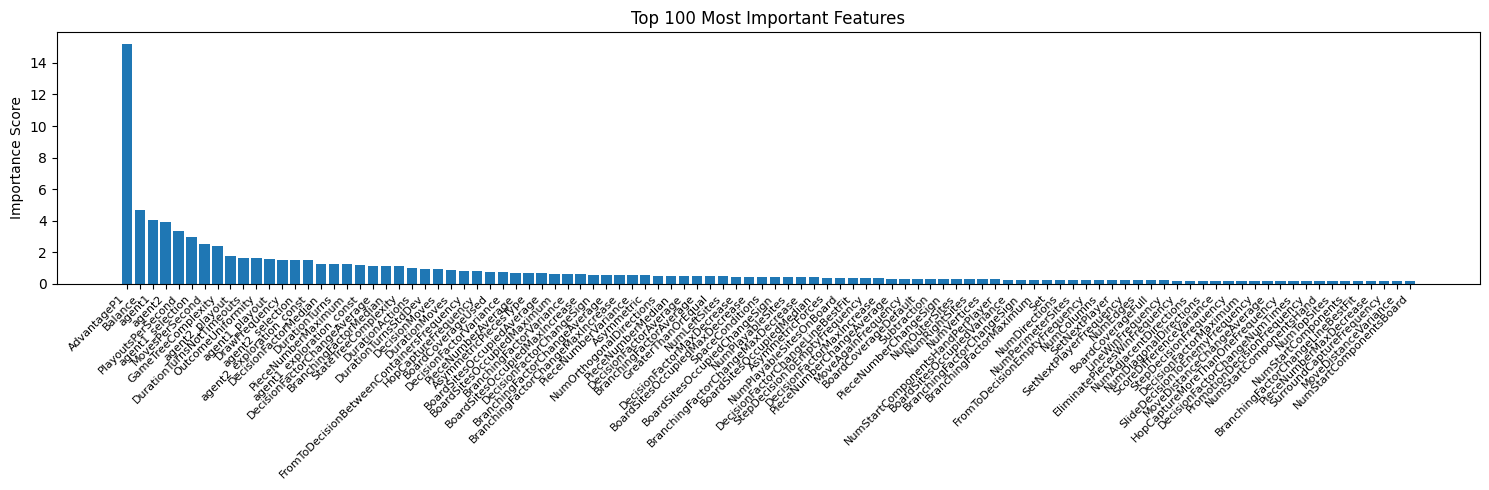

Fold 3 - RMSE: 0.4228276849918016
Fold 4


0:	learn: 0.6210298	test: 0.6061263	best: 0.6061263 (0)	total: 120ms	remaining: 20m 1s


50:	learn: 0.4884851	test: 0.5474814	best: 0.5474814 (50)	total: 5.72s	remaining: 18m 36s


100:	learn: 0.4441146	test: 0.5208247	best: 0.5208247 (100)	total: 11.4s	remaining: 18m 39s


150:	learn: 0.4189876	test: 0.5034494	best: 0.5034494 (150)	total: 17.5s	remaining: 18m 59s


200:	learn: 0.4025843	test: 0.4920630	best: 0.4920630 (200)	total: 23.8s	remaining: 19m 21s


250:	learn: 0.3897779	test: 0.4837416	best: 0.4837405 (249)	total: 30.4s	remaining: 19m 40s


300:	learn: 0.3800048	test: 0.4779046	best: 0.4779046 (300)	total: 37.1s	remaining: 19m 56s


350:	learn: 0.3716732	test: 0.4733832	best: 0.4733832 (350)	total: 43.9s	remaining: 20m 7s


400:	learn: 0.3642783	test: 0.4698044	best: 0.4698044 (400)	total: 50.6s	remaining: 20m 11s


450:	learn: 0.3581908	test: 0.4666131	best: 0.4666131 (450)	total: 57.2s	remaining: 20m 11s


500:	learn: 0.3527325	test: 0.4641072	best: 0.4641072 (500)	total: 1m 4s	remaining: 20m 15s


550:	learn: 0.3473513	test: 0.4619235	best: 0.4619235 (550)	total: 1m 10s	remaining: 20m 14s


600:	learn: 0.3423917	test: 0.4595161	best: 0.4595161 (600)	total: 1m 17s	remaining: 20m 9s


650:	learn: 0.3380686	test: 0.4579972	best: 0.4579972 (650)	total: 1m 23s	remaining: 20m 6s


700:	learn: 0.3341354	test: 0.4565070	best: 0.4565070 (700)	total: 1m 30s	remaining: 19m 59s


750:	learn: 0.3304991	test: 0.4553737	best: 0.4553588 (748)	total: 1m 37s	remaining: 19m 54s


800:	learn: 0.3271404	test: 0.4543236	best: 0.4543236 (800)	total: 1m 43s	remaining: 19m 52s


850:	learn: 0.3239953	test: 0.4535775	best: 0.4535775 (850)	total: 1m 50s	remaining: 19m 46s


900:	learn: 0.3208832	test: 0.4525749	best: 0.4525749 (900)	total: 1m 57s	remaining: 19m 42s


950:	learn: 0.3180278	test: 0.4518420	best: 0.4518420 (950)	total: 2m 3s	remaining: 19m 37s


1000:	learn: 0.3150889	test: 0.4509675	best: 0.4509661 (999)	total: 2m 10s	remaining: 19m 32s


1050:	learn: 0.3124731	test: 0.4503172	best: 0.4503172 (1050)	total: 2m 16s	remaining: 19m 25s


1100:	learn: 0.3097828	test: 0.4497968	best: 0.4497865 (1098)	total: 2m 23s	remaining: 19m 20s


1150:	learn: 0.3076775	test: 0.4494054	best: 0.4494054 (1150)	total: 2m 30s	remaining: 19m 15s


1200:	learn: 0.3053598	test: 0.4486499	best: 0.4486499 (1200)	total: 2m 36s	remaining: 19m 9s


1250:	learn: 0.3033984	test: 0.4482479	best: 0.4482461 (1247)	total: 2m 43s	remaining: 19m 3s


1300:	learn: 0.3013679	test: 0.4477591	best: 0.4477591 (1300)	total: 2m 50s	remaining: 18m 58s


1350:	learn: 0.2993724	test: 0.4472112	best: 0.4472112 (1350)	total: 2m 57s	remaining: 18m 54s


1400:	learn: 0.2974815	test: 0.4468323	best: 0.4468323 (1400)	total: 3m 3s	remaining: 18m 47s


1450:	learn: 0.2956585	test: 0.4463318	best: 0.4463318 (1450)	total: 3m 10s	remaining: 18m 41s


1500:	learn: 0.2937093	test: 0.4459524	best: 0.4459394 (1498)	total: 3m 16s	remaining: 18m 34s


1550:	learn: 0.2919023	test: 0.4456167	best: 0.4456137 (1549)	total: 3m 23s	remaining: 18m 28s


1600:	learn: 0.2902551	test: 0.4452602	best: 0.4452602 (1600)	total: 3m 30s	remaining: 18m 22s


1650:	learn: 0.2884919	test: 0.4448846	best: 0.4448846 (1650)	total: 3m 36s	remaining: 18m 17s


1700:	learn: 0.2868391	test: 0.4445726	best: 0.4445674 (1695)	total: 3m 43s	remaining: 18m 10s


1750:	learn: 0.2852889	test: 0.4442812	best: 0.4442716 (1736)	total: 3m 50s	remaining: 18m 4s


1800:	learn: 0.2837547	test: 0.4441214	best: 0.4441053 (1787)	total: 3m 56s	remaining: 17m 57s


1850:	learn: 0.2822072	test: 0.4438026	best: 0.4437950 (1844)	total: 4m 3s	remaining: 17m 51s


1900:	learn: 0.2807186	test: 0.4435731	best: 0.4435675 (1897)	total: 4m 9s	remaining: 17m 44s


1950:	learn: 0.2795487	test: 0.4433705	best: 0.4433705 (1950)	total: 4m 16s	remaining: 17m 39s


2000:	learn: 0.2782136	test: 0.4432054	best: 0.4431905 (1998)	total: 4m 23s	remaining: 17m 33s


2050:	learn: 0.2768358	test: 0.4429182	best: 0.4429182 (2050)	total: 4m 30s	remaining: 17m 27s


2100:	learn: 0.2754789	test: 0.4426190	best: 0.4426190 (2100)	total: 4m 37s	remaining: 17m 21s


2150:	learn: 0.2741196	test: 0.4423857	best: 0.4423857 (2150)	total: 4m 43s	remaining: 17m 15s


2200:	learn: 0.2729647	test: 0.4421158	best: 0.4421158 (2200)	total: 4m 50s	remaining: 17m 9s


2250:	learn: 0.2716736	test: 0.4419077	best: 0.4419077 (2250)	total: 4m 57s	remaining: 17m 3s


2300:	learn: 0.2703939	test: 0.4417896	best: 0.4417781 (2290)	total: 5m 3s	remaining: 16m 56s


2350:	learn: 0.2692286	test: 0.4415677	best: 0.4415632 (2348)	total: 5m 10s	remaining: 16m 50s


2400:	learn: 0.2680517	test: 0.4413992	best: 0.4413947 (2399)	total: 5m 17s	remaining: 16m 43s


2450:	learn: 0.2668027	test: 0.4411260	best: 0.4411260 (2450)	total: 5m 23s	remaining: 16m 37s


2500:	learn: 0.2657123	test: 0.4409238	best: 0.4409238 (2500)	total: 5m 30s	remaining: 16m 31s


2550:	learn: 0.2646110	test: 0.4407597	best: 0.4407597 (2550)	total: 5m 37s	remaining: 16m 26s


2600:	learn: 0.2635749	test: 0.4405155	best: 0.4405155 (2600)	total: 5m 44s	remaining: 16m 19s


2650:	learn: 0.2625788	test: 0.4403753	best: 0.4403712 (2639)	total: 5m 51s	remaining: 16m 13s


2700:	learn: 0.2614877	test: 0.4401936	best: 0.4401936 (2700)	total: 5m 57s	remaining: 16m 7s


2750:	learn: 0.2604902	test: 0.4400427	best: 0.4400390 (2749)	total: 6m 4s	remaining: 16m 1s


2800:	learn: 0.2596451	test: 0.4399541	best: 0.4399383 (2795)	total: 6m 11s	remaining: 15m 55s


2850:	learn: 0.2586322	test: 0.4398148	best: 0.4398024 (2848)	total: 6m 18s	remaining: 15m 48s


2900:	learn: 0.2576258	test: 0.4396772	best: 0.4396772 (2900)	total: 6m 24s	remaining: 15m 41s


2950:	learn: 0.2565772	test: 0.4395079	best: 0.4395012 (2947)	total: 6m 31s	remaining: 15m 35s


3000:	learn: 0.2557999	test: 0.4394176	best: 0.4394176 (3000)	total: 6m 38s	remaining: 15m 28s


3050:	learn: 0.2548705	test: 0.4392878	best: 0.4392851 (3049)	total: 6m 44s	remaining: 15m 22s


3100:	learn: 0.2540448	test: 0.4391060	best: 0.4391038 (3098)	total: 6m 51s	remaining: 15m 15s


3150:	learn: 0.2532914	test: 0.4389202	best: 0.4389202 (3150)	total: 6m 58s	remaining: 15m 9s


3200:	learn: 0.2523246	test: 0.4387676	best: 0.4387676 (3200)	total: 7m 5s	remaining: 15m 3s


3250:	learn: 0.2514863	test: 0.4386814	best: 0.4386814 (3250)	total: 7m 11s	remaining: 14m 56s


3300:	learn: 0.2506639	test: 0.4386297	best: 0.4386086 (3284)	total: 7m 18s	remaining: 14m 50s


3350:	learn: 0.2497649	test: 0.4385008	best: 0.4384983 (3347)	total: 7m 25s	remaining: 14m 43s


3400:	learn: 0.2488088	test: 0.4383401	best: 0.4383388 (3399)	total: 7m 31s	remaining: 14m 36s


3450:	learn: 0.2479505	test: 0.4382299	best: 0.4382164 (3429)	total: 7m 38s	remaining: 14m 30s


3500:	learn: 0.2471849	test: 0.4380804	best: 0.4380797 (3496)	total: 7m 45s	remaining: 14m 23s


3550:	learn: 0.2464670	test: 0.4379331	best: 0.4379331 (3550)	total: 7m 51s	remaining: 14m 16s


3600:	learn: 0.2457623	test: 0.4378258	best: 0.4378238 (3598)	total: 7m 58s	remaining: 14m 10s


3650:	learn: 0.2450998	test: 0.4377261	best: 0.4377167 (3648)	total: 8m 5s	remaining: 14m 4s


3700:	learn: 0.2445007	test: 0.4376447	best: 0.4376352 (3699)	total: 8m 12s	remaining: 13m 57s


3750:	learn: 0.2437100	test: 0.4375635	best: 0.4375634 (3749)	total: 8m 18s	remaining: 13m 51s


3800:	learn: 0.2430253	test: 0.4375417	best: 0.4375321 (3796)	total: 8m 25s	remaining: 13m 44s


3850:	learn: 0.2424263	test: 0.4374761	best: 0.4374698 (3844)	total: 8m 32s	remaining: 13m 38s


3900:	learn: 0.2417355	test: 0.4373702	best: 0.4373538 (3892)	total: 8m 39s	remaining: 13m 32s


3950:	learn: 0.2410230	test: 0.4372624	best: 0.4372624 (3950)	total: 8m 46s	remaining: 13m 25s


4000:	learn: 0.2404593	test: 0.4371766	best: 0.4371737 (3995)	total: 8m 52s	remaining: 13m 18s


4050:	learn: 0.2398594	test: 0.4371244	best: 0.4371051 (4046)	total: 8m 59s	remaining: 13m 12s


4100:	learn: 0.2392011	test: 0.4370584	best: 0.4370571 (4099)	total: 9m 6s	remaining: 13m 5s


4150:	learn: 0.2385767	test: 0.4369472	best: 0.4369472 (4150)	total: 9m 13s	remaining: 12m 59s


4200:	learn: 0.2379025	test: 0.4368112	best: 0.4368112 (4200)	total: 9m 19s	remaining: 12m 52s


4250:	learn: 0.2373443	test: 0.4367747	best: 0.4367673 (4245)	total: 9m 26s	remaining: 12m 46s


4300:	learn: 0.2366686	test: 0.4367187	best: 0.4367187 (4300)	total: 9m 33s	remaining: 12m 39s


4350:	learn: 0.2360366	test: 0.4366523	best: 0.4366479 (4346)	total: 9m 40s	remaining: 12m 33s


4400:	learn: 0.2354748	test: 0.4366440	best: 0.4366413 (4392)	total: 9m 46s	remaining: 12m 26s


4450:	learn: 0.2348561	test: 0.4365715	best: 0.4365699 (4443)	total: 9m 53s	remaining: 12m 20s


4500:	learn: 0.2341644	test: 0.4364835	best: 0.4364711 (4494)	total: 10m	remaining: 12m 13s


4550:	learn: 0.2336146	test: 0.4364115	best: 0.4364071 (4548)	total: 10m 7s	remaining: 12m 6s


4600:	learn: 0.2330617	test: 0.4363505	best: 0.4363425 (4599)	total: 10m 14s	remaining: 12m


4650:	learn: 0.2324831	test: 0.4362937	best: 0.4362937 (4650)	total: 10m 20s	remaining: 11m 54s


4700:	learn: 0.2318334	test: 0.4362675	best: 0.4362663 (4696)	total: 10m 27s	remaining: 11m 47s


4750:	learn: 0.2312895	test: 0.4362215	best: 0.4362125 (4746)	total: 10m 34s	remaining: 11m 40s


4800:	learn: 0.2306954	test: 0.4361909	best: 0.4361854 (4794)	total: 10m 41s	remaining: 11m 34s


4850:	learn: 0.2301720	test: 0.4361464	best: 0.4361424 (4822)	total: 10m 47s	remaining: 11m 27s


4900:	learn: 0.2296779	test: 0.4361200	best: 0.4361148 (4898)	total: 10m 54s	remaining: 11m 21s


4950:	learn: 0.2291223	test: 0.4360178	best: 0.4360178 (4950)	total: 11m 1s	remaining: 11m 14s


5000:	learn: 0.2286857	test: 0.4359958	best: 0.4359948 (4997)	total: 11m 8s	remaining: 11m 7s


5050:	learn: 0.2281233	test: 0.4359231	best: 0.4359155 (5045)	total: 11m 15s	remaining: 11m 1s


5100:	learn: 0.2276365	test: 0.4358852	best: 0.4358795 (5092)	total: 11m 21s	remaining: 10m 54s


5150:	learn: 0.2270644	test: 0.4358583	best: 0.4358583 (5150)	total: 11m 28s	remaining: 10m 48s


5200:	learn: 0.2265341	test: 0.4358296	best: 0.4358250 (5186)	total: 11m 35s	remaining: 10m 41s


5250:	learn: 0.2260047	test: 0.4357995	best: 0.4357991 (5249)	total: 11m 41s	remaining: 10m 34s


5300:	learn: 0.2254683	test: 0.4357159	best: 0.4357152 (5298)	total: 11m 48s	remaining: 10m 28s


5350:	learn: 0.2249354	test: 0.4356557	best: 0.4356557 (5350)	total: 11m 55s	remaining: 10m 21s


5400:	learn: 0.2244152	test: 0.4355807	best: 0.4355807 (5400)	total: 12m 2s	remaining: 10m 14s


5450:	learn: 0.2238485	test: 0.4354874	best: 0.4354820 (5448)	total: 12m 8s	remaining: 10m 8s


5500:	learn: 0.2233954	test: 0.4354232	best: 0.4354159 (5497)	total: 12m 15s	remaining: 10m 1s


5550:	learn: 0.2229309	test: 0.4353927	best: 0.4353920 (5548)	total: 12m 22s	remaining: 9m 54s


5600:	learn: 0.2224578	test: 0.4353477	best: 0.4353371 (5592)	total: 12m 28s	remaining: 9m 48s


5650:	learn: 0.2220073	test: 0.4353327	best: 0.4353268 (5626)	total: 12m 35s	remaining: 9m 41s


5700:	learn: 0.2215342	test: 0.4353404	best: 0.4353268 (5626)	total: 12m 42s	remaining: 9m 34s


5750:	learn: 0.2210770	test: 0.4353380	best: 0.4353233 (5713)	total: 12m 49s	remaining: 9m 28s


5800:	learn: 0.2206160	test: 0.4353059	best: 0.4353046 (5799)	total: 12m 56s	remaining: 9m 21s


5850:	learn: 0.2201137	test: 0.4352561	best: 0.4352560 (5847)	total: 13m 2s	remaining: 9m 15s


5900:	learn: 0.2197069	test: 0.4352113	best: 0.4352113 (5900)	total: 13m 9s	remaining: 9m 8s


5950:	learn: 0.2192085	test: 0.4351805	best: 0.4351805 (5950)	total: 13m 16s	remaining: 9m 2s


6000:	learn: 0.2187602	test: 0.4351119	best: 0.4351102 (5998)	total: 13m 23s	remaining: 8m 55s


6050:	learn: 0.2182378	test: 0.4350686	best: 0.4350657 (6048)	total: 13m 30s	remaining: 8m 48s


6100:	learn: 0.2177014	test: 0.4349950	best: 0.4349925 (6099)	total: 13m 36s	remaining: 8m 42s


6150:	learn: 0.2172969	test: 0.4349302	best: 0.4349302 (6150)	total: 13m 43s	remaining: 8m 35s


6200:	learn: 0.2168468	test: 0.4349233	best: 0.4349196 (6190)	total: 13m 50s	remaining: 8m 28s


6250:	learn: 0.2163384	test: 0.4348883	best: 0.4348772 (6237)	total: 13m 57s	remaining: 8m 22s


6300:	learn: 0.2158279	test: 0.4348402	best: 0.4348370 (6299)	total: 14m 3s	remaining: 8m 15s


6350:	learn: 0.2153753	test: 0.4347837	best: 0.4347837 (6350)	total: 14m 10s	remaining: 8m 8s


6400:	learn: 0.2149496	test: 0.4347408	best: 0.4347379 (6397)	total: 14m 17s	remaining: 8m 1s


6450:	learn: 0.2145063	test: 0.4346889	best: 0.4346873 (6445)	total: 14m 23s	remaining: 7m 55s


6500:	learn: 0.2140840	test: 0.4346413	best: 0.4346350 (6495)	total: 14m 30s	remaining: 7m 48s


6550:	learn: 0.2136474	test: 0.4345787	best: 0.4345787 (6550)	total: 14m 37s	remaining: 7m 41s


6600:	learn: 0.2132600	test: 0.4345421	best: 0.4345346 (6589)	total: 14m 44s	remaining: 7m 35s


6650:	learn: 0.2128267	test: 0.4345085	best: 0.4345073 (6644)	total: 14m 51s	remaining: 7m 28s


6700:	learn: 0.2124022	test: 0.4344999	best: 0.4344853 (6689)	total: 14m 57s	remaining: 7m 21s


6750:	learn: 0.2119026	test: 0.4344897	best: 0.4344638 (6737)	total: 15m 4s	remaining: 7m 15s


6800:	learn: 0.2114886	test: 0.4344641	best: 0.4344607 (6793)	total: 15m 10s	remaining: 7m 8s


6850:	learn: 0.2110302	test: 0.4344479	best: 0.4344478 (6849)	total: 15m 17s	remaining: 7m 1s


6900:	learn: 0.2106522	test: 0.4344374	best: 0.4344367 (6899)	total: 15m 24s	remaining: 6m 55s


6950:	learn: 0.2102617	test: 0.4344203	best: 0.4344203 (6950)	total: 15m 31s	remaining: 6m 48s


7000:	learn: 0.2098571	test: 0.4343862	best: 0.4343820 (6997)	total: 15m 37s	remaining: 6m 41s


7050:	learn: 0.2094087	test: 0.4343193	best: 0.4343193 (7050)	total: 15m 44s	remaining: 6m 35s


7100:	learn: 0.2090310	test: 0.4342761	best: 0.4342761 (7099)	total: 15m 51s	remaining: 6m 28s


7150:	learn: 0.2086332	test: 0.4342556	best: 0.4342542 (7148)	total: 15m 58s	remaining: 6m 21s


7200:	learn: 0.2082753	test: 0.4342217	best: 0.4342213 (7199)	total: 16m 5s	remaining: 6m 15s


7250:	learn: 0.2078666	test: 0.4342013	best: 0.4341919 (7235)	total: 16m 11s	remaining: 6m 8s


7300:	learn: 0.2074666	test: 0.4341743	best: 0.4341690 (7296)	total: 16m 18s	remaining: 6m 1s


7350:	learn: 0.2070711	test: 0.4341439	best: 0.4341409 (7347)	total: 16m 25s	remaining: 5m 55s


7400:	learn: 0.2066665	test: 0.4340958	best: 0.4340904 (7393)	total: 16m 32s	remaining: 5m 48s


7450:	learn: 0.2062521	test: 0.4340745	best: 0.4340745 (7450)	total: 16m 38s	remaining: 5m 41s


7500:	learn: 0.2058541	test: 0.4340536	best: 0.4340523 (7495)	total: 16m 45s	remaining: 5m 34s


7550:	learn: 0.2054974	test: 0.4340431	best: 0.4340422 (7536)	total: 16m 52s	remaining: 5m 28s


7600:	learn: 0.2051623	test: 0.4340374	best: 0.4340358 (7578)	total: 16m 58s	remaining: 5m 21s


7650:	learn: 0.2048099	test: 0.4340303	best: 0.4340281 (7606)	total: 17m 5s	remaining: 5m 14s


7700:	learn: 0.2044712	test: 0.4339969	best: 0.4339926 (7691)	total: 17m 12s	remaining: 5m 8s


7750:	learn: 0.2041088	test: 0.4339444	best: 0.4339444 (7750)	total: 17m 19s	remaining: 5m 1s


7800:	learn: 0.2037424	test: 0.4338928	best: 0.4338920 (7799)	total: 17m 25s	remaining: 4m 54s


7850:	learn: 0.2033542	test: 0.4338694	best: 0.4338691 (7840)	total: 17m 32s	remaining: 4m 48s


7900:	learn: 0.2030144	test: 0.4338545	best: 0.4338545 (7900)	total: 17m 39s	remaining: 4m 41s


7950:	learn: 0.2026267	test: 0.4338363	best: 0.4338236 (7948)	total: 17m 45s	remaining: 4m 34s


8000:	learn: 0.2021974	test: 0.4337951	best: 0.4337946 (7999)	total: 17m 52s	remaining: 4m 28s


8050:	learn: 0.2018579	test: 0.4337773	best: 0.4337773 (8050)	total: 17m 59s	remaining: 4m 21s


8100:	learn: 0.2014821	test: 0.4337780	best: 0.4337771 (8051)	total: 18m 5s	remaining: 4m 14s


8150:	learn: 0.2010933	test: 0.4337503	best: 0.4337476 (8145)	total: 18m 12s	remaining: 4m 7s


8200:	learn: 0.2007357	test: 0.4337370	best: 0.4337357 (8198)	total: 18m 19s	remaining: 4m 1s


8250:	learn: 0.2003073	test: 0.4336678	best: 0.4336678 (8250)	total: 18m 25s	remaining: 3m 54s


8300:	learn: 0.1999335	test: 0.4336547	best: 0.4336531 (8290)	total: 18m 32s	remaining: 3m 47s


8350:	learn: 0.1995785	test: 0.4336186	best: 0.4336186 (8350)	total: 18m 39s	remaining: 3m 41s


8400:	learn: 0.1992199	test: 0.4335814	best: 0.4335814 (8400)	total: 18m 45s	remaining: 3m 34s


8450:	learn: 0.1988631	test: 0.4335558	best: 0.4335558 (8450)	total: 18m 52s	remaining: 3m 27s


8500:	learn: 0.1985169	test: 0.4335428	best: 0.4335377 (8492)	total: 18m 59s	remaining: 3m 20s


8550:	learn: 0.1982116	test: 0.4335234	best: 0.4335234 (8550)	total: 19m 6s	remaining: 3m 14s


8600:	learn: 0.1978881	test: 0.4335135	best: 0.4335105 (8597)	total: 19m 12s	remaining: 3m 7s


8650:	learn: 0.1975338	test: 0.4334864	best: 0.4334864 (8650)	total: 19m 19s	remaining: 3m


8700:	learn: 0.1971642	test: 0.4334809	best: 0.4334799 (8699)	total: 19m 26s	remaining: 2m 54s


8750:	learn: 0.1968632	test: 0.4334376	best: 0.4334376 (8750)	total: 19m 32s	remaining: 2m 47s


8800:	learn: 0.1965379	test: 0.4334236	best: 0.4334194 (8792)	total: 19m 39s	remaining: 2m 40s


8850:	learn: 0.1962031	test: 0.4334166	best: 0.4334123 (8843)	total: 19m 46s	remaining: 2m 34s


8900:	learn: 0.1958537	test: 0.4334172	best: 0.4334049 (8891)	total: 19m 53s	remaining: 2m 27s


8950:	learn: 0.1954862	test: 0.4334145	best: 0.4334019 (8944)	total: 19m 59s	remaining: 2m 20s


9000:	learn: 0.1951370	test: 0.4333891	best: 0.4333891 (9000)	total: 20m 6s	remaining: 2m 13s


9050:	learn: 0.1947585	test: 0.4333360	best: 0.4333360 (9050)	total: 20m 13s	remaining: 2m 7s


9100:	learn: 0.1944274	test: 0.4332950	best: 0.4332950 (9100)	total: 20m 20s	remaining: 2m


9150:	learn: 0.1941014	test: 0.4332694	best: 0.4332694 (9147)	total: 20m 26s	remaining: 1m 53s


9200:	learn: 0.1937996	test: 0.4332471	best: 0.4332460 (9193)	total: 20m 33s	remaining: 1m 47s


9250:	learn: 0.1934442	test: 0.4332465	best: 0.4332426 (9213)	total: 20m 40s	remaining: 1m 40s


9300:	learn: 0.1931238	test: 0.4332347	best: 0.4332300 (9265)	total: 20m 46s	remaining: 1m 33s


9350:	learn: 0.1928162	test: 0.4332169	best: 0.4332169 (9350)	total: 20m 53s	remaining: 1m 27s


9400:	learn: 0.1924706	test: 0.4331469	best: 0.4331469 (9400)	total: 21m	remaining: 1m 20s


9450:	learn: 0.1920999	test: 0.4331310	best: 0.4331310 (9450)	total: 21m 6s	remaining: 1m 13s


9500:	learn: 0.1918005	test: 0.4331093	best: 0.4331063 (9495)	total: 21m 13s	remaining: 1m 6s


9550:	learn: 0.1914863	test: 0.4331000	best: 0.4330959 (9547)	total: 21m 20s	remaining: 1m


9600:	learn: 0.1911488	test: 0.4330797	best: 0.4330782 (9596)	total: 21m 27s	remaining: 53.5s


9650:	learn: 0.1908184	test: 0.4330682	best: 0.4330682 (9650)	total: 21m 33s	remaining: 46.8s


9700:	learn: 0.1905181	test: 0.4330498	best: 0.4330497 (9698)	total: 21m 40s	remaining: 40.1s


9750:	learn: 0.1901834	test: 0.4330338	best: 0.4330338 (9750)	total: 21m 47s	remaining: 33.4s


9800:	learn: 0.1898926	test: 0.4330044	best: 0.4330015 (9792)	total: 21m 54s	remaining: 26.7s


9850:	learn: 0.1896128	test: 0.4330108	best: 0.4330015 (9792)	total: 22m	remaining: 20s


9900:	learn: 0.1893134	test: 0.4329956	best: 0.4329956 (9900)	total: 22m 7s	remaining: 13.3s


9950:	learn: 0.1890117	test: 0.4329953	best: 0.4329918 (9934)	total: 22m 14s	remaining: 6.57s


9999:	learn: 0.1887251	test: 0.4329937	best: 0.4329869 (9970)	total: 22m 20s	remaining: 0us

bestTest = 0.4329869085
bestIteration = 9970

Shrink model to first 9971 iterations.


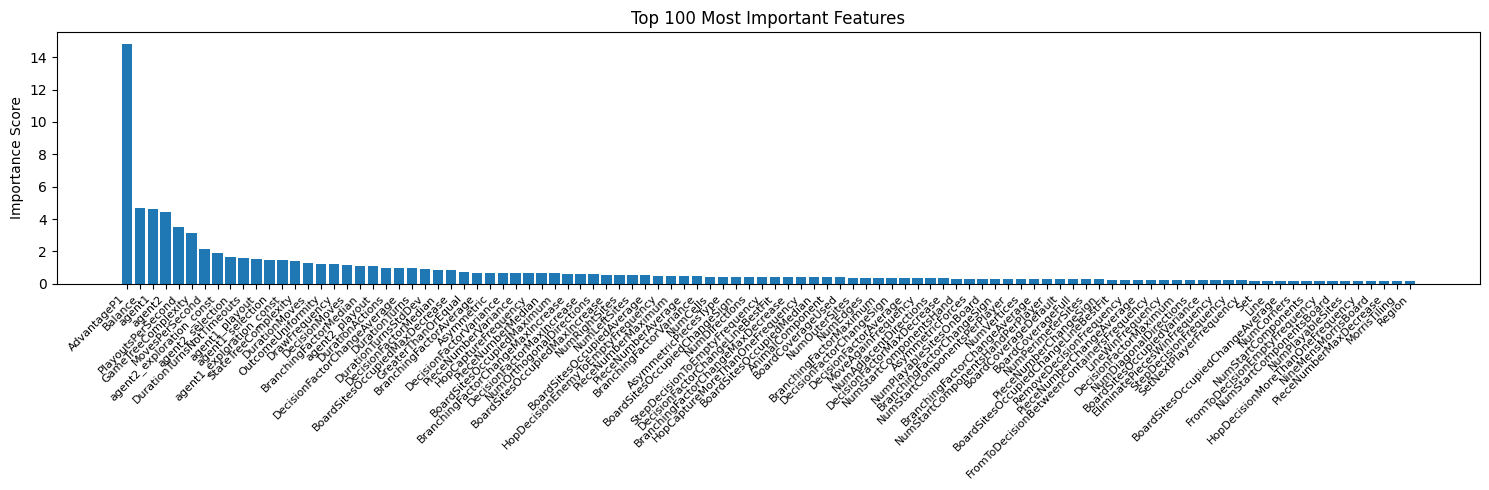

Fold 4 - RMSE: 0.4326982843863883
Fold 5


0:	learn: 0.6238025	test: 0.5915444	best: 0.5915444 (0)	total: 115ms	remaining: 19m 7s


50:	learn: 0.4872526	test: 0.5427864	best: 0.5427864 (50)	total: 6.08s	remaining: 19m 46s


100:	learn: 0.4406204	test: 0.5187826	best: 0.5187826 (100)	total: 12.1s	remaining: 19m 46s


150:	learn: 0.4144437	test: 0.5005501	best: 0.5005501 (150)	total: 18.3s	remaining: 19m 54s


200:	learn: 0.3975065	test: 0.4892128	best: 0.4892128 (200)	total: 24.9s	remaining: 20m 12s


250:	learn: 0.3848150	test: 0.4813999	best: 0.4813999 (250)	total: 31.5s	remaining: 20m 23s


300:	learn: 0.3750487	test: 0.4754956	best: 0.4754956 (300)	total: 38.3s	remaining: 20m 35s


350:	learn: 0.3673844	test: 0.4707439	best: 0.4707439 (350)	total: 45.2s	remaining: 20m 42s


400:	learn: 0.3605443	test: 0.4669894	best: 0.4669894 (400)	total: 52.2s	remaining: 20m 49s


450:	learn: 0.3550133	test: 0.4642618	best: 0.4642618 (450)	total: 59.2s	remaining: 20m 54s


500:	learn: 0.3502897	test: 0.4623929	best: 0.4623929 (500)	total: 1m 6s	remaining: 20m 56s


550:	learn: 0.3455173	test: 0.4601429	best: 0.4601429 (550)	total: 1m 13s	remaining: 20m 54s


600:	learn: 0.3410932	test: 0.4582720	best: 0.4582680 (598)	total: 1m 20s	remaining: 20m 51s


650:	learn: 0.3365782	test: 0.4561450	best: 0.4561450 (650)	total: 1m 26s	remaining: 20m 47s


700:	learn: 0.3322290	test: 0.4537585	best: 0.4537585 (700)	total: 1m 33s	remaining: 20m 39s


750:	learn: 0.3282776	test: 0.4519024	best: 0.4519024 (750)	total: 1m 40s	remaining: 20m 32s


800:	learn: 0.3249080	test: 0.4506459	best: 0.4506459 (800)	total: 1m 46s	remaining: 20m 26s


850:	learn: 0.3215278	test: 0.4495792	best: 0.4495709 (849)	total: 1m 53s	remaining: 20m 20s


900:	learn: 0.3183912	test: 0.4487649	best: 0.4487649 (900)	total: 2m	remaining: 20m 14s


950:	learn: 0.3153956	test: 0.4479050	best: 0.4479050 (950)	total: 2m 7s	remaining: 20m 9s


1000:	learn: 0.3125608	test: 0.4469821	best: 0.4469821 (1000)	total: 2m 13s	remaining: 20m 2s


1050:	learn: 0.3099610	test: 0.4463227	best: 0.4463135 (1047)	total: 2m 20s	remaining: 19m 58s


1100:	learn: 0.3074457	test: 0.4457483	best: 0.4457483 (1100)	total: 2m 27s	remaining: 19m 51s


1150:	learn: 0.3053338	test: 0.4454015	best: 0.4454015 (1150)	total: 2m 34s	remaining: 19m 46s


1200:	learn: 0.3032149	test: 0.4448517	best: 0.4448517 (1200)	total: 2m 41s	remaining: 19m 41s


1250:	learn: 0.3011033	test: 0.4441484	best: 0.4441484 (1250)	total: 2m 47s	remaining: 19m 34s


1300:	learn: 0.2989709	test: 0.4436440	best: 0.4436440 (1300)	total: 2m 54s	remaining: 19m 28s


1350:	learn: 0.2971145	test: 0.4431078	best: 0.4431078 (1350)	total: 3m 1s	remaining: 19m 20s


1400:	learn: 0.2950519	test: 0.4427444	best: 0.4427386 (1398)	total: 3m 8s	remaining: 19m 14s


1450:	learn: 0.2931681	test: 0.4422968	best: 0.4422968 (1450)	total: 3m 15s	remaining: 19m 8s


1500:	learn: 0.2913090	test: 0.4418763	best: 0.4418763 (1500)	total: 3m 21s	remaining: 19m 2s


1550:	learn: 0.2895502	test: 0.4415323	best: 0.4415323 (1550)	total: 3m 28s	remaining: 18m 55s


1600:	learn: 0.2879416	test: 0.4411918	best: 0.4411896 (1599)	total: 3m 35s	remaining: 18m 49s


1650:	learn: 0.2863408	test: 0.4408207	best: 0.4408150 (1644)	total: 3m 42s	remaining: 18m 42s


1700:	learn: 0.2847502	test: 0.4404039	best: 0.4404039 (1700)	total: 3m 48s	remaining: 18m 36s


1750:	learn: 0.2831745	test: 0.4400670	best: 0.4400670 (1750)	total: 3m 55s	remaining: 18m 29s


1800:	learn: 0.2815624	test: 0.4396992	best: 0.4396979 (1797)	total: 4m 2s	remaining: 18m 22s


1850:	learn: 0.2801354	test: 0.4394304	best: 0.4394304 (1850)	total: 4m 9s	remaining: 18m 17s


1900:	learn: 0.2786529	test: 0.4390877	best: 0.4390877 (1900)	total: 4m 15s	remaining: 18m 10s


1950:	learn: 0.2772725	test: 0.4389306	best: 0.4389306 (1950)	total: 4m 22s	remaining: 18m 4s


2000:	learn: 0.2758150	test: 0.4385777	best: 0.4385777 (2000)	total: 4m 29s	remaining: 17m 57s


2050:	learn: 0.2744212	test: 0.4382326	best: 0.4382326 (2050)	total: 4m 36s	remaining: 17m 51s


2100:	learn: 0.2731074	test: 0.4378896	best: 0.4378896 (2100)	total: 4m 43s	remaining: 17m 44s


2150:	learn: 0.2718080	test: 0.4376564	best: 0.4376236 (2144)	total: 4m 50s	remaining: 17m 38s


2200:	learn: 0.2703663	test: 0.4373821	best: 0.4373773 (2197)	total: 4m 56s	remaining: 17m 32s


2250:	learn: 0.2691479	test: 0.4372100	best: 0.4372070 (2249)	total: 5m 3s	remaining: 17m 25s


2300:	learn: 0.2679219	test: 0.4370222	best: 0.4370222 (2300)	total: 5m 10s	remaining: 17m 18s


2350:	learn: 0.2668579	test: 0.4368281	best: 0.4368281 (2350)	total: 5m 17s	remaining: 17m 12s


2400:	learn: 0.2656330	test: 0.4365559	best: 0.4365559 (2400)	total: 5m 24s	remaining: 17m 6s


2450:	learn: 0.2645536	test: 0.4363879	best: 0.4363808 (2449)	total: 5m 31s	remaining: 17m


2500:	learn: 0.2633888	test: 0.4361283	best: 0.4361283 (2500)	total: 5m 38s	remaining: 16m 54s


2550:	learn: 0.2623485	test: 0.4358776	best: 0.4358750 (2549)	total: 5m 45s	remaining: 16m 47s


2600:	learn: 0.2612827	test: 0.4357121	best: 0.4357110 (2599)	total: 5m 51s	remaining: 16m 41s


2650:	learn: 0.2602601	test: 0.4354760	best: 0.4354760 (2650)	total: 5m 58s	remaining: 16m 34s


2700:	learn: 0.2592249	test: 0.4352965	best: 0.4352841 (2696)	total: 6m 5s	remaining: 16m 27s


2750:	learn: 0.2583057	test: 0.4351818	best: 0.4351795 (2746)	total: 6m 12s	remaining: 16m 21s


2800:	learn: 0.2573686	test: 0.4350459	best: 0.4350459 (2800)	total: 6m 19s	remaining: 16m 14s


2850:	learn: 0.2563141	test: 0.4348460	best: 0.4348443 (2843)	total: 6m 26s	remaining: 16m 8s


2900:	learn: 0.2553651	test: 0.4347077	best: 0.4347077 (2900)	total: 6m 33s	remaining: 16m 1s


2950:	learn: 0.2545250	test: 0.4346107	best: 0.4346001 (2945)	total: 6m 39s	remaining: 15m 55s


3000:	learn: 0.2536754	test: 0.4343938	best: 0.4343938 (3000)	total: 6m 46s	remaining: 15m 49s


3050:	learn: 0.2528006	test: 0.4342915	best: 0.4342915 (3050)	total: 6m 53s	remaining: 15m 42s


3100:	learn: 0.2520355	test: 0.4342100	best: 0.4342100 (3100)	total: 7m	remaining: 15m 36s


3150:	learn: 0.2511265	test: 0.4341015	best: 0.4340948 (3142)	total: 7m 7s	remaining: 15m 29s


3200:	learn: 0.2503607	test: 0.4339586	best: 0.4339586 (3200)	total: 7m 14s	remaining: 15m 23s


3250:	learn: 0.2496374	test: 0.4337553	best: 0.4337553 (3250)	total: 7m 21s	remaining: 15m 16s


3300:	learn: 0.2488709	test: 0.4336266	best: 0.4336245 (3299)	total: 7m 28s	remaining: 15m 10s


3350:	learn: 0.2481602	test: 0.4334984	best: 0.4334959 (3349)	total: 7m 35s	remaining: 15m 3s


3400:	learn: 0.2473223	test: 0.4333386	best: 0.4333386 (3399)	total: 7m 42s	remaining: 14m 57s


3450:	learn: 0.2466814	test: 0.4332658	best: 0.4332499 (3442)	total: 7m 49s	remaining: 14m 50s


3500:	learn: 0.2458942	test: 0.4332172	best: 0.4332097 (3495)	total: 7m 56s	remaining: 14m 44s


3550:	learn: 0.2451628	test: 0.4330940	best: 0.4330907 (3549)	total: 8m 3s	remaining: 14m 37s


3600:	learn: 0.2445294	test: 0.4329976	best: 0.4329950 (3596)	total: 8m 10s	remaining: 14m 31s


3650:	learn: 0.2438088	test: 0.4328864	best: 0.4328851 (3649)	total: 8m 17s	remaining: 14m 24s


3700:	learn: 0.2431270	test: 0.4328076	best: 0.4328076 (3700)	total: 8m 24s	remaining: 14m 17s


3750:	learn: 0.2424278	test: 0.4327088	best: 0.4327088 (3750)	total: 8m 30s	remaining: 14m 11s


3800:	learn: 0.2417996	test: 0.4326089	best: 0.4326076 (3799)	total: 8m 37s	remaining: 14m 4s


3850:	learn: 0.2411524	test: 0.4324956	best: 0.4324956 (3850)	total: 8m 44s	remaining: 13m 57s


3900:	learn: 0.2404097	test: 0.4324172	best: 0.4324172 (3900)	total: 8m 51s	remaining: 13m 51s


3950:	learn: 0.2397131	test: 0.4322791	best: 0.4322791 (3950)	total: 8m 58s	remaining: 13m 44s


4000:	learn: 0.2390521	test: 0.4322067	best: 0.4322067 (4000)	total: 9m 5s	remaining: 13m 37s


4050:	learn: 0.2384335	test: 0.4321954	best: 0.4321729 (4029)	total: 9m 12s	remaining: 13m 31s


4100:	learn: 0.2377883	test: 0.4321313	best: 0.4321277 (4098)	total: 9m 19s	remaining: 13m 24s


4150:	learn: 0.2371307	test: 0.4320916	best: 0.4320850 (4136)	total: 9m 26s	remaining: 13m 17s


4200:	learn: 0.2365115	test: 0.4320053	best: 0.4320053 (4200)	total: 9m 33s	remaining: 13m 11s


4250:	learn: 0.2359423	test: 0.4319369	best: 0.4319306 (4244)	total: 9m 40s	remaining: 13m 4s


4300:	learn: 0.2353331	test: 0.4318649	best: 0.4318514 (4291)	total: 9m 47s	remaining: 12m 57s


4350:	learn: 0.2347804	test: 0.4318021	best: 0.4318021 (4350)	total: 9m 54s	remaining: 12m 51s


4400:	learn: 0.2342388	test: 0.4317189	best: 0.4317189 (4400)	total: 10m 1s	remaining: 12m 44s


4450:	learn: 0.2336601	test: 0.4316600	best: 0.4316600 (4450)	total: 10m 8s	remaining: 12m 38s


4500:	learn: 0.2331395	test: 0.4316322	best: 0.4316322 (4500)	total: 10m 15s	remaining: 12m 31s


4550:	learn: 0.2325071	test: 0.4315658	best: 0.4315642 (4548)	total: 10m 22s	remaining: 12m 25s


4600:	learn: 0.2320064	test: 0.4315317	best: 0.4315265 (4599)	total: 10m 29s	remaining: 12m 18s


4650:	learn: 0.2314199	test: 0.4314764	best: 0.4314692 (4648)	total: 10m 36s	remaining: 12m 11s


4700:	learn: 0.2308835	test: 0.4314389	best: 0.4314310 (4688)	total: 10m 43s	remaining: 12m 4s


4750:	learn: 0.2303301	test: 0.4313799	best: 0.4313654 (4745)	total: 10m 50s	remaining: 11m 58s


4800:	learn: 0.2297926	test: 0.4312912	best: 0.4312866 (4794)	total: 10m 56s	remaining: 11m 51s


4850:	learn: 0.2292978	test: 0.4312445	best: 0.4312445 (4850)	total: 11m 3s	remaining: 11m 44s


4900:	learn: 0.2287635	test: 0.4312241	best: 0.4312220 (4898)	total: 11m 10s	remaining: 11m 38s


4950:	learn: 0.2281999	test: 0.4311908	best: 0.4311888 (4935)	total: 11m 17s	remaining: 11m 31s


5000:	learn: 0.2276673	test: 0.4311340	best: 0.4311338 (4999)	total: 11m 24s	remaining: 11m 24s


5050:	learn: 0.2271165	test: 0.4310492	best: 0.4310470 (5049)	total: 11m 31s	remaining: 11m 17s


5100:	learn: 0.2265616	test: 0.4309917	best: 0.4309917 (5100)	total: 11m 38s	remaining: 11m 10s


5150:	learn: 0.2260570	test: 0.4309822	best: 0.4309822 (5150)	total: 11m 45s	remaining: 11m 4s


5200:	learn: 0.2255748	test: 0.4309486	best: 0.4309324 (5184)	total: 11m 52s	remaining: 10m 57s


5250:	learn: 0.2250892	test: 0.4308782	best: 0.4308777 (5249)	total: 11m 59s	remaining: 10m 50s


5300:	learn: 0.2246057	test: 0.4308353	best: 0.4308316 (5298)	total: 12m 6s	remaining: 10m 43s


5350:	learn: 0.2241204	test: 0.4307588	best: 0.4307580 (5343)	total: 12m 13s	remaining: 10m 37s


5400:	learn: 0.2236350	test: 0.4307091	best: 0.4307091 (5400)	total: 12m 20s	remaining: 10m 30s


5450:	learn: 0.2230774	test: 0.4306594	best: 0.4306594 (5450)	total: 12m 27s	remaining: 10m 23s


5500:	learn: 0.2225812	test: 0.4305916	best: 0.4305891 (5499)	total: 12m 34s	remaining: 10m 16s


5550:	learn: 0.2220952	test: 0.4305582	best: 0.4305578 (5527)	total: 12m 41s	remaining: 10m 10s


5600:	learn: 0.2216224	test: 0.4305040	best: 0.4305040 (5600)	total: 12m 48s	remaining: 10m 3s


5650:	learn: 0.2212188	test: 0.4304656	best: 0.4304614 (5644)	total: 12m 55s	remaining: 9m 56s


5700:	learn: 0.2207363	test: 0.4303874	best: 0.4303838 (5699)	total: 13m 2s	remaining: 9m 49s


5750:	learn: 0.2202653	test: 0.4303209	best: 0.4303202 (5748)	total: 13m 8s	remaining: 9m 42s


5800:	learn: 0.2198399	test: 0.4302871	best: 0.4302871 (5800)	total: 13m 16s	remaining: 9m 36s


5850:	learn: 0.2194089	test: 0.4302771	best: 0.4302722 (5837)	total: 13m 23s	remaining: 9m 29s


5900:	learn: 0.2189947	test: 0.4302628	best: 0.4302572 (5898)	total: 13m 30s	remaining: 9m 22s


5950:	learn: 0.2185585	test: 0.4302339	best: 0.4302246 (5935)	total: 13m 37s	remaining: 9m 15s


6000:	learn: 0.2181041	test: 0.4301837	best: 0.4301717 (5989)	total: 13m 43s	remaining: 9m 9s


6050:	learn: 0.2176735	test: 0.4301639	best: 0.4301639 (6050)	total: 13m 50s	remaining: 9m 2s


6100:	learn: 0.2172777	test: 0.4301391	best: 0.4301271 (6079)	total: 13m 57s	remaining: 8m 55s


6150:	learn: 0.2167772	test: 0.4300746	best: 0.4300746 (6150)	total: 14m 4s	remaining: 8m 48s


6200:	learn: 0.2163038	test: 0.4300326	best: 0.4300313 (6195)	total: 14m 11s	remaining: 8m 41s


6250:	learn: 0.2158299	test: 0.4299965	best: 0.4299923 (6226)	total: 14m 18s	remaining: 8m 34s


6300:	learn: 0.2153696	test: 0.4299657	best: 0.4299654 (6299)	total: 14m 25s	remaining: 8m 28s


6350:	learn: 0.2149393	test: 0.4299489	best: 0.4299469 (6320)	total: 14m 32s	remaining: 8m 21s


6400:	learn: 0.2145043	test: 0.4299095	best: 0.4299004 (6395)	total: 14m 39s	remaining: 8m 14s


6450:	learn: 0.2140756	test: 0.4298630	best: 0.4298630 (6450)	total: 14m 46s	remaining: 8m 7s


6500:	learn: 0.2136224	test: 0.4298059	best: 0.4298057 (6496)	total: 14m 53s	remaining: 8m


6550:	learn: 0.2132019	test: 0.4298038	best: 0.4298015 (6547)	total: 14m 59s	remaining: 7m 53s


6600:	learn: 0.2127584	test: 0.4297494	best: 0.4297457 (6592)	total: 15m 6s	remaining: 7m 46s


6650:	learn: 0.2123354	test: 0.4296976	best: 0.4296868 (6648)	total: 15m 13s	remaining: 7m 40s


6700:	learn: 0.2119333	test: 0.4296418	best: 0.4296418 (6700)	total: 15m 20s	remaining: 7m 33s


6750:	learn: 0.2115301	test: 0.4296221	best: 0.4296182 (6738)	total: 15m 27s	remaining: 7m 26s


6800:	learn: 0.2111302	test: 0.4296055	best: 0.4295994 (6780)	total: 15m 34s	remaining: 7m 19s


6850:	learn: 0.2107292	test: 0.4295761	best: 0.4295759 (6847)	total: 15m 41s	remaining: 7m 12s


6900:	learn: 0.2103460	test: 0.4295316	best: 0.4295316 (6900)	total: 15m 48s	remaining: 7m 5s


6950:	learn: 0.2099154	test: 0.4294995	best: 0.4294995 (6950)	total: 15m 55s	remaining: 6m 59s


7000:	learn: 0.2095162	test: 0.4294786	best: 0.4294757 (6999)	total: 16m 2s	remaining: 6m 52s


7050:	learn: 0.2091000	test: 0.4294808	best: 0.4294721 (7011)	total: 16m 9s	remaining: 6m 45s


7100:	learn: 0.2087624	test: 0.4294725	best: 0.4294707 (7097)	total: 16m 16s	remaining: 6m 38s


7150:	learn: 0.2083412	test: 0.4294618	best: 0.4294592 (7126)	total: 16m 23s	remaining: 6m 31s


7200:	learn: 0.2079710	test: 0.4294540	best: 0.4294530 (7156)	total: 16m 30s	remaining: 6m 24s


7250:	learn: 0.2076089	test: 0.4294074	best: 0.4294074 (7250)	total: 16m 37s	remaining: 6m 18s


7300:	learn: 0.2072691	test: 0.4293905	best: 0.4293861 (7292)	total: 16m 44s	remaining: 6m 11s


7350:	learn: 0.2068605	test: 0.4293625	best: 0.4293453 (7336)	total: 16m 50s	remaining: 6m 4s


7400:	learn: 0.2065134	test: 0.4293087	best: 0.4293060 (7398)	total: 16m 57s	remaining: 5m 57s


7450:	learn: 0.2060875	test: 0.4292714	best: 0.4292706 (7449)	total: 17m 5s	remaining: 5m 50s


7500:	learn: 0.2056898	test: 0.4292245	best: 0.4292245 (7500)	total: 17m 12s	remaining: 5m 43s


7550:	learn: 0.2053190	test: 0.4292053	best: 0.4291979 (7529)	total: 17m 18s	remaining: 5m 36s


7600:	learn: 0.2049093	test: 0.4291767	best: 0.4291767 (7600)	total: 17m 25s	remaining: 5m 30s


7650:	learn: 0.2045490	test: 0.4291511	best: 0.4291511 (7650)	total: 17m 32s	remaining: 5m 23s


7700:	learn: 0.2042257	test: 0.4291563	best: 0.4291483 (7651)	total: 17m 39s	remaining: 5m 16s


7750:	learn: 0.2038663	test: 0.4291335	best: 0.4291326 (7741)	total: 17m 46s	remaining: 5m 9s


7800:	learn: 0.2034585	test: 0.4290954	best: 0.4290934 (7798)	total: 17m 53s	remaining: 5m 2s


7850:	learn: 0.2030722	test: 0.4290549	best: 0.4290546 (7849)	total: 18m	remaining: 4m 55s


7900:	learn: 0.2027166	test: 0.4289975	best: 0.4289975 (7900)	total: 18m 7s	remaining: 4m 48s


7950:	learn: 0.2023394	test: 0.4289877	best: 0.4289819 (7910)	total: 18m 14s	remaining: 4m 42s


8000:	learn: 0.2020007	test: 0.4289799	best: 0.4289799 (8000)	total: 18m 21s	remaining: 4m 35s


8050:	learn: 0.2016689	test: 0.4289681	best: 0.4289681 (8050)	total: 18m 28s	remaining: 4m 28s


8100:	learn: 0.2013300	test: 0.4289428	best: 0.4289428 (8100)	total: 18m 35s	remaining: 4m 21s


8150:	learn: 0.2009202	test: 0.4288944	best: 0.4288901 (8145)	total: 18m 42s	remaining: 4m 14s


8200:	learn: 0.2005808	test: 0.4288775	best: 0.4288775 (8200)	total: 18m 49s	remaining: 4m 7s


8250:	learn: 0.2002025	test: 0.4288423	best: 0.4288371 (8243)	total: 18m 56s	remaining: 4m


8300:	learn: 0.1998359	test: 0.4288198	best: 0.4288171 (8294)	total: 19m 3s	remaining: 3m 53s


8350:	learn: 0.1994565	test: 0.4287687	best: 0.4287687 (8350)	total: 19m 9s	remaining: 3m 47s


8400:	learn: 0.1990831	test: 0.4287452	best: 0.4287452 (8400)	total: 19m 16s	remaining: 3m 40s


8450:	learn: 0.1987312	test: 0.4287235	best: 0.4287205 (8438)	total: 19m 23s	remaining: 3m 33s


8500:	learn: 0.1983549	test: 0.4287153	best: 0.4287122 (8482)	total: 19m 30s	remaining: 3m 26s


8550:	learn: 0.1979873	test: 0.4286917	best: 0.4286893 (8535)	total: 19m 37s	remaining: 3m 19s


8600:	learn: 0.1976338	test: 0.4286863	best: 0.4286808 (8559)	total: 19m 44s	remaining: 3m 12s


8650:	learn: 0.1972901	test: 0.4286834	best: 0.4286775 (8616)	total: 19m 51s	remaining: 3m 5s


8700:	learn: 0.1969923	test: 0.4286782	best: 0.4286673 (8684)	total: 19m 58s	remaining: 2m 58s


8750:	learn: 0.1966574	test: 0.4286611	best: 0.4286611 (8750)	total: 20m 5s	remaining: 2m 52s


8800:	learn: 0.1963140	test: 0.4286497	best: 0.4286485 (8797)	total: 20m 12s	remaining: 2m 45s


8850:	learn: 0.1960244	test: 0.4286206	best: 0.4286200 (8848)	total: 20m 19s	remaining: 2m 38s


8900:	learn: 0.1957062	test: 0.4286031	best: 0.4286029 (8898)	total: 20m 26s	remaining: 2m 31s


8950:	learn: 0.1953882	test: 0.4285917	best: 0.4285917 (8950)	total: 20m 33s	remaining: 2m 24s


9000:	learn: 0.1950497	test: 0.4285809	best: 0.4285806 (8998)	total: 20m 39s	remaining: 2m 17s


9050:	learn: 0.1946957	test: 0.4285716	best: 0.4285678 (9033)	total: 20m 46s	remaining: 2m 10s


9100:	learn: 0.1943028	test: 0.4285531	best: 0.4285528 (9098)	total: 20m 53s	remaining: 2m 3s


9150:	learn: 0.1939738	test: 0.4285477	best: 0.4285409 (9111)	total: 21m	remaining: 1m 56s


9200:	learn: 0.1936755	test: 0.4285301	best: 0.4285261 (9186)	total: 21m 7s	remaining: 1m 50s


9250:	learn: 0.1933785	test: 0.4285187	best: 0.4285160 (9248)	total: 21m 14s	remaining: 1m 43s


9300:	learn: 0.1930715	test: 0.4284983	best: 0.4284941 (9295)	total: 21m 20s	remaining: 1m 36s


9350:	learn: 0.1927063	test: 0.4284981	best: 0.4284854 (9318)	total: 21m 27s	remaining: 1m 29s


9400:	learn: 0.1923759	test: 0.4284752	best: 0.4284743 (9399)	total: 21m 34s	remaining: 1m 22s


9450:	learn: 0.1920316	test: 0.4284346	best: 0.4284319 (9446)	total: 21m 41s	remaining: 1m 15s


9500:	learn: 0.1916792	test: 0.4283968	best: 0.4283949 (9488)	total: 21m 48s	remaining: 1m 8s


9550:	learn: 0.1914033	test: 0.4283604	best: 0.4283600 (9548)	total: 21m 55s	remaining: 1m 1s


9600:	learn: 0.1910740	test: 0.4283308	best: 0.4283294 (9580)	total: 22m 2s	remaining: 55s


9650:	learn: 0.1907067	test: 0.4283160	best: 0.4283160 (9650)	total: 22m 9s	remaining: 48.1s


9700:	learn: 0.1903581	test: 0.4283115	best: 0.4283062 (9667)	total: 22m 16s	remaining: 41.2s


9750:	learn: 0.1900486	test: 0.4283143	best: 0.4283062 (9667)	total: 22m 23s	remaining: 34.3s


9800:	learn: 0.1897589	test: 0.4282880	best: 0.4282795 (9786)	total: 22m 30s	remaining: 27.4s


9850:	learn: 0.1894402	test: 0.4282293	best: 0.4282260 (9849)	total: 22m 37s	remaining: 20.5s


9900:	learn: 0.1891158	test: 0.4282071	best: 0.4282071 (9900)	total: 22m 44s	remaining: 13.6s


9950:	learn: 0.1887972	test: 0.4281943	best: 0.4281943 (9950)	total: 22m 50s	remaining: 6.75s


9999:	learn: 0.1884577	test: 0.4281765	best: 0.4281754 (9998)	total: 22m 57s	remaining: 0us

bestTest = 0.4281753765
bestIteration = 9998

Shrink model to first 9999 iterations.


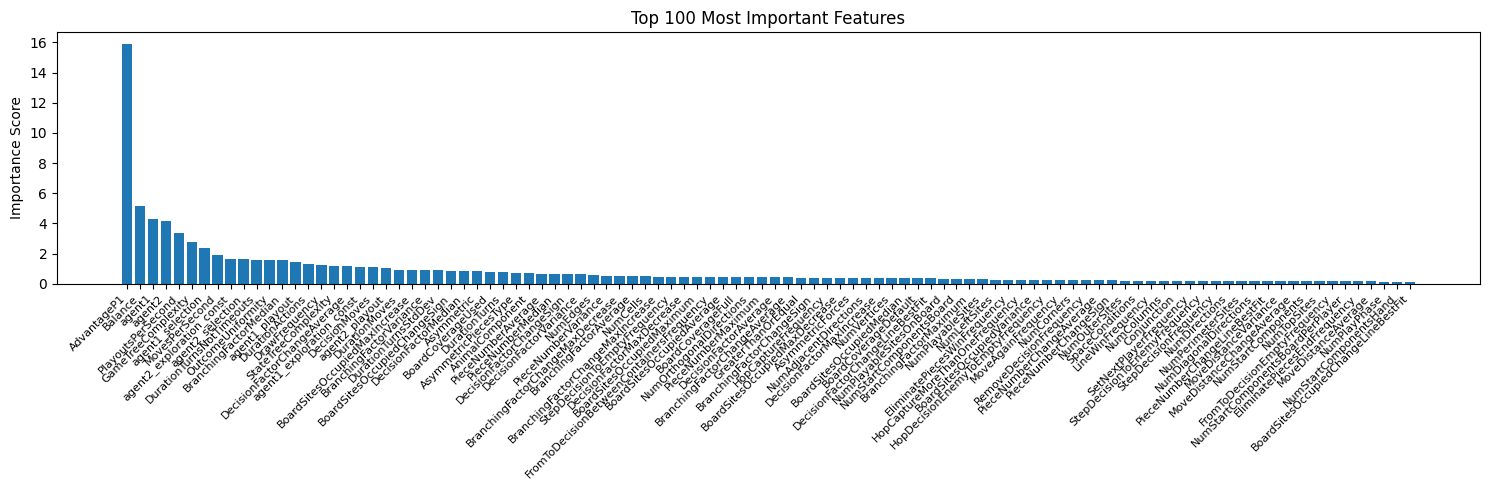

Fold 5 - RMSE: 0.42777281740830014
List of oof scores: [0.4054369956639162, 0.3901070641430095, 0.4228276849918016, 0.4326982843863883, 0.42777281740830014]
Average oof score: 0.4157685693186831


In [12]:
# call the function
trained_models2, oof2, oof_scores2, importance_df2 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    split_list=split2,
)
# save oof predictions
oof2.to_parquet(path_results / f'oof_catboost_{fs_type}_cv2.parquet', index=False)

Fold 1


0:	learn: 0.6271157	test: 0.5760957	best: 0.5760957 (0)	total: 114ms	remaining: 19m 3s


50:	learn: 0.4913347	test: 0.5246266	best: 0.5246266 (50)	total: 5.9s	remaining: 19m 10s


100:	learn: 0.4446936	test: 0.4995705	best: 0.4995705 (100)	total: 11.8s	remaining: 19m 18s


150:	learn: 0.4194822	test: 0.4843870	best: 0.4843870 (150)	total: 17.9s	remaining: 19m 24s


200:	learn: 0.4017291	test: 0.4728691	best: 0.4728499 (199)	total: 24.4s	remaining: 19m 47s


250:	learn: 0.3882572	test: 0.4656482	best: 0.4656482 (250)	total: 30.9s	remaining: 20m


300:	learn: 0.3787533	test: 0.4609497	best: 0.4609497 (300)	total: 37.6s	remaining: 20m 12s


350:	learn: 0.3703773	test: 0.4573445	best: 0.4573445 (350)	total: 44.3s	remaining: 20m 17s


400:	learn: 0.3630108	test: 0.4544251	best: 0.4544251 (400)	total: 51.1s	remaining: 20m 22s


450:	learn: 0.3567543	test: 0.4520306	best: 0.4520306 (450)	total: 57.9s	remaining: 20m 26s


500:	learn: 0.3510987	test: 0.4497520	best: 0.4497520 (500)	total: 1m 4s	remaining: 20m 21s


550:	learn: 0.3451288	test: 0.4475069	best: 0.4475069 (550)	total: 1m 10s	remaining: 20m 15s


600:	learn: 0.3398416	test: 0.4457674	best: 0.4457674 (600)	total: 1m 17s	remaining: 20m 7s


650:	learn: 0.3349821	test: 0.4440508	best: 0.4440508 (650)	total: 1m 23s	remaining: 20m 1s


700:	learn: 0.3308881	test: 0.4427774	best: 0.4427774 (700)	total: 1m 30s	remaining: 19m 58s


750:	learn: 0.3269010	test: 0.4413503	best: 0.4413503 (750)	total: 1m 36s	remaining: 19m 51s


800:	learn: 0.3235693	test: 0.4403519	best: 0.4403519 (800)	total: 1m 43s	remaining: 19m 47s


850:	learn: 0.3204567	test: 0.4394351	best: 0.4394351 (850)	total: 1m 50s	remaining: 19m 43s


900:	learn: 0.3173618	test: 0.4387405	best: 0.4387405 (900)	total: 1m 56s	remaining: 19m 37s


950:	learn: 0.3145316	test: 0.4380462	best: 0.4380456 (949)	total: 2m 3s	remaining: 19m 33s


1000:	learn: 0.3123231	test: 0.4375601	best: 0.4375601 (1000)	total: 2m 10s	remaining: 19m 29s


1050:	learn: 0.3098957	test: 0.4369799	best: 0.4369799 (1050)	total: 2m 16s	remaining: 19m 25s


1100:	learn: 0.3077654	test: 0.4363882	best: 0.4363882 (1100)	total: 2m 23s	remaining: 19m 19s


1150:	learn: 0.3054546	test: 0.4357906	best: 0.4357906 (1150)	total: 2m 30s	remaining: 19m 14s


1200:	learn: 0.3032053	test: 0.4354539	best: 0.4354392 (1199)	total: 2m 36s	remaining: 19m 9s


1250:	learn: 0.3009907	test: 0.4349670	best: 0.4349670 (1250)	total: 2m 43s	remaining: 19m 3s


1300:	learn: 0.2990196	test: 0.4346554	best: 0.4346554 (1300)	total: 2m 50s	remaining: 18m 57s


1350:	learn: 0.2970667	test: 0.4342083	best: 0.4341960 (1349)	total: 2m 56s	remaining: 18m 51s


1400:	learn: 0.2952278	test: 0.4336769	best: 0.4336740 (1399)	total: 3m 3s	remaining: 18m 45s


1450:	learn: 0.2934457	test: 0.4335151	best: 0.4335151 (1450)	total: 3m 10s	remaining: 18m 39s


1500:	learn: 0.2918327	test: 0.4331090	best: 0.4331090 (1500)	total: 3m 16s	remaining: 18m 33s


1550:	learn: 0.2900489	test: 0.4328612	best: 0.4328612 (1550)	total: 3m 23s	remaining: 18m 28s


1600:	learn: 0.2883603	test: 0.4326058	best: 0.4326058 (1600)	total: 3m 30s	remaining: 18m 23s


1650:	learn: 0.2867303	test: 0.4322913	best: 0.4322644 (1642)	total: 3m 36s	remaining: 18m 16s


1700:	learn: 0.2851542	test: 0.4320677	best: 0.4320540 (1698)	total: 3m 43s	remaining: 18m 10s


1750:	learn: 0.2836034	test: 0.4317419	best: 0.4317365 (1748)	total: 3m 49s	remaining: 18m 3s


1800:	learn: 0.2819626	test: 0.4314587	best: 0.4314587 (1800)	total: 3m 56s	remaining: 17m 56s


1850:	learn: 0.2805661	test: 0.4313025	best: 0.4313022 (1849)	total: 4m 3s	remaining: 17m 50s


1900:	learn: 0.2790746	test: 0.4310732	best: 0.4310730 (1899)	total: 4m 9s	remaining: 17m 43s


1950:	learn: 0.2777351	test: 0.4307571	best: 0.4307571 (1950)	total: 4m 16s	remaining: 17m 37s


2000:	learn: 0.2763232	test: 0.4304485	best: 0.4304485 (2000)	total: 4m 23s	remaining: 17m 31s


2050:	learn: 0.2749904	test: 0.4302042	best: 0.4302016 (2048)	total: 4m 29s	remaining: 17m 24s


2100:	learn: 0.2738413	test: 0.4300506	best: 0.4300486 (2099)	total: 4m 36s	remaining: 17m 18s


2150:	learn: 0.2724378	test: 0.4299564	best: 0.4299555 (2149)	total: 4m 42s	remaining: 17m 12s


2200:	learn: 0.2711407	test: 0.4297131	best: 0.4297131 (2200)	total: 4m 49s	remaining: 17m 5s


2250:	learn: 0.2698930	test: 0.4294237	best: 0.4294190 (2245)	total: 4m 55s	remaining: 16m 58s


2300:	learn: 0.2686005	test: 0.4292124	best: 0.4292077 (2294)	total: 5m 2s	remaining: 16m 51s


2350:	learn: 0.2673744	test: 0.4290472	best: 0.4290293 (2336)	total: 5m 8s	remaining: 16m 44s


2400:	learn: 0.2662230	test: 0.4288437	best: 0.4288437 (2400)	total: 5m 15s	remaining: 16m 38s


2450:	learn: 0.2651380	test: 0.4287147	best: 0.4287084 (2448)	total: 5m 22s	remaining: 16m 32s


2500:	learn: 0.2640329	test: 0.4285027	best: 0.4285007 (2499)	total: 5m 28s	remaining: 16m 26s


2550:	learn: 0.2629280	test: 0.4283364	best: 0.4283331 (2548)	total: 5m 35s	remaining: 16m 19s


2600:	learn: 0.2618989	test: 0.4281202	best: 0.4281193 (2597)	total: 5m 42s	remaining: 16m 12s


2650:	learn: 0.2608687	test: 0.4279777	best: 0.4279772 (2649)	total: 5m 48s	remaining: 16m 6s


2700:	learn: 0.2599498	test: 0.4278567	best: 0.4278533 (2695)	total: 5m 55s	remaining: 16m


2750:	learn: 0.2589998	test: 0.4277177	best: 0.4277134 (2748)	total: 6m 2s	remaining: 15m 54s


2800:	learn: 0.2580861	test: 0.4276212	best: 0.4276017 (2794)	total: 6m 9s	remaining: 15m 48s


2850:	learn: 0.2572173	test: 0.4274522	best: 0.4274506 (2849)	total: 6m 15s	remaining: 15m 42s


2900:	learn: 0.2562634	test: 0.4273096	best: 0.4273028 (2899)	total: 6m 22s	remaining: 15m 35s


2950:	learn: 0.2552836	test: 0.4272195	best: 0.4272184 (2949)	total: 6m 29s	remaining: 15m 29s


3000:	learn: 0.2543344	test: 0.4271101	best: 0.4270986 (2992)	total: 6m 35s	remaining: 15m 22s


3050:	learn: 0.2534294	test: 0.4269227	best: 0.4269203 (3049)	total: 6m 42s	remaining: 15m 16s


3100:	learn: 0.2525538	test: 0.4268337	best: 0.4268264 (3096)	total: 6m 48s	remaining: 15m 9s


3150:	learn: 0.2516823	test: 0.4267092	best: 0.4267090 (3149)	total: 6m 55s	remaining: 15m 3s


3200:	learn: 0.2507277	test: 0.4265647	best: 0.4265548 (3195)	total: 7m 2s	remaining: 14m 56s


3250:	learn: 0.2499580	test: 0.4264351	best: 0.4264351 (3250)	total: 7m 8s	remaining: 14m 50s


3300:	learn: 0.2490761	test: 0.4263726	best: 0.4263676 (3289)	total: 7m 15s	remaining: 14m 43s


3350:	learn: 0.2482556	test: 0.4262444	best: 0.4262386 (3344)	total: 7m 22s	remaining: 14m 37s


3400:	learn: 0.2474723	test: 0.4261934	best: 0.4261499 (3387)	total: 7m 28s	remaining: 14m 30s


3450:	learn: 0.2466684	test: 0.4260844	best: 0.4260844 (3450)	total: 7m 35s	remaining: 14m 24s


3500:	learn: 0.2459407	test: 0.4260903	best: 0.4260821 (3452)	total: 7m 42s	remaining: 14m 17s


3550:	learn: 0.2452205	test: 0.4259678	best: 0.4259678 (3550)	total: 7m 48s	remaining: 14m 11s


3600:	learn: 0.2445495	test: 0.4258725	best: 0.4258503 (3578)	total: 7m 55s	remaining: 14m 5s


3650:	learn: 0.2438076	test: 0.4257868	best: 0.4257798 (3642)	total: 8m 2s	remaining: 13m 58s


3700:	learn: 0.2431160	test: 0.4256691	best: 0.4256691 (3700)	total: 8m 8s	remaining: 13m 52s


3750:	learn: 0.2423974	test: 0.4256148	best: 0.4256148 (3750)	total: 8m 15s	remaining: 13m 45s


3800:	learn: 0.2416766	test: 0.4255340	best: 0.4255340 (3800)	total: 8m 22s	remaining: 13m 39s


3850:	learn: 0.2409571	test: 0.4254860	best: 0.4254807 (3842)	total: 8m 29s	remaining: 13m 32s


3900:	learn: 0.2402313	test: 0.4253240	best: 0.4253240 (3900)	total: 8m 35s	remaining: 13m 26s


3950:	learn: 0.2395329	test: 0.4252926	best: 0.4252659 (3947)	total: 8m 42s	remaining: 13m 19s


4000:	learn: 0.2388825	test: 0.4252376	best: 0.4252376 (4000)	total: 8m 49s	remaining: 13m 13s


4050:	learn: 0.2381966	test: 0.4251690	best: 0.4251606 (4042)	total: 8m 55s	remaining: 13m 6s


4100:	learn: 0.2376256	test: 0.4251405	best: 0.4251402 (4086)	total: 9m 2s	remaining: 13m


4150:	learn: 0.2369474	test: 0.4250791	best: 0.4250771 (4149)	total: 9m 9s	remaining: 12m 53s


4200:	learn: 0.2362961	test: 0.4250387	best: 0.4250387 (4200)	total: 9m 15s	remaining: 12m 47s


4250:	learn: 0.2356369	test: 0.4249639	best: 0.4249605 (4249)	total: 9m 22s	remaining: 12m 40s


4300:	learn: 0.2349892	test: 0.4249082	best: 0.4249082 (4300)	total: 9m 29s	remaining: 12m 34s


4350:	learn: 0.2344118	test: 0.4248529	best: 0.4248431 (4347)	total: 9m 36s	remaining: 12m 27s


4400:	learn: 0.2338041	test: 0.4248264	best: 0.4248218 (4395)	total: 9m 42s	remaining: 12m 21s


4450:	learn: 0.2333068	test: 0.4248029	best: 0.4248029 (4450)	total: 9m 49s	remaining: 12m 15s


4500:	learn: 0.2326996	test: 0.4247750	best: 0.4247750 (4500)	total: 9m 56s	remaining: 12m 8s


4550:	learn: 0.2321227	test: 0.4247188	best: 0.4247188 (4550)	total: 10m 2s	remaining: 12m 1s


4600:	learn: 0.2315841	test: 0.4247412	best: 0.4247188 (4550)	total: 10m 9s	remaining: 11m 55s


4650:	learn: 0.2309400	test: 0.4246993	best: 0.4246993 (4650)	total: 10m 16s	remaining: 11m 48s


4700:	learn: 0.2304280	test: 0.4246633	best: 0.4246595 (4698)	total: 10m 23s	remaining: 11m 42s


4750:	learn: 0.2298555	test: 0.4246395	best: 0.4246277 (4729)	total: 10m 29s	remaining: 11m 35s


4800:	learn: 0.2293664	test: 0.4245819	best: 0.4245802 (4792)	total: 10m 36s	remaining: 11m 29s


4850:	learn: 0.2288043	test: 0.4245192	best: 0.4245192 (4850)	total: 10m 43s	remaining: 11m 22s


4900:	learn: 0.2281903	test: 0.4244638	best: 0.4244452 (4892)	total: 10m 49s	remaining: 11m 16s


4950:	learn: 0.2277314	test: 0.4244146	best: 0.4244088 (4946)	total: 10m 56s	remaining: 11m 9s


5000:	learn: 0.2272615	test: 0.4244298	best: 0.4244088 (4946)	total: 11m 3s	remaining: 11m 3s


5050:	learn: 0.2266552	test: 0.4243804	best: 0.4243803 (5049)	total: 11m 9s	remaining: 10m 56s


5100:	learn: 0.2261429	test: 0.4243067	best: 0.4243067 (5100)	total: 11m 16s	remaining: 10m 49s


5150:	learn: 0.2256053	test: 0.4242320	best: 0.4242302 (5149)	total: 11m 23s	remaining: 10m 43s


5200:	learn: 0.2251436	test: 0.4242049	best: 0.4242033 (5195)	total: 11m 29s	remaining: 10m 36s


5250:	learn: 0.2246773	test: 0.4241991	best: 0.4241980 (5224)	total: 11m 36s	remaining: 10m 29s


5300:	learn: 0.2241704	test: 0.4242037	best: 0.4241980 (5224)	total: 11m 43s	remaining: 10m 23s


5350:	learn: 0.2237277	test: 0.4241776	best: 0.4241776 (5350)	total: 11m 50s	remaining: 10m 16s


5400:	learn: 0.2232080	test: 0.4241726	best: 0.4241606 (5360)	total: 11m 56s	remaining: 10m 10s


5450:	learn: 0.2226910	test: 0.4241484	best: 0.4241443 (5441)	total: 12m 3s	remaining: 10m 3s


5500:	learn: 0.2222336	test: 0.4241065	best: 0.4241055 (5499)	total: 12m 10s	remaining: 9m 57s


5550:	learn: 0.2217507	test: 0.4240965	best: 0.4240802 (5531)	total: 12m 16s	remaining: 9m 50s


5600:	learn: 0.2214039	test: 0.4240756	best: 0.4240627 (5593)	total: 12m 23s	remaining: 9m 44s


5650:	learn: 0.2209450	test: 0.4240801	best: 0.4240627 (5593)	total: 12m 30s	remaining: 9m 37s


5700:	learn: 0.2205551	test: 0.4240411	best: 0.4240411 (5699)	total: 12m 37s	remaining: 9m 30s


5750:	learn: 0.2200768	test: 0.4240291	best: 0.4240268 (5746)	total: 12m 43s	remaining: 9m 24s


5800:	learn: 0.2195549	test: 0.4239947	best: 0.4239947 (5800)	total: 12m 50s	remaining: 9m 17s


5850:	learn: 0.2190567	test: 0.4239637	best: 0.4239637 (5850)	total: 12m 57s	remaining: 9m 11s


5900:	learn: 0.2185716	test: 0.4239083	best: 0.4239015 (5893)	total: 13m 3s	remaining: 9m 4s


5950:	learn: 0.2180590	test: 0.4238442	best: 0.4238401 (5948)	total: 13m 9s	remaining: 8m 57s


6000:	learn: 0.2176006	test: 0.4238335	best: 0.4238231 (5975)	total: 13m 16s	remaining: 8m 50s


6050:	learn: 0.2170915	test: 0.4238418	best: 0.4238231 (5975)	total: 13m 23s	remaining: 8m 44s


6100:	learn: 0.2165344	test: 0.4237979	best: 0.4237979 (6100)	total: 13m 29s	remaining: 8m 37s


6150:	learn: 0.2160852	test: 0.4237690	best: 0.4237684 (6149)	total: 13m 36s	remaining: 8m 30s


6200:	learn: 0.2156851	test: 0.4237637	best: 0.4237637 (6200)	total: 13m 43s	remaining: 8m 24s


6250:	learn: 0.2152639	test: 0.4237384	best: 0.4237352 (6248)	total: 13m 49s	remaining: 8m 17s


6300:	learn: 0.2147937	test: 0.4236946	best: 0.4236945 (6297)	total: 13m 56s	remaining: 8m 11s


6350:	learn: 0.2143530	test: 0.4236564	best: 0.4236564 (6350)	total: 14m 3s	remaining: 8m 4s


6400:	learn: 0.2139483	test: 0.4236380	best: 0.4236270 (6382)	total: 14m 9s	remaining: 7m 57s


6450:	learn: 0.2134915	test: 0.4236293	best: 0.4236270 (6382)	total: 14m 16s	remaining: 7m 51s


6500:	learn: 0.2130650	test: 0.4236273	best: 0.4236224 (6494)	total: 14m 23s	remaining: 7m 44s


6550:	learn: 0.2126619	test: 0.4236312	best: 0.4236224 (6494)	total: 14m 29s	remaining: 7m 37s


6600:	learn: 0.2123068	test: 0.4236040	best: 0.4236034 (6597)	total: 14m 36s	remaining: 7m 31s


6650:	learn: 0.2119070	test: 0.4235857	best: 0.4235720 (6639)	total: 14m 43s	remaining: 7m 24s


6700:	learn: 0.2114635	test: 0.4235621	best: 0.4235621 (6700)	total: 14m 49s	remaining: 7m 18s


6750:	learn: 0.2110945	test: 0.4235349	best: 0.4235349 (6750)	total: 14m 56s	remaining: 7m 11s


6800:	learn: 0.2107183	test: 0.4235125	best: 0.4235125 (6800)	total: 15m 3s	remaining: 7m 5s


6850:	learn: 0.2102918	test: 0.4234948	best: 0.4234948 (6850)	total: 15m 10s	remaining: 6m 58s


6900:	learn: 0.2099065	test: 0.4234957	best: 0.4234879 (6896)	total: 15m 17s	remaining: 6m 51s


6950:	learn: 0.2094831	test: 0.4235036	best: 0.4234850 (6918)	total: 15m 23s	remaining: 6m 45s


7000:	learn: 0.2090387	test: 0.4234910	best: 0.4234850 (6918)	total: 15m 29s	remaining: 6m 38s


7050:	learn: 0.2086446	test: 0.4234567	best: 0.4234550 (7046)	total: 15m 36s	remaining: 6m 31s


7100:	learn: 0.2082273	test: 0.4234280	best: 0.4234240 (7089)	total: 15m 43s	remaining: 6m 25s


7150:	learn: 0.2078861	test: 0.4234176	best: 0.4234096 (7134)	total: 15m 49s	remaining: 6m 18s


7200:	learn: 0.2075031	test: 0.4234151	best: 0.4234014 (7162)	total: 15m 56s	remaining: 6m 11s


7250:	learn: 0.2071284	test: 0.4233962	best: 0.4233831 (7244)	total: 16m 3s	remaining: 6m 5s


7300:	learn: 0.2066921	test: 0.4233450	best: 0.4233447 (7298)	total: 16m 10s	remaining: 5m 58s


7350:	learn: 0.2063727	test: 0.4233229	best: 0.4233163 (7321)	total: 16m 17s	remaining: 5m 52s


7400:	learn: 0.2059526	test: 0.4233127	best: 0.4233118 (7395)	total: 16m 23s	remaining: 5m 45s


7450:	learn: 0.2055681	test: 0.4232772	best: 0.4232772 (7450)	total: 16m 30s	remaining: 5m 38s


7500:	learn: 0.2051855	test: 0.4232801	best: 0.4232770 (7479)	total: 16m 37s	remaining: 5m 32s


7550:	learn: 0.2048194	test: 0.4232870	best: 0.4232651 (7503)	total: 16m 43s	remaining: 5m 25s


7600:	learn: 0.2044595	test: 0.4232773	best: 0.4232651 (7503)	total: 16m 50s	remaining: 5m 18s


7650:	learn: 0.2040967	test: 0.4232730	best: 0.4232651 (7503)	total: 16m 57s	remaining: 5m 12s


7700:	learn: 0.2037536	test: 0.4232492	best: 0.4232472 (7699)	total: 17m 4s	remaining: 5m 5s


7750:	learn: 0.2033557	test: 0.4232116	best: 0.4232106 (7736)	total: 17m 10s	remaining: 4m 59s


7800:	learn: 0.2029741	test: 0.4231690	best: 0.4231690 (7800)	total: 17m 17s	remaining: 4m 52s


7850:	learn: 0.2026620	test: 0.4231604	best: 0.4231557 (7837)	total: 17m 24s	remaining: 4m 45s


7900:	learn: 0.2023144	test: 0.4231308	best: 0.4231299 (7895)	total: 17m 30s	remaining: 4m 39s


7950:	learn: 0.2020001	test: 0.4231173	best: 0.4231173 (7950)	total: 17m 37s	remaining: 4m 32s


8000:	learn: 0.2016368	test: 0.4230986	best: 0.4230986 (8000)	total: 17m 44s	remaining: 4m 25s


8050:	learn: 0.2012429	test: 0.4230945	best: 0.4230865 (8040)	total: 17m 50s	remaining: 4m 19s


8100:	learn: 0.2009131	test: 0.4230998	best: 0.4230865 (8040)	total: 17m 57s	remaining: 4m 12s


8150:	learn: 0.2005404	test: 0.4230993	best: 0.4230865 (8040)	total: 18m 4s	remaining: 4m 5s


8200:	learn: 0.2001979	test: 0.4230924	best: 0.4230865 (8040)	total: 18m 10s	remaining: 3m 59s


8250:	learn: 0.1999198	test: 0.4230995	best: 0.4230854 (8218)	total: 18m 17s	remaining: 3m 52s


8300:	learn: 0.1995946	test: 0.4230671	best: 0.4230671 (8300)	total: 18m 24s	remaining: 3m 46s


8350:	learn: 0.1993066	test: 0.4230538	best: 0.4230408 (8315)	total: 18m 31s	remaining: 3m 39s


8400:	learn: 0.1989345	test: 0.4230432	best: 0.4230403 (8399)	total: 18m 37s	remaining: 3m 32s


8450:	learn: 0.1985880	test: 0.4230135	best: 0.4230135 (8450)	total: 18m 44s	remaining: 3m 26s


8500:	learn: 0.1982477	test: 0.4230048	best: 0.4229971 (8479)	total: 18m 51s	remaining: 3m 19s


8550:	learn: 0.1979141	test: 0.4229660	best: 0.4229647 (8548)	total: 18m 58s	remaining: 3m 12s


8600:	learn: 0.1975182	test: 0.4229483	best: 0.4229425 (8583)	total: 19m 4s	remaining: 3m 6s


8650:	learn: 0.1971717	test: 0.4229522	best: 0.4229425 (8583)	total: 19m 11s	remaining: 2m 59s


8700:	learn: 0.1968253	test: 0.4229243	best: 0.4229225 (8698)	total: 19m 17s	remaining: 2m 52s


8750:	learn: 0.1964752	test: 0.4228944	best: 0.4228937 (8747)	total: 19m 24s	remaining: 2m 46s


8800:	learn: 0.1961256	test: 0.4228843	best: 0.4228843 (8800)	total: 19m 31s	remaining: 2m 39s


8850:	learn: 0.1957847	test: 0.4228687	best: 0.4228667 (8836)	total: 19m 38s	remaining: 2m 32s


8900:	learn: 0.1954327	test: 0.4228641	best: 0.4228519 (8879)	total: 19m 44s	remaining: 2m 26s


8950:	learn: 0.1951249	test: 0.4228519	best: 0.4228518 (8948)	total: 19m 51s	remaining: 2m 19s


9000:	learn: 0.1947788	test: 0.4228297	best: 0.4228293 (8997)	total: 19m 58s	remaining: 2m 12s


9050:	learn: 0.1944332	test: 0.4228060	best: 0.4228051 (9046)	total: 20m 4s	remaining: 2m 6s


9100:	learn: 0.1940917	test: 0.4228088	best: 0.4227966 (9072)	total: 20m 11s	remaining: 1m 59s


9150:	learn: 0.1937948	test: 0.4228007	best: 0.4227899 (9135)	total: 20m 18s	remaining: 1m 53s


9200:	learn: 0.1934403	test: 0.4227926	best: 0.4227899 (9135)	total: 20m 24s	remaining: 1m 46s


9250:	learn: 0.1931396	test: 0.4227861	best: 0.4227770 (9235)	total: 20m 31s	remaining: 1m 39s


9300:	learn: 0.1928169	test: 0.4227856	best: 0.4227770 (9235)	total: 20m 38s	remaining: 1m 33s


9350:	learn: 0.1924848	test: 0.4227817	best: 0.4227661 (9323)	total: 20m 44s	remaining: 1m 26s


9400:	learn: 0.1921459	test: 0.4227895	best: 0.4227661 (9323)	total: 20m 51s	remaining: 1m 19s


9450:	learn: 0.1917824	test: 0.4227544	best: 0.4227525 (9442)	total: 20m 58s	remaining: 1m 13s


9500:	learn: 0.1915212	test: 0.4227450	best: 0.4227402 (9489)	total: 21m 4s	remaining: 1m 6s


9550:	learn: 0.1912235	test: 0.4227441	best: 0.4227402 (9489)	total: 21m 11s	remaining: 59.8s


9600:	learn: 0.1909033	test: 0.4227394	best: 0.4227385 (9588)	total: 21m 18s	remaining: 53.1s


9650:	learn: 0.1905899	test: 0.4227272	best: 0.4227160 (9635)	total: 21m 24s	remaining: 46.5s


9700:	learn: 0.1902717	test: 0.4227166	best: 0.4227101 (9684)	total: 21m 31s	remaining: 39.8s


9750:	learn: 0.1898938	test: 0.4227033	best: 0.4226990 (9745)	total: 21m 38s	remaining: 33.2s


9800:	learn: 0.1896132	test: 0.4226781	best: 0.4226759 (9796)	total: 21m 44s	remaining: 26.5s


9850:	learn: 0.1893337	test: 0.4226646	best: 0.4226634 (9845)	total: 21m 51s	remaining: 19.8s


9900:	learn: 0.1890476	test: 0.4226474	best: 0.4226466 (9895)	total: 21m 58s	remaining: 13.2s


9950:	learn: 0.1887385	test: 0.4226429	best: 0.4226392 (9944)	total: 22m 4s	remaining: 6.52s


9999:	learn: 0.1883910	test: 0.4226232	best: 0.4226224 (9998)	total: 22m 11s	remaining: 0us

bestTest = 0.4226223545
bestIteration = 9998

Shrink model to first 9999 iterations.


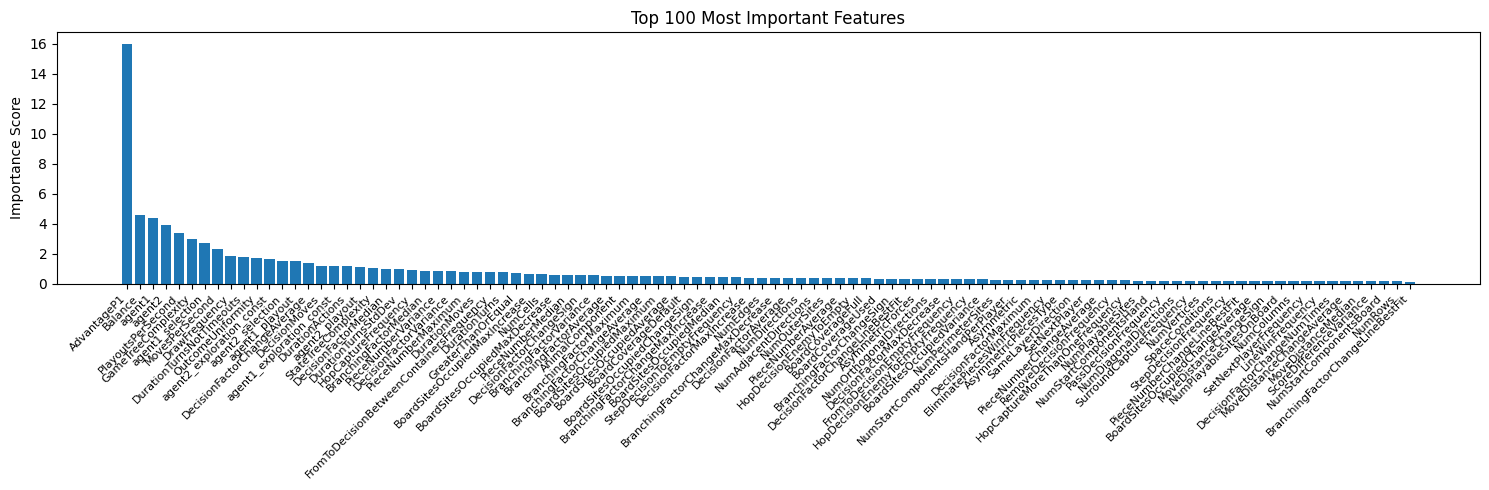

Fold 1 - RMSE: 0.42232624677466823
Fold 2


0:	learn: 0.6263996	test: 0.5750259	best: 0.5750259 (0)	total: 120ms	remaining: 20m


50:	learn: 0.4886862	test: 0.5249797	best: 0.5249797 (50)	total: 5.82s	remaining: 18m 55s


100:	learn: 0.4435168	test: 0.5005226	best: 0.5005226 (100)	total: 11.8s	remaining: 19m 17s


150:	learn: 0.4180302	test: 0.4845009	best: 0.4845009 (150)	total: 17.9s	remaining: 19m 26s


200:	learn: 0.4024883	test: 0.4735632	best: 0.4735632 (200)	total: 24.4s	remaining: 19m 49s


250:	learn: 0.3896302	test: 0.4642680	best: 0.4642680 (250)	total: 31.1s	remaining: 20m 8s


300:	learn: 0.3791901	test: 0.4573414	best: 0.4573414 (300)	total: 37.7s	remaining: 20m 16s


350:	learn: 0.3716130	test: 0.4529496	best: 0.4529496 (350)	total: 44.6s	remaining: 20m 26s


400:	learn: 0.3642821	test: 0.4488790	best: 0.4488790 (400)	total: 51.4s	remaining: 20m 29s


450:	learn: 0.3578725	test: 0.4453244	best: 0.4453244 (450)	total: 58.1s	remaining: 20m 29s


500:	learn: 0.3521982	test: 0.4423580	best: 0.4423580 (500)	total: 1m 4s	remaining: 20m 28s


550:	learn: 0.3472632	test: 0.4398349	best: 0.4398349 (550)	total: 1m 11s	remaining: 20m 23s


600:	learn: 0.3425456	test: 0.4378680	best: 0.4378656 (599)	total: 1m 17s	remaining: 20m 18s


650:	learn: 0.3381570	test: 0.4358024	best: 0.4358024 (650)	total: 1m 24s	remaining: 20m 14s


700:	learn: 0.3339259	test: 0.4339038	best: 0.4339038 (700)	total: 1m 31s	remaining: 20m 8s


750:	learn: 0.3298302	test: 0.4318329	best: 0.4318329 (750)	total: 1m 37s	remaining: 20m 2s


800:	learn: 0.3259610	test: 0.4302220	best: 0.4302220 (800)	total: 1m 44s	remaining: 19m 58s


850:	learn: 0.3225466	test: 0.4288347	best: 0.4288347 (850)	total: 1m 50s	remaining: 19m 52s


900:	learn: 0.3195267	test: 0.4278618	best: 0.4278618 (900)	total: 1m 57s	remaining: 19m 46s


950:	learn: 0.3162768	test: 0.4267242	best: 0.4267242 (950)	total: 2m 3s	remaining: 19m 39s


1000:	learn: 0.3134654	test: 0.4255313	best: 0.4255313 (1000)	total: 2m 10s	remaining: 19m 34s


1050:	learn: 0.3109998	test: 0.4246589	best: 0.4246589 (1050)	total: 2m 17s	remaining: 19m 29s


1100:	learn: 0.3084784	test: 0.4238012	best: 0.4238012 (1100)	total: 2m 23s	remaining: 19m 22s


1150:	learn: 0.3060566	test: 0.4228878	best: 0.4228878 (1150)	total: 2m 30s	remaining: 19m 16s


1200:	learn: 0.3037048	test: 0.4221425	best: 0.4221425 (1200)	total: 2m 36s	remaining: 19m 9s


1250:	learn: 0.3015380	test: 0.4214685	best: 0.4214685 (1250)	total: 2m 43s	remaining: 19m 3s


1300:	learn: 0.2993982	test: 0.4207127	best: 0.4207127 (1300)	total: 2m 50s	remaining: 19m


1350:	learn: 0.2974744	test: 0.4200115	best: 0.4200115 (1350)	total: 2m 57s	remaining: 18m 56s


1400:	learn: 0.2955373	test: 0.4194377	best: 0.4194371 (1399)	total: 3m 4s	remaining: 18m 50s


1450:	learn: 0.2936483	test: 0.4188364	best: 0.4188364 (1450)	total: 3m 10s	remaining: 18m 44s


1500:	learn: 0.2919755	test: 0.4183234	best: 0.4183234 (1500)	total: 3m 17s	remaining: 18m 38s


1550:	learn: 0.2903030	test: 0.4177641	best: 0.4177641 (1550)	total: 3m 24s	remaining: 18m 33s


1600:	learn: 0.2885778	test: 0.4172085	best: 0.4172085 (1600)	total: 3m 31s	remaining: 18m 27s


1650:	learn: 0.2869502	test: 0.4167622	best: 0.4167622 (1650)	total: 3m 37s	remaining: 18m 21s


1700:	learn: 0.2853774	test: 0.4164107	best: 0.4164107 (1700)	total: 3m 44s	remaining: 18m 15s


1750:	learn: 0.2836638	test: 0.4159950	best: 0.4159950 (1750)	total: 3m 51s	remaining: 18m 8s


1800:	learn: 0.2821144	test: 0.4155864	best: 0.4155721 (1799)	total: 3m 58s	remaining: 18m 3s


1850:	learn: 0.2805823	test: 0.4153061	best: 0.4153006 (1848)	total: 4m 4s	remaining: 17m 57s


1900:	learn: 0.2790804	test: 0.4149550	best: 0.4149490 (1897)	total: 4m 11s	remaining: 17m 51s


1950:	learn: 0.2777049	test: 0.4146694	best: 0.4146612 (1949)	total: 4m 18s	remaining: 17m 44s


2000:	learn: 0.2762114	test: 0.4143243	best: 0.4143243 (2000)	total: 4m 24s	remaining: 17m 38s


2050:	learn: 0.2747861	test: 0.4140360	best: 0.4140360 (2050)	total: 4m 31s	remaining: 17m 31s


2100:	learn: 0.2734510	test: 0.4136408	best: 0.4136408 (2100)	total: 4m 37s	remaining: 17m 24s


2150:	learn: 0.2720654	test: 0.4132587	best: 0.4132587 (2150)	total: 4m 44s	remaining: 17m 17s


2200:	learn: 0.2707869	test: 0.4130267	best: 0.4130267 (2200)	total: 4m 51s	remaining: 17m 11s


2250:	learn: 0.2694350	test: 0.4127702	best: 0.4127679 (2249)	total: 4m 58s	remaining: 17m 6s


2300:	learn: 0.2681517	test: 0.4123966	best: 0.4123966 (2300)	total: 5m 4s	remaining: 16m 59s


2350:	learn: 0.2669128	test: 0.4121524	best: 0.4121512 (2349)	total: 5m 11s	remaining: 16m 53s


2400:	learn: 0.2656569	test: 0.4118282	best: 0.4118282 (2400)	total: 5m 18s	remaining: 16m 46s


2450:	learn: 0.2645560	test: 0.4116405	best: 0.4116228 (2446)	total: 5m 24s	remaining: 16m 40s


2500:	learn: 0.2635243	test: 0.4114070	best: 0.4114070 (2500)	total: 5m 31s	remaining: 16m 33s


2550:	learn: 0.2624031	test: 0.4111979	best: 0.4111929 (2549)	total: 5m 38s	remaining: 16m 27s


2600:	learn: 0.2611495	test: 0.4109061	best: 0.4109061 (2600)	total: 5m 44s	remaining: 16m 20s


2650:	learn: 0.2600671	test: 0.4107061	best: 0.4107061 (2650)	total: 5m 51s	remaining: 16m 13s


2700:	learn: 0.2590880	test: 0.4104959	best: 0.4104930 (2698)	total: 5m 57s	remaining: 16m 7s


2750:	learn: 0.2581165	test: 0.4103430	best: 0.4103430 (2750)	total: 6m 4s	remaining: 16m


2800:	learn: 0.2569776	test: 0.4100421	best: 0.4100407 (2799)	total: 6m 11s	remaining: 15m 53s


2850:	learn: 0.2559470	test: 0.4098622	best: 0.4098489 (2849)	total: 6m 17s	remaining: 15m 46s


2900:	learn: 0.2548934	test: 0.4097057	best: 0.4097057 (2900)	total: 6m 24s	remaining: 15m 40s


2950:	learn: 0.2539404	test: 0.4094852	best: 0.4094852 (2950)	total: 6m 30s	remaining: 15m 33s


3000:	learn: 0.2530227	test: 0.4093310	best: 0.4093308 (2999)	total: 6m 37s	remaining: 15m 27s


3050:	learn: 0.2521313	test: 0.4092326	best: 0.4092261 (3047)	total: 6m 44s	remaining: 15m 20s


3100:	learn: 0.2512251	test: 0.4091025	best: 0.4091012 (3099)	total: 6m 50s	remaining: 15m 14s


3150:	learn: 0.2502419	test: 0.4088488	best: 0.4088488 (3150)	total: 6m 57s	remaining: 15m 7s


3200:	learn: 0.2492803	test: 0.4086811	best: 0.4086811 (3200)	total: 7m 3s	remaining: 15m


3250:	learn: 0.2484652	test: 0.4085525	best: 0.4085501 (3246)	total: 7m 10s	remaining: 14m 54s


3300:	learn: 0.2476559	test: 0.4084419	best: 0.4084386 (3299)	total: 7m 17s	remaining: 14m 47s


3350:	learn: 0.2468597	test: 0.4083211	best: 0.4083211 (3350)	total: 7m 24s	remaining: 14m 40s


3400:	learn: 0.2460492	test: 0.4082014	best: 0.4082014 (3400)	total: 7m 30s	remaining: 14m 34s


3450:	learn: 0.2451299	test: 0.4080691	best: 0.4080653 (3446)	total: 7m 37s	remaining: 14m 27s


3500:	learn: 0.2443065	test: 0.4079456	best: 0.4079438 (3499)	total: 7m 43s	remaining: 14m 20s


3550:	learn: 0.2435329	test: 0.4077548	best: 0.4077479 (3548)	total: 7m 50s	remaining: 14m 14s


3600:	learn: 0.2427866	test: 0.4076568	best: 0.4076568 (3600)	total: 7m 57s	remaining: 14m 7s


3650:	learn: 0.2420051	test: 0.4075221	best: 0.4075217 (3649)	total: 8m 3s	remaining: 14m 1s


3700:	learn: 0.2412771	test: 0.4073949	best: 0.4073949 (3700)	total: 8m 10s	remaining: 13m 54s


3750:	learn: 0.2405805	test: 0.4072806	best: 0.4072806 (3750)	total: 8m 17s	remaining: 13m 48s


3800:	learn: 0.2398699	test: 0.4072000	best: 0.4072000 (3800)	total: 8m 23s	remaining: 13m 41s


3850:	learn: 0.2391715	test: 0.4071545	best: 0.4071531 (3849)	total: 8m 30s	remaining: 13m 34s


3900:	learn: 0.2384612	test: 0.4070452	best: 0.4070452 (3900)	total: 8m 37s	remaining: 13m 28s


3950:	learn: 0.2377556	test: 0.4069462	best: 0.4069462 (3950)	total: 8m 43s	remaining: 13m 21s


4000:	learn: 0.2371431	test: 0.4068404	best: 0.4068404 (4000)	total: 8m 50s	remaining: 13m 15s


4050:	learn: 0.2364935	test: 0.4067615	best: 0.4067503 (4045)	total: 8m 57s	remaining: 13m 8s


4100:	learn: 0.2358364	test: 0.4067088	best: 0.4067004 (4099)	total: 9m 3s	remaining: 13m 2s


4150:	learn: 0.2352438	test: 0.4066023	best: 0.4065996 (4148)	total: 9m 10s	remaining: 12m 55s


4200:	learn: 0.2345388	test: 0.4065495	best: 0.4065416 (4199)	total: 9m 17s	remaining: 12m 49s


4250:	learn: 0.2339289	test: 0.4065192	best: 0.4065192 (4250)	total: 9m 23s	remaining: 12m 42s


4300:	learn: 0.2332743	test: 0.4064678	best: 0.4064658 (4299)	total: 9m 30s	remaining: 12m 35s


4350:	learn: 0.2327128	test: 0.4063949	best: 0.4063949 (4347)	total: 9m 37s	remaining: 12m 29s


4400:	learn: 0.2320698	test: 0.4063053	best: 0.4062823 (4391)	total: 9m 43s	remaining: 12m 22s


4450:	learn: 0.2315147	test: 0.4062132	best: 0.4062132 (4450)	total: 9m 50s	remaining: 12m 16s


4500:	learn: 0.2309165	test: 0.4061838	best: 0.4061784 (4482)	total: 9m 57s	remaining: 12m 9s


4550:	learn: 0.2303197	test: 0.4061648	best: 0.4061622 (4548)	total: 10m 3s	remaining: 12m 3s


4600:	learn: 0.2297668	test: 0.4061167	best: 0.4061167 (4600)	total: 10m 10s	remaining: 11m 56s


4650:	learn: 0.2291924	test: 0.4060899	best: 0.4060899 (4650)	total: 10m 17s	remaining: 11m 49s


4700:	learn: 0.2286317	test: 0.4060078	best: 0.4060051 (4698)	total: 10m 24s	remaining: 11m 43s


4750:	learn: 0.2280617	test: 0.4059390	best: 0.4059363 (4746)	total: 10m 30s	remaining: 11m 37s


4800:	learn: 0.2275065	test: 0.4058470	best: 0.4058459 (4799)	total: 10m 37s	remaining: 11m 30s


4850:	learn: 0.2269214	test: 0.4057842	best: 0.4057794 (4847)	total: 10m 44s	remaining: 11m 23s


4900:	learn: 0.2264402	test: 0.4057420	best: 0.4057420 (4900)	total: 10m 51s	remaining: 11m 17s


4950:	learn: 0.2259309	test: 0.4057104	best: 0.4057071 (4946)	total: 10m 58s	remaining: 11m 11s


5000:	learn: 0.2254794	test: 0.4056685	best: 0.4056660 (4999)	total: 11m 4s	remaining: 11m 4s


5050:	learn: 0.2248732	test: 0.4056043	best: 0.4056043 (5050)	total: 11m 11s	remaining: 10m 58s


5100:	learn: 0.2243792	test: 0.4055701	best: 0.4055701 (5100)	total: 11m 18s	remaining: 10m 51s


5150:	learn: 0.2239024	test: 0.4055409	best: 0.4055287 (5147)	total: 11m 25s	remaining: 10m 45s


5200:	learn: 0.2234079	test: 0.4054393	best: 0.4054390 (5199)	total: 11m 31s	remaining: 10m 38s


5250:	learn: 0.2228894	test: 0.4053651	best: 0.4053651 (5249)	total: 11m 38s	remaining: 10m 31s


5300:	learn: 0.2224137	test: 0.4053284	best: 0.4053252 (5283)	total: 11m 45s	remaining: 10m 25s


5350:	learn: 0.2218761	test: 0.4052514	best: 0.4052514 (5350)	total: 11m 52s	remaining: 10m 18s


5400:	learn: 0.2213753	test: 0.4052078	best: 0.4052078 (5400)	total: 11m 58s	remaining: 10m 12s


5450:	learn: 0.2209066	test: 0.4051798	best: 0.4051739 (5440)	total: 12m 5s	remaining: 10m 5s


5500:	learn: 0.2204090	test: 0.4051498	best: 0.4051457 (5484)	total: 12m 12s	remaining: 9m 59s


5550:	learn: 0.2198836	test: 0.4051214	best: 0.4051178 (5544)	total: 12m 19s	remaining: 9m 52s


5600:	learn: 0.2194561	test: 0.4050813	best: 0.4050813 (5600)	total: 12m 25s	remaining: 9m 45s


5650:	learn: 0.2189793	test: 0.4050498	best: 0.4050485 (5649)	total: 12m 32s	remaining: 9m 39s


5700:	learn: 0.2184577	test: 0.4049981	best: 0.4049922 (5695)	total: 12m 39s	remaining: 9m 32s


5750:	learn: 0.2179632	test: 0.4049191	best: 0.4049191 (5750)	total: 12m 46s	remaining: 9m 26s


5800:	learn: 0.2174754	test: 0.4048867	best: 0.4048771 (5795)	total: 12m 52s	remaining: 9m 19s


5850:	learn: 0.2169653	test: 0.4048336	best: 0.4048336 (5850)	total: 12m 59s	remaining: 9m 12s


5900:	learn: 0.2164907	test: 0.4048181	best: 0.4048139 (5888)	total: 13m 6s	remaining: 9m 6s


5950:	learn: 0.2159788	test: 0.4047987	best: 0.4047925 (5949)	total: 13m 13s	remaining: 8m 59s


6000:	learn: 0.2155467	test: 0.4047384	best: 0.4047384 (6000)	total: 13m 20s	remaining: 8m 53s


6050:	learn: 0.2150407	test: 0.4047024	best: 0.4047024 (6050)	total: 13m 26s	remaining: 8m 46s


6100:	learn: 0.2145149	test: 0.4046201	best: 0.4046201 (6100)	total: 13m 33s	remaining: 8m 39s


6150:	learn: 0.2140924	test: 0.4046085	best: 0.4046085 (6150)	total: 13m 40s	remaining: 8m 33s


6200:	learn: 0.2137140	test: 0.4045992	best: 0.4045910 (6191)	total: 13m 46s	remaining: 8m 26s


6250:	learn: 0.2132648	test: 0.4045536	best: 0.4045513 (6247)	total: 13m 53s	remaining: 8m 19s


6300:	learn: 0.2128245	test: 0.4045220	best: 0.4045220 (6300)	total: 14m	remaining: 8m 13s


6350:	learn: 0.2124041	test: 0.4044943	best: 0.4044943 (6350)	total: 14m 7s	remaining: 8m 6s


6400:	learn: 0.2119320	test: 0.4044587	best: 0.4044443 (6377)	total: 14m 13s	remaining: 8m


6450:	learn: 0.2115521	test: 0.4044095	best: 0.4044095 (6449)	total: 14m 20s	remaining: 7m 53s


6500:	learn: 0.2111511	test: 0.4043587	best: 0.4043587 (6500)	total: 14m 27s	remaining: 7m 46s


6550:	learn: 0.2107238	test: 0.4043325	best: 0.4043325 (6550)	total: 14m 34s	remaining: 7m 40s


6600:	learn: 0.2102972	test: 0.4043132	best: 0.4043126 (6598)	total: 14m 40s	remaining: 7m 33s


6650:	learn: 0.2098950	test: 0.4042854	best: 0.4042847 (6649)	total: 14m 47s	remaining: 7m 26s


6700:	learn: 0.2094914	test: 0.4042382	best: 0.4042328 (6699)	total: 14m 54s	remaining: 7m 20s


6750:	learn: 0.2091092	test: 0.4042136	best: 0.4042136 (6750)	total: 15m 1s	remaining: 7m 13s


6800:	learn: 0.2086686	test: 0.4041896	best: 0.4041895 (6797)	total: 15m 7s	remaining: 7m 6s


6850:	learn: 0.2082369	test: 0.4041579	best: 0.4041577 (6849)	total: 15m 14s	remaining: 7m


6900:	learn: 0.2078688	test: 0.4041020	best: 0.4040960 (6899)	total: 15m 21s	remaining: 6m 53s


6950:	learn: 0.2074222	test: 0.4040334	best: 0.4040285 (6941)	total: 15m 28s	remaining: 6m 47s


7000:	learn: 0.2069661	test: 0.4040024	best: 0.4040012 (6998)	total: 15m 34s	remaining: 6m 40s


7050:	learn: 0.2065991	test: 0.4039865	best: 0.4039764 (7043)	total: 15m 41s	remaining: 6m 33s


7100:	learn: 0.2061826	test: 0.4039596	best: 0.4039537 (7092)	total: 15m 48s	remaining: 6m 27s


7150:	learn: 0.2057118	test: 0.4039245	best: 0.4039244 (7148)	total: 15m 54s	remaining: 6m 20s


7200:	learn: 0.2053591	test: 0.4039077	best: 0.4039071 (7197)	total: 16m 1s	remaining: 6m 13s


7250:	learn: 0.2049964	test: 0.4039051	best: 0.4039018 (7208)	total: 16m 8s	remaining: 6m 7s


7300:	learn: 0.2046241	test: 0.4038812	best: 0.4038765 (7286)	total: 16m 15s	remaining: 6m


7350:	learn: 0.2042558	test: 0.4038460	best: 0.4038439 (7345)	total: 16m 22s	remaining: 5m 53s


7400:	learn: 0.2038291	test: 0.4038162	best: 0.4038162 (7400)	total: 16m 28s	remaining: 5m 47s


7450:	learn: 0.2034189	test: 0.4037771	best: 0.4037771 (7450)	total: 16m 35s	remaining: 5m 40s


7500:	learn: 0.2030152	test: 0.4037558	best: 0.4037558 (7500)	total: 16m 42s	remaining: 5m 33s


7550:	learn: 0.2026262	test: 0.4037415	best: 0.4037415 (7550)	total: 16m 48s	remaining: 5m 27s


7600:	learn: 0.2022778	test: 0.4037519	best: 0.4037308 (7574)	total: 16m 55s	remaining: 5m 20s


7650:	learn: 0.2018777	test: 0.4037218	best: 0.4037163 (7640)	total: 17m 2s	remaining: 5m 13s


7700:	learn: 0.2014918	test: 0.4037213	best: 0.4037120 (7654)	total: 17m 8s	remaining: 5m 7s


7750:	learn: 0.2010765	test: 0.4036968	best: 0.4036956 (7745)	total: 17m 15s	remaining: 5m


7800:	learn: 0.2006837	test: 0.4036737	best: 0.4036697 (7793)	total: 17m 22s	remaining: 4m 53s


7850:	learn: 0.2002895	test: 0.4036450	best: 0.4036444 (7847)	total: 17m 28s	remaining: 4m 47s


7900:	learn: 0.1999424	test: 0.4036291	best: 0.4036291 (7900)	total: 17m 35s	remaining: 4m 40s


7950:	learn: 0.1995766	test: 0.4035952	best: 0.4035952 (7950)	total: 17m 42s	remaining: 4m 33s


8000:	learn: 0.1992200	test: 0.4035850	best: 0.4035796 (7965)	total: 17m 49s	remaining: 4m 27s


8050:	learn: 0.1988343	test: 0.4035806	best: 0.4035776 (8040)	total: 17m 55s	remaining: 4m 20s


8100:	learn: 0.1984967	test: 0.4035551	best: 0.4035498 (8092)	total: 18m 2s	remaining: 4m 13s


8150:	learn: 0.1981226	test: 0.4035362	best: 0.4035336 (8148)	total: 18m 9s	remaining: 4m 7s


8200:	learn: 0.1977300	test: 0.4034888	best: 0.4034887 (8195)	total: 18m 15s	remaining: 4m


8250:	learn: 0.1973798	test: 0.4034791	best: 0.4034769 (8216)	total: 18m 22s	remaining: 3m 53s


8300:	learn: 0.1970103	test: 0.4034324	best: 0.4034323 (8299)	total: 18m 28s	remaining: 3m 46s


8350:	learn: 0.1966439	test: 0.4033884	best: 0.4033881 (8334)	total: 18m 35s	remaining: 3m 40s


8400:	learn: 0.1962904	test: 0.4033566	best: 0.4033566 (8400)	total: 18m 42s	remaining: 3m 33s


8450:	learn: 0.1958956	test: 0.4033450	best: 0.4033450 (8450)	total: 18m 49s	remaining: 3m 26s


8500:	learn: 0.1955202	test: 0.4033379	best: 0.4033349 (8481)	total: 18m 55s	remaining: 3m 20s


8550:	learn: 0.1951294	test: 0.4033179	best: 0.4033140 (8526)	total: 19m 2s	remaining: 3m 13s


8600:	learn: 0.1948204	test: 0.4033006	best: 0.4033006 (8600)	total: 19m 9s	remaining: 3m 6s


8650:	learn: 0.1944581	test: 0.4032751	best: 0.4032751 (8650)	total: 19m 15s	remaining: 3m


8700:	learn: 0.1941163	test: 0.4032312	best: 0.4032312 (8700)	total: 19m 22s	remaining: 2m 53s


8750:	learn: 0.1937973	test: 0.4032311	best: 0.4032209 (8713)	total: 19m 29s	remaining: 2m 46s


8800:	learn: 0.1934836	test: 0.4032187	best: 0.4032182 (8796)	total: 19m 35s	remaining: 2m 40s


8850:	learn: 0.1931044	test: 0.4031946	best: 0.4031933 (8849)	total: 19m 42s	remaining: 2m 33s


8900:	learn: 0.1927409	test: 0.4031578	best: 0.4031566 (8894)	total: 19m 49s	remaining: 2m 26s


8950:	learn: 0.1924234	test: 0.4031457	best: 0.4031457 (8950)	total: 19m 55s	remaining: 2m 20s


9000:	learn: 0.1921102	test: 0.4031353	best: 0.4031218 (8978)	total: 20m 2s	remaining: 2m 13s


9050:	learn: 0.1917842	test: 0.4031038	best: 0.4030996 (9046)	total: 20m 9s	remaining: 2m 6s


9100:	learn: 0.1914774	test: 0.4030765	best: 0.4030744 (9098)	total: 20m 15s	remaining: 2m


9150:	learn: 0.1911552	test: 0.4030717	best: 0.4030717 (9150)	total: 20m 22s	remaining: 1m 53s


9200:	learn: 0.1908144	test: 0.4030413	best: 0.4030343 (9192)	total: 20m 29s	remaining: 1m 46s


9250:	learn: 0.1905087	test: 0.4030172	best: 0.4030163 (9246)	total: 20m 36s	remaining: 1m 40s


9300:	learn: 0.1901932	test: 0.4029993	best: 0.4029993 (9300)	total: 20m 42s	remaining: 1m 33s


9350:	learn: 0.1898647	test: 0.4029817	best: 0.4029805 (9349)	total: 20m 49s	remaining: 1m 26s


9400:	learn: 0.1895215	test: 0.4029685	best: 0.4029632 (9394)	total: 20m 56s	remaining: 1m 20s


9450:	learn: 0.1891999	test: 0.4029564	best: 0.4029564 (9450)	total: 21m 3s	remaining: 1m 13s


9500:	learn: 0.1888954	test: 0.4029440	best: 0.4029418 (9493)	total: 21m 9s	remaining: 1m 6s


9550:	learn: 0.1885653	test: 0.4029105	best: 0.4029105 (9550)	total: 21m 16s	remaining: 1m


9600:	learn: 0.1882745	test: 0.4029067	best: 0.4028986 (9574)	total: 21m 23s	remaining: 53.3s


9650:	learn: 0.1879663	test: 0.4029133	best: 0.4028960 (9622)	total: 21m 30s	remaining: 46.7s


9700:	learn: 0.1876756	test: 0.4028958	best: 0.4028838 (9689)	total: 21m 36s	remaining: 40s


9750:	learn: 0.1874059	test: 0.4028836	best: 0.4028812 (9745)	total: 21m 43s	remaining: 33.3s


9800:	learn: 0.1870670	test: 0.4029019	best: 0.4028809 (9756)	total: 21m 50s	remaining: 26.6s


9850:	learn: 0.1867273	test: 0.4028817	best: 0.4028809 (9756)	total: 21m 57s	remaining: 19.9s


9900:	learn: 0.1863573	test: 0.4028748	best: 0.4028697 (9878)	total: 22m 3s	remaining: 13.2s


9950:	learn: 0.1860152	test: 0.4028633	best: 0.4028626 (9921)	total: 22m 10s	remaining: 6.55s


9999:	learn: 0.1857102	test: 0.4028664	best: 0.4028528 (9984)	total: 22m 17s	remaining: 0us

bestTest = 0.4028528058
bestIteration = 9984

Shrink model to first 9985 iterations.


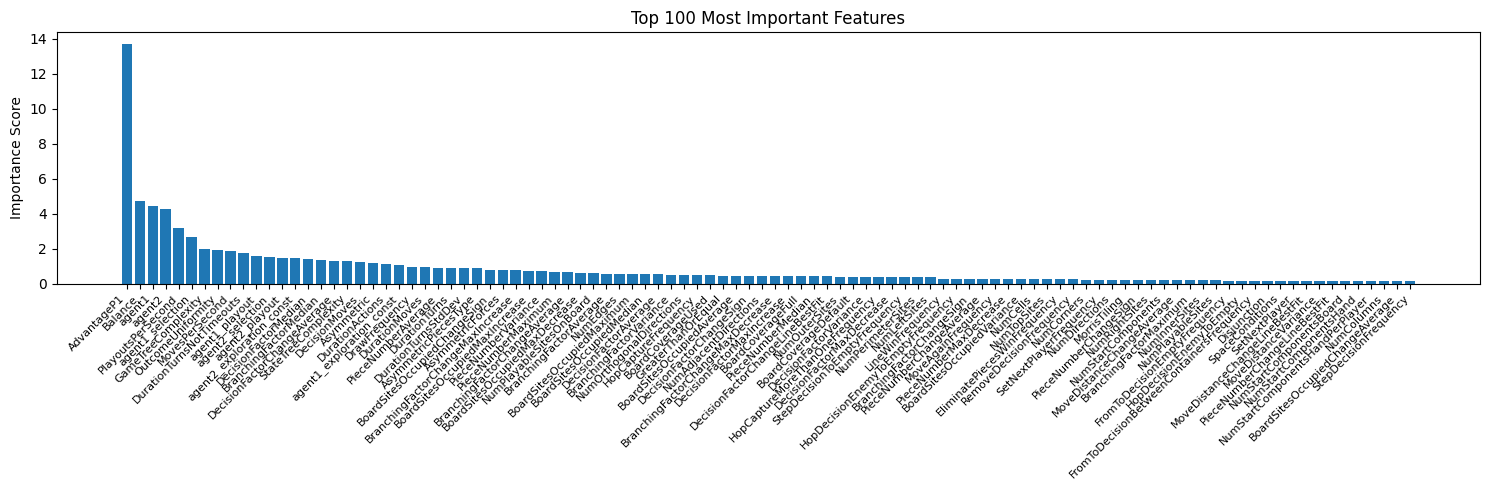

Fold 2 - RMSE: 0.4025623021398531
Fold 3


0:	learn: 0.6290061	test: 0.5775861	best: 0.5775861 (0)	total: 123ms	remaining: 20m 29s


50:	learn: 0.4934650	test: 0.5188480	best: 0.5188480 (50)	total: 5.82s	remaining: 18m 55s


100:	learn: 0.4469619	test: 0.4915176	best: 0.4915176 (100)	total: 11.7s	remaining: 19m 7s


150:	learn: 0.4209000	test: 0.4776953	best: 0.4776953 (150)	total: 17.8s	remaining: 19m 18s


200:	learn: 0.4017853	test: 0.4666198	best: 0.4666198 (200)	total: 24.1s	remaining: 19m 35s


250:	learn: 0.3887440	test: 0.4603737	best: 0.4603737 (250)	total: 30.5s	remaining: 19m 45s


300:	learn: 0.3777288	test: 0.4546381	best: 0.4546381 (300)	total: 36.9s	remaining: 19m 50s


350:	learn: 0.3693770	test: 0.4509732	best: 0.4509732 (350)	total: 43.3s	remaining: 19m 50s


400:	learn: 0.3623600	test: 0.4478589	best: 0.4478589 (400)	total: 49.8s	remaining: 19m 52s


450:	learn: 0.3555277	test: 0.4448472	best: 0.4448472 (450)	total: 56.2s	remaining: 19m 50s


500:	learn: 0.3495686	test: 0.4425263	best: 0.4425263 (500)	total: 1m 2s	remaining: 19m 49s


550:	learn: 0.3440760	test: 0.4401164	best: 0.4401164 (550)	total: 1m 9s	remaining: 19m 46s


600:	learn: 0.3390092	test: 0.4382554	best: 0.4382554 (600)	total: 1m 15s	remaining: 19m 40s


650:	learn: 0.3344468	test: 0.4366449	best: 0.4366449 (650)	total: 1m 21s	remaining: 19m 34s


700:	learn: 0.3304075	test: 0.4351640	best: 0.4351640 (700)	total: 1m 28s	remaining: 19m 30s


750:	learn: 0.3267656	test: 0.4338413	best: 0.4338271 (749)	total: 1m 34s	remaining: 19m 27s


800:	learn: 0.3231186	test: 0.4328325	best: 0.4328325 (800)	total: 1m 41s	remaining: 19m 22s


850:	learn: 0.3200450	test: 0.4319796	best: 0.4319796 (850)	total: 1m 47s	remaining: 19m 17s


900:	learn: 0.3171100	test: 0.4310855	best: 0.4310855 (900)	total: 1m 54s	remaining: 19m 14s


950:	learn: 0.3141154	test: 0.4304371	best: 0.4304275 (944)	total: 2m	remaining: 19m 9s


1000:	learn: 0.3115534	test: 0.4299594	best: 0.4299594 (1000)	total: 2m 7s	remaining: 19m 5s


1050:	learn: 0.3089915	test: 0.4292768	best: 0.4292768 (1050)	total: 2m 13s	remaining: 18m 59s


1100:	learn: 0.3064659	test: 0.4286683	best: 0.4286683 (1100)	total: 2m 20s	remaining: 18m 53s


1150:	learn: 0.3042053	test: 0.4281538	best: 0.4281538 (1150)	total: 2m 26s	remaining: 18m 47s


1200:	learn: 0.3021690	test: 0.4276495	best: 0.4276495 (1200)	total: 2m 33s	remaining: 18m 44s


1250:	learn: 0.2998717	test: 0.4271499	best: 0.4271437 (1249)	total: 2m 40s	remaining: 18m 40s


1300:	learn: 0.2978169	test: 0.4266784	best: 0.4266743 (1299)	total: 2m 46s	remaining: 18m 35s


1350:	learn: 0.2957332	test: 0.4261800	best: 0.4261800 (1350)	total: 2m 53s	remaining: 18m 29s


1400:	learn: 0.2938488	test: 0.4258944	best: 0.4258944 (1400)	total: 2m 59s	remaining: 18m 24s


1450:	learn: 0.2919413	test: 0.4255154	best: 0.4255154 (1450)	total: 3m 6s	remaining: 18m 18s


1500:	learn: 0.2903334	test: 0.4251709	best: 0.4251683 (1499)	total: 3m 13s	remaining: 18m 13s


1550:	learn: 0.2886620	test: 0.4248744	best: 0.4248325 (1546)	total: 3m 19s	remaining: 18m 7s


1600:	learn: 0.2866334	test: 0.4244374	best: 0.4244374 (1600)	total: 3m 26s	remaining: 18m 1s


1650:	learn: 0.2848042	test: 0.4239576	best: 0.4239576 (1650)	total: 3m 32s	remaining: 17m 55s


1700:	learn: 0.2833682	test: 0.4236851	best: 0.4236837 (1697)	total: 3m 39s	remaining: 17m 49s


1750:	learn: 0.2817618	test: 0.4231409	best: 0.4231409 (1750)	total: 3m 45s	remaining: 17m 44s


1800:	learn: 0.2801756	test: 0.4227428	best: 0.4227428 (1800)	total: 3m 52s	remaining: 17m 37s


1850:	learn: 0.2786589	test: 0.4225058	best: 0.4225058 (1850)	total: 3m 58s	remaining: 17m 31s


1900:	learn: 0.2771613	test: 0.4221774	best: 0.4221774 (1900)	total: 4m 5s	remaining: 17m 25s


1950:	learn: 0.2758188	test: 0.4218249	best: 0.4218249 (1950)	total: 4m 12s	remaining: 17m 19s


2000:	learn: 0.2743530	test: 0.4214352	best: 0.4214352 (2000)	total: 4m 18s	remaining: 17m 13s


2050:	learn: 0.2729633	test: 0.4211295	best: 0.4211295 (2050)	total: 4m 25s	remaining: 17m 8s


2100:	learn: 0.2717079	test: 0.4208228	best: 0.4208228 (2100)	total: 4m 32s	remaining: 17m 2s


2150:	learn: 0.2703896	test: 0.4206103	best: 0.4206010 (2149)	total: 4m 38s	remaining: 16m 56s


2200:	learn: 0.2691719	test: 0.4205334	best: 0.4205298 (2199)	total: 4m 45s	remaining: 16m 50s


2250:	learn: 0.2677951	test: 0.4202260	best: 0.4202260 (2250)	total: 4m 51s	remaining: 16m 43s


2300:	learn: 0.2666612	test: 0.4200443	best: 0.4200443 (2300)	total: 4m 58s	remaining: 16m 37s


2350:	learn: 0.2654686	test: 0.4197987	best: 0.4197987 (2350)	total: 5m 4s	remaining: 16m 31s


2400:	learn: 0.2643494	test: 0.4196984	best: 0.4196902 (2390)	total: 5m 11s	remaining: 16m 24s


2450:	learn: 0.2632898	test: 0.4195009	best: 0.4195009 (2450)	total: 5m 17s	remaining: 16m 18s


2500:	learn: 0.2622085	test: 0.4192840	best: 0.4192840 (2500)	total: 5m 24s	remaining: 16m 12s


2550:	learn: 0.2611071	test: 0.4191435	best: 0.4191265 (2538)	total: 5m 30s	remaining: 16m 5s


2600:	learn: 0.2600618	test: 0.4189833	best: 0.4189833 (2600)	total: 5m 37s	remaining: 15m 59s


2650:	learn: 0.2589991	test: 0.4188892	best: 0.4188849 (2628)	total: 5m 43s	remaining: 15m 52s


2700:	learn: 0.2580124	test: 0.4187278	best: 0.4187268 (2699)	total: 5m 50s	remaining: 15m 46s


2750:	learn: 0.2569540	test: 0.4186006	best: 0.4186006 (2750)	total: 5m 56s	remaining: 15m 39s


2800:	learn: 0.2560238	test: 0.4184490	best: 0.4184477 (2798)	total: 6m 3s	remaining: 15m 33s


2850:	learn: 0.2550324	test: 0.4183579	best: 0.4183579 (2850)	total: 6m 9s	remaining: 15m 26s


2900:	learn: 0.2540688	test: 0.4181668	best: 0.4181586 (2899)	total: 6m 16s	remaining: 15m 20s


2950:	learn: 0.2530684	test: 0.4180238	best: 0.4180238 (2950)	total: 6m 22s	remaining: 15m 14s


3000:	learn: 0.2521518	test: 0.4179376	best: 0.4179079 (2999)	total: 6m 29s	remaining: 15m 7s


3050:	learn: 0.2512525	test: 0.4178507	best: 0.4178357 (3048)	total: 6m 35s	remaining: 15m 1s


3100:	learn: 0.2503431	test: 0.4177717	best: 0.4177717 (3100)	total: 6m 42s	remaining: 14m 55s


3150:	learn: 0.2494782	test: 0.4176141	best: 0.4176140 (3148)	total: 6m 48s	remaining: 14m 48s


3200:	learn: 0.2485615	test: 0.4175173	best: 0.4175173 (3200)	total: 6m 55s	remaining: 14m 42s


3250:	learn: 0.2477276	test: 0.4174765	best: 0.4174728 (3244)	total: 7m 1s	remaining: 14m 35s


3300:	learn: 0.2468950	test: 0.4174479	best: 0.4174432 (3297)	total: 7m 8s	remaining: 14m 29s


3350:	learn: 0.2461577	test: 0.4173677	best: 0.4173677 (3350)	total: 7m 15s	remaining: 14m 23s


3400:	learn: 0.2453929	test: 0.4173203	best: 0.4173186 (3397)	total: 7m 21s	remaining: 14m 17s


3450:	learn: 0.2446046	test: 0.4172326	best: 0.4172313 (3449)	total: 7m 28s	remaining: 14m 10s


3500:	learn: 0.2438178	test: 0.4171535	best: 0.4171490 (3489)	total: 7m 34s	remaining: 14m 4s


3550:	learn: 0.2430092	test: 0.4170379	best: 0.4170373 (3549)	total: 7m 41s	remaining: 13m 57s


3600:	learn: 0.2423121	test: 0.4169215	best: 0.4169194 (3598)	total: 7m 47s	remaining: 13m 51s


3650:	learn: 0.2415918	test: 0.4167754	best: 0.4167754 (3650)	total: 7m 54s	remaining: 13m 45s


3700:	learn: 0.2408397	test: 0.4166496	best: 0.4166496 (3700)	total: 8m 1s	remaining: 13m 38s


3750:	learn: 0.2401360	test: 0.4165756	best: 0.4165756 (3750)	total: 8m 7s	remaining: 13m 32s


3800:	learn: 0.2393827	test: 0.4164862	best: 0.4164714 (3794)	total: 8m 14s	remaining: 13m 25s


3850:	learn: 0.2386699	test: 0.4163874	best: 0.4163828 (3848)	total: 8m 20s	remaining: 13m 19s


3900:	learn: 0.2380519	test: 0.4163071	best: 0.4163071 (3900)	total: 8m 27s	remaining: 13m 13s


3950:	learn: 0.2374426	test: 0.4162770	best: 0.4162683 (3912)	total: 8m 34s	remaining: 13m 7s


4000:	learn: 0.2367519	test: 0.4162578	best: 0.4162495 (3988)	total: 8m 40s	remaining: 13m


4050:	learn: 0.2361001	test: 0.4161866	best: 0.4161837 (4049)	total: 8m 47s	remaining: 12m 54s


4100:	learn: 0.2354526	test: 0.4161645	best: 0.4161645 (4100)	total: 8m 53s	remaining: 12m 48s


4150:	learn: 0.2348231	test: 0.4161242	best: 0.4161107 (4143)	total: 9m	remaining: 12m 41s


4200:	learn: 0.2341415	test: 0.4160674	best: 0.4160673 (4194)	total: 9m 7s	remaining: 12m 35s


4250:	learn: 0.2335075	test: 0.4159882	best: 0.4159882 (4250)	total: 9m 13s	remaining: 12m 29s


4300:	learn: 0.2328170	test: 0.4159173	best: 0.4159057 (4291)	total: 9m 20s	remaining: 12m 22s


4350:	learn: 0.2321781	test: 0.4159085	best: 0.4158980 (4314)	total: 9m 27s	remaining: 12m 16s


4400:	learn: 0.2315730	test: 0.4158495	best: 0.4158427 (4396)	total: 9m 33s	remaining: 12m 9s


4450:	learn: 0.2309856	test: 0.4157673	best: 0.4157673 (4450)	total: 9m 40s	remaining: 12m 3s


4500:	learn: 0.2303771	test: 0.4156890	best: 0.4156874 (4498)	total: 9m 46s	remaining: 11m 57s


4550:	learn: 0.2297825	test: 0.4156490	best: 0.4156490 (4550)	total: 9m 53s	remaining: 11m 50s


4600:	learn: 0.2291905	test: 0.4156172	best: 0.4156036 (4580)	total: 10m	remaining: 11m 44s


4650:	learn: 0.2285639	test: 0.4155756	best: 0.4155756 (4650)	total: 10m 6s	remaining: 11m 37s


4700:	learn: 0.2279747	test: 0.4155251	best: 0.4155251 (4700)	total: 10m 13s	remaining: 11m 31s


4750:	learn: 0.2273430	test: 0.4154899	best: 0.4154899 (4750)	total: 10m 19s	remaining: 11m 24s


4800:	learn: 0.2267669	test: 0.4154527	best: 0.4154447 (4796)	total: 10m 26s	remaining: 11m 18s


4850:	learn: 0.2262649	test: 0.4153685	best: 0.4153657 (4849)	total: 10m 32s	remaining: 11m 11s


4900:	learn: 0.2257558	test: 0.4153224	best: 0.4153224 (4900)	total: 10m 39s	remaining: 11m 5s


4950:	learn: 0.2251927	test: 0.4152517	best: 0.4152517 (4950)	total: 10m 46s	remaining: 10m 58s


5000:	learn: 0.2247425	test: 0.4151917	best: 0.4151917 (5000)	total: 10m 52s	remaining: 10m 52s


5050:	learn: 0.2241486	test: 0.4151440	best: 0.4151414 (5049)	total: 10m 59s	remaining: 10m 46s


5100:	learn: 0.2235487	test: 0.4151002	best: 0.4150933 (5093)	total: 11m 5s	remaining: 10m 39s


5150:	learn: 0.2230031	test: 0.4150137	best: 0.4150085 (5148)	total: 11m 12s	remaining: 10m 32s


5200:	learn: 0.2224571	test: 0.4149586	best: 0.4149586 (5200)	total: 11m 18s	remaining: 10m 26s


5250:	learn: 0.2219678	test: 0.4149505	best: 0.4149410 (5241)	total: 11m 25s	remaining: 10m 20s


5300:	learn: 0.2214033	test: 0.4149068	best: 0.4149052 (5298)	total: 11m 32s	remaining: 10m 13s


5350:	learn: 0.2209470	test: 0.4148668	best: 0.4148668 (5350)	total: 11m 38s	remaining: 10m 7s


5400:	learn: 0.2204393	test: 0.4148168	best: 0.4148168 (5400)	total: 11m 45s	remaining: 10m


5450:	learn: 0.2199120	test: 0.4147443	best: 0.4147443 (5450)	total: 11m 52s	remaining: 9m 54s


5500:	learn: 0.2194346	test: 0.4146917	best: 0.4146917 (5500)	total: 11m 58s	remaining: 9m 47s


5550:	learn: 0.2189190	test: 0.4146632	best: 0.4146632 (5550)	total: 12m 5s	remaining: 9m 41s


5600:	learn: 0.2184900	test: 0.4146564	best: 0.4146278 (5581)	total: 12m 12s	remaining: 9m 34s


5650:	learn: 0.2179506	test: 0.4145918	best: 0.4145918 (5650)	total: 12m 18s	remaining: 9m 28s


5700:	learn: 0.2175137	test: 0.4145622	best: 0.4145622 (5700)	total: 12m 25s	remaining: 9m 21s


5750:	learn: 0.2169841	test: 0.4145020	best: 0.4145001 (5745)	total: 12m 31s	remaining: 9m 15s


5800:	learn: 0.2165285	test: 0.4144720	best: 0.4144707 (5798)	total: 12m 38s	remaining: 9m 8s


5850:	learn: 0.2159828	test: 0.4144425	best: 0.4144419 (5849)	total: 12m 44s	remaining: 9m 2s


5900:	learn: 0.2154855	test: 0.4144021	best: 0.4144000 (5897)	total: 12m 51s	remaining: 8m 55s


5950:	learn: 0.2150316	test: 0.4143932	best: 0.4143901 (5919)	total: 12m 58s	remaining: 8m 49s


6000:	learn: 0.2145047	test: 0.4143837	best: 0.4143799 (5999)	total: 13m 4s	remaining: 8m 43s


6050:	learn: 0.2140682	test: 0.4143474	best: 0.4143474 (6050)	total: 13m 11s	remaining: 8m 36s


6100:	learn: 0.2135195	test: 0.4143033	best: 0.4142956 (6089)	total: 13m 18s	remaining: 8m 30s


6150:	learn: 0.2130282	test: 0.4142793	best: 0.4142772 (6145)	total: 13m 24s	remaining: 8m 23s


6200:	learn: 0.2125444	test: 0.4142164	best: 0.4142164 (6200)	total: 13m 31s	remaining: 8m 17s


6250:	learn: 0.2120513	test: 0.4141987	best: 0.4141987 (6250)	total: 13m 37s	remaining: 8m 10s


6300:	learn: 0.2116337	test: 0.4141640	best: 0.4141563 (6282)	total: 13m 44s	remaining: 8m 3s


6350:	learn: 0.2112105	test: 0.4141332	best: 0.4141332 (6350)	total: 13m 51s	remaining: 7m 57s


6400:	learn: 0.2106888	test: 0.4141118	best: 0.4141118 (6400)	total: 13m 57s	remaining: 7m 50s


6450:	learn: 0.2102174	test: 0.4140845	best: 0.4140831 (6449)	total: 14m 4s	remaining: 7m 44s


6500:	learn: 0.2097401	test: 0.4140636	best: 0.4140636 (6500)	total: 14m 10s	remaining: 7m 37s


6550:	learn: 0.2092475	test: 0.4139829	best: 0.4139818 (6547)	total: 14m 17s	remaining: 7m 31s


6600:	learn: 0.2088600	test: 0.4139719	best: 0.4139694 (6588)	total: 14m 23s	remaining: 7m 24s


6650:	learn: 0.2084281	test: 0.4139224	best: 0.4139223 (6649)	total: 14m 30s	remaining: 7m 18s


6700:	learn: 0.2079597	test: 0.4139087	best: 0.4139024 (6669)	total: 14m 36s	remaining: 7m 11s


6750:	learn: 0.2075280	test: 0.4138662	best: 0.4138631 (6744)	total: 14m 43s	remaining: 7m 5s


6800:	learn: 0.2071038	test: 0.4138533	best: 0.4138394 (6771)	total: 14m 50s	remaining: 6m 58s


6850:	learn: 0.2067132	test: 0.4138433	best: 0.4138394 (6771)	total: 14m 56s	remaining: 6m 52s


6900:	learn: 0.2062837	test: 0.4138258	best: 0.4138043 (6881)	total: 15m 3s	remaining: 6m 45s


6950:	learn: 0.2058455	test: 0.4137944	best: 0.4137937 (6949)	total: 15m 9s	remaining: 6m 39s


7000:	learn: 0.2054546	test: 0.4137661	best: 0.4137661 (7000)	total: 15m 16s	remaining: 6m 32s


7050:	learn: 0.2050391	test: 0.4137201	best: 0.4137201 (7050)	total: 15m 22s	remaining: 6m 26s


7100:	learn: 0.2046368	test: 0.4136803	best: 0.4136794 (7099)	total: 15m 29s	remaining: 6m 19s


7150:	learn: 0.2041796	test: 0.4136439	best: 0.4136397 (7147)	total: 15m 36s	remaining: 6m 13s


7200:	learn: 0.2037098	test: 0.4135983	best: 0.4135983 (7200)	total: 15m 42s	remaining: 6m 6s


7250:	learn: 0.2032334	test: 0.4135679	best: 0.4135679 (7250)	total: 15m 49s	remaining: 5m 59s


7300:	learn: 0.2027670	test: 0.4135360	best: 0.4135360 (7300)	total: 15m 55s	remaining: 5m 53s


7350:	learn: 0.2023420	test: 0.4134800	best: 0.4134800 (7350)	total: 16m 2s	remaining: 5m 46s


7400:	learn: 0.2019481	test: 0.4134647	best: 0.4134585 (7390)	total: 16m 8s	remaining: 5m 40s


7450:	learn: 0.2014816	test: 0.4134154	best: 0.4134154 (7450)	total: 16m 15s	remaining: 5m 33s


7500:	learn: 0.2010684	test: 0.4134179	best: 0.4134082 (7496)	total: 16m 21s	remaining: 5m 27s


7550:	learn: 0.2006548	test: 0.4133625	best: 0.4133625 (7550)	total: 16m 28s	remaining: 5m 20s


7600:	learn: 0.2002580	test: 0.4133531	best: 0.4133478 (7572)	total: 16m 35s	remaining: 5m 14s


7650:	learn: 0.1998299	test: 0.4133428	best: 0.4133411 (7622)	total: 16m 41s	remaining: 5m 7s


7700:	learn: 0.1994011	test: 0.4133049	best: 0.4133046 (7684)	total: 16m 48s	remaining: 5m


7750:	learn: 0.1989994	test: 0.4132737	best: 0.4132718 (7749)	total: 16m 54s	remaining: 4m 54s


7800:	learn: 0.1985291	test: 0.4132464	best: 0.4132426 (7794)	total: 17m 1s	remaining: 4m 47s


7850:	learn: 0.1981312	test: 0.4132213	best: 0.4132186 (7843)	total: 17m 7s	remaining: 4m 41s


7900:	learn: 0.1977777	test: 0.4131954	best: 0.4131949 (7899)	total: 17m 14s	remaining: 4m 34s


7950:	learn: 0.1973738	test: 0.4131635	best: 0.4131616 (7913)	total: 17m 20s	remaining: 4m 28s


8000:	learn: 0.1969837	test: 0.4131347	best: 0.4131277 (7996)	total: 17m 27s	remaining: 4m 21s


8050:	learn: 0.1965404	test: 0.4130893	best: 0.4130893 (8050)	total: 17m 33s	remaining: 4m 15s


8100:	learn: 0.1960778	test: 0.4130491	best: 0.4130491 (8100)	total: 17m 40s	remaining: 4m 8s


8150:	learn: 0.1956636	test: 0.4129824	best: 0.4129824 (8150)	total: 17m 46s	remaining: 4m 1s


8200:	learn: 0.1952960	test: 0.4129555	best: 0.4129555 (8200)	total: 17m 53s	remaining: 3m 55s


8250:	learn: 0.1948907	test: 0.4129398	best: 0.4129398 (8250)	total: 17m 59s	remaining: 3m 48s


8300:	learn: 0.1945362	test: 0.4129729	best: 0.4129371 (8256)	total: 18m 6s	remaining: 3m 42s


8350:	learn: 0.1940993	test: 0.4129445	best: 0.4129371 (8256)	total: 18m 12s	remaining: 3m 35s


8400:	learn: 0.1937247	test: 0.4129259	best: 0.4129187 (8384)	total: 18m 19s	remaining: 3m 29s


8450:	learn: 0.1933790	test: 0.4129205	best: 0.4129187 (8384)	total: 18m 26s	remaining: 3m 22s


8500:	learn: 0.1930027	test: 0.4129078	best: 0.4129078 (8500)	total: 18m 32s	remaining: 3m 16s


8550:	learn: 0.1926615	test: 0.4128957	best: 0.4128938 (8545)	total: 18m 39s	remaining: 3m 9s


8600:	learn: 0.1922999	test: 0.4128890	best: 0.4128834 (8567)	total: 18m 45s	remaining: 3m 3s


8650:	learn: 0.1919047	test: 0.4128605	best: 0.4128605 (8650)	total: 18m 52s	remaining: 2m 56s


8700:	learn: 0.1915391	test: 0.4128455	best: 0.4128455 (8700)	total: 18m 58s	remaining: 2m 50s


8750:	learn: 0.1911873	test: 0.4128155	best: 0.4128155 (8750)	total: 19m 5s	remaining: 2m 43s


8800:	learn: 0.1908339	test: 0.4128018	best: 0.4127995 (8797)	total: 19m 11s	remaining: 2m 36s


8850:	learn: 0.1904464	test: 0.4127948	best: 0.4127767 (8825)	total: 19m 18s	remaining: 2m 30s


8900:	learn: 0.1900637	test: 0.4127814	best: 0.4127767 (8825)	total: 19m 24s	remaining: 2m 23s


8950:	learn: 0.1896884	test: 0.4127618	best: 0.4127568 (8946)	total: 19m 31s	remaining: 2m 17s


9000:	learn: 0.1893344	test: 0.4127591	best: 0.4127527 (8988)	total: 19m 37s	remaining: 2m 10s


9050:	learn: 0.1890261	test: 0.4127429	best: 0.4127408 (9049)	total: 19m 44s	remaining: 2m 4s


9100:	learn: 0.1886803	test: 0.4127173	best: 0.4127150 (9091)	total: 19m 51s	remaining: 1m 57s


9150:	learn: 0.1883429	test: 0.4127027	best: 0.4126985 (9149)	total: 19m 57s	remaining: 1m 51s


9200:	learn: 0.1879550	test: 0.4126836	best: 0.4126799 (9192)	total: 20m 4s	remaining: 1m 44s


9250:	learn: 0.1876239	test: 0.4126564	best: 0.4126564 (9250)	total: 20m 10s	remaining: 1m 38s


9300:	learn: 0.1872951	test: 0.4126397	best: 0.4126323 (9283)	total: 20m 17s	remaining: 1m 31s


9350:	learn: 0.1869949	test: 0.4126102	best: 0.4126102 (9350)	total: 20m 23s	remaining: 1m 24s


9400:	learn: 0.1866070	test: 0.4125968	best: 0.4125941 (9385)	total: 20m 30s	remaining: 1m 18s


9450:	learn: 0.1862379	test: 0.4125916	best: 0.4125857 (9436)	total: 20m 37s	remaining: 1m 11s


9500:	learn: 0.1859034	test: 0.4125498	best: 0.4125498 (9500)	total: 20m 43s	remaining: 1m 5s


9550:	learn: 0.1855584	test: 0.4125435	best: 0.4125410 (9516)	total: 20m 50s	remaining: 58.8s


9600:	learn: 0.1851970	test: 0.4125288	best: 0.4125288 (9600)	total: 20m 56s	remaining: 52.2s


9650:	learn: 0.1848299	test: 0.4125099	best: 0.4125046 (9630)	total: 21m 3s	remaining: 45.7s


9700:	learn: 0.1844459	test: 0.4124941	best: 0.4124941 (9700)	total: 21m 9s	remaining: 39.1s


9750:	learn: 0.1841311	test: 0.4124874	best: 0.4124869 (9749)	total: 21m 16s	remaining: 32.6s


9800:	learn: 0.1837800	test: 0.4124698	best: 0.4124639 (9787)	total: 21m 22s	remaining: 26s


9850:	learn: 0.1834808	test: 0.4124527	best: 0.4124519 (9831)	total: 21m 29s	remaining: 19.5s


9900:	learn: 0.1831722	test: 0.4124537	best: 0.4124457 (9862)	total: 21m 36s	remaining: 13s


9950:	learn: 0.1828284	test: 0.4124429	best: 0.4124413 (9947)	total: 21m 42s	remaining: 6.41s


9999:	learn: 0.1824509	test: 0.4124368	best: 0.4124316 (9995)	total: 21m 49s	remaining: 0us

bestTest = 0.4124315995
bestIteration = 9995

Shrink model to first 9996 iterations.


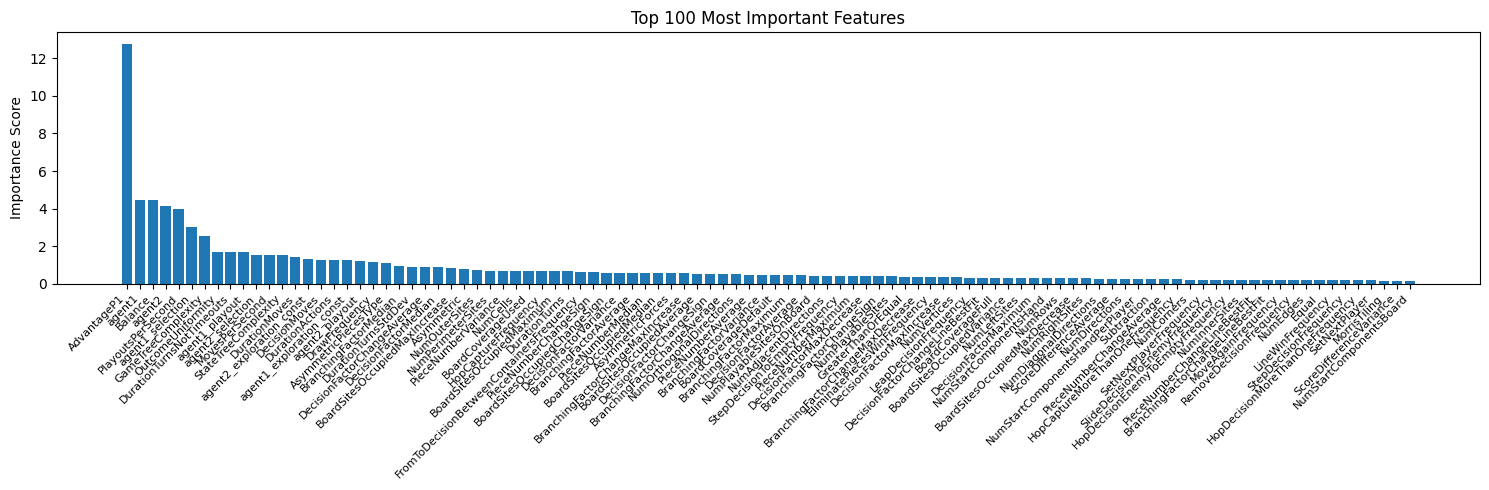

Fold 3 - RMSE: 0.4121822674890757
Fold 4


0:	learn: 0.6283314	test: 0.5755071	best: 0.5755071 (0)	total: 127ms	remaining: 21m 11s


50:	learn: 0.4930200	test: 0.5111275	best: 0.5111275 (50)	total: 5.79s	remaining: 18m 48s


100:	learn: 0.4445066	test: 0.4880941	best: 0.4880941 (100)	total: 11.5s	remaining: 18m 51s


150:	learn: 0.4188840	test: 0.4747333	best: 0.4747333 (150)	total: 17.6s	remaining: 19m 10s


200:	learn: 0.4018933	test: 0.4652176	best: 0.4652176 (200)	total: 23.8s	remaining: 19m 20s


250:	learn: 0.3879963	test: 0.4578817	best: 0.4578817 (250)	total: 30.2s	remaining: 19m 31s


300:	learn: 0.3777539	test: 0.4532331	best: 0.4532331 (300)	total: 36.6s	remaining: 19m 38s


350:	learn: 0.3692105	test: 0.4499752	best: 0.4499752 (350)	total: 43.1s	remaining: 19m 45s


400:	learn: 0.3620221	test: 0.4475090	best: 0.4475090 (400)	total: 49.8s	remaining: 19m 50s


450:	learn: 0.3556876	test: 0.4451552	best: 0.4451552 (450)	total: 56.4s	remaining: 19m 53s


500:	learn: 0.3502285	test: 0.4428451	best: 0.4428451 (500)	total: 1m 2s	remaining: 19m 50s


550:	learn: 0.3448319	test: 0.4410471	best: 0.4410471 (550)	total: 1m 9s	remaining: 19m 46s


600:	learn: 0.3396595	test: 0.4392347	best: 0.4392280 (599)	total: 1m 15s	remaining: 19m 39s


650:	learn: 0.3348736	test: 0.4376721	best: 0.4376721 (650)	total: 1m 21s	remaining: 19m 34s


700:	learn: 0.3309034	test: 0.4365460	best: 0.4365460 (700)	total: 1m 28s	remaining: 19m 28s


750:	learn: 0.3269602	test: 0.4356028	best: 0.4356028 (750)	total: 1m 34s	remaining: 19m 23s


800:	learn: 0.3233569	test: 0.4346316	best: 0.4346316 (800)	total: 1m 40s	remaining: 19m 17s


850:	learn: 0.3200343	test: 0.4339132	best: 0.4339132 (850)	total: 1m 47s	remaining: 19m 12s


900:	learn: 0.3169007	test: 0.4329699	best: 0.4329699 (900)	total: 1m 53s	remaining: 19m 8s


950:	learn: 0.3139483	test: 0.4322708	best: 0.4322708 (950)	total: 2m	remaining: 19m 2s


1000:	learn: 0.3112809	test: 0.4315356	best: 0.4315348 (999)	total: 2m 6s	remaining: 18m 57s


1050:	learn: 0.3087691	test: 0.4310297	best: 0.4310297 (1050)	total: 2m 12s	remaining: 18m 52s


1100:	learn: 0.3062249	test: 0.4306093	best: 0.4306093 (1100)	total: 2m 19s	remaining: 18m 46s


1150:	learn: 0.3038151	test: 0.4300235	best: 0.4300235 (1150)	total: 2m 25s	remaining: 18m 39s


1200:	learn: 0.3017382	test: 0.4294637	best: 0.4294637 (1200)	total: 2m 31s	remaining: 18m 33s


1250:	learn: 0.2995044	test: 0.4290250	best: 0.4290229 (1249)	total: 2m 38s	remaining: 18m 27s


1300:	learn: 0.2971857	test: 0.4286898	best: 0.4286845 (1297)	total: 2m 44s	remaining: 18m 21s


1350:	learn: 0.2950519	test: 0.4281044	best: 0.4281044 (1350)	total: 2m 51s	remaining: 18m 15s


1400:	learn: 0.2930618	test: 0.4276749	best: 0.4276749 (1400)	total: 2m 57s	remaining: 18m 10s


1450:	learn: 0.2911662	test: 0.4272760	best: 0.4272760 (1450)	total: 3m 4s	remaining: 18m 4s


1500:	learn: 0.2891892	test: 0.4269141	best: 0.4269141 (1500)	total: 3m 10s	remaining: 17m 58s


1550:	learn: 0.2876380	test: 0.4266553	best: 0.4266553 (1550)	total: 3m 16s	remaining: 17m 52s


1600:	learn: 0.2859479	test: 0.4262149	best: 0.4262135 (1599)	total: 3m 23s	remaining: 17m 46s


1650:	learn: 0.2843110	test: 0.4259851	best: 0.4259851 (1650)	total: 3m 29s	remaining: 17m 40s


1700:	learn: 0.2825780	test: 0.4257173	best: 0.4257031 (1696)	total: 3m 35s	remaining: 17m 33s


1750:	learn: 0.2809728	test: 0.4254975	best: 0.4254975 (1750)	total: 3m 42s	remaining: 17m 27s


1800:	learn: 0.2795514	test: 0.4251389	best: 0.4251329 (1799)	total: 3m 48s	remaining: 17m 22s


1850:	learn: 0.2781149	test: 0.4249472	best: 0.4249472 (1850)	total: 3m 55s	remaining: 17m 16s


1900:	learn: 0.2768123	test: 0.4247183	best: 0.4247160 (1899)	total: 4m 1s	remaining: 17m 10s


1950:	learn: 0.2755235	test: 0.4245076	best: 0.4244952 (1934)	total: 4m 8s	remaining: 17m 4s


2000:	learn: 0.2742039	test: 0.4241981	best: 0.4241978 (1999)	total: 4m 14s	remaining: 16m 58s


2050:	learn: 0.2729563	test: 0.4239719	best: 0.4239719 (2050)	total: 4m 21s	remaining: 16m 52s


2100:	learn: 0.2717536	test: 0.4237182	best: 0.4237182 (2100)	total: 4m 27s	remaining: 16m 47s


2150:	learn: 0.2705629	test: 0.4236015	best: 0.4235954 (2130)	total: 4m 34s	remaining: 16m 41s


2200:	learn: 0.2694224	test: 0.4233896	best: 0.4233896 (2200)	total: 4m 40s	remaining: 16m 34s


2250:	learn: 0.2681710	test: 0.4231790	best: 0.4231790 (2250)	total: 4m 47s	remaining: 16m 28s


2300:	learn: 0.2669931	test: 0.4229648	best: 0.4229648 (2300)	total: 4m 53s	remaining: 16m 22s


2350:	learn: 0.2658990	test: 0.4228445	best: 0.4228407 (2343)	total: 5m	remaining: 16m 16s


2400:	learn: 0.2648467	test: 0.4226658	best: 0.4226609 (2397)	total: 5m 6s	remaining: 16m 10s


2450:	learn: 0.2637997	test: 0.4225455	best: 0.4225455 (2450)	total: 5m 12s	remaining: 16m 4s


2500:	learn: 0.2628650	test: 0.4223948	best: 0.4223948 (2500)	total: 5m 19s	remaining: 15m 58s


2550:	learn: 0.2619031	test: 0.4222768	best: 0.4222768 (2550)	total: 5m 26s	remaining: 15m 52s


2600:	learn: 0.2609577	test: 0.4220878	best: 0.4220855 (2597)	total: 5m 32s	remaining: 15m 46s


2650:	learn: 0.2600334	test: 0.4219204	best: 0.4219180 (2649)	total: 5m 39s	remaining: 15m 40s


2700:	learn: 0.2591164	test: 0.4217669	best: 0.4217659 (2699)	total: 5m 45s	remaining: 15m 33s


2750:	learn: 0.2581040	test: 0.4215885	best: 0.4215885 (2750)	total: 5m 52s	remaining: 15m 27s


2800:	learn: 0.2571215	test: 0.4214614	best: 0.4214566 (2795)	total: 5m 58s	remaining: 15m 21s


2850:	learn: 0.2561161	test: 0.4212777	best: 0.4212767 (2849)	total: 6m 4s	remaining: 15m 15s


2900:	learn: 0.2552369	test: 0.4212015	best: 0.4211941 (2897)	total: 6m 11s	remaining: 15m 9s


2950:	learn: 0.2543662	test: 0.4211483	best: 0.4211430 (2948)	total: 6m 18s	remaining: 15m 3s


3000:	learn: 0.2535468	test: 0.4210258	best: 0.4210258 (3000)	total: 6m 24s	remaining: 14m 57s


3050:	learn: 0.2525851	test: 0.4209005	best: 0.4208994 (3049)	total: 6m 31s	remaining: 14m 50s


3100:	learn: 0.2517657	test: 0.4208427	best: 0.4208345 (3088)	total: 6m 37s	remaining: 14m 44s


3150:	learn: 0.2509137	test: 0.4207290	best: 0.4207290 (3150)	total: 6m 44s	remaining: 14m 38s


3200:	learn: 0.2501364	test: 0.4205917	best: 0.4205895 (3199)	total: 6m 50s	remaining: 14m 32s


3250:	learn: 0.2493323	test: 0.4204965	best: 0.4204936 (3249)	total: 6m 57s	remaining: 14m 26s


3300:	learn: 0.2485591	test: 0.4204089	best: 0.4204074 (3298)	total: 7m 3s	remaining: 14m 20s


3350:	learn: 0.2476805	test: 0.4203028	best: 0.4202979 (3340)	total: 7m 10s	remaining: 14m 13s


3400:	learn: 0.2468973	test: 0.4202414	best: 0.4202387 (3397)	total: 7m 16s	remaining: 14m 7s


3450:	learn: 0.2460032	test: 0.4201803	best: 0.4201695 (3441)	total: 7m 23s	remaining: 14m 1s


3500:	learn: 0.2452171	test: 0.4200292	best: 0.4200253 (3497)	total: 7m 29s	remaining: 13m 54s


3550:	learn: 0.2445828	test: 0.4199350	best: 0.4199350 (3550)	total: 7m 36s	remaining: 13m 48s


3600:	learn: 0.2438683	test: 0.4198646	best: 0.4198646 (3600)	total: 7m 42s	remaining: 13m 42s


3650:	learn: 0.2431527	test: 0.4197432	best: 0.4197432 (3650)	total: 7m 49s	remaining: 13m 36s


3700:	learn: 0.2423307	test: 0.4196405	best: 0.4196405 (3700)	total: 7m 55s	remaining: 13m 29s


3750:	learn: 0.2416410	test: 0.4195479	best: 0.4195479 (3750)	total: 8m 2s	remaining: 13m 23s


3800:	learn: 0.2409307	test: 0.4194452	best: 0.4194441 (3799)	total: 8m 8s	remaining: 13m 17s


3850:	learn: 0.2402577	test: 0.4194365	best: 0.4194321 (3835)	total: 8m 15s	remaining: 13m 11s


3900:	learn: 0.2395726	test: 0.4193319	best: 0.4193319 (3900)	total: 8m 21s	remaining: 13m 4s


3950:	learn: 0.2389379	test: 0.4192517	best: 0.4192517 (3950)	total: 8m 28s	remaining: 12m 58s


4000:	learn: 0.2382181	test: 0.4191317	best: 0.4191230 (3997)	total: 8m 34s	remaining: 12m 52s


4050:	learn: 0.2375958	test: 0.4190977	best: 0.4190947 (4046)	total: 8m 41s	remaining: 12m 46s


4100:	learn: 0.2368734	test: 0.4190576	best: 0.4190545 (4091)	total: 8m 48s	remaining: 12m 39s


4150:	learn: 0.2362323	test: 0.4189673	best: 0.4189656 (4138)	total: 8m 54s	remaining: 12m 33s


4200:	learn: 0.2356215	test: 0.4189083	best: 0.4189082 (4198)	total: 9m 1s	remaining: 12m 26s


4250:	learn: 0.2349270	test: 0.4188765	best: 0.4188587 (4245)	total: 9m 7s	remaining: 12m 20s


4300:	learn: 0.2342619	test: 0.4188470	best: 0.4188470 (4300)	total: 9m 14s	remaining: 12m 14s


4350:	learn: 0.2336015	test: 0.4188095	best: 0.4188071 (4345)	total: 9m 20s	remaining: 12m 8s


4400:	learn: 0.2330123	test: 0.4187230	best: 0.4187192 (4388)	total: 9m 27s	remaining: 12m 1s


4450:	learn: 0.2323605	test: 0.4186622	best: 0.4186622 (4450)	total: 9m 33s	remaining: 11m 55s


4500:	learn: 0.2318190	test: 0.4186329	best: 0.4186319 (4499)	total: 9m 40s	remaining: 11m 49s


4550:	learn: 0.2312982	test: 0.4185391	best: 0.4185308 (4543)	total: 9m 47s	remaining: 11m 43s


4600:	learn: 0.2307629	test: 0.4184835	best: 0.4184739 (4595)	total: 9m 53s	remaining: 11m 36s


4650:	learn: 0.2301920	test: 0.4184098	best: 0.4184098 (4650)	total: 10m	remaining: 11m 30s


4700:	learn: 0.2297227	test: 0.4183748	best: 0.4183742 (4699)	total: 10m 6s	remaining: 11m 24s


4750:	learn: 0.2291186	test: 0.4183137	best: 0.4183118 (4742)	total: 10m 13s	remaining: 11m 17s


4800:	learn: 0.2284912	test: 0.4182684	best: 0.4182674 (4799)	total: 10m 19s	remaining: 11m 11s


4850:	learn: 0.2280156	test: 0.4182618	best: 0.4182572 (4804)	total: 10m 26s	remaining: 11m 4s


4900:	learn: 0.2274875	test: 0.4182563	best: 0.4182427 (4864)	total: 10m 33s	remaining: 10m 58s


4950:	learn: 0.2269438	test: 0.4182177	best: 0.4182177 (4950)	total: 10m 39s	remaining: 10m 52s


5000:	learn: 0.2264068	test: 0.4181932	best: 0.4181913 (4999)	total: 10m 46s	remaining: 10m 45s


5050:	learn: 0.2259785	test: 0.4181789	best: 0.4181774 (5048)	total: 10m 52s	remaining: 10m 39s


5100:	learn: 0.2255889	test: 0.4181441	best: 0.4181422 (5084)	total: 10m 59s	remaining: 10m 33s


5150:	learn: 0.2250625	test: 0.4181105	best: 0.4181048 (5149)	total: 11m 6s	remaining: 10m 27s


5200:	learn: 0.2245478	test: 0.4180812	best: 0.4180811 (5199)	total: 11m 12s	remaining: 10m 20s


5250:	learn: 0.2240186	test: 0.4180323	best: 0.4180323 (5250)	total: 11m 19s	remaining: 10m 14s


5300:	learn: 0.2235069	test: 0.4179928	best: 0.4179916 (5298)	total: 11m 25s	remaining: 10m 7s


5350:	learn: 0.2229401	test: 0.4179413	best: 0.4179413 (5350)	total: 11m 32s	remaining: 10m 1s


5400:	learn: 0.2224302	test: 0.4178514	best: 0.4178514 (5400)	total: 11m 38s	remaining: 9m 54s


5450:	learn: 0.2219466	test: 0.4178193	best: 0.4178193 (5450)	total: 11m 45s	remaining: 9m 48s


5500:	learn: 0.2215015	test: 0.4178020	best: 0.4177993 (5490)	total: 11m 51s	remaining: 9m 42s


5550:	learn: 0.2209882	test: 0.4177700	best: 0.4177700 (5546)	total: 11m 58s	remaining: 9m 35s


5600:	learn: 0.2204517	test: 0.4177194	best: 0.4177172 (5597)	total: 12m 4s	remaining: 9m 29s


5650:	learn: 0.2199611	test: 0.4176940	best: 0.4176905 (5646)	total: 12m 11s	remaining: 9m 22s


5700:	learn: 0.2195338	test: 0.4176811	best: 0.4176746 (5685)	total: 12m 17s	remaining: 9m 16s


5750:	learn: 0.2190496	test: 0.4176437	best: 0.4176437 (5750)	total: 12m 24s	remaining: 9m 9s


5800:	learn: 0.2185877	test: 0.4176356	best: 0.4176302 (5794)	total: 12m 30s	remaining: 9m 3s


5850:	learn: 0.2181083	test: 0.4176033	best: 0.4175982 (5844)	total: 12m 37s	remaining: 8m 56s


5900:	learn: 0.2176793	test: 0.4175938	best: 0.4175919 (5880)	total: 12m 43s	remaining: 8m 50s


5950:	learn: 0.2172483	test: 0.4175652	best: 0.4175652 (5950)	total: 12m 50s	remaining: 8m 44s


6000:	learn: 0.2168233	test: 0.4175288	best: 0.4175288 (6000)	total: 12m 56s	remaining: 8m 37s


6050:	learn: 0.2164003	test: 0.4174535	best: 0.4174520 (6049)	total: 13m 3s	remaining: 8m 31s


6100:	learn: 0.2159849	test: 0.4174077	best: 0.4174072 (6091)	total: 13m 10s	remaining: 8m 25s


6150:	learn: 0.2155784	test: 0.4173717	best: 0.4173688 (6148)	total: 13m 16s	remaining: 8m 18s


6200:	learn: 0.2151410	test: 0.4173309	best: 0.4173309 (6200)	total: 13m 23s	remaining: 8m 12s


6250:	learn: 0.2147377	test: 0.4172822	best: 0.4172822 (6250)	total: 13m 30s	remaining: 8m 5s


6300:	learn: 0.2143204	test: 0.4172585	best: 0.4172521 (6295)	total: 13m 36s	remaining: 7m 59s


6350:	learn: 0.2137863	test: 0.4172142	best: 0.4172105 (6344)	total: 13m 42s	remaining: 7m 52s


6400:	learn: 0.2133659	test: 0.4172124	best: 0.4172017 (6362)	total: 13m 49s	remaining: 7m 46s


6450:	learn: 0.2129365	test: 0.4171877	best: 0.4171843 (6449)	total: 13m 56s	remaining: 7m 39s


6500:	learn: 0.2124824	test: 0.4171650	best: 0.4171630 (6499)	total: 14m 2s	remaining: 7m 33s


6550:	learn: 0.2120441	test: 0.4171296	best: 0.4171262 (6549)	total: 14m 9s	remaining: 7m 27s


6600:	learn: 0.2116068	test: 0.4171165	best: 0.4171145 (6595)	total: 14m 15s	remaining: 7m 20s


6650:	learn: 0.2111492	test: 0.4171032	best: 0.4170927 (6641)	total: 14m 22s	remaining: 7m 14s


6700:	learn: 0.2107386	test: 0.4170750	best: 0.4170750 (6700)	total: 14m 28s	remaining: 7m 7s


6750:	learn: 0.2103178	test: 0.4170539	best: 0.4170523 (6747)	total: 14m 35s	remaining: 7m 1s


6800:	learn: 0.2099075	test: 0.4170556	best: 0.4170493 (6777)	total: 14m 41s	remaining: 6m 54s


6850:	learn: 0.2095462	test: 0.4170308	best: 0.4170308 (6850)	total: 14m 48s	remaining: 6m 48s


6900:	learn: 0.2091397	test: 0.4169976	best: 0.4169948 (6897)	total: 14m 54s	remaining: 6m 41s


6950:	learn: 0.2087186	test: 0.4169814	best: 0.4169750 (6939)	total: 15m 1s	remaining: 6m 35s


7000:	learn: 0.2083527	test: 0.4169723	best: 0.4169630 (6980)	total: 15m 8s	remaining: 6m 29s


7050:	learn: 0.2079488	test: 0.4169414	best: 0.4169410 (7045)	total: 15m 14s	remaining: 6m 22s


7100:	learn: 0.2075505	test: 0.4169323	best: 0.4169289 (7075)	total: 15m 21s	remaining: 6m 16s


7150:	learn: 0.2071555	test: 0.4169158	best: 0.4169155 (7147)	total: 15m 27s	remaining: 6m 9s


7200:	learn: 0.2067760	test: 0.4168659	best: 0.4168659 (7200)	total: 15m 34s	remaining: 6m 3s


7250:	learn: 0.2063799	test: 0.4168299	best: 0.4168298 (7248)	total: 15m 41s	remaining: 5m 56s


7300:	learn: 0.2059089	test: 0.4167772	best: 0.4167772 (7300)	total: 15m 47s	remaining: 5m 50s


7350:	learn: 0.2054929	test: 0.4167861	best: 0.4167734 (7306)	total: 15m 53s	remaining: 5m 43s


7400:	learn: 0.2051311	test: 0.4167726	best: 0.4167669 (7386)	total: 16m	remaining: 5m 37s


7450:	learn: 0.2047461	test: 0.4167640	best: 0.4167556 (7433)	total: 16m 6s	remaining: 5m 30s


7500:	learn: 0.2043368	test: 0.4167313	best: 0.4167275 (7494)	total: 16m 13s	remaining: 5m 24s


7550:	learn: 0.2039584	test: 0.4166991	best: 0.4166990 (7549)	total: 16m 20s	remaining: 5m 17s


7600:	learn: 0.2035622	test: 0.4166907	best: 0.4166905 (7599)	total: 16m 26s	remaining: 5m 11s


7650:	learn: 0.2031926	test: 0.4166641	best: 0.4166605 (7644)	total: 16m 33s	remaining: 5m 4s


7700:	learn: 0.2028748	test: 0.4166168	best: 0.4166164 (7699)	total: 16m 39s	remaining: 4m 58s


7750:	learn: 0.2025099	test: 0.4165858	best: 0.4165821 (7747)	total: 16m 46s	remaining: 4m 51s


7800:	learn: 0.2021687	test: 0.4165507	best: 0.4165507 (7800)	total: 16m 52s	remaining: 4m 45s


7850:	learn: 0.2017508	test: 0.4165318	best: 0.4165311 (7847)	total: 16m 59s	remaining: 4m 39s


7900:	learn: 0.2013784	test: 0.4165152	best: 0.4165152 (7900)	total: 17m 5s	remaining: 4m 32s


7950:	learn: 0.2010225	test: 0.4164914	best: 0.4164913 (7949)	total: 17m 12s	remaining: 4m 26s


8000:	learn: 0.2006383	test: 0.4164832	best: 0.4164806 (7984)	total: 17m 18s	remaining: 4m 19s


8050:	learn: 0.2002653	test: 0.4164831	best: 0.4164786 (8036)	total: 17m 25s	remaining: 4m 13s


8100:	learn: 0.1998596	test: 0.4164660	best: 0.4164633 (8088)	total: 17m 31s	remaining: 4m 6s


8150:	learn: 0.1994669	test: 0.4164580	best: 0.4164568 (8126)	total: 17m 38s	remaining: 4m


8200:	learn: 0.1991046	test: 0.4164398	best: 0.4164396 (8180)	total: 17m 45s	remaining: 3m 53s


8250:	learn: 0.1987235	test: 0.4164006	best: 0.4163990 (8240)	total: 17m 51s	remaining: 3m 47s


8300:	learn: 0.1983693	test: 0.4163609	best: 0.4163602 (8298)	total: 17m 57s	remaining: 3m 40s


8350:	learn: 0.1979950	test: 0.4163056	best: 0.4163056 (8350)	total: 18m 4s	remaining: 3m 34s


8400:	learn: 0.1976593	test: 0.4163065	best: 0.4163009 (8390)	total: 18m 11s	remaining: 3m 27s


8450:	learn: 0.1973201	test: 0.4162812	best: 0.4162812 (8450)	total: 18m 17s	remaining: 3m 21s


8500:	learn: 0.1969595	test: 0.4162574	best: 0.4162574 (8500)	total: 18m 24s	remaining: 3m 14s


8550:	learn: 0.1965814	test: 0.4162219	best: 0.4162219 (8550)	total: 18m 30s	remaining: 3m 8s


8600:	learn: 0.1962220	test: 0.4162068	best: 0.4162020 (8591)	total: 18m 37s	remaining: 3m 1s


8650:	learn: 0.1958784	test: 0.4161834	best: 0.4161834 (8650)	total: 18m 43s	remaining: 2m 55s


8700:	learn: 0.1955410	test: 0.4161829	best: 0.4161826 (8693)	total: 18m 50s	remaining: 2m 48s


8750:	learn: 0.1951256	test: 0.4161433	best: 0.4161433 (8750)	total: 18m 56s	remaining: 2m 42s


8800:	learn: 0.1947914	test: 0.4161269	best: 0.4161259 (8796)	total: 19m 3s	remaining: 2m 35s


8850:	learn: 0.1943893	test: 0.4160855	best: 0.4160849 (8836)	total: 19m 9s	remaining: 2m 29s


8900:	learn: 0.1940633	test: 0.4160601	best: 0.4160595 (8897)	total: 19m 16s	remaining: 2m 22s


8950:	learn: 0.1937559	test: 0.4160632	best: 0.4160595 (8897)	total: 19m 23s	remaining: 2m 16s


9000:	learn: 0.1934107	test: 0.4160432	best: 0.4160430 (8997)	total: 19m 29s	remaining: 2m 9s


9050:	learn: 0.1931078	test: 0.4160235	best: 0.4160235 (9050)	total: 19m 36s	remaining: 2m 3s


9100:	learn: 0.1927727	test: 0.4159977	best: 0.4159974 (9095)	total: 19m 42s	remaining: 1m 56s


9150:	learn: 0.1924734	test: 0.4159912	best: 0.4159838 (9149)	total: 19m 49s	remaining: 1m 50s


9200:	learn: 0.1921741	test: 0.4159916	best: 0.4159838 (9149)	total: 19m 55s	remaining: 1m 43s


9250:	learn: 0.1918542	test: 0.4159798	best: 0.4159798 (9250)	total: 20m 2s	remaining: 1m 37s


9300:	learn: 0.1915367	test: 0.4159636	best: 0.4159605 (9289)	total: 20m 8s	remaining: 1m 30s


9350:	learn: 0.1911748	test: 0.4159465	best: 0.4159456 (9349)	total: 20m 15s	remaining: 1m 24s


9400:	learn: 0.1908408	test: 0.4159342	best: 0.4159322 (9398)	total: 20m 21s	remaining: 1m 17s


9450:	learn: 0.1905404	test: 0.4159367	best: 0.4159319 (9406)	total: 20m 28s	remaining: 1m 11s


9500:	learn: 0.1901924	test: 0.4159221	best: 0.4159189 (9497)	total: 20m 34s	remaining: 1m 4s


9550:	learn: 0.1898801	test: 0.4159002	best: 0.4158977 (9547)	total: 20m 41s	remaining: 58.4s


9600:	learn: 0.1895164	test: 0.4158966	best: 0.4158953 (9568)	total: 20m 47s	remaining: 51.9s


9650:	learn: 0.1891703	test: 0.4158803	best: 0.4158763 (9631)	total: 20m 54s	remaining: 45.4s


9700:	learn: 0.1888695	test: 0.4158713	best: 0.4158702 (9693)	total: 21m 1s	remaining: 38.9s


9750:	learn: 0.1885488	test: 0.4158677	best: 0.4158677 (9750)	total: 21m 7s	remaining: 32.4s


9800:	learn: 0.1882491	test: 0.4158523	best: 0.4158513 (9798)	total: 21m 14s	remaining: 25.9s


9850:	learn: 0.1879166	test: 0.4158431	best: 0.4158378 (9849)	total: 21m 20s	remaining: 19.4s


9900:	learn: 0.1875930	test: 0.4158317	best: 0.4158316 (9898)	total: 21m 27s	remaining: 12.9s


9950:	learn: 0.1872638	test: 0.4158135	best: 0.4158117 (9949)	total: 21m 33s	remaining: 6.37s


9999:	learn: 0.1869972	test: 0.4157908	best: 0.4157904 (9996)	total: 21m 40s	remaining: 0us

bestTest = 0.4157904141
bestIteration = 9996

Shrink model to first 9997 iterations.


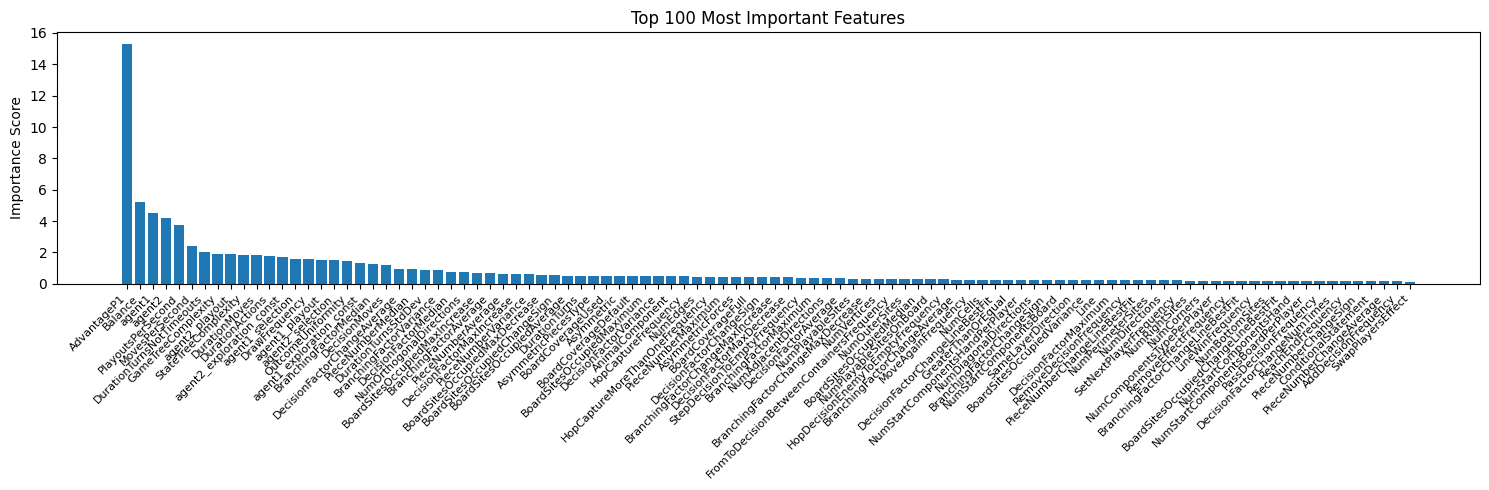

Fold 4 - RMSE: 0.4151526858996838
Fold 5


0:	learn: 0.6246616	test: 0.5864647	best: 0.5864647 (0)	total: 107ms	remaining: 17m 46s


50:	learn: 0.4894254	test: 0.5351352	best: 0.5351352 (50)	total: 5.83s	remaining: 18m 58s


100:	learn: 0.4433798	test: 0.5064290	best: 0.5064290 (100)	total: 11.7s	remaining: 19m 10s


150:	learn: 0.4186573	test: 0.4924086	best: 0.4924086 (150)	total: 17.9s	remaining: 19m 25s


200:	learn: 0.4022572	test: 0.4827847	best: 0.4827847 (200)	total: 24.3s	remaining: 19m 43s


250:	learn: 0.3892511	test: 0.4758497	best: 0.4758497 (250)	total: 30.8s	remaining: 19m 56s


300:	learn: 0.3788201	test: 0.4703090	best: 0.4703090 (300)	total: 37.5s	remaining: 20m 7s


350:	learn: 0.3703930	test: 0.4662865	best: 0.4662865 (350)	total: 44.3s	remaining: 20m 17s


400:	learn: 0.3637359	test: 0.4632631	best: 0.4632631 (400)	total: 51.2s	remaining: 20m 24s


450:	learn: 0.3576955	test: 0.4604412	best: 0.4604412 (450)	total: 57.8s	remaining: 20m 23s


500:	learn: 0.3520582	test: 0.4577511	best: 0.4577511 (500)	total: 1m 4s	remaining: 20m 22s


550:	learn: 0.3465235	test: 0.4546107	best: 0.4546107 (550)	total: 1m 10s	remaining: 20m 16s


600:	learn: 0.3415133	test: 0.4521702	best: 0.4521702 (600)	total: 1m 17s	remaining: 20m 10s


650:	learn: 0.3370567	test: 0.4499854	best: 0.4499854 (650)	total: 1m 23s	remaining: 20m 2s


700:	learn: 0.3326844	test: 0.4480734	best: 0.4480734 (700)	total: 1m 30s	remaining: 19m 56s


750:	learn: 0.3288923	test: 0.4465329	best: 0.4465329 (750)	total: 1m 36s	remaining: 19m 50s


800:	learn: 0.3255389	test: 0.4452582	best: 0.4452582 (800)	total: 1m 43s	remaining: 19m 43s


850:	learn: 0.3224404	test: 0.4440741	best: 0.4440741 (850)	total: 1m 49s	remaining: 19m 39s


900:	learn: 0.3194606	test: 0.4429076	best: 0.4429076 (900)	total: 1m 56s	remaining: 19m 33s


950:	learn: 0.3168486	test: 0.4420645	best: 0.4420574 (947)	total: 2m 2s	remaining: 19m 28s


1000:	learn: 0.3143063	test: 0.4412561	best: 0.4412561 (1000)	total: 2m 9s	remaining: 19m 22s


1050:	learn: 0.3115886	test: 0.4404781	best: 0.4404609 (1046)	total: 2m 15s	remaining: 19m 17s


1100:	learn: 0.3090622	test: 0.4397453	best: 0.4397453 (1100)	total: 2m 22s	remaining: 19m 11s


1150:	learn: 0.3066029	test: 0.4391183	best: 0.4391183 (1150)	total: 2m 29s	remaining: 19m 6s


1200:	learn: 0.3042682	test: 0.4385827	best: 0.4385827 (1200)	total: 2m 35s	remaining: 19m


1250:	learn: 0.3020178	test: 0.4379799	best: 0.4379799 (1250)	total: 2m 42s	remaining: 18m 55s


1300:	learn: 0.2997418	test: 0.4374136	best: 0.4374136 (1300)	total: 2m 48s	remaining: 18m 48s


1350:	learn: 0.2975411	test: 0.4370632	best: 0.4370632 (1350)	total: 2m 55s	remaining: 18m 41s


1400:	learn: 0.2956098	test: 0.4366125	best: 0.4365997 (1398)	total: 3m 1s	remaining: 18m 35s


1450:	learn: 0.2936319	test: 0.4360996	best: 0.4360996 (1450)	total: 3m 8s	remaining: 18m 28s


1500:	learn: 0.2914734	test: 0.4355303	best: 0.4355294 (1499)	total: 3m 14s	remaining: 18m 22s


1550:	learn: 0.2895815	test: 0.4351360	best: 0.4351360 (1550)	total: 3m 21s	remaining: 18m 16s


1600:	learn: 0.2879511	test: 0.4347626	best: 0.4347626 (1600)	total: 3m 27s	remaining: 18m 10s


1650:	learn: 0.2862365	test: 0.4345220	best: 0.4345220 (1650)	total: 3m 34s	remaining: 18m 4s


1700:	learn: 0.2846462	test: 0.4341632	best: 0.4341616 (1699)	total: 3m 40s	remaining: 17m 57s


1750:	learn: 0.2830545	test: 0.4337785	best: 0.4337785 (1750)	total: 3m 47s	remaining: 17m 51s


1800:	learn: 0.2815046	test: 0.4334600	best: 0.4334600 (1800)	total: 3m 54s	remaining: 17m 45s


1850:	learn: 0.2799528	test: 0.4330803	best: 0.4330803 (1850)	total: 4m	remaining: 17m 39s


1900:	learn: 0.2785892	test: 0.4328560	best: 0.4328552 (1899)	total: 4m 7s	remaining: 17m 32s


1950:	learn: 0.2772201	test: 0.4325398	best: 0.4325398 (1950)	total: 4m 13s	remaining: 17m 25s


2000:	learn: 0.2757651	test: 0.4321951	best: 0.4321951 (2000)	total: 4m 20s	remaining: 17m 19s


2050:	learn: 0.2744133	test: 0.4319126	best: 0.4319123 (2049)	total: 4m 26s	remaining: 17m 13s


2100:	learn: 0.2732387	test: 0.4316985	best: 0.4316938 (2099)	total: 4m 33s	remaining: 17m 7s


2150:	learn: 0.2720338	test: 0.4314920	best: 0.4314920 (2150)	total: 4m 39s	remaining: 17m 1s


2200:	learn: 0.2708591	test: 0.4311978	best: 0.4311978 (2200)	total: 4m 46s	remaining: 16m 56s


2250:	learn: 0.2696260	test: 0.4311057	best: 0.4311056 (2248)	total: 4m 53s	remaining: 16m 49s


2300:	learn: 0.2684783	test: 0.4308575	best: 0.4308575 (2300)	total: 4m 59s	remaining: 16m 43s


2350:	learn: 0.2672236	test: 0.4305960	best: 0.4305960 (2350)	total: 5m 6s	remaining: 16m 36s


2400:	learn: 0.2661017	test: 0.4303952	best: 0.4303952 (2400)	total: 5m 12s	remaining: 16m 30s


2450:	learn: 0.2650785	test: 0.4302371	best: 0.4302331 (2446)	total: 5m 19s	remaining: 16m 24s


2500:	learn: 0.2639969	test: 0.4300976	best: 0.4300976 (2500)	total: 5m 26s	remaining: 16m 17s


2550:	learn: 0.2628074	test: 0.4298768	best: 0.4298768 (2550)	total: 5m 32s	remaining: 16m 11s


2600:	learn: 0.2617855	test: 0.4297353	best: 0.4297353 (2600)	total: 5m 39s	remaining: 16m 5s


2650:	learn: 0.2607457	test: 0.4296812	best: 0.4296812 (2650)	total: 5m 46s	remaining: 15m 59s


2700:	learn: 0.2597386	test: 0.4295771	best: 0.4295580 (2696)	total: 5m 52s	remaining: 15m 53s


2750:	learn: 0.2587118	test: 0.4294178	best: 0.4294178 (2750)	total: 5m 59s	remaining: 15m 46s


2800:	learn: 0.2577882	test: 0.4292780	best: 0.4292780 (2800)	total: 6m 6s	remaining: 15m 41s


2850:	learn: 0.2568482	test: 0.4291577	best: 0.4291577 (2850)	total: 6m 12s	remaining: 15m 35s


2900:	learn: 0.2560045	test: 0.4290500	best: 0.4290487 (2899)	total: 6m 19s	remaining: 15m 29s


2950:	learn: 0.2550806	test: 0.4288193	best: 0.4288193 (2950)	total: 6m 26s	remaining: 15m 23s


3000:	learn: 0.2541487	test: 0.4287097	best: 0.4287088 (2999)	total: 6m 33s	remaining: 15m 16s


3050:	learn: 0.2533016	test: 0.4286692	best: 0.4286344 (3038)	total: 6m 39s	remaining: 15m 10s


3100:	learn: 0.2524352	test: 0.4285345	best: 0.4285278 (3098)	total: 6m 46s	remaining: 15m 4s


3150:	learn: 0.2515835	test: 0.4284320	best: 0.4284320 (3150)	total: 6m 52s	remaining: 14m 57s


3200:	learn: 0.2508163	test: 0.4283531	best: 0.4283531 (3200)	total: 6m 59s	remaining: 14m 51s


3250:	learn: 0.2499905	test: 0.4283397	best: 0.4283235 (3245)	total: 7m 6s	remaining: 14m 44s


3300:	learn: 0.2491886	test: 0.4282962	best: 0.4282877 (3295)	total: 7m 12s	remaining: 14m 38s


3350:	learn: 0.2484024	test: 0.4282037	best: 0.4282037 (3350)	total: 7m 19s	remaining: 14m 32s


3400:	learn: 0.2475982	test: 0.4281277	best: 0.4281277 (3400)	total: 7m 26s	remaining: 14m 25s


3450:	learn: 0.2469108	test: 0.4280369	best: 0.4280351 (3448)	total: 7m 32s	remaining: 14m 19s


3500:	learn: 0.2461456	test: 0.4279701	best: 0.4279701 (3500)	total: 7m 39s	remaining: 14m 13s


3550:	learn: 0.2453267	test: 0.4278807	best: 0.4278628 (3536)	total: 7m 46s	remaining: 14m 6s


3600:	learn: 0.2446263	test: 0.4278250	best: 0.4277924 (3586)	total: 7m 52s	remaining: 14m


3650:	learn: 0.2438393	test: 0.4276885	best: 0.4276885 (3650)	total: 7m 59s	remaining: 13m 53s


3700:	learn: 0.2431214	test: 0.4276202	best: 0.4276202 (3700)	total: 8m 6s	remaining: 13m 47s


3750:	learn: 0.2424081	test: 0.4275764	best: 0.4275747 (3738)	total: 8m 13s	remaining: 13m 41s


3800:	learn: 0.2416831	test: 0.4274796	best: 0.4274796 (3800)	total: 8m 19s	remaining: 13m 34s


3850:	learn: 0.2410032	test: 0.4274337	best: 0.4274336 (3849)	total: 8m 26s	remaining: 13m 28s


3900:	learn: 0.2403047	test: 0.4273780	best: 0.4273780 (3900)	total: 8m 33s	remaining: 13m 22s


3950:	learn: 0.2396306	test: 0.4272137	best: 0.4272137 (3950)	total: 8m 39s	remaining: 13m 15s


4000:	learn: 0.2389754	test: 0.4271700	best: 0.4271589 (3999)	total: 8m 46s	remaining: 13m 9s


4050:	learn: 0.2383646	test: 0.4270835	best: 0.4270835 (4050)	total: 8m 53s	remaining: 13m 2s


4100:	learn: 0.2376362	test: 0.4269867	best: 0.4269846 (4099)	total: 8m 59s	remaining: 12m 56s


4150:	learn: 0.2370090	test: 0.4269128	best: 0.4269075 (4145)	total: 9m 6s	remaining: 12m 50s


4200:	learn: 0.2363965	test: 0.4268483	best: 0.4268430 (4189)	total: 9m 13s	remaining: 12m 43s


4250:	learn: 0.2357172	test: 0.4267280	best: 0.4267280 (4250)	total: 9m 20s	remaining: 12m 37s


4300:	learn: 0.2350311	test: 0.4265843	best: 0.4265843 (4300)	total: 9m 26s	remaining: 12m 30s


4350:	learn: 0.2344415	test: 0.4265215	best: 0.4265167 (4349)	total: 9m 33s	remaining: 12m 24s


4400:	learn: 0.2337928	test: 0.4264099	best: 0.4264065 (4397)	total: 9m 40s	remaining: 12m 17s


4450:	learn: 0.2331990	test: 0.4263800	best: 0.4263787 (4444)	total: 9m 46s	remaining: 12m 11s


4500:	learn: 0.2325760	test: 0.4263184	best: 0.4263158 (4498)	total: 9m 53s	remaining: 12m 4s


4550:	learn: 0.2319461	test: 0.4262595	best: 0.4262595 (4550)	total: 9m 59s	remaining: 11m 58s


4600:	learn: 0.2313591	test: 0.4261516	best: 0.4261516 (4600)	total: 10m 6s	remaining: 11m 51s


4650:	learn: 0.2308102	test: 0.4260718	best: 0.4260718 (4650)	total: 10m 13s	remaining: 11m 45s


4700:	learn: 0.2302850	test: 0.4260087	best: 0.4260087 (4700)	total: 10m 20s	remaining: 11m 38s


4750:	learn: 0.2296908	test: 0.4259299	best: 0.4259293 (4749)	total: 10m 26s	remaining: 11m 32s


4800:	learn: 0.2291932	test: 0.4258844	best: 0.4258815 (4798)	total: 10m 33s	remaining: 11m 25s


4850:	learn: 0.2286354	test: 0.4258358	best: 0.4258353 (4849)	total: 10m 40s	remaining: 11m 19s


4900:	learn: 0.2281307	test: 0.4257744	best: 0.4257743 (4899)	total: 10m 46s	remaining: 11m 12s


4950:	learn: 0.2276627	test: 0.4257217	best: 0.4257120 (4946)	total: 10m 53s	remaining: 11m 6s


5000:	learn: 0.2271493	test: 0.4256385	best: 0.4256385 (4999)	total: 11m	remaining: 10m 59s


5050:	learn: 0.2266376	test: 0.4255918	best: 0.4255918 (5050)	total: 11m 6s	remaining: 10m 53s


5100:	learn: 0.2261031	test: 0.4255392	best: 0.4255392 (5100)	total: 11m 13s	remaining: 10m 46s


5150:	learn: 0.2255657	test: 0.4254705	best: 0.4254705 (5150)	total: 11m 20s	remaining: 10m 40s


5200:	learn: 0.2250959	test: 0.4254214	best: 0.4254137 (5194)	total: 11m 26s	remaining: 10m 33s


5250:	learn: 0.2245809	test: 0.4253718	best: 0.4253653 (5245)	total: 11m 34s	remaining: 10m 27s


5300:	learn: 0.2240264	test: 0.4253587	best: 0.4253471 (5284)	total: 11m 41s	remaining: 10m 21s


5350:	learn: 0.2235625	test: 0.4253400	best: 0.4253365 (5349)	total: 11m 47s	remaining: 10m 14s


5400:	learn: 0.2230703	test: 0.4252934	best: 0.4252934 (5400)	total: 11m 54s	remaining: 10m 8s


5450:	learn: 0.2225298	test: 0.4252439	best: 0.4252406 (5448)	total: 12m 1s	remaining: 10m 1s


5500:	learn: 0.2220043	test: 0.4252331	best: 0.4252145 (5488)	total: 12m 7s	remaining: 9m 55s


5550:	learn: 0.2215176	test: 0.4252127	best: 0.4252028 (5540)	total: 12m 14s	remaining: 9m 48s


5600:	learn: 0.2210439	test: 0.4251288	best: 0.4251288 (5600)	total: 12m 21s	remaining: 9m 42s


5650:	learn: 0.2205358	test: 0.4250646	best: 0.4250646 (5649)	total: 12m 27s	remaining: 9m 35s


5700:	learn: 0.2200197	test: 0.4250369	best: 0.4250369 (5700)	total: 12m 34s	remaining: 9m 28s


5750:	learn: 0.2195525	test: 0.4250071	best: 0.4250049 (5747)	total: 12m 40s	remaining: 9m 22s


5800:	learn: 0.2191017	test: 0.4249958	best: 0.4249902 (5796)	total: 12m 47s	remaining: 9m 15s


5850:	learn: 0.2186917	test: 0.4249760	best: 0.4249661 (5837)	total: 12m 54s	remaining: 9m 9s


5900:	learn: 0.2182453	test: 0.4249312	best: 0.4249312 (5900)	total: 13m	remaining: 9m 2s


5950:	learn: 0.2177171	test: 0.4248134	best: 0.4248116 (5948)	total: 13m 7s	remaining: 8m 55s


6000:	learn: 0.2172174	test: 0.4247607	best: 0.4247607 (6000)	total: 13m 14s	remaining: 8m 49s


6050:	learn: 0.2167804	test: 0.4247489	best: 0.4247489 (6050)	total: 13m 20s	remaining: 8m 42s


6100:	learn: 0.2163340	test: 0.4247211	best: 0.4247207 (6098)	total: 13m 27s	remaining: 8m 35s


6150:	learn: 0.2158646	test: 0.4247015	best: 0.4246982 (6138)	total: 13m 34s	remaining: 8m 29s


6200:	learn: 0.2154479	test: 0.4246552	best: 0.4246552 (6200)	total: 13m 40s	remaining: 8m 22s


6250:	learn: 0.2150157	test: 0.4246555	best: 0.4246487 (6235)	total: 13m 47s	remaining: 8m 16s


6300:	learn: 0.2145304	test: 0.4246194	best: 0.4246170 (6299)	total: 13m 54s	remaining: 8m 9s


6350:	learn: 0.2140696	test: 0.4245927	best: 0.4245871 (6315)	total: 14m	remaining: 8m 3s


6400:	learn: 0.2135989	test: 0.4245677	best: 0.4245659 (6387)	total: 14m 7s	remaining: 7m 56s


6450:	learn: 0.2131008	test: 0.4245716	best: 0.4245574 (6446)	total: 14m 13s	remaining: 7m 49s


6500:	learn: 0.2126921	test: 0.4245533	best: 0.4245516 (6471)	total: 14m 20s	remaining: 7m 43s


6550:	learn: 0.2122761	test: 0.4245275	best: 0.4245187 (6541)	total: 14m 27s	remaining: 7m 36s


6600:	learn: 0.2118468	test: 0.4244620	best: 0.4244620 (6600)	total: 14m 33s	remaining: 7m 29s


6650:	learn: 0.2114584	test: 0.4244657	best: 0.4244592 (6641)	total: 14m 40s	remaining: 7m 23s


6700:	learn: 0.2110083	test: 0.4244230	best: 0.4244163 (6688)	total: 14m 47s	remaining: 7m 16s


6750:	learn: 0.2105757	test: 0.4244014	best: 0.4244014 (6750)	total: 14m 53s	remaining: 7m 10s


6800:	learn: 0.2101374	test: 0.4243604	best: 0.4243604 (6800)	total: 15m	remaining: 7m 3s


6850:	learn: 0.2097443	test: 0.4243558	best: 0.4243549 (6841)	total: 15m 6s	remaining: 6m 56s


6900:	learn: 0.2093949	test: 0.4243255	best: 0.4243241 (6898)	total: 15m 13s	remaining: 6m 50s


6950:	learn: 0.2089601	test: 0.4243358	best: 0.4243241 (6898)	total: 15m 20s	remaining: 6m 43s


7000:	learn: 0.2085590	test: 0.4242970	best: 0.4242960 (6998)	total: 15m 26s	remaining: 6m 37s


7050:	learn: 0.2081876	test: 0.4243189	best: 0.4242960 (6998)	total: 15m 33s	remaining: 6m 30s


7100:	learn: 0.2077628	test: 0.4243361	best: 0.4242960 (6998)	total: 15m 40s	remaining: 6m 23s


7150:	learn: 0.2073555	test: 0.4243329	best: 0.4242960 (6998)	total: 15m 46s	remaining: 6m 17s


7200:	learn: 0.2069413	test: 0.4242967	best: 0.4242960 (6998)	total: 15m 53s	remaining: 6m 10s


7250:	learn: 0.2065579	test: 0.4243027	best: 0.4242857 (7221)	total: 15m 59s	remaining: 6m 3s


7300:	learn: 0.2061673	test: 0.4242911	best: 0.4242857 (7221)	total: 16m 6s	remaining: 5m 57s


7350:	learn: 0.2057965	test: 0.4242733	best: 0.4242733 (7349)	total: 16m 13s	remaining: 5m 50s


7400:	learn: 0.2053783	test: 0.4242617	best: 0.4242610 (7399)	total: 16m 19s	remaining: 5m 44s


7450:	learn: 0.2049626	test: 0.4242328	best: 0.4242306 (7436)	total: 16m 26s	remaining: 5m 37s


7500:	learn: 0.2045922	test: 0.4241988	best: 0.4241959 (7499)	total: 16m 33s	remaining: 5m 30s


7550:	learn: 0.2042214	test: 0.4242067	best: 0.4241940 (7536)	total: 16m 39s	remaining: 5m 24s


7600:	learn: 0.2038633	test: 0.4241995	best: 0.4241818 (7584)	total: 16m 46s	remaining: 5m 17s


7650:	learn: 0.2034845	test: 0.4241588	best: 0.4241548 (7645)	total: 16m 53s	remaining: 5m 11s


7700:	learn: 0.2030789	test: 0.4241022	best: 0.4241009 (7698)	total: 16m 59s	remaining: 5m 4s


7750:	learn: 0.2027451	test: 0.4241197	best: 0.4241009 (7698)	total: 17m 6s	remaining: 4m 57s


7800:	learn: 0.2023810	test: 0.4241094	best: 0.4241009 (7698)	total: 17m 13s	remaining: 4m 51s


7850:	learn: 0.2020313	test: 0.4240664	best: 0.4240664 (7850)	total: 17m 19s	remaining: 4m 44s


7900:	learn: 0.2016669	test: 0.4240460	best: 0.4240366 (7891)	total: 17m 26s	remaining: 4m 38s


7950:	learn: 0.2012972	test: 0.4240256	best: 0.4240214 (7948)	total: 17m 33s	remaining: 4m 31s


8000:	learn: 0.2009177	test: 0.4240146	best: 0.4240113 (7999)	total: 17m 39s	remaining: 4m 24s


8050:	learn: 0.2005102	test: 0.4239895	best: 0.4239895 (8050)	total: 17m 46s	remaining: 4m 18s


8100:	learn: 0.2001600	test: 0.4239686	best: 0.4239686 (8100)	total: 17m 52s	remaining: 4m 11s


8150:	learn: 0.1997931	test: 0.4239105	best: 0.4239105 (8150)	total: 17m 59s	remaining: 4m 4s


8200:	learn: 0.1994414	test: 0.4239016	best: 0.4238982 (8176)	total: 18m 6s	remaining: 3m 58s


8250:	learn: 0.1991304	test: 0.4238899	best: 0.4238899 (8250)	total: 18m 12s	remaining: 3m 51s


8300:	learn: 0.1987966	test: 0.4238766	best: 0.4238737 (8295)	total: 18m 19s	remaining: 3m 45s


8350:	learn: 0.1984305	test: 0.4238770	best: 0.4238703 (8332)	total: 18m 26s	remaining: 3m 38s


8400:	learn: 0.1980547	test: 0.4238617	best: 0.4238573 (8398)	total: 18m 33s	remaining: 3m 31s


8450:	learn: 0.1976938	test: 0.4238498	best: 0.4238453 (8435)	total: 18m 39s	remaining: 3m 25s


8500:	learn: 0.1973647	test: 0.4238162	best: 0.4238162 (8500)	total: 18m 46s	remaining: 3m 18s


8550:	learn: 0.1970455	test: 0.4238050	best: 0.4238019 (8543)	total: 18m 53s	remaining: 3m 12s


8600:	learn: 0.1966728	test: 0.4238201	best: 0.4238019 (8543)	total: 19m	remaining: 3m 5s


8650:	learn: 0.1963355	test: 0.4238266	best: 0.4238019 (8543)	total: 19m 6s	remaining: 2m 58s


8700:	learn: 0.1959692	test: 0.4238055	best: 0.4238018 (8697)	total: 19m 13s	remaining: 2m 52s


8750:	learn: 0.1956305	test: 0.4238169	best: 0.4237974 (8715)	total: 19m 20s	remaining: 2m 45s


8800:	learn: 0.1952650	test: 0.4237966	best: 0.4237933 (8790)	total: 19m 26s	remaining: 2m 38s


8850:	learn: 0.1949634	test: 0.4237987	best: 0.4237933 (8790)	total: 19m 33s	remaining: 2m 32s


8900:	learn: 0.1946582	test: 0.4237812	best: 0.4237783 (8894)	total: 19m 39s	remaining: 2m 25s


8950:	learn: 0.1943143	test: 0.4237527	best: 0.4237527 (8949)	total: 19m 46s	remaining: 2m 19s


9000:	learn: 0.1939694	test: 0.4237190	best: 0.4237190 (9000)	total: 19m 53s	remaining: 2m 12s


9050:	learn: 0.1935947	test: 0.4236927	best: 0.4236906 (9049)	total: 19m 59s	remaining: 2m 5s


9100:	learn: 0.1932596	test: 0.4236801	best: 0.4236800 (9099)	total: 20m 6s	remaining: 1m 59s


9150:	learn: 0.1929258	test: 0.4236646	best: 0.4236570 (9137)	total: 20m 12s	remaining: 1m 52s


9200:	learn: 0.1925787	test: 0.4236470	best: 0.4236422 (9185)	total: 20m 19s	remaining: 1m 45s


9250:	learn: 0.1922658	test: 0.4236379	best: 0.4236341 (9238)	total: 20m 26s	remaining: 1m 39s


9300:	learn: 0.1919236	test: 0.4236052	best: 0.4236052 (9300)	total: 20m 32s	remaining: 1m 32s


9350:	learn: 0.1915582	test: 0.4235742	best: 0.4235724 (9342)	total: 20m 39s	remaining: 1m 26s


9400:	learn: 0.1912367	test: 0.4235475	best: 0.4235475 (9400)	total: 20m 46s	remaining: 1m 19s


9450:	learn: 0.1908934	test: 0.4235308	best: 0.4235305 (9448)	total: 20m 52s	remaining: 1m 12s


9500:	learn: 0.1905753	test: 0.4235297	best: 0.4235220 (9471)	total: 20m 59s	remaining: 1m 6s


9550:	learn: 0.1902484	test: 0.4234981	best: 0.4234952 (9544)	total: 21m 6s	remaining: 59.5s


9600:	learn: 0.1899645	test: 0.4234827	best: 0.4234767 (9593)	total: 21m 12s	remaining: 52.9s


9650:	learn: 0.1896505	test: 0.4234686	best: 0.4234646 (9634)	total: 21m 19s	remaining: 46.3s


9700:	learn: 0.1893030	test: 0.4234829	best: 0.4234639 (9665)	total: 21m 26s	remaining: 39.6s


9750:	learn: 0.1889761	test: 0.4234807	best: 0.4234639 (9665)	total: 21m 32s	remaining: 33s


9800:	learn: 0.1886943	test: 0.4234795	best: 0.4234639 (9665)	total: 21m 39s	remaining: 26.4s


9850:	learn: 0.1883788	test: 0.4234519	best: 0.4234514 (9849)	total: 21m 45s	remaining: 19.8s


9900:	learn: 0.1880596	test: 0.4234406	best: 0.4234404 (9895)	total: 21m 52s	remaining: 13.1s


9950:	learn: 0.1877056	test: 0.4234257	best: 0.4234257 (9950)	total: 21m 59s	remaining: 6.5s


9999:	learn: 0.1874291	test: 0.4234283	best: 0.4234216 (9973)	total: 22m 5s	remaining: 0us

bestTest = 0.4234215531
bestIteration = 9973

Shrink model to first 9974 iterations.


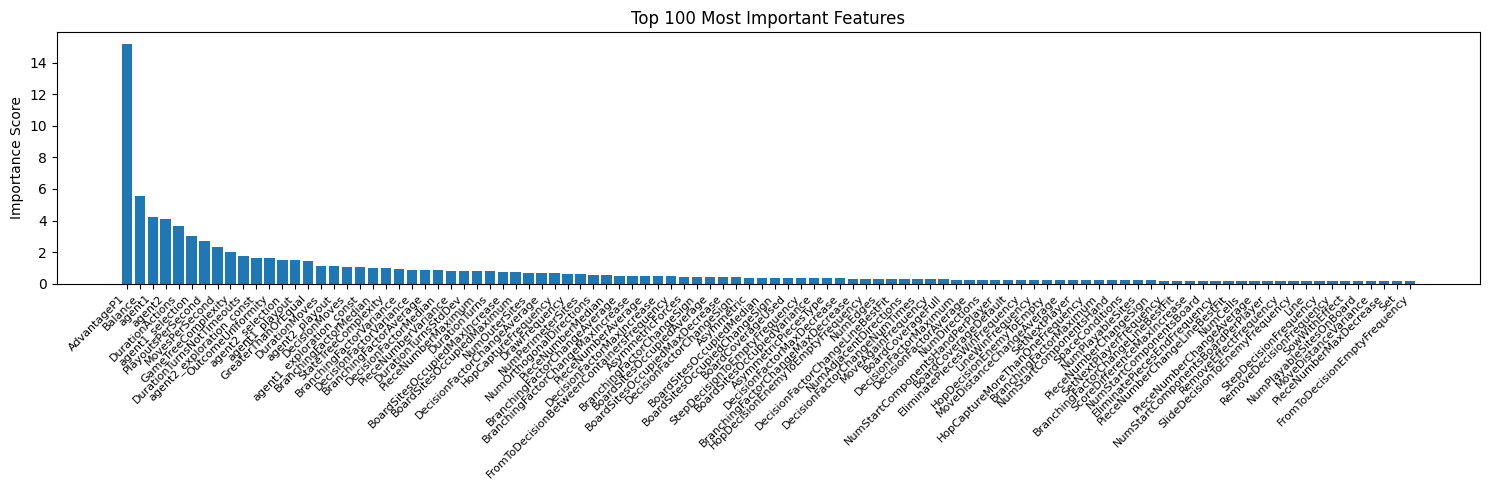

Fold 5 - RMSE: 0.42307467506438495
List of oof scores: [0.42232624677466823, 0.4025623021398531, 0.4121822674890757, 0.4151526858996838, 0.42307467506438495]
Average oof score: 0.4150596354735332


In [13]:
# call the function
trained_models3, oof3, oof_scores3, importance_df3 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    split_list=split3,
)
# save oof predictions
oof3.to_parquet(path_results / f'oof_catboost_{fs_type}_cv3.parquet', index=False)

In [14]:
# Print summary of OOF scores for each CV fold
print("CV1 OOF Scores:")
for score in oof_scores1:
    print(f"Score: {score:.4f}")
print(f"Average CV1 Score: {sum(oof_scores1)/len(oof_scores1):.4f}")
    
print("\nCV2 OOF Scores:")  
for score in oof_scores2:
    print(f"Score: {score:.4f}")
print(f"Average CV2 Score: {sum(oof_scores2)/len(oof_scores2):.4f}")
    
print("\nCV3 OOF Scores:")
for score in oof_scores3:
    print(f"Score: {score:.4f}")
print(f"Average CV3 Score: {sum(oof_scores3)/len(oof_scores3):.4f}")


CV1 OOF Scores:
Score: 0.4130
Score: 0.4290
Score: 0.4220
Score: 0.4252
Score: 0.3965
Average CV1 Score: 0.4171

CV2 OOF Scores:
Score: 0.4054
Score: 0.3901
Score: 0.4228
Score: 0.4327
Score: 0.4278
Average CV2 Score: 0.4158

CV3 OOF Scores:
Score: 0.4223
Score: 0.4026
Score: 0.4122
Score: 0.4152
Score: 0.4231
Average CV3 Score: 0.4151


In [15]:
trained_models = [*trained_models1, *trained_models2, *trained_models3]
# trained_models = trained_models1

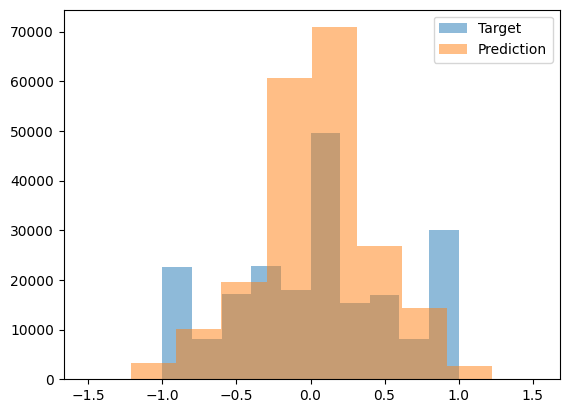

In [16]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [17]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [18]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame):
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler,
        include_position_features=True,
        include_text_features=True,
    )

    # Create CatBoost Pool for test data
    test_pool = cb.Pool(
        # data=test_processed[numerical_cols + categorical_cols + text_cols],
        data=test_processed[numerical_cols + categorical_cols],
        cat_features=categorical_cols,
        # text_features=text_cols,
    )

    # Average predictions from all models
    predictions = np.mean([
        model.predict(test_pool)
        for model in trained_models
    ], axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [19]:
# sanity check
df_test = pl.read_csv('../data/raw/test.csv')
sample_sub = pl.read_csv('../data/raw/sample_submission.csv')
predict(df_test, sample_sub)

shape: (3, 2)
┌────────┬────────────────┐
│ Id     ┆ utility_agent1 │
│ ---    ┆ ---            │
│ i64    ┆ f64            │
╞════════╪════════════════╡
│ 233234 ┆ 0.125702       │
│ 233235 ┆ -0.154723      │
│ 233236 ┆ -0.007612      │
└────────┴────────────────┘

In [20]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [21]:
# Save all artifacts needed for prediction
catboost_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols,
    'text_cols': text_cols,
    'encoder': encoder, 
    'scaler': scaler
}
with open(f'./catboost_predict_{fs_type}.pkl', 'wb') as f:
    pickle.dump(catboost_predict, f)

***